# **Linking Keystrokes to Writing Processes and Language Quality**

# **SETUP**

## **Installation and Imports**

This section sets up the notebook environment.
All cells can be run as-is.

- Install Required Packages: Installs third-party libraries if needed.
- Import Libraries: Loads core Python and ML libraries.
- Notebook Display Settings: Applies default display, warning, and plotting settings.

### 📥 **Install Required Packages**
Ensure `pip` is available in the environment to install all required libraries for this notebook.

In [1]:
%pip install catboost dill lightgbm matplotlib numpy pandas scipy seaborn scikit-learn xgboost tqdm ftfy humanize shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### 📥 **Import Libraries**

In [2]:
import copy
import os
import re
import shutil
import time
import warnings
from collections import OrderedDict
from glob import glob
import humanize
import xgboost as xgb
import lightgbm as lgb
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from sklearn.metrics import auc, roc_auc_score, roc_curve, mean_squared_error
from sklearn.model_selection import (
    StratifiedKFold,
)
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.stats import linregress, entropy, pearsonr, spearmanr, norm
from scipy.spatial.distance import jensenshannon
import ftfy
import shap

### 🖥 **Notebook Display Settings**

In [3]:
pd.options.display.float_format = "{:,.5f}".format 
warnings.filterwarnings("ignore") 
%matplotlib inline

## **Configurations** 

This section contains all the **editable settings** for controlling the pipeline.
- Environment Flags: Toggles for runtime (Local vs Kaggle) and set run name. 
- Experiment Configuration: Core `cfg` dictionary with paths, experiment names, feature switches.
- Model Hyperparameters: Default settings for model training.

Please update this section before running. 

### ⚙️ **Define Environment Flags**

In [4]:
KAGGLE = True # Set to True on Kaggle; False locally
RUN_NAME = "exp_16"

### ⚙️ **Define Experiment Configuration**


In [5]:
# Ordered dictionary to store experiment settings
cfg = OrderedDict()

cfg.kaggle = KAGGLE # Whether code is running on Kaggle or local environment 
cfg.run_name = RUN_NAME # Name for the current run (used for tracking or saving results)
cfg.experiment_name = "linking-writing-processes-to-writing-quality" # Name of the experiment

cfg.seed = 42 # Random seed for reproducibility
cfg.nbags = 6 # Number of models to train for bagging ensemble
cfg.nfolds = 5 # Number of cross-validation folds
cfg.target_col = "score" # Target variable (essay score)

cfg.train = True  # Enable training
cfg.preprocess = True  # Whether to preprocess the dataset
cfg.clean = True # Whether to clean the dataset
cfg.preprocess_ext_train = True  # Whether to use external data during training 
cfg.augment = False  # Whether to apply data augmentation 
cfg.scale_feats = True  # Whether to scale numerical features 
cfg.is_classification = False  # Set to True for classification tasks; False for regression
cfg.clip_value = 5.5  # Maximum value to clip predictions (prevents extreme outputs)

# Time window margins (used for data based on timestamps)
cfg.first_margin = 10 * 60 * 1000  # Lower bound: in milliseconds
cfg.last_margin = np.inf  # Upper bound: in milliseconds 
cfg.corr_strict_threshold=1
cfg.corr_soft_threshold=0.999
cfg.feature_variance_thresh=1e-5
cfg.near_constant_buffer=10
cfg.high_corr_feat_keep_top_n=2
cfg.plot_top_features=30
cfg.ablation_top_n_features=70

if cfg.kaggle:
    cfg.data_dir = "../input/" + cfg.experiment_name + "/" # Path to base dataset 
    cfg.mydata_dir = "../input/lynyi-data/"  # Path for preprocessed data
    cfg.out_dir = "output/"  # Output path to save models, logs, plots 
else:
    cfg.data_dir = "input/"+ cfg.experiment_name + "/"
    cfg.mydata_dir = "input/my-data/" 
    cfg.out_dir = "output/"  

In [6]:
print("cfgs")
for key, value in vars(cfg).items():
    print("    {}: {}".format(key, value))

cfgs
    kaggle: True
    run_name: exp_16
    experiment_name: linking-writing-processes-to-writing-quality
    seed: 42
    nbags: 6
    nfolds: 5
    target_col: score
    train: True
    preprocess: True
    clean: True
    preprocess_ext_train: True
    augment: False
    scale_feats: True
    is_classification: False
    clip_value: 5.5
    first_margin: 600000
    last_margin: inf
    corr_strict_threshold: 1
    corr_soft_threshold: 0.999
    feature_variance_thresh: 1e-05
    near_constant_buffer: 10
    high_corr_feat_keep_top_n: 2
    plot_top_features: 30
    ablation_top_n_features: 70
    data_dir: ../input/linking-writing-processes-to-writing-quality/
    mydata_dir: ../input/lynyi-data/
    out_dir: output/


### ⚙️ Define Model Hyperparameters

In [7]:
params = {
    "lgb": {
        "boosting": "gbdt",  # default = "gbdt"
        "objective": "regression",
        'metric': 'rmse',
        "lambda_l1": 0.0,  # default = 0.0
        "lambda_l2": 0.0,  # default = 0.0
        "num_leaves": 16,  # default = 31
        "learning_rate": 0.01,  # default = 0.1
        "max_depth": 4,  # default = -1
        "feature_fraction": 0.4,  # default = 1.0
        "bagging_fraction": 0.4,  # default = 1.0
        "bagging_freq": 8,  # default = 0
        "extra_trees": True,  # default = False
        "min_data_in_leaf": 5,  # default = 20
        "random_state": cfg.seed,
    },
    "xgb": {
        "booster": "gbtree",
        "eval_metric": "rmse",
        "objective": "reg:squarederror",
        "max_depth": 4,  # default = 6
        "eta": 0.05,  # default = 0.3
        "alpha": 1.0,  # default=0
        "lambda": 2.0,  # default=1
        "gamma": 1.5,  # default=0
        "colsample_bytree": 0.2,  # default=1
        "colsample_bynode": 0.2,  # default=1
        "colsample_bylevel": 0.8,  # default=1
        "subsample": 0.4,  # default=1
        "min_child_weight": 1.0,  # default=1
        "seed": cfg.seed,
        "use_rmm": True,
    },
}

# **UTILITY FUNCTIONS**
This section defines helper functions used throughout the notebook

## **File and Serialization Utilities**

In [8]:
def pickle_dump(obj, path):
    """
    Saves a Python object to a file using dill serialization. 
    Overwrites the file if it already exists.
    Parameters:
        obj (Any): The Python object to be saved.
        path (str): The file path where the object will be stored.
    """
    with open(path, mode="wb") as f:
        dill.dump(obj, f, protocol=4)

def pickle_load(path):
    """
    Loads a Python object from a dill-serialized file.
    Raises an error if the file is not found or not properly formatted.
    Parameters:
        path (str): The file path to load the object from.
    Returns:
        Any: The deserialized Python object.
    """
    with open(path, mode="rb") as f:
        data = dill.load(f)
        return data

In [9]:
def mkdir_if_not_exist(folder_path, overwrite=False):
    """
    Creates a directory if it does not exist. Optionally overwrites it if it already exists.
    Parameters:
        folder_path (str): Path of the directory to create.
        overwrite (bool): If True, deletes the existing directory and recreates it. Default is False.
    """
    if os.path.exists(folder_path):
        if overwrite:
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)
    else:
        os.makedirs(folder_path)

def rmdir_if_exist(folder_path):
    """
    Removes a directory if it exists.
    Parameters:
        folder_path (str): Path of the directory to remove.
    """
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)

## **Plotting Utilities**

In [10]:
def plot_roc(y_true, y_pred):
    """
    Plots the Receiver Operating Characteristic (ROC) curve and calculates the AUC. 
    Parameters:
        y_true (array-like): True binary labels.
        y_pred (array-like): Predicted scores or probabilities for the positive class.
    Returns:
        None: Displays the scatter plot
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 5))
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

In [11]:
def scatter_col(
    dfs,  
    col1="x",
    col2="y",  
    group_col=None,  
    is_cudf=False,  
    alpha=0.3  
):
    """
    Creates a scatter plot to visualize the relationship between two columns across one or more DataFrames, with optional grouping.
    Parameters:
        dfs (list of DataFrame): A list of pandas or cuDF DataFrames to plot.
        col1 (str): Name of the column to use for the x-axis. Default is "x".
        col2 (str): Name of the column to use for the y-axis. Default is "y".
        group_col (str, optional): Column name used to group data points by category.
                                   Each group will be plotted with a separate label and color.
        is_cudf (bool): If True, treats input DataFrames as cuDF (GPU-based); converts them to pandas for plotting.
        alpha (float): Transparency of scatter plot points. Ranges from 0 (transparent) to 1 (opaque).
    Returns:
        None: Displays the scatter plot
    """
    fig = plt.figure()
    for i, df in enumerate(dfs):
        if group_col is not None:
            for c in df[group_col].unique():
                if is_cudf:
                    v1 = (
                        df[
                            (df[col1].isna() == False)
                            & (df[col2].isna() == False)
                            & (df[group_col] == c)
                        ][col1]
                        .to_pandas()
                        .values
                    )
                    v2 = (
                        df[
                            (df[col1].isna() == False)
                            & (df[col2].isna() == False)
                            & (df[group_col] == c)
                        ][col2]
                        .to_pandas()
                        .values
                    )
                else:
                    v1 = df[
                        (df[col1].isna() == False)
                        & (df[col2].isna() == False)
                        & (df[group_col] == c)
                    ][col1].values
                    v2 = df[
                        (df[col1].isna() == False)
                        & (df[col2].isna() == False)
                        & (df[group_col] == c)
                    ][col2].values
                plt.scatter(
                    v1,
                    v2,
                    marker=".",
                    label=f"df{i}_{group_col}-{c}",
                    alpha=alpha,
                    edgecolors="none",
                )
        else:
            if is_cudf:
                v1 = (
                    df[(df[col1].isna() == False) & (
                        df[col2].isna() == False)][col1]
                    .to_pandas()
                    .values
                )
                v2 = (
                    df[(df[col1].isna() == False) & (
                        df[col2].isna() == False)][col2]
                    .to_pandas()
                    .values
                )
            else:
                v1 = df[(df[col1].isna() == False) & (df[col2].isna() == False)][
                    col1
                ].values
                v2 = df[(df[col1].isna() == False) & (df[col2].isna() == False)][
                    col2
                ].values
            plt.scatter(
                v1, v2, marker=".", label=f"df{i}", alpha=alpha, edgecolors="none"
            )
    plt.legend(bbox_to_anchor=(1, 1), loc="upper right",
               borderaxespad=1, fontsize=10)
    if group_col is not None:
        plt.title(f"{col1} - {col2} - {group_col}")
    else:
        plt.title(f"{col1} - {col2}")
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

In [12]:
def plot_feature_importance(importance_df,
                             top_n=30,
                             title=None,
                             normalize=False,
                             save_path=None,
                             method="gain"):
    """
    Plots top N features from a feature importance DataFrame. 
    Optionally, saves plot as PNG and normalize importance value to 1. 

    Parameters:
        importance_df (pd.DataFrame): Must have ['feature', 'importance'].
        top_n (int): Number of top features to display.
        title (str): Optional custom title.
        normalize (bool): If True, normalizes importance to sum to 1.
        save_path (str): If provided, saves plot as PNG.
        method (str): "gain" or "split" — which importance metric to use.
    """
    df = importance_df.copy()

    if normalize:
        total = df["importance"].sum()
        df["importance"] = df["importance"] / total if total > 0 else df["importance"]

    top_feats = df.sort_values(by="importance", ascending=False).head(top_n)

    # Fixed styling parameters
    font_scale = 0.9
    bar_height = 0.4
    figsize = (8, bar_height * top_n + 2)

    sns.set(style="whitegrid")
    sns.set_context("notebook", font_scale=font_scale)

    plt.figure(figsize=figsize)
    ax = sns.barplot(data=top_feats, x="importance", y="feature", palette="Blues_r")

    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Importance" + (" (Normalized)" if normalize else ""), fontsize=10)
    ax.set_ylabel("")

    plt.tight_layout()

    if save_path:
        mkdir_if_not_exist(save_path)
        filename = f"plot_avg_{method}_feature_importance.png"
        full_path = os.path.join(save_path, filename)
        plt.savefig(full_path, dpi=600, bbox_inches="tight")
    plt.show()

In [13]:
def plot_pred(y_true, y_pred, fig_path=None):
    """
    Plots a scatter plot comparing predicted values to true target values 
    to visualize regression performance. 
    Points should ideally lie along the diagonal if predictions are accurate.
    Parameters:
        y_true (array-like): Ground truth target values.
        y_pred (array-like): Predicted values from the model.
        fig_path (str, optional): If provided, saves the figure to this file path.
    Returns:
        None: Displays the scatter plot. Optionally saves it to disk.
    """
    fig = plt.figure()
    plt.scatter(
        y_pred,
        y_true,
        marker=".",
        label=f"prediction",
        alpha=0.3,
        edgecolors="none",
    )
    plt.title(f"Target - Prediction")
    plt.xlabel("Prediction")
    plt.ylabel("Target")
    plt.show()
    if fig_path is not None:
        fig.savefig(fig_path)

In [14]:
def plot_shap_summary(shap_values,
                      df,
                      top_n=30,
                      show_bar=True,
                      show_beeswarm=True,
                      title_prefix="",
                      save_path=None):
    """
    Plots SHAP summary plots (bar and/or beeswarm).

    Parameters:
        shap_values: SHAP values array (n_samples, n_features).
        df: DataFrame with features used in the model.
        top_n: Number of top features to show in the plot.
        show_bar: Whether to plot the SHAP bar plot.
        show_beeswarm: Whether to plot the SHAP beeswarm plot.
        title_prefix: Optional string to prepend to plot titles.
        save_path: If set, saves plots to this directory (as PNG).
    """
    if save_path:
        mkdir_if_not_exist(save_path)

    font_scale = 0.9
    bar_height = 0.4
    figsize = (8, bar_height * top_n + 2)
    sns.set(style="whitegrid")
    sns.set_context("notebook", font_scale=font_scale)
    
    
    if show_bar:
        print(f"{title_prefix} SHAP Summary Bar (Top {top_n})")
        mean_shap = np.abs(shap_values).mean(axis=0)
        shap_df = pd.DataFrame({
            'feature': df.columns,
            'mean_shap': mean_shap
        }).sort_values(by='mean_shap', ascending=False).head(top_n)
        plt.figure(figsize=figsize)
        ax = sns.barplot(data=shap_df, x="mean_shap", y="feature", palette="Blues_r")
        ax.set_title(f"SHAP Summary Bar - {title_prefix}", fontsize=12)
        ax.set_xlabel("Mean(|SHAP value|) (Average Impact on Model Output Magnitude)")
        ax.set_ylabel("")
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}/shap_bar_top{top_n}.png", dpi=600, bbox_inches="tight")
        plt.show()

    if show_beeswarm:
        print(f"{title_prefix} SHAP Beeswarm Plot (Top {top_n})")
        shap.summary_plot(shap_values, df, max_display=top_n, show=False)
        fig = plt.gcf()
        fig.set_size_inches(figsize)

        ax = plt.gca()
        ax.set_title(f"SHAP Beeswarm - {title_prefix}", fontsize=12)
        ax.set_xlabel("SHAP Value (Impact on Model Output)", fontsize=10)
        ax.set_ylabel("")
        ax.tick_params(axis='both', labelsize=9)
        plt.tight_layout()
        if save_path:
            filename = f"shap_beeswarm_top{top_n}.png"
            full_path = os.path.join(save_path, filename)
            plt.savefig(full_path, dpi=600, bbox_inches="tight")
        plt.show()

## **Data Cleaning Utilities** ##
Fixes encoding issues, removes logs outside time margins, resets timestamps to start from zero and label-encodes essay IDs

In [15]:
def reset_timestamps(df):
    """
    Normalize timestamps so each session starts at 0 ms, while preserving original time intervals.
    """
    adjusted_down_times = []  
    adjusted_up_times = []  
    prev_idx = -1  # Tracks previous session ID
    time_offset = 0  # Offset to make the first event start at 0ms

    for row in tqdm(df[['id_encode', 'down_time', 'up_time']].values, desc="Reset Keystrokes Times to 0"):
        idx = int(row[0])  
        down_time = int(row[1])
        up_time = int(row[2])
        # New session → reset offset
        if prev_idx != idx:
            time_offset = down_time 
            prev_idx = idx  
        true_down_time = down_time - time_offset
        true_up_time = up_time - time_offset
        adjusted_down_times.append(true_down_time)
        adjusted_up_times.append(true_up_time)
    df['down_time'] = adjusted_down_times
    df['up_time'] = adjusted_up_times
    return df


In [16]:
def clean_str_columns(log_df, columns): 
    """
    Cleans text columns in a DataFrame by fixing encoding issues (e.g. special characters).
    Parameters:
        log_df (pd.DataFrame): The input DataFrame containing string columns to clean.
        columns (list of str): List of column names to be cleaned.
    Returns:
        pd.DataFrame: The DataFrame with specified columns cleaned."
    """
    for c in tqdm(columns, desc="Cleaning string columns"):
        log_df[c] = [clean_latin(s) for s in log_df[c]] 
    return log_df

In [17]:
# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def label_encode(train_df, test_df=None, col="target", replace=True):
    """
    Utility function for encoding categorical variables into integers using LabelEncoder.
    """
    le = sklearn.preprocessing.LabelEncoder() # Initialize LabelEncoder 
    le.fit(train_df[col]) # Fit on training date 
    if replace:
        out_col = col
    else:
        out_col = col + "_encode"
    train_df[out_col] = le.transform(train_df[col]) # Encode training data
    if test_df is not None:
        dic = dict(zip(le.classes_, le.transform(le.classes_))) # Create mapping from category to label
        # Map test data using the same encoding; assign max+1 for unknowns
        test_df[out_col] = test_df[col].map(dic).fillna(  
            train_df[out_col].max()+1).astype(int)
        return train_df, test_df, le
    else:
        return train_df, le 

In [18]:
# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def remove_margin(log_df, first_margin=2*60*1000, last_margin=2*60*1000):
    """
    Purpose: Trim irrelevant parts of the keystroke log before and after real writing activity
    """
    log_df = log_df[log_df.up_event != 'Unidentified'].reset_index(drop=True) 
    res_df = [] # Will hold cleaned sessions
    glog_df = log_df.groupby('id_encode')  
    for df in tqdm(glog_df, desc='Remove Irrelevant Logs (per Essay)'):
        df = df[1] 
        down_times = df[
            (df.activity != 'Nonproduction') | 
            (df.up_event == 'Shift') | 
            (df.up_event == 'CapsLock') # Real writing activity
        ].down_time.values 
        # Trim based on first and last meaningful key event ± margin
        df = df[(df.down_time > down_times.min() - first_margin)] 
        df = df[(df.down_time < down_times.max() + last_margin)] 
        # Reset event ID sequence 
        df['event_id'] = [i for i in range(len(df))] 
        res_df.append(df)  
    res_df = pd.concat(res_df).reset_index(drop=True) 
    return res_df

In [19]:
# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def clean_latin(s):
    """
    Clean improperly encoded characters in string s using the `ftfy` library
    """
    # If s is not in the list of allowed/special keys, attempt to fix encoding
    if s not in ['q', ' ', 'NoChange', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick',
       'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock',
                 "'", 'Delete', 'Unidentified', 'Control', '"', '-', '?', ';', '=',
                 'Tab', '/', 'Rightclick', ':', '(', ')', 'ContextMenu',
                 'End', '!', 'Meta', 'Alt', 'c', '[', 'v', 'NumLock', 'Insert',
                 'Home', 'z', 'a', 'AudioVolumeDown', 'F2', 'x', 't',
                 'AudioVolumeUp', 'i', '$', '>', ']', 's', '*', '%', 'w', '&',
                 'Dead', 'm', 'Escape', 'ModeChange', 'F3', '<', 'AudioVolumeMute',
                 'F15', '+', 'o', 'ScrollLock', 'PageDown', 'Process', 'h', 'b',
                 'e', 'p', '_', 'f', '{', 'PageUp', '`', '0', 'r', '#', '1',
                 'Middleclick', 'F12', '5', 'OS', '@', 'n', 'y', 'g', 'F11',
                 'MediaTrackNext', 'l', 'Clear', 'd', 'MediaPlayPause', 'j',
                 'V', 'u', '}', '~', 'AltGraph', '2', '|',
                 'Unknownclick', 'A', 'MediaTrackPrevious', '^', 'C',
                 'Pause', 'k', 'F1', 'F10', 'Cancel', 'T', 'S', 'M', 'F6']: 
        s = ftfy.fix_text(s)
    return s

## **Feature Extraction Utilities** ##

Extracts new features based on six main categories:  
1. Pause Dynamics  
2. Verbosity  
3. Revision  
4. Fluency  
5. Product-Related  
6. Other Events  
*Please refer to the project report for a full breakdown and detailed descriptions of each feature.*

This section is organized into: 
- 🧮 **Statistical Summary Functions**
- 📥 **Base-Level Functions**
- 🔧 **Helper Functions**
- 🚀 **Main Feature Functions** 

#### 🧮 Statistical Summary Functions

In [20]:
def compute_grouped_statistics(df, log_df, group_col, target_col, methods=["min", "max"], nan_value=0, prefix=None, suffix=None):
    """
    Computes summary statistics for a given numerical column (target_col) grouped by a categorical column (group_col) and adds these statistics to the main DataFrame (df).
    
    Supported Statistics:
    - "num": The total number of elements in the column for each group.
    - "nunique": The number of unique values in the column for each group.
    - "mean": The average value of the column for each group.
    - "max": The maximum value in the column for each group.
    - "min": The minimum value in the column for each group.
    - "std": The standard deviation of the column for each group.
    - "sum": The sum of all values in the column for each group.
    - "skew": The skewness (asymmetry of distribution) of the column for each group.
    - "sem": The standard error of the mean (the uncertainty of the mean estimate) for each group.
    - "kurtosis": The kurtosis (tailedness of distribution) of the column for each group.
    - "quantile": The quantiles (percentiles) of the column for each group, defaults to 5%, 25%, 50%, 75%, and 95%.
    
    Parameters:
    - df: The main DataFrame where the results will be added
    - log_df: The DataFrame containing the data for group_col and target_col
    - group_col: The categorical column to group by (e.g., essay ID or subject)
    - target_col: The numerical column for which statistics are computed
    - methods: List of statistics to compute (e.g., 'min', 'max', 'mean', etc.)
    - nan_value: Value to use for NaN entries when no data is available
    - prefix: Optional prefix for the output column names
    - suffix: Optional suffix for the output column names

    Returns:
    - The original DataFrame (df) with additional columns for each statistic.
    """
    # Group data by group_col, sort the values within each group, and convert each group into a list of values
    groups = log_df[[target_col, group_col]].groupby(group_col, group_keys=False)[target_col].apply(
        lambda x: np.sort(x.values)).values 
    for method in methods:
        if method == "num":  # Total number of elements per group
            res = [len(x) for x in groups]
        elif method == "nunique":  # Number of unique values per group
            res = [len(np.unique(x)) for x in groups]
        elif method == "mean": # Average value of target_col per group 
            res = [nan_value if all(
                np.isnan(x)) else np.nanmean(x) for x in groups]
        elif method == "max": # Highest value of target_col per group
            res = [nan_value if all(  
                np.isnan(x)) else np.nanmax(x) for x in groups]
        elif method == "min": # Lowest value of target_col per group
            res = [nan_value if all(  
                np.isnan(x)) else np.nanmin(x) for x in groups]
        elif method == "std": # Standard deviation 
            res = [nan_value if all(
                np.isnan(x)) else np.nanstd(x) for x in groups]
        elif method == "sum": # Sum of values 
            res = [nan_value if all(
                np.isnan(x)) else np.nansum(x) for x in groups]
        elif method == "skew": # Skewness: Measures asymmetry of data distribution (positive = right-skewed, negative = left-skewed).
            res = []
            for x in groups:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)  # Ignore RuntimeWarnings
                    skew_value = scipy.stats.skew(x[~np.isnan(x)], nan_policy='omit')
                    res.append(skew_value)
        elif method == "kurtosis": # Measures tailedness of the distribution (higher kurtosis = more outliers).
            res = []
            for x in groups:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)  # Ignore RuntimeWarnings
                    kurtosis_value = scipy.stats.kurtosis(x, nan_policy='omit')
                    res.append(kurtosis_value)
        elif method == "sem": # Standard Error of Mean: measures how much the sample mean varies 
            res = [nan_value if len(x[~np.isnan(
                x)]) < 2 else scipy.stats.sem(x[~np.isnan(x)], nan_policy='omit') for x in groups]
        elif method == "quantile": # Percentile values 
            res = np.array([[nan_value]*5 if all(np.isnan(x)) else list(
                np.nanquantile(x, [0.05, 0.25, 0.5, 0.75, 0.95])) for x in groups])
        base = f'{prefix}_{target_col}_{suffix}' if (prefix and suffix) else (f'{prefix}_{target_col}' if prefix else (f'{target_col}_{suffix}' if suffix else f'{target_col}'))
        if len(res) == len(df):
            if method == "quantile":
                for i, x in enumerate(['q05', 'q25', 'q50', 'q75', 'q95']):
                    df[f'{base}_{x}'] = res[:, i]
            else:
                df[f'{base}_{method}'] = res
        else: # res might have fewer rows as groupby(group_col) operation aggregates data per essay ID (id_encode).
            tmp_df = pd.DataFrame()
            tmp_df[group_col] = log_df[group_col].unique() # Temporary dataframe is created with unique essay ID rows 
            if method == "quantile":
                for i, x in enumerate(['q05', 'q25', 'q50', 'q75', 'q95']):
                    tmp_df[f'{base}_{x}'] = res[:, i]
            else:
                tmp_df[f'{base}_{method}'] = res
            df = df.merge(tmp_df, how='left') # Merge this temp dataframe with the original one 
    return df

In [21]:
def compute_array_statistics(arr, nan_value=0):
    """
    Computes summary statistics for a given numerical array (arr).
    The statistics are computed in the following order (if the array is non-empty):
    1. mean: The average value of the array.
    2. max: The maximum value in the array.
    3. min: The minimum value in the array.
    4. standard deviation: A measure of the dispersion of the array.
    5. quantiles: The specified quantiles of the array, the 5%, 25%, 50%, 75%, and 95% percentiles.
    If the array is empty, it returns a list of nan_value repeated for each statistic.

    Returns:
    - A list of computed statistics in order.
    """
    res = []
    if len(arr) > 0:
        res.append(np.mean(arr))
        res.append(np.max(arr))
        res.append(np.min(arr))
        res.append(np.std(arr))
        res.extend(list(np.quantile(arr, [0.05, 0.25, 0.5, 0.75, 0.95])))
    else:
        res = [nan_value] * 9
    return res

#### 📥 Base-Level Functions
Extract base-level features directly from raw logs (e.g., inter-word-boundaries, burst types).

In [22]:
def get_inter_word_boundaries(log_df):  
    """
    Get the boundaries between words based on keystrokes and spacebar events. Identifies the start of words, 
    the previous space before the word starts, and the most recent letter input before a space.

    Returns:
    - A DataFrame containing the inter-word boundaries keystrokes (last letter of a word -> space -> first letter of a word).
    """
    pbar = tqdm(total=6, desc="Processing Word Boundaries")
    log_df['prev_word_count'] = log_df.groupby('id_encode')['word_count'].shift(1)

    # Identify the first keystroke of each new word based on the word_count and certain conditions
    word_starts = log_df[
        (log_df['word_count'] > log_df['prev_word_count']) & # Detects the first keystroke of a new word
        (log_df['activity'].isin(['Input', 'Paste'])) &
        (log_df['prev_word_count'] > 0) & # Ensure there is a previous word to compare against
        (log_df['text_change'].str.contains('q', na=False))
    ].copy()
    word_starts.rename(columns={
        'event_id': 'word_starts_event_id',
        'up_time': 'word_starts_up_time', 
        'down_time': 'word_starts_down_time', 
        'cursor_position': 'word_starts_cursor_position',
        'prev_word_count': 'word_starts_prev_word_count'
    }, inplace=True)
    word_starts = word_starts.sort_values('word_starts_event_id').reset_index(drop=True)
    pbar.update(1)
   
    # Get all spacebar typed events from the log
    spaces = log_df[
        (log_df['activity'] == 'Input') &
        (log_df['down_event'] == 'Space') 
    ].copy()
    spaces.rename(columns={
        'event_id': 'space_event_id',
        'up_time': 'space_up_time', 
        'down_time': 'space_down_time', 
        'cursor_position': 'space_cursor_position'
    }, inplace=True)
    spaces = spaces.sort_values('space_event_id').reset_index(drop=True)
    pbar.update(1)

    # Merge word starts with the most recent space event before each word start
    word_starts = pd.merge_asof(
        left=word_starts,
        right=spaces,
        by='id_encode',
        left_on='word_starts_event_id',
        right_on='space_event_id',
        direction='backward',
        allow_exact_matches=False
    )
    word_starts = word_starts.dropna(subset=['space_event_id']) # Drop rows without a matching space event (potentially non-linear transitions between words )
    pbar.update(1)

    # Extract all valid letter inputs (exclude non-production or delete activities)
    letter_inputs = log_df[
        ~log_df['activity'].isin(['Nonproduction', 'Remove/Cut'])
    ].copy()
    letter_inputs.rename(columns={
        'event_id': 'letter_event_id',
        'word_count': 'letter_word_count',
        'up_time': 'prev_word_end_up_time',
        'down_time': 'prev_word_end_down_time', 
        'cursor_position': 'prev_word_end_cursor_position'
    }, inplace=True)
    letter_inputs = letter_inputs.sort_values('letter_event_id').reset_index(drop=True)
    word_starts['space_event_id'] = word_starts['space_event_id'].astype('int64')
    word_starts = word_starts.sort_values('space_event_id').reset_index(drop=True)
    pbar.update(1)
    
    # Merge the word starts with the most recent letter input before each space
    word_starts = pd.merge_asof(
        left=word_starts,
        right=letter_inputs,
        by='id_encode',
        left_on='space_event_id',
        right_on='letter_event_id',
        direction='backward',
        allow_exact_matches=False
    )
    word_starts = word_starts.dropna(subset=['letter_event_id']).sort_values(['id_encode', 'word_starts_event_id']).reset_index(drop=True)
    pbar.update(1)

    # Filter matches where the previous letter belongs to the previous word
    filtered_word_starts_df = word_starts[word_starts['letter_word_count'] == word_starts['word_starts_prev_word_count']].copy()

    # Eliminate cursor jump cases (e.g., edits/corrections elsewhere)
    filtered_word_starts_df['cursor_diff'] = filtered_word_starts_df['word_starts_cursor_position'] - filtered_word_starts_df['prev_word_end_cursor_position']
    filtered_word_starts_df = filtered_word_starts_df[abs(filtered_word_starts_df['cursor_diff']) < 3]
    pbar.update(1)
    # Sanity checks for correct chronological sequence
    # assert all(filtered_word_starts_df['word_starts_down_time'] >= filtered_word_starts_df['prev_word_end_down_time'])
    # assert all(filtered_word_starts_df['space_down_time'] >= filtered_word_starts_df['prev_word_end_down_time'])
    # assert all(filtered_word_starts_df['word_starts_event_id'] > filtered_word_starts_df['space_event_id'])
    # assert all(filtered_word_starts_df['space_event_id'] > filtered_word_starts_df['letter_event_id'])
    pbar.close()
    return filtered_word_starts_df

In [23]:
def get_inter_sentence_boundaries(log_df): 
    """
    Get the boundaries between sentences based on punctuation and space events. Identifies sentence-ending punctuations, 
    space after the punctuations and the first letter of the next sentence. 

    Returns:
    - A DataFrame containing the inter-sentence boundaries keystrokes (End punctuations (., ? or !) -> Space -> First letter of a Sentence).
    """
    pbar = tqdm(total=8, desc="Processing Sentence Boundaries")
    log_df['activity_standardized'] = [
        s if 'Move' not in s else 'Move' for s in log_df['activity']] 
    # Get all punctuation events that end a sentence (., !, ?) but do NOT end with space
    end_punctuations_without_space = log_df[
        (log_df['activity_standardized'].isin(['Input', 'Paste', 'Replace', 'Move'])) &
        (log_df['text_change'].str.match(r'.*[.!?]$', na=False))  # Ends with . ! ? with NO trailing spaces
    ].copy()
    end_punctuations_without_space.rename(columns={
        'event_id': 'end_punctuations_event_id',
        'up_time': 'end_punctuations_up_time', 
        'down_time': 'end_punctuations_down_time', 
        'cursor_position': 'end_punctuations_cursor_position'
    }, inplace=True)
    end_punctuations_without_space = end_punctuations_without_space.sort_values('end_punctuations_event_id').reset_index(drop=True)
    pbar.update(1)

    # Get all spacebar events 
    spaces = log_df[
        (log_df['activity_standardized'] == 'Input') &
        (log_df['down_event'] == 'Space') 
    ].copy()
    spaces.rename(columns={
        'event_id': 'space_event_id',
        'up_time': 'space_up_time', 
        'down_time': 'space_down_time', 
        'cursor_position': 'space_cursor_position'
    }, inplace=True)
    spaces = spaces.sort_values('space_event_id').reset_index(drop=True)
    pbar.update(1)

    # Find most recent SPACE after each end punctuation (without trailing space)
    end_punctuations_without_space = pd.merge_asof(
        left=end_punctuations_without_space,
        right=spaces,
        by='id_encode',
        left_on='end_punctuations_event_id',
        right_on='space_event_id',
        direction='forward',
        allow_exact_matches=False
    )   
    end_punctuations_without_space = end_punctuations_without_space.dropna(subset=['space_event_id']) # Drop where no following space was found (i.e. last sentence)
    pbar.update(1)

    # Get punctuation events that already end with spaces
    end_punctuations_with_space = log_df[
        (log_df['activity_standardized'].isin(['Paste', 'Replace', 'Move'])) &
        (log_df['text_change'].str.match(r'.*[.!?]\s+$', na=False))  # Ends with punctuation + space(s)
    ].copy()
    end_punctuations_with_space.rename(columns={
        'event_id': 'end_punctuations_event_id',
        'up_time': 'end_punctuations_up_time', 
        'down_time': 'end_punctuations_down_time', 
        'cursor_position': 'end_punctuations_cursor_position'
    }, inplace=True)
    end_punctuations_with_space['space_event_id'] = end_punctuations_with_space['end_punctuations_event_id']
    end_punctuations_with_space['space_up_time'] = end_punctuations_with_space['end_punctuations_up_time']
    end_punctuations_with_space['space_down_time'] = end_punctuations_with_space['end_punctuations_down_time']
    end_punctuations_with_space['space_cursor_position'] = end_punctuations_with_space['end_punctuations_cursor_position']
    pbar.update(1)

    # Combine both punctuation sets
    end_punctuations = pd.concat([
        end_punctuations_without_space,  
        end_punctuations_with_space  
    ])
    end_punctuations['space_event_id'] = end_punctuations['space_event_id'].astype('int64')
    end_punctuations = end_punctuations[[
        'id_x',
        'id_encode',
        'end_punctuations_event_id',
        'end_punctuations_up_time',
        'end_punctuations_down_time',
        'end_punctuations_cursor_position',
        'space_event_id',
        'space_up_time',
        'space_down_time',
        'space_cursor_position'
    ]].sort_values(['space_event_id']).reset_index(drop=True)
    pbar.update(1)

    # Get candidates first letter of the next sentence 
    sentence_starts = log_df[
        (log_df['activity_standardized'].isin(['Input', 'Paste', 'Move'])) &
        (log_df['text_change'].str.contains('q', na=False))
    ].copy()
    sentence_starts.rename(columns={
        'event_id': 'sentence_starts_event_id',
        'up_time': 'sentence_starts_up_time', 
        'down_time': 'sentence_starts_down_time', 
        'cursor_position': 'sentence_starts_cursor_position',
    }, inplace=True)
    sentence_starts = sentence_starts[[
        'id_encode',
        'sentence_starts_event_id',
        'sentence_starts_up_time',
        'sentence_starts_down_time',
        'sentence_starts_cursor_position'
    ]].sort_values('sentence_starts_event_id').reset_index(drop=True)
    pbar.update(1)

    # Find the first letter of the next sentence after the space
    end_punctuations = pd.merge_asof(
        left=end_punctuations,
        right=sentence_starts,
        by='id_encode',
        left_on='space_event_id',
        right_on='sentence_starts_event_id',
        direction='forward',
        allow_exact_matches=False
    )   
    end_punctuations = end_punctuations.dropna(subset=['sentence_starts_event_id']) # Drop where no next sentence was found
    pbar.update(1)

    # Eliminate cursor jump cases (e.g., edits/corrections elsewhere)
    end_punctuations['cursor_diff'] = end_punctuations['sentence_starts_cursor_position'] - end_punctuations['end_punctuations_cursor_position']
    end_punctuations = end_punctuations[end_punctuations['cursor_diff'] < 7]
    # Sanity checks for correct chronological sequence
    # assert all(end_punctuations['sentence_starts_down_time'] >= end_punctuations['space_down_time'])
    # assert all(end_punctuations['space_down_time'] >= end_punctuations['end_punctuations_down_time'])
    # assert all(end_punctuations['sentence_starts_event_id'] > end_punctuations['space_event_id'])
    # assert all(end_punctuations['space_event_id'] >= end_punctuations['end_punctuations_event_id'])
    pbar.update(1)
    pbar.close()
    return end_punctuations

    

In [24]:
def get_inter_paragraph_boundaries(log_df): 
    """
    Get the boundaries between paragraphs based on changes in paragraph counts, Enter key events, and other relevant keystroke activities.
    Identifies the first letter of the new paragraph, the Enter key press before the paragraph, and the final end punctuation of the previous paragraph.

    Returns:
    - A DataFrame containing the inter-paragraph boundary keystrokes: 
      (End punctuation (., ? or !) -> Enter -> First letter of a Sentence).
    """
    pbar = tqdm(total=10, desc="Processing Paragraph Boundaries")
    log_df['activity_standardized'] = [
        s if 'Move' not in s else 'Move' for s in log_df['activity']] 
    log_df = log_df.sort_values(['id_encode', 'event_id']).reset_index(drop=True)
    log_df['prev_paragraph_count'] = log_df.groupby('id_encode')['paragraph_count'].shift(1)

    # -- First keystroke of each new paragraph will either be a 'q' or 'ENTER' key press --
    # Get all paragraph-starting q inputs 
    paragraph_starts_with_q = log_df[
        (log_df['paragraph_count'] > log_df['prev_paragraph_count']) &
        (log_df['prev_paragraph_count'] > 0) &
        (log_df['activity'] == 'Input') &
        (log_df['text_change'].str.contains('q', na=False))
    ].copy()
    paragraph_starts_with_q.rename(columns={
        'event_id': 'letter_event_id',
        'up_time': 'leter_up_time', 
        'down_time': 'letter_down_time', 
        'cursor_position': 'letter_cursor_position',
    }, inplace=True)
    paragraph_starts_with_q = paragraph_starts_with_q.sort_values('letter_event_id').reset_index(drop=True)
    pbar.update(1)

     # Get all ENTER key events that also start new paragraphs
    paragraph_starts_with_enter = log_df[
        (log_df['paragraph_count'] > log_df['prev_paragraph_count']) &
        (log_df['activity'] == 'Input') &
        (log_df['down_event'] == 'Enter')
    ].copy()
    paragraph_starts_with_enter.rename(columns={
        'event_id': 'enter_event_id',
        'up_time': 'enter_up_time', 
        'down_time': 'enter_down_time', 
        'cursor_position': 'enter_cursor_position',
    }, inplace=True)
    paragraph_starts_with_enter = paragraph_starts_with_enter.sort_values('enter_event_id').reset_index(drop=True)
    pbar.update(1)

    # Get all ENTER key events (used to end paragraphs)
    enters = log_df[
        (log_df['activity'] == 'Input') & 
        (log_df['down_event'] == 'Enter')
    ].copy()
    enters.rename(columns={
        'event_id': 'enter_event_id',
        'down_time': 'enter_down_time',
        'up_time': 'enter_up_time',
        'cursor_position': 'enter_cursor_position'
    }, inplace=True)
    enters = enters.sort_values('enter_event_id').reset_index(drop=True)
    pbar.update(1)

    # Get all valid letter inputs (to find first letter in next paragraph)
    valid_letters = log_df[
        ~log_df['activity'].isin(['Nonproduction', 'Remove/Cut'])
    ].copy()
    valid_letters.rename(columns={
        'event_id': 'letter_event_id',
        'down_time': 'letter_down_time',
        'up_time': 'letter_end_up_time',
        'cursor_position': 'letter_cursor_position'
    }, inplace=True)
    valid_letters = valid_letters.sort_values('letter_event_id').reset_index(drop=True)
    pbar.update(1)
    
    # Get all end punctuation insertions that end with a space
    end_punctuations = log_df[
        (log_df['activity_standardized'].isin(['Input', 'Paste', 'Replace', 'Move'])) &
        (log_df['text_change'].str.match(r'[.!?][\s]*$', na=False))  # Ends with punctuation + space(s)
    ].copy()
    end_punctuations.rename(columns={
        'event_id': 'end_punctuations_event_id',
        'up_time': 'end_punctuations_up_time', 
        'down_time': 'end_punctuations_down_time', 
        'cursor_position': 'end_punctuations_cursor_position'
    }, inplace=True)
    end_punctuations = end_punctuations.sort_values('end_punctuations_event_id').reset_index(drop=True)
    pbar.update(1)

    # Match each paragraph start (q) to the previous ENTER key (end of paragraph)
    paragraph_starts_with_q = pd.merge_asof(
        left=paragraph_starts_with_q,
        right=enters,
        by='id_encode',
        left_on='letter_event_id',
        right_on='enter_event_id',
        direction='backward',
        allow_exact_matches=False
    )
    paragraph_starts_with_q = paragraph_starts_with_q.dropna(subset=['enter_event_id'])
    pbar.update(1)

    # Match each paragraph start (ENTER) to next letter input (first letter of paragraph)
    paragraph_starts_with_enter = pd.merge_asof(
        left=paragraph_starts_with_enter,
        right=valid_letters,
        by='id_encode',
        left_on='enter_event_id',
        right_on='letter_event_id',
        direction='forward',
        allow_exact_matches=False
    )
    paragraph_starts_with_enter = paragraph_starts_with_enter.dropna(subset=['letter_event_id'])
    pbar.update(1)

    # Combine both paragraph start methods (ENTER + q)
    paragraph_starts = pd.concat([
        paragraph_starts_with_q, 
        paragraph_starts_with_enter
    ]).sort_values('enter_event_id')
    pbar.update(1)

    # Match ENTER key to final punctuation mark in previous paragraph
    paragraph_starts['enter_event_id'] = paragraph_starts['enter_event_id'].astype('int64')
    paragraph_starts = pd.merge_asof(
        left=paragraph_starts,
        right=end_punctuations,
        by='id_encode',
        left_on='enter_event_id',
        right_on='end_punctuations_event_id',
        direction='backward',
        allow_exact_matches=False
    )
    paragraph_starts = paragraph_starts.dropna(subset=['end_punctuations_event_id'])
    pbar.update(1)

    # Filter for cursor proximity (avoid editing jumps)
    paragraph_starts['cursor_diff'] = paragraph_starts['letter_cursor_position'] - paragraph_starts['end_punctuations_cursor_position']
    paragraph_starts = paragraph_starts[paragraph_starts['cursor_diff'] < 15]
    # Sanity checks for correct chronological sequence
    # assert all(paragraph_starts['letter_event_id'] > paragraph_starts['enter_event_id'])
    # assert all(paragraph_starts['enter_event_id'] > paragraph_starts['end_punctuations_event_id'])
    # assert all(paragraph_starts['letter_down_time'] >= paragraph_starts['enter_down_time'])
    # assert all(paragraph_starts['enter_down_time'] >= paragraph_starts['end_punctuations_down_time'])
    pbar.update(1)
    pbar.close()
    return paragraph_starts

In [25]:
def get_word_transition_linearity(log_df, inter_word_boundaries):
    """
    Calculates the proportion of linear transitions between words for each essay. A linear transition occurs
    when all intervening events between the end of one word and the start of the next word are character-producing events.

    A transition is considered linear if all events in the interval between the previous word's end and the current word's start 
    are of type 'Input' or 'Paste'. 

    Parameters:
    - log_df: DataFrame containing log data 
    - inter_word_boundaries: DataFrame containing the boundaries between words.

    Returns:
    - A DataFrame containing the 'id_encode' and the calculated 'word_transition_linearity' for each essay.
    """
    results = []

    for id_encode, group in tqdm(inter_word_boundaries.groupby('id_encode'), desc="Word Transition Linearity (per Essay)"):
        linear_transitions_count = 0
        total_transitions_count = len(group)
        for _, row in group.iterrows():
            transition_start = row['prev_word_end_down_time']
            transition_end = row['word_starts_down_time']
            # Get all events that occurred between the time where the previous word ended and the current word started
            intervening_events = log_df[
                (log_df['id_encode'] == id_encode) &
                (log_df['down_time'] >= transition_start) &
                (log_df['down_time'] <= transition_end)
            ]
            # A transition is linear if all events in between are character-producing
            if all(intervening_events['activity'].isin(['Input', 'Paste'])):
                linear_transitions_count += 1
        transition_linearity = (
            linear_transitions_count / total_transitions_count if total_transitions_count > 0 else 0
        )
        results.append({
            'id_encode': id_encode,
            'word_transition_linearity': transition_linearity
        })
    return pd.DataFrame(results)


In [26]:
def get_sentence_transition_linearity(log_df, inter_sentence_boundaries):
    """
    Calculates the proportion of linear transitions between sentence for each essay. A linear transition occurs
    when all intervening events between the end of one sentence and the start of the next sentence are character-producing events.

    A transition is considered linear if all events in the interval between the previous sentence's end and the current sentence's start 
    are of type 'Input' or 'Paste'. 

    Parameters:
    - log_df: DataFrame containing log data 
    - inter_sentence_boundaries: DataFrame containing the boundaries between sentences.

    Returns:
    - A DataFrame containing the 'id_encode' and the calculated 'sentence_transition_linearity' for each essay.
    """
    results = []
    for id_encode, group in tqdm(inter_sentence_boundaries.groupby('id_encode'), desc="Sentence Transition Linearity (per Essay)"):
        linear_transitions_count = 0
        total_transitions_count = len(group)
        for _, row in group.iterrows():
            transition_start = row['end_punctuations_down_time']
            transition_end = row['sentence_starts_down_time']
            # Get all events that occurred between punctuation and next sentence start
            intervening_events = log_df[
                (log_df['id_encode'] == id_encode) &
                (log_df['down_time'] >= transition_start) &
                (log_df['down_time'] <= transition_end)
            ]
            # A transition is linear if all events in between are character-producing
            if all(intervening_events['activity'].isin(['Input', 'Paste'])):
                linear_transitions_count += 1
        transition_linearity = (
            linear_transitions_count / total_transitions_count if total_transitions_count > 0 else 0
        )
        results.append({
            'id_encode': id_encode,
            'sentence_transition_linearity': transition_linearity
        })
    return pd.DataFrame(results)


In [27]:
def validate_PP_burst(burst_df):
    """
    Validates PP burst by checking if all events are at the leading edge.
    """
    return burst_df['is_leading_edge'].all()

def validate_RP1_burst(burst_df):
    """
    Validates RP1 burst by checking if all activities are 'Input' 
    """
    return (burst_df['activity'] == 'Input').all()

def validate_RP2_burst(burst_df):
    """
    Validates RP2 burst by checking if 'Input' and either 'Remove/Cut' or 'Replace' or 'Paste' activities exist.
    """
    return 'Input' in burst_df['activity'].values and any(burst_df['activity'].isin(['Remove/Cut', 'Replace', 'Paste']))

def validate_RP3_burst(burst_df):
    """
    Validates RP3 burst by checking if characters and words decrease, and 'Remove/Cut' or 'Replace' activities exist.
    """
    return (
        any(burst_df['activity'].isin(['Remove/Cut', 'Replace', 'Paste']))
    )

def validate_IB_burst(burst_df):
    """
    Validates IB burst by checking if no events are at the leading edge and sentence count changes are small.
    """
    sentence_count_change = abs(burst_df['sentence_count'].iloc[-1] - burst_df['sentence_count'].iloc[0])
    return not (burst_df['is_leading_edge']).any() and sentence_count_change <= 1 


In [28]:
def append_valid_burst(bursts, burst_type, group, burst_start, burst_end, id_encode, burst_num_limit=1, custom_validation=None):
    """
    Appends a valid burst to the bursts list.

    Parameters:
    - bursts: List to store valid bursts
    - burst_type: Type of the burst (e.g., 'PP', 'RP1', etc.)
    - group: DataFrame containing burst data for a specific essay
    - burst_start: Start index for the burst
    - burst_end: End index for the burst
    - id_encode: Identifier for the current essay 
    - burst_num_limit: Minimum number of events required for the burst to be valid (default is 1)
    - custom_validation: Optional custom validation function for certain burst type validity checks

    Appends burst data (duration, char_count, word_count, typing_speed) to bursts if valid.
    """
    valid_burst_types = ['PP', 'RP1', 'RP2', 'RP3', 'PRL', 'PRI', 'PRLI', 'RRL', 'RRI', 'RRLI', 'IB']
    if burst_type not in valid_burst_types: 
        raise ValueError(f"Invalid burst type: {burst_type}. Must be one of {valid_burst_types}")
    burst_df = group.loc[burst_start:burst_end + 1]
    if custom_validation:
        is_valid = len(burst_df) >= burst_num_limit and custom_validation(burst_df)
    else:
        is_valid = len(burst_df) >= burst_num_limit
    if not is_valid:
        return
    duration = burst_df['up_time'].iloc[-1] - burst_df['down_time'].iloc[0]
    char_count = max(burst_df['len_text'].iloc[-1] - burst_df['len_text'].iloc[0], 0)
    word_count = max(burst_df['word_count'].iloc[-1] - burst_df['word_count'].iloc[0], 0)
    typing_speed = char_count / (duration/1000) 
    bursts.append({
        "id_encode": id_encode,
        "burst_type": burst_type,
        "duration": duration,
        "char_count": char_count,
        "word_count": word_count,
        "typing_speed": typing_speed
    })

In [29]:
def get_all_burst_types(log_df, pause_time_limit=2000, burst_num_limit=1):
    """
    Identifies and validates burst types in log data for each essay.

    Parameters:
    - log_df: DataFrame with log data (e.g., 'id_encode', 'activity', 'down_time', 'up_time').
    - pause_time_limit: Time threshold (in ms) to consider a pause as a burst (default 2000 ms).
    - burst_num_limit: Minimum number of events for a burst to be valid (default 1).

    Returns:
    - DataFrame with valid burst data including burst type, duration, character count, word count, and typing speed.
    """
    log_df = log_df.sort_values(['id_encode', 'event_id']).reset_index(drop=True)
    log_df['prev_up_time'] = log_df.groupby('id_encode')['up_time'].shift(1)
    log_df['prev_activity'] = log_df.groupby('id_encode')['activity'].shift(1)
    log_df['prev_inter_key_latency'] = log_df['down_time'] - log_df[f'prev_up_time']
    log_df['next_inter_key_latency'] = log_df.groupby('id_encode')['prev_inter_key_latency'].shift(-1)
    log_df['next_cursor_position'] = log_df.groupby('id_encode')['cursor_position'].shift(-1)
    log_df['is_leading_edge'] = log_df['len_text'] - log_df['cursor_position'] <= 2
    log_df['prev_is_leading_edge'] = log_df.groupby('id_encode')['is_leading_edge'].shift(1)
    log_df['next_is_leading_edge'] = log_df.groupby('id_encode')['is_leading_edge'].shift(-1)
    log_df['activity'] = [
        s if 'Move' not in s else 'Move' for s in log_df['activity']] 
    log_df['next_activity'] = log_df.groupby('id_encode')['activity'].shift(-1)

    bursts = [] # List to store valid bursts
    grouped = log_df.groupby('id_encode')

    # Loop through each essay to identify bursts
    for id_encode, group in tqdm(grouped, desc="Get All Burst Types (per Essay)"):
        group = group.reset_index(drop=True)
        burst_starts = {burst_type: None for burst_type in ['PP', 'RP1', 'RP2', 'RP3', 'PRL', 'PRI', 'PRLI', 'RRL', 'RRI', 'RRLI', 'IB']}
        # Define burst validation functions
        pause_ended_burst = {
            'PP': validate_PP_burst,
            'RP1': validate_RP1_burst,
            'RP2': validate_RP2_burst,
            'RP3': validate_RP3_burst
        }
        for i in range(1, len(group) - 1):
            row = group.loc[i]
            # ===== Burst Starts =====
            # Initiates bursts after pause of at least 2 seconds
            prev_is_pause_2s = row['prev_inter_key_latency'] >= pause_time_limit
            if prev_is_pause_2s:
                # --- PP --- 
                if burst_starts['PP'] is None and row['is_leading_edge'] == True:
                    burst_starts['PP'] = i
                # --- PRL --- 
                if burst_starts['PRL'] is None:
                    burst_starts['PRL'] = i
                # --- PRI ---
                if burst_starts['PRI'] is None:
                    burst_starts['PRI'] = i
                # --- PRLI ---
                if burst_starts['PRLI'] is None:
                    burst_starts['PRLI'] = i

            # Initiates burst after a revision 
            prev_is_linear_transition = row['prev_activity'] in ['Input', 'Paste'] and row['prev_is_leading_edge'] == True
            prev_is_nonproduction = row['prev_activity'] == 'Nonproduction'
            prev_is_revision = not (prev_is_nonproduction or prev_is_linear_transition)
            if prev_is_revision:
                # --- RP1 ---
                if burst_starts['RP1'] is None and row['activity'] == 'Input':
                    burst_starts['RP1'] = i
                # --- RP2 ---
                if burst_starts['RP2'] is None:
                    burst_starts['RP2'] = i
                # --- RP3 ---
                if burst_starts['RP3'] is None:
                    burst_starts['RP3'] = i
                # --- RRL ---
                if burst_starts['RRL'] is None:
                    burst_starts['RRL'] = i
                # --- RRI ---
                if burst_starts['RRI'] is None:
                    burst_starts['RRI'] = i
                # --- RRLI ---
                if burst_starts['RRLI'] is None:
                    burst_starts['RRLI'] = i
            # Initiates burst on a revision insertion i.e. revision away from leading edge 
            is_revision_insertion = row['activity'] != 'Nonproduction' and row['is_leading_edge'] == False
            if is_revision_insertion:
                # --- IB ---
                if burst_starts['IB'] is None:
                    burst_starts['IB'] = i
                    
            # ===== Burst Ends =====
            # Check conditions to end bursts and validate them
            is_revision_at_leading_edge = row['activity'] in ['Remove/Cut', 'Replace', 'Move'] and row['is_leading_edge'] == True 
            if is_revision_at_leading_edge: 
                # --- PRL, RRL ---
                for t in ['PRL', 'RRL']:
                    if burst_starts[t] is not None:
                        append_valid_burst(bursts, t, group, burst_starts[t], i, id_encode, burst_num_limit)
                        burst_starts[t] = None
            if is_revision_insertion:
                # --- PRI, RRI ---
                for t in ['PRI', 'RRI']:
                    if burst_starts[t] is not None:
                        append_valid_burst(bursts, t, group, burst_starts[t], i, id_encode, burst_num_limit)
                        burst_starts[t] = None
            if is_revision_at_leading_edge or is_revision_insertion:
                # --- PRLI, RRLI ---
                for t in ['PRLI', 'RRLI']:
                    if burst_starts[t] is not None:
                        append_valid_burst(bursts, t, group, burst_starts[t], i, id_encode, burst_num_limit)
                        burst_starts[t] = None
            next_is_pause_2s = row['next_inter_key_latency'] >= pause_time_limit
            if next_is_pause_2s:
                # --- PP, RP1, RP2, RP3 ---
                for burst_t, validator in pause_ended_burst.items():
                    if burst_starts[burst_t] is not None:
                        append_valid_burst(bursts, burst_t, group, burst_starts[burst_t], i, id_encode, burst_num_limit, validator)
                        burst_starts[burst_t] = None
            next_is_jump = (abs(row['cursor_position'] - row['next_cursor_position']) > 5) and (row['next_activity'] == 'Nonproduction')
            next_is_leading_edge = row['next_is_leading_edge'] == True 
            if (next_is_pause_2s or next_is_jump or next_is_leading_edge):  
                # --- IB ---
                t = 'IB'
                if burst_starts[t] is not None:
                    append_valid_burst(bursts, t, group, burst_starts[t], i, id_encode, burst_num_limit, validate_IB_burst)
                    burst_starts[t] = None
    if not bursts:
        print("No bursts found — returning empty DataFrame with expected columns.")
        return pd.DataFrame(columns=[
            'id_encode', 'burst_type', 'duration', 'char_count',
            'word_count', 'typing_speed'  # Add more if needed
        ])
    
    burst_df = pd.DataFrame(bursts)
    return burst_df


#### 🔧 Helper Functions
General-purpose utilities that support feature extraction (e.g. one-hot encoding, number encoding).

In [30]:
# --- (Modified from) Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
# Modification: Replaced multiple `.replace()` calls with a loop
def split_to_word(s, mode='original'):
    """
    Splits string s into words based on the specified mode.
    """
    if mode == 'original':
        # Simple split space
        s_arr = re.split(' ', s.lower())
    else:
        # Replace punctuation with a common separator '@'
        char_sep = '@'
        s = s.lower()
        for ch in [' ', ',', '"', '.', '(', ')', '[', ']', '{', '}', '!', '?']:
            s = s.replace(ch, char_sep)
        # Split by separator
        s_arr = re.split(char_sep, s)
    # Only return words that include the character 'q' (used in anonymization)
    s_arr = [w for w in s_arr if ('q' in w)]
    return s_arr

# --- (Modified from) Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
# Modification: Replaced multiple `.replace()` calls with a loop
def split_to_sentence(s):
    """
    Splits string s into sentences based on sentence-ending punctuation (. ! ?).
    """
    char_sep = '@'
    s = s.lower()
    for ch in ['.', '!', '?']:  
        s = s.replace(ch, char_sep)
    s_arr = re.split(char_sep, s)
    s_arr = [w for w in s_arr if ('q' in w)]
    return s_arr

# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def split_to_paragraph(s):
    """
    Splits string s into sentences based on sentence-ending punctuation (. ! ?).
    Assumes line breaks (i.e., paragraph boundaries) in s have been preprocessed and replaced with '@'
    """
    char_sep = '@'
    s = s.lower()
    s_arr = re.split(char_sep, s)
    s_arr = [w for w in s_arr if ('q' in w)]
    return s_arr

In [31]:
# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def onehot_encode(df, columns=["target"]):
    """
    Performs one-hot encoding on specified categorical columns in a DataFrame.
    """
    for c in columns:
        for v in df[c].unique():
            df[f"{c}_{v}"] = (df[c] == v).astype(np.int8) # np.int8 to save memory
    return df

# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def number_encode(s, ignore_case=False):
    """
    Encodes consecutive occurrences of the character 'q' in a string by replacing them with their count.
    Param: 
    ignore_case : bool
        If True, treats both 'q' and 'Q' as the same for counting.
        If False, only lowercase 'q' is encoded.
    """
    results = [] 
    counter = 0 # Tracks how many consecutive 'q's (or 'Q's) we see
    for c in s:
        if ignore_case:
            if (c == 'q') | (c == 'Q'):
                counter += 1 
            else:
                if counter > 0:
                    results.append(str(counter)) 
                results.append(c) 
                counter = 0 
        else:
            if (c == 'q'):
                counter += 1
            else:
                if counter > 0:
                    results.append(str(counter)) 
                results.append(c)
                counter = 0
    if counter > 0:
        results.append(str(counter))
    return ''.join(results)

In [32]:
# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def vectorize(X, n_components=256, use_svd=False, preprocessors=None):
    """
    Converts text data into numerical feature representations using TF-IDF (word & character level).
    Supports optional dimensionality reduction via SVD.

    Parameters:
    X : list or Series
        Input text data (essays) to be vectorized.
    n_components : int, optional
        Number of features to retain after dimensionality reduction (default: 256).
    use_svd : bool, optional
        Whether to apply Singular Value Decomposition (SVD) for dimensionality reduction.
    preprocessors : tuple or None
        Pretrained TF-IDF and SVD preprocessors (if provided, reuse them).

    Returns:
    vectorized : np.array
        Transformed numerical feature matrix.
    preprocessors : tuple
        Tuple containing fitted (word TF-IDF, char TF-IDF, and optionally SVD).
    """
    # If no existing preprocessors are provided, initialize new TF-IDF vectorizers
    if preprocessors is None:
        if use_svd:
            # Define word-level TF-IDF vectorizer
            word_vectorizer = TfidfVectorizer(
                analyzer='word', # Analyze words
                ngram_range=(1, 3), # Capture unigrams, bigrams, trigrams
                lowercase=True, # Convert text to lowercase
                sublinear_tf=True)  # Apply sublinear term frequency scaling
            char_vectorizer = TfidfVectorizer(
                analyzer='char', # Analyze character sequences
                ngram_range=(2, 5), # Capture character n-grams (2 to 5 characters)
                lowercase=False, # Preserve case-sensitive features
                sublinear_tf=True) 
        else:
            # Define word-level TF-IDF vectorizer with max features
            word_vectorizer = TfidfVectorizer(
                analyzer='word',
                ngram_range=(1, 3),
                lowercase=True,
                max_features=n_components, # Limit the number of features
                sublinear_tf=True)
            char_vectorizer = TfidfVectorizer(
                analyzer='char',
                ngram_range=(2, 5),
                lowercase=False,
                max_features=n_components//2, # Limit to half the features
                sublinear_tf=True)
        # Fit vectorizers to the input text data
        word_vectorizer.fit(X)
        char_vectorizer.fit(X)
    else:
        # If preprocessors are provided, reuse them
        word_vectorizer = preprocessors[0]
        char_vectorizer = preprocessors[1]

    # Transform text data into TF-IDF feature matrices
    word_features = word_vectorizer.transform(X) # Word-level features
    char_features = char_vectorizer.transform(X) # Character-level features

    # Combine word and character TF-IDF features into a single matrix
    vectorized = scipy.sparse.hstack([char_features, word_features]).toarray()

    # If SVD is enabled, apply dimensionality reduction
    if use_svd:
        if preprocessors is None:
            # Initialize and fit SVD model
            svd = TruncatedSVD(n_components=n_components,
                               n_iter=8, random_state=cfg.seed)
            svd.fit(vectorized)
        else:
            # If a pretrained SVD model exists, reuse it
            svd = preprocessors[2]

        # Apply dimensionality reduction
        vectorized = svd.transform(vectorized)
        return vectorized, (word_vectorizer, char_vectorizer, svd)
    else:
        return vectorized, (word_vectorizer, char_vectorizer)

In [33]:
# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def vectorize_event(activities, events, times, n_components=256, use_svd=False, preprocessors=None):
    """
    Transforms categorical event sequences (activities, events, times) into numerical features using TF-IDF.
    Optionally applies dimensionality reduction using SVD (Singular Value Decomposition).
    
    Parameters:
        - activities (list): List of activity sequences (e.g., 'aa dd gg').
        - events (list): List of event sequences (e.g., 'bb ee hh').
        - times (list): List of time gap sequences (e.g., 'cc ff ii').
        - n_components (int): Number of features for output, especially for SVD.
        - use_svd (bool): Whether to apply dimensionality reduction using SVD.
        - preprocessors (tuple): Pre-trained vectorizers (TF-IDF, SVD). If None, new ones are trained.
    
    Returns:
        - vectorized (numpy array): The final transformed feature matrix.
        - (activity_vectorizer, event_vectorizer, time_vectorizer, [optional] svd): 
          The vectorizers used for transformation.
    """
    # If preprocessors are not provided, create new TF-IDF vectorizers
    if preprocessors is None:
        if use_svd:
            # If using SVD, no feature limit is applied
            activity_vectorizer = TfidfVectorizer(
                analyzer='word',          # Treats input as word sequences
                ngram_range=(1, 5),       # Considers n-grams from 1 to 5 words
                lowercase=False,          # Keeps text case-sensitive (since data is already structured)
                use_idf=False,            # No inverse document frequency weighting
                sublinear_tf=True         # Uses log-scaled term frequency
            )
            event_vectorizer = TfidfVectorizer(
                analyzer='word',
                ngram_range=(1, 3),       # Considers n-grams from 1 to 3 words
                lowercase=False,
                sublinear_tf=True
            )
            time_vectorizer = TfidfVectorizer(
                analyzer='word',
                ngram_range=(1, 4),       # Considers n-grams from 1 to 4 words
                lowercase=False,
                sublinear_tf=True
            )
        else:
            # If not using SVD, apply feature limits to reduce dimensionality
            activity_vectorizer = TfidfVectorizer(
                analyzer='word',
                ngram_range=(1, 5),
                lowercase=False,
                use_idf=False,
                max_features=n_components//4, 
                sublinear_tf=True)
            event_vectorizer = TfidfVectorizer(
                analyzer='word',
                ngram_range=(1, 3),
                lowercase=False,
                max_features=n_components//2,
                sublinear_tf=True)
            time_vectorizer = TfidfVectorizer(
                analyzer='word',
                ngram_range=(1, 4),
                lowercase=False,
                max_features=n_components//4,
                sublinear_tf=True)
            
        # Train the TF-IDF vectorizers using the provided activity, event, and time sequences
        activity_vectorizer.fit(activities)
        event_vectorizer.fit(events)
        time_vectorizer.fit(times)
    else:
        # If preprocessors are provided, use them instead of creating new ones
        activity_vectorizer = preprocessors[0]
        event_vectorizer = preprocessors[1]
        time_vectorizer = preprocessors[2]

    activities = activity_vectorizer.transform(activities)
    events = event_vectorizer.transform(events)
    times = time_vectorizer.transform(times)
    vectorized = scipy.sparse.hstack([activities, events, times]).toarray()

    if use_svd:
        if preprocessors is None:
            svd = TruncatedSVD(n_components=n_components,
                               n_iter=8, random_state=cfg.seed)
            svd.fit(vectorized)
        else:
            svd = preprocessors[3]
        vectorized = svd.transform(vectorized)
        return vectorized, (activity_vectorizer, event_vectorizer, time_vectorizer, svd)
    else:
        return vectorized, (activity_vectorizer, event_vectorizer, time_vectorizer)

In [34]:
# --- (Modified From) Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
# Modifications: Removed strict mode, verbose mode and anonymized text matching , as data is already anonymized.
def remove_text(text, s, pos):
    """
    # Remove substring s from given position pos in the text 
    """
    text = "".join((text[:pos], text[pos+len(s):]))
    return text

# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def insert_text(text, s, pos):
    """
    Insert string s into text at position pos 
    """
    text = "".join((text[:pos], s, text[pos:]))
    return text

# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def replace_text(text, s1, s2, pos):
    """
    Replace substring s1 with substring s2 from given position pos in the text 
    """
    text = "".join((text[:pos], s2, text[pos+len(s1):]))
    return text

# --- (Modified From) Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
# Modifications: Removed strict mode, verbose mode and anonymized text matching , as data is already anonymized.
def move_text(text, s, pos1, pos2):
    """
    Move a substring s from position pos1 to position pos2 in text 
    """
    text = remove_text(text, s, pos1)
    text = insert_text(text, s, pos2)
    return text

In [35]:
# --- (Modified from) Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
# Modifications:
# - Removed fuzzy matching fallbacks (e.g., `find_nearest_fuzzymatch`) since the data is anonymized.
# - Simplified CapsLock correction logic for capitalizing 'q' based on Shift/CAPSLOCK state.
# - Added tqdm progress bar label: "Reconstruct Text from Keystrokes (per Essay)".
def recon_writing(df, use_capslock=True, correct_capslock=True, show_process=False, strict=False, verbose=False):
    """
    Reconstructs the final written text for each writing session based on keystroke logs.

    Optional Parameters:
    use_capslock : bool
        Whether to track CapsLock state (default is True)
    correct_capslock : bool
        Whether to correct CapsLock mistakes (default is True)
    show_process : bool, optional
        Whether to display the reconstruction process (default is False)
    strict : bool, optional
        Whether to enforce strict error handling (default is False)
    verbose : bool, optional
        Whether to print detailed logs (default is False)
    
    Returns:
    res_all : list
        Reconstructed text for each writing session
    len_texts : list
        Final character lengths of each reconstructed text.
    sentence_counts : list
        Number of sentences in the current reconstruction at each keystroke.
    paragraph_counts : list
        Number of paragraphs in the current reconstruction at each keystroke.
    """
    res_all = []              # List of full reconstructed texts (one per session)
    len_texts = []            # Text length after each keystroke
    sentence_counts = []      # Sentence count after each keystroke
    paragraph_counts = []     # Paragraph count after each keystroke

    prev_id = ''              # Tracks current session ID
    prev_up_event = ''        # Tracks previously released key
    prev_res = [''] * 5000    # History of past states for undo
    res = ''                  # Current state of reconstructed text
    CAPSLOCK = False          # Track CapsLock state

    for row in tqdm(df[['id', 'event_id', 'activity', 'down_event', 'up_event', 'text_change', 'cursor_position', 'word_count']].values, desc="Reconstruct Text from Keystrokes (per Essay)"):
        id = str(row[0])
        event_id = int(row[1])
        activity = str(row[2])
        down_event = str(row[3])
        up_event = str(row[4])
        text_change = str(row[5])
        cursor_position = int(row[6])
        word_count = int(row[7])

        # If a new writing session starts, store the previous result and reset state
        if id != prev_id:
            res_all.append(res) 
            res = '' 
            len_text = 0 
            sentence_count = 0
            paragraph_count = 0
            prev_up_event = ''
            prev_res = ['']*5000 
            prev_id = id 
            CAPSLOCK = False 

        # Update CapsLock state if key is released
        if use_capslock:
            if up_event == 'CapsLock':
                if CAPSLOCK == True:
                    CAPSLOCK = False
                else:
                    CAPSLOCK = True

        # Process only text-modifying events (skip Nonproduction events)
        if activity != 'Nonproduction':
            # Normalize special characters for processing
            text_change = text_change.replace(
                '@', '/').replace('\n', '@') 
            
            if (activity == 'Input') | (activity == 'Paste'): # Handle text input and pasting actions 
               # Correct accidental use of CapsLock when not starting a new sentence
                if (correct_capslock == True) & (CAPSLOCK == True) & (text_change == 'q'): 
                    prev_text_cleaned = res[:cursor_position - len(text_change)].replace(' ', '').replace('@', '') 
                    if prev_text_cleaned.replace('@', '') != '': 
                        if prev_text_cleaned[-1] not in ['.', '!', '?']: 
                            CAPSLOCK = False

                # Apply correct capitalization based on Shift and CapsLock state
                if (prev_up_event == 'Shift') & (CAPSLOCK == False) & (text_change == 'q'):
                    text_change = 'Q'
                elif (prev_up_event != 'Shift') & (CAPSLOCK == True) & (text_change == 'q'):
                    text_change = 'Q'
                
                # Insert the text change at the proper cursor position
                res = insert_text(res, text_change,
                                      cursor_position - len(text_change))
            elif activity == 'Remove/Cut':
                # Remove text from the current cursor position
                res = remove_text(res, text_change, cursor_position)
            elif activity == 'Replace':
                # Replace old text with new text
                before = text_change.split(' => ')[0]
                after = text_change.split(' => ')[1]
                if after == 'q':
                    if prev_up_event == 'Shift': 
                        after = after.upper() 
                res = replace_text(res, before, after, cursor_position - len(after))
            elif 'Move' in activity:
                # Move text from one position to another
                pos = [int(s) for s in re.findall(r"\d+", activity)]
                res = move_text(res, text_change, pos[0], pos[2])
            else:
                # Log and raise error if activity is unknown and strict mode is enabled
                print(
                    f'{id}, {activity}, {number_encode(text_change)}, {cursor_position}')
                if strict:
                    raise ValueError("error!")

            # Handle undo action triggered by pressing 'z'
            if up_event == 'z':
                # Choose previous state if it's closer to expected word count
                if np.abs(word_count-len(split_to_word(prev_res[-2]))) < np.abs(word_count-len(split_to_word(res))):
                    if verbose:
                        print('override undo operation')
                        print(f'{word_count}, {len(split_to_word(res))}, {len(split_to_word(prev_res[-2]))}')
                        print(f'{number_encode(res)} -> {number_encode(prev_res[-2])}')
                    res = prev_res[-2]
                prev_res = prev_res[:-1] 
            else:
                # Save current state for undo only if activity isn't just a basic input
                if (activity != 'Input') | ((activity != 'Replace') & (up_event not in ['q', ' '])):
                    prev_res += [res]
                    if len(prev_res) > 50:
                        prev_res = prev_res[1:] # Keep history buffer size manageable
             # Optionally show step-by-step reconstruction
            if show_process:
                print_res = insert_text(res, '>', cursor_position)
                print(f'{number_encode(print_res)}| {event_id}, {activity}, {cursor_position}, {word_count}, {len(split_to_word(res))}, |{number_encode(text_change)}|')

            # Update stats after this event
            len_text = len(res)
            sentence_count = len(split_to_sentence(res))
            paragraph_count = len(split_to_paragraph(res))

        prev_up_event = up_event
        len_texts.append(len_text)
        sentence_counts.append(sentence_count)
        paragraph_counts.append(paragraph_count)
    res_all.append(res)
    return res_all[1:], len_texts, sentence_counts, paragraph_counts

#### 🚀 **Main Feature Functions** 
All functions in this section follow a similar approach:  
They extract features from `log_df` and append the new features as columns to `df`.

<u>Parameters:</u>
- `log_df` — The raw keystroke log data.
- `df` — The feature DataFrame to which new columns will be added.

<u>Returns:</u>
- `df` — The updated DataFrame with new feature columns.

In [36]:
def add_initial_pause_time (df, log_df): 
    """
    Extracts the initial pause time for each essay 
    Initial Pause Time = (First 'Input' activity `down_time`) - (First keystroke `down_time`)
    1 Feature Extracted per Essay: 
    - initial_pause_time: Time from start to last key release (max up_time)
    """
    pbar = tqdm(total=1, desc="Initial Pause Time (per Essay)")
    first_keystroke_down_time = log_df.groupby('id_encode')['down_time'].min()
    first_input_down_time = log_df[
        (log_df.activity == 'Input')
    ].groupby('id_encode')['down_time'].min()
    initial_pause_dict = (first_input_down_time - first_keystroke_down_time).to_dict()
    df['initial_pause_time'] = df['id_encode'].map(initial_pause_dict)
    pbar.update(1)
    pbar.close()
    return df

In [37]:
def add_total_time(df, log_df):
    """
    Extracts the total time for each essay from the log data.
    1 Feature Extracted per Essay: 
    - total_time: Time from start to last key release (max up_time)
    """
    pbar = tqdm(total=1, desc="Total Time (per Essay)")
    total_time = log_df.groupby('id_encode')['up_time'].max()
    df['total_time'] = df['id_encode'].map(total_time)
    pbar.update(1)
    pbar.close()
    return df

In [38]:
def add_product_related_features(df):
    """
    Extracts textual and structural features from the final product of each essay.
    
    50 Features Extracted per Essay: 
    1. Text Structure (1)
        character_count: Total number of characters in the reconstructed essay.
    2. Word Length Distribution (9)
        word_length_4_count: Count of words with length < 5.
        word_length_5_count: Count of words with length ≥ 5.
        word_length_6_count: Count of words with length ≥ 6.
        word_length_7_count: Count of words with length ≥ 7.
        word_length_8_count: Count of words with length ≥ 8.
        word_length_9_count: Count of words with length ≥ 9.
        word_length_10_count: Count of words with length ≥ 10.
        word_length_11_count: Count of words with length ≥ 11.
        word_length_12_count: Count of words with length ≥ 12.
    3. Sentence Length Distribution (5)
        sentence_length_49_count: Count of sentences with length < 50 characters.
        sentence_length_50_count: Count of sentences with length ≥ 50 characters.
        sentence_length_60_count: Count of sentences with length ≥ 60 characters.
        sentence_length_75_count: Count of sentences with length ≥ 75 characters.
        sentence_length_100_count: Count of sentences with length ≥ 100 characters.
    4. Unit Density (27)
        word_length_{stats}: (Mean, Maximum, Manimum, Standard Deviation, q5, q25, Median, q75, q95) Number of characters per word 
        sentence_length_{stats}: (Mean, Maximum, Manimum, Standard Deviation, q5, q25, Median, q75, q95) Number of words per sentence
        paragraph_length_{stats}: (Mean, Maximum, Manimum, Standard Deviation, q5, q25, Median, q75, q95) Number of words per paragraph
    5. Orthographic Quality (8)
        error_count: Total number of orthographic mistakes (i.e. punctuation and capitalization errors)
        period_before_error_count: Misplaced spaces before periods.
        period_after_error_count: Misplaced spaces after periods.
        period_error_count: Total misplaced spaces around periods (before + after).
        comma_before_error_count: Misplaced spaces before commas.
        comma_after_error_count: Misplaced spaces after commas.
        comma_error_count: Total misplaced spaces around commas (before + after).
        capitalize_error_count: Number of incorrect capitalizations.
    """
    res = [] # Stores extracted features per essay
    error_res = [] # Stores punctuation-related errors per essay
    word_length_res = []  # Stores summary statistics of word lengths
    words_per_sentence_res = [] # Stores summary statistics of words per sentence
    words_per_paragraph_res = [] # Stores summary statistics of words per paragraph

    # Iterate through the reconstructed essays 
    for s in tqdm(df.reconstructed.values, desc="Product Features (per Essay)"):
        res_ = []
        res_.append(len(s)) # Store the length of text 

        # Extract Basic Features 
        words = split_to_word(s, mode='strict') # Tokenize words in essay 
        len_words = np.array([len(w) for w in words]) # Get word lengths 
        res_.append((len_words < 5).sum()) # Count words with length <5 (1 statistic)

        for word_l in [5, 6, 7, 8, 9, 10, 11, 12]:
            res_.append((len_words >= word_l).sum())  # Count words with length >= X
        word_length_res.append(compute_array_statistics(len_words)) # Compute summary statistics (80 statistics)

        # Extract Sentence Features 
        sentences = split_to_sentence(s) # Split text into sentences 
        len_sentences = np.array([len(w) for w in sentences]) # Get sentence lengths
        res_.append((len_sentences < 50).sum()) # Count sentences with fewer than 50 characters

        for sent_l in [50, 60, 75, 100]:
            res_.append((len_sentences >= sent_l).sum()) # Count sentences with length >= X (4 statistics)
        words_per_sentence = np.array(
            [len(split_to_word(w, mode='strict')) for w in sentences]) 
        words_per_sentence_res.append(compute_array_statistics(words_per_sentence)) 

        # Extract Paragraph Features 
        paragraphs = split_to_paragraph(s) # Split text into paragraphs 
        words_per_paragraph = np.array([len(split_to_word(w, mode='strict')) for w in paragraphs]) 
        words_per_paragraph_res.append(compute_array_statistics(words_per_paragraph))
        res.append(res_) 

        # Punctuation Error Analysis 
        s_ = copy.deepcopy(s) # s_ remains unmodified
        # Isolate potential false positives for punctuations errors
        s = s.replace('Q.Q.Q.Q.Q.Q.', '')  # abbreviations (U.S.A)
        s = s.replace('Q.Q.Q.Q.Q.', '')
        s = s.replace('Q.Q.Q.Q.', '')
        s = s.replace('Q.Q.Q.', '')
        s = s.replace('Q.Q.', '')
        s = s.lower()
        s = s.replace('q.q.', '')  # e.g., i.e.
        s = s.replace('...', '')  # ellipses (...)
        s = s.replace(' q.q ', '')  # decimal places (0.1)
        s = s.replace('$q.q', '')  # currency $0.1
        s = s.replace('$qq.q', '')
        s = s.replace('$qqq.q', '')
        s = s.replace('$qqqq.q', '')
        s = s.replace('$q,q', '')  # $1,0
        s = s.replace('$qq,q', '')
        s = s.replace('$qqq,q', '')
        s = s.replace('$qqqq,q', '')
        s = s.replace(',qqq,qqq,qqq,qqq ', '')  # huge numbers (1,000,000,000)
        s = s.replace(',qqq,qqq,qqq ', '')
        s = s.replace(',qqq,qqq ', '')
        s = s.replace(',qqq ', '')

        # Misplaced spaces around comma and period  
        res_ = []
        res_.append(len(re.findall(r' \.', s))) # before a period 
        res_.append(len(re.findall(r'\.q', s))) # after a period 
        res_.append(len(re.findall(r' \,', s))) # before a comma 
        res_.append(len(re.findall(r'\,q', s))) # after a comma 

        # Capitalization after . ! ?
        s = 'AAA '+ s_ # Prefix text string to avoid regex issues 
        s = s.replace('.', 'AAA')
        s = s.replace('!', 'AAA')
        s = s.replace('?', 'AAA')
        res_.append(len(re.findall('AAA q', s))) # Counts capitalization error after punctuation 
        error_res.append(res_)

    # Convert Lists to Arrays 
    res = np.array(res)
    word_length_res = np.array(word_length_res)
    words_per_sentence_res = np.array(words_per_sentence_res)
    words_per_paragraph_res = np.array(words_per_paragraph_res)
    error_res = np.array(error_res)

    # Store Extracted Features in DataFrame 
    df['character_count'] = res[:, 0] # Store total text length per essay 

    for i, x in enumerate([4, 5, 6, 7, 8, 9, 10, 11, 12]):
        df[f'word_length_{x}_count'] = res[:, i+1] # Store word length counts 

    for i, x in enumerate([49, 50, 60, 75, 100]):
        df[f'sentence_length_{x}_count'] = res[:, i+10] # Store sentence length counts 

    # Store Summary Statistics
    for i, x in enumerate(["mean", "max", "min", "std", "q05", "q25", "q50", "q75", "q95"]):
        df[f'word_length_{x}'] = word_length_res[:, i]
        df[f'sentence_length_{x}'] = words_per_sentence_res[:, i]
        df[f'paragraph_length_{x}'] = words_per_paragraph_res[:, i]

    # Store Punctuation Errors
    i = 0
    for x in ['period', 'comma']:
        for y in ['before', 'after']:
            df[f'{x}_{y}_error_count'] = error_res[:, i]
            i += 1
        df[f'{x}_error_count'] = df[f'{x}_before_error_count'] + \
            df[f'{x}_after_error_count']
        
    # Store capitalization errors 
    df[f'capitalize_error_count'] = error_res[:, i]
    
    # Store total number of errors per essay 
    df[f'error_count'] = error_res.sum(axis=1)
    return df


In [39]:
def add_verbosity_count_features(df, log_df): 
    """
    Extracts raw production metrics as verbosity-related features from the keystroke logs for each essay. 
    
    4 Features Extracted per Essay:
    1. **character_input_count**: Total number of characters typed during the session.
    2. **alphabetical_keystroke_count**: Total number of alphabetical keystrokes (i.e., typing 'q').
    3. **insertion_count**: Number of insertion actions (including Input and Paste activities).
    4. **keystrokes_per_second**: Rate of keystrokes per second (calculated as keystroke count divided by total time in seconds).
    """
    pbar = tqdm(total=4, desc="Raw Verbosity Features")
    # Number of characters typed 
    input_chars_total = log_df[log_df['activity'] == 'Input'].groupby('id_encode')['text_change'].apply(lambda x: x.str.len().sum())
    df['character_input_count'] = df['id_encode'].map(input_chars_total).astype(int)
    pbar.update(1)

    # Number of alphabetical keystrokes 
    alphabetical_input_total = log_df[
        (log_df['activity'] == 'Input') & 
        (log_df['down_event'].str.contains('q', na=False))
    ].groupby('id_encode')['text_change'].apply(lambda x: x.str.len().sum())
    df['alphabetical_keystroke_count'] = df['id_encode'].map(alphabetical_input_total).fillna(0).astype(int)
    pbar.update(1)

    # Number of Insertions 
    insertion_counts = log_df[
        log_df['activity'].isin(['Input', 'Paste'])
    ].groupby('id_encode').size()
    df['insertion_count'] = df['id_encode'].map(insertion_counts).fillna(0).astype(int)
    pbar.update(1)

    # Number of keystrokes per second 
    df['keystrokes_per_second'] = df['keystroke_count'] / (df ['total_time']/1000)
    pbar.update(1)
    pbar.close()
    return df 


In [40]:
def add_general_pause_features(df, log_df): 
    """
    Extracts keystroke timings as general pause-related features for each essay.

    **48 Features Extracted per Essay:**
    1. **hold_latency_{stats}**:  Time the key is held down (action time).
    2. **inter_key_latency_{stats}**:  Time between releasing one key and pressing the next.
    3. **press_latency_{stats}**: Time between pressing the current key and the previous key press.
    4. **release_latency_{stats}**: Time between releasing the current key and the previous key release.

    Returns:
    - The updated DataFrame (`df`) with additional pause-related features.
    - The updated `log_df` with additional columns for keystroke timings
    - `input_log_df`: DataFrame containing only the rows where activity is 'Input'.
    """
    pbar = tqdm(total=4, desc="General Pause Features (4 Latencies)")
    log_df['prev_activity'] = log_df.groupby('id_encode')['activity'].shift(1)
    log_df['prev_up_time'] = log_df.groupby('id_encode')['up_time'].shift(1)
    log_df['prev_down_time'] = log_df.groupby('id_encode')['down_time'].shift(1)

    # Hold Latency = Action Time 
    log_df['hold_latency'] = log_df['action_time']
    input_log_df = log_df[(log_df.activity == 'Input')].reset_index(drop=True)
    df = compute_grouped_statistics(df, input_log_df, 'id_encode', f'hold_latency', [
                        'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    
    # Inter-key Latency, Press Latency & Release Latency 
    log_df['inter_key_latency'] = log_df['down_time'] - log_df[f'prev_up_time']
    log_df['press_latency'] = log_df['down_time'] - log_df[f'prev_down_time']
    log_df['release_latency'] = log_df['up_time'] - log_df[f'prev_up_time']
    input_log_df = log_df[(log_df.activity == 'Input') & (
        log_df.prev_activity == 'Input')].reset_index(drop=True)
    df = compute_grouped_statistics(df, input_log_df, 'id_encode', 'inter_key_latency', [
                        'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    df = compute_grouped_statistics(df, input_log_df, 'id_encode', 'press_latency', [
                        'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    df = compute_grouped_statistics(df, input_log_df, 'id_encode', 'release_latency', [
                        'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    pbar.close()
    return df, log_df, input_log_df 
    

In [41]:
def add_pause_counts(df, log_df):
    """
    Extract the number of pauses within different duration bin based on the inter-key latencies for each essay. 

    11 Features Extracted per Essay:
    1. **pause_0_50_count**: Count of pauses between 0 and 50 ms
    2. **pause_50_100_count**: Count of pauses between 50 and 100 ms
    3. **pause_100_250_count**: Count of pauses between 100 and 250 ms
    4. **pause_250_500_count**: Count of pauses between 250 and 500 ms
    5. **pause_500_1000_count**: Count of pauses between 500 and 1000 ms
    6. **pause_1000_1500_count**: Count of pauses between 1000 and 1500 ms
    7. **pause_1500_2000_count**: Count of pauses between 1500 and 2000 ms
    8. **pause_2000_2500_count**: Count of pauses between 2000 and 2500 ms
    9. **pause_2500_3000_count**: Count of pauses between 2500 and 3000 ms
    10. **pause_more_than_3000_count**: Count of pauses greater than 3000 ms
    11. **overlap_keystrokes_count**: Count of overlapping keystrokes (latency < 0)
    """
    grouped = log_df.groupby('id_encode')['inter_key_latency'].apply(lambda x: np.sort(x.values))
    grouped_items = list(grouped.items())
    pauses = [-np.inf, 0, 50, 100, 250, 500, 1000, 1500, 2000, 2500, 3000, np.inf] 
    bin_labels = [
        "overlap_keystrokes", # latency < 0 
        "pause_0_50",
        "pause_50_100",
        "pause_100_250",
        "pause_250_500",
        "pause_500_1000",
        "pause_1000_1500",
        "pause_1500_2000",
        "pause_2000_2500",
        "pause_2500_3000",
        "pause_more_than_3000"
    ]
    total_bins = len(pauses) - 1
    pbar = tqdm(total=total_bins, desc="Count Pauses for Essay (per Bin)")
    for i in range(total_bins): 
        label = bin_labels[i] + "_count"
        pause_counts = {
            idx: ((x > pauses[i]) & (x < pauses[i + 1])).sum()
            for idx, x in grouped_items  
        }
        df[label] = df['id_encode'].map(pause_counts).astype(int)
        if df[label].isnull().any():
            missing_ids = df[df[label].isnull()]['id_encode'].tolist()
            raise ValueError(f"Missing pause count for bin '{label}' in essay IDs: {missing_ids}")
        pbar.update(1)
    pbar.close() 
    return df

In [42]:
def add_keystroke_density_features(df, log_df):
    """
    Extracts features related to keystroke density for words, sentences, and paragraphs during the essay writing process.

    9 Features Extracted per Essay:
    1. keystrokes_per_word_local_{stats}: Statistical summary (mean, std) for the number of keystrokes per word.
    2. keystrokes_per_word_global: Ratio of total keystrokes to total words in the essay.
    3. keystrokes_per_sentence_local_{stats}: Statistical summary (mean, std) for the number of keystrokes per sentence.
    4. keystrokes_per_sentence_global: Ratio of total keystrokes to total sentences in the essay.
    5. keystrokes_per_paragraph_local_{stats}: Statistical summary (mean, std) for the number of keystrokes per paragraph.
    6. keystrokes_per_paragraph_global: Ratio of total keystrokes to total paragraphs in the essay.
    """
    pbar = tqdm(total=6, desc="Structural Keystroke Density Features")
    # For Words 
    log_df = log_df.sort_values(['id_encode', 'event_id']).reset_index(drop=True)
    log_df['prev_word_count'] = log_df.groupby('id_encode')['word_count'].shift(1)
    log_df['word_boundary'] = (
        log_df['word_count'] > log_df['prev_word_count']
    )    
    log_df['word_id'] = log_df.groupby('id_encode')['word_boundary'].cumsum().fillna(0).astype(int) # Assign pseudo sentence_id per id_encode

    # For Sentences 
    log_df = log_df.sort_values(['id_encode', 'event_id']).reset_index(drop=True)
    log_df['prev_sentence_count'] = log_df.groupby('id_encode')['sentence_count'].shift(1)
    log_df['sentence_boundary'] = (
        log_df['sentence_count'] > log_df['prev_sentence_count']
    )    
    log_df['sentence_id'] = log_df.groupby('id_encode')['sentence_boundary'].cumsum().fillna(0).astype(int) # Assign pseudo sentence_id per id_encode

    # For Paragraphs 
    log_df['prev_paragraph_count'] = log_df.groupby('id_encode')['paragraph_count'].shift(1)
    log_df['paragraph_boundary'] = (
        log_df['paragraph_count'] > log_df['prev_paragraph_count']
    )
    log_df['paragraph_id'] = (
        log_df.groupby('id_encode')['paragraph_boundary'].cumsum().fillna(0).astype(int) # Assign pseudo paragraph_id per id_encode
    )

    # Keystrokes per Words (Local)
    keystrokes_per_word = (
        log_df.groupby(['id_encode', 'sentence_id'])
        .size()
        .reset_index(name='keystrokes_per_word_local')
    )
    df = compute_grouped_statistics(df, keystrokes_per_word, 'id_encode', 'keystrokes_per_word_local',
                      ['mean', 'std'])
    pbar.update(1)

     # Keystrokes per Words (Global)
    df['keystrokes_per_word_global'] = df['keystroke_count'] / df ['word_count']
    pbar.update(1)

    # Keystrokes per Sentence (Local)
    keystrokes_per_sentence = (
        log_df.groupby(['id_encode', 'sentence_id'])
        .size()
        .reset_index(name='keystrokes_per_sentence_local')
    )
    df = compute_grouped_statistics(df, keystrokes_per_sentence, 'id_encode', 'keystrokes_per_sentence_local',
                      ['mean', 'std'])
    pbar.update(1)

    # Keystrokes per Sentence (Global)
    df['keystrokes_per_sentence_global'] = df['keystroke_count'] / df ['sentence_count']
    pbar.update(1)

    # Keystrokes per Paragraph (Local)
    keystrokes_per_paragraph = (
        log_df.groupby(['id_encode', 'paragraph_id'])
        .size()
        .reset_index(name='keystrokes_per_paragraph_local')
    )
    df = compute_grouped_statistics(df, keystrokes_per_paragraph, 'id_encode', 'keystrokes_per_paragraph_local',
                      ['mean', 'std'])
    pbar.update(1)

    # Keystrokes per Paragraph (Global)
    df['keystrokes_per_paragraph_global'] = df['keystroke_count'] / df ['paragraph_count']
    pbar.update(1)
    pbar.close()
    return df

In [43]:
def add_burst_types_features(df, log_df, pause_time_limit=2000, burst_num_limit=1):
    """
    Extract burst metrics features for each burst type per essay. If no bursts are found,
    the function will create columns for each feature filled with NaN or 0.

    Burst Types are PP, RP1, RP2, RP3, PRL, PRI, PRLI, RRL, RRI, RRLI, IB

    628 Features Extracted per Essay:
    For all bursts (regardless of burst types) as a whole: 45 Features 
    1. **all_burst_count**: Count of all bursts for each essay.
    2. **all_burst_duration_{stats}**: Burst duration statistics for all bursts 
    3. **all_burst_char_count_{stats}**: Character count statistics for all bursts.
    4. **all_burst_word_count_{stats}**: Word count statistics for all bursts.
    5. **all_burst_typing_speed_{stats}**: Typing speed statistics for all bursts.

    For each burst type: 53 Features
    1. **{burst_type}_burst_count**: Count of the specific burst type for each essay.
    2. **{burst_type}_burst_duration_{stats}**: Burst duration statistics for the specific burst type (e.g., 'PP_burst_duration_max', 'PP_burst_duration_min', etc.).
    3. **{burst_type}_burst_char_count_{stats}**: Character count statistics for the specific burst type.
    4. **{burst_type}_burst_word_count_{stats}**: Word count statistics for the specific burst type.
    5. **{burst_type}_burst_typing_speed_{stats}**: Typing speed statistics for the specific burst type.
    6. **{burst_type}_burst_proportion**: Proportion of bursts of the specific type relative to all bursts.
    7. **{burst_type}_burst_char_to_total_char_input**: Ratio of characters in bursts of the specific type to total character input.
    8. **{burst_type}_burst_char_to_total_keystrokes**: Ratio of characters in bursts of the specific type to total keystrokes.
    9. **{burst_type}_burst_char_to_final_text_char**: Ratio of characters in bursts of the specific type to final text characters."
    
    Parameters:
    - pause_time_limit: Minimum time (in ms) between keystrokes to consider a pause as a burst (default 2000 ms).
    - burst_num_limit: Minimum number of events for a burst to be valid (default 1).
    """
    all_bursts_df = get_all_burst_types(log_df, pause_time_limit, burst_num_limit)
    
    # For all burst
    df[f'all_burst_count'] =  df['id_encode'].map(
        all_bursts_df['id_encode'].value_counts()
    ).fillna(0).astype(int)
    for col in tqdm(['duration', 'char_count', 'word_count', 'typing_speed'], desc="Burst Metrics (for All Burst)"):
        df = compute_grouped_statistics(df, all_bursts_df, 'id_encode', col, 
                ['max', "min", 'mean', 'std', 'quantile'], 
                prefix=f'all_burst')
    # For each burst type 
    grouped = all_bursts_df.groupby('burst_type')
    for burst_type, burst_type_group in tqdm(grouped, desc="Burst Metrics (per Burst Type)"): 
        df[f'{burst_type}_burst_count'] =  df['id_encode'].map(
            burst_type_group['id_encode'].value_counts()
        ).fillna(0).astype(int)
        for col in ['duration', 'char_count', 'word_count', 'typing_speed']:
            df = compute_grouped_statistics(df, burst_type_group, 'id_encode', col, 
                    ['max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'], 
                    prefix=f'{burst_type}_burst')
        df[f'{burst_type}_burst_proportion'] = df[f'{burst_type}_burst_count'] / df['all_burst_count']
        df[f'{burst_type}_burst_char_to_total_char_input'] = df[f'{burst_type}_burst_char_count_sum'] / df['character_input_count']
        df[f'{burst_type}_burst_char_to_total_keystrokes'] = df[f'{burst_type}_burst_char_count_sum'] / df['keystroke_count']
        df[f'{burst_type}_burst_char_to_final_text_char'] = df[f'{burst_type}_burst_char_count_sum'] / df['character_count']
    return df 

In [44]:
def add_deletion_features(df, log_df):
    """
    Extracts deletion-related features from the keystroke logs for each essay. 
    Deletions are defined as any "Remove/Cut" activities. 
    14 Features Extracted per Essay:**
    1. **deletion_count**: Total number of deletions
    2. **deletion_action_time_{stats}**: Statistical summary (sum, max, min, mean, std, skew, kurtosis, quantiles) for the time spent on deletions.
    3. **deletions_per_sentence_global**: Ratio of total number of deletions to number of sentences (as a global metric).
    """
    pbar = tqdm(total=3, desc="Deletion Features")
    deletion_df = log_df[log_df['activity'] == 'Remove/Cut']
    # Number of Deletions  
    deletion_counts = deletion_df.groupby('id_encode').size()
    df['deletion_count'] = df['id_encode'].map(deletion_counts).fillna(0).astype(int)
    pbar.update(1)
    # Time in Deletions 
    df = compute_grouped_statistics(df, deletion_df, 'id_encode', 'action_time', [ 
                      'sum', 'max', "min", 'mean', 'std', 'skew', 'kurtosis', 'quantile'], prefix='deletion')
    pbar.update(1)
    # Deletions per Sentence (Global)
    df['deletions_per_sentence_global'] = df['deletion_count'] / df['sentence_count']
    pbar.update(1)
    pbar.close()
    return df

In [45]:
def add_edit_features(df, log_df):
    """
    Extracts edit-related features from the keystroke logs for each essay. 
    Edits are defined as any "Remove/Cut", "Paste", "Replace" or "Move" activities. 
    14 Features Extracted per Essay:**
    1. **edit_count**: Total number of edits 
    2. **edit_action_time_{stats}**: Statistical summary (sum, max, min, mean, std, skew, kurtosis, quantiles) for the time spent on edits.
    3. **edits_per_sentence_global**: Ratio of total number of edits to number of sentences (as a global metric).
    """
    pbar = tqdm(total=3, desc="Edit Features")
    edit_df = log_df[log_df['activity'].isin(['Remove/Cut', 'Paste', 'Replace', 'Move'])]
    # Number of Edits 
    edit_counts = edit_df.groupby('id_encode').size()
    df['edit_count'] = df['id_encode'].map(edit_counts).fillna(0).astype(int)
    pbar.update(1)
    # Time in Edits 
    df = compute_grouped_statistics(df, edit_df, 'id_encode', 'action_time', [
                      'sum', 'max', "min", 'mean', 'std', 'skew', 'kurtosis', 'quantile'], prefix='edit')
    pbar.update(1)
    # Edits per Sentence (Global)
    df['edits_per_sentence_global'] = df['edit_count'] / df['sentence_count']
    pbar.update(1)
    pbar.close()
    return df

In [46]:
def add_disruption_features(df, log_df):
    """
    Extracts disruption-related features from the keystroke logs for each essay. 
    Disruptions are defined as activities that involve significant interruptions in the typing flow, 
    including cursor jumps (where the cursor position changes drastically) and editing actions such as 'Remove/Cut' and 'Paste'.
    **3 Features Extracted per Essay:**
    1. **disruption_count**: Total number of disruptions (cursor jumps, 'Remove/Cut' or 'Paste')
    2. **disruption_action_time_{stats}**: Statistical summary (sum, max, min, mean, std, skew, kurtosis, quantiles) for the time spent on disruptions
    3. **disruptions_per_sentence_global**: Ratio of total number of disruptions to number of sentences (as a global metric)
    """
    pbar = tqdm(total=3, desc="Disruption Features")
    log_df['prev_cursor_position'] = log_df.groupby('id_encode')['cursor_position'].shift(1)
    is_jump = (
        (abs(log_df['cursor_position'] - log_df['prev_cursor_position']) > 5) &
        (log_df['activity'] == 'Nonproduction')
    )
    is_disruption = log_df['activity'].isin(['Remove/Cut', 'Paste']) | is_jump
    disruption_df = log_df[is_disruption].copy()

    # Number of Disruptions 
    disruption_counts = disruption_df.groupby('id_encode').size()
    df['disruption_count'] = df['id_encode'].map(disruption_counts).fillna(0).astype(int)
    pbar.update(1)

    # Time in Disruptions 
    df = compute_grouped_statistics(df, disruption_df, 'id_encode', 'action_time', [
                      'sum', 'max', "min", 'mean', 'std', 'skew', 'kurtosis', 'quantile'], prefix='disruption')
    pbar.update(1)

    # Disruptions per Sentence (Global)
    df['disruptions_per_sentence_global'] = df['disruption_count'] / df['sentence_count']
    pbar.update(1)
    pbar.close()
    return df

In [47]:
def add_within_word_features(df, log_df): 
    """
    Extracts features related to typing behavior within words for each essay.

    24 Features Extracted per Essay:**
    1. **inter_key_latency_within_words_{stats}**: Inter-key latency between consecutive key presses within the same word.
    2. **intra_word_press_latency_{stats}**: Time between consecutive key presses within the same word (excluding spaces and word boundaries).
    """
    pbar = tqdm(total=2, desc="Within-Word Pause Features")
    log_df['temp'] = log_df.groupby('id_encode')['word_count'].shift(1)
    log_df['is_word_boundary'] = log_df['word_count'] > log_df['temp']  # Detects new words
    log_df['is_space'] = log_df['down_event'] == 'Space'
    log_df['intra_word_press_latency'] = log_df['down_time'] - log_df['prev_down_time']
    log_df_ = log_df[
        (log_df['activity'] == 'Input') & 
        (log_df['is_word_boundary'] == False) &  # Ignore word boundaries
        (log_df['is_space'] == False)  # Ignore spaces
    ].reset_index(drop=True)
     # Inter-key Latency Within Words 
    df = compute_grouped_statistics(df, log_df_, 'id_encode', 'inter_key_latency', [
                        'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'], suffix='within_words')
    pbar.update(1)

    # Intra-word press latency = IKI within words  
    df = compute_grouped_statistics(df, log_df_, 'id_encode', 'intra_word_press_latency', [
                        'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    pbar.close()
    return df 

In [48]:
def add_inter_word_features(df, log_df): 
    """
    Extracts features related to latencies (Pause Dynamics) and transitions between words (Fluency) in each essay.

    36 Features Extracted per Essay:
    1. **inter_word_interval_{stats}**: Time between the release of the last letter of one word and the key press of the first letter of the next word.
    2. **word_end_press_latency_{stats}**: Time between the key press of the last letter of one word and the key press of the subsequent space (Inter-Key Interval, IKI).
    3. **time_between_words_{stats}**: Time between the key press of the last letter of one word and the key press of the first letter of the next word.
    """
    pbar = tqdm(total=3, desc="Inter-word Features")
    inter_word_boundaries = get_inter_word_boundaries(log_df)
    # Inter-Word-Interval 
    inter_word_boundaries['inter_word_interval'] = inter_word_boundaries['word_starts_down_time'] - inter_word_boundaries['prev_word_end_up_time']
    df = compute_grouped_statistics(df, inter_word_boundaries, 'id_encode', 'inter_word_interval', [
                      'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    # Word End Press Latency = IKI Between Words
    inter_word_boundaries['word_end_press_latency'] = inter_word_boundaries['space_down_time'] - inter_word_boundaries['prev_word_end_down_time']
    df = compute_grouped_statistics(df, inter_word_boundaries, 'id_encode', 'word_end_press_latency', [
                      'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    # Time Between Words 
    inter_word_boundaries['time_between_words'] = inter_word_boundaries['word_starts_down_time'] - inter_word_boundaries['prev_word_end_down_time']
    df = compute_grouped_statistics(df, inter_word_boundaries, 'id_encode', 'time_between_words', [
                      'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    # Proportion of linear transitions between Words
    # word_transition_linearity_df = get_word_transition_linearity(log_df, inter_word_boundaries)
    # df = df.merge(word_transition_linearity_df[['id_encode', 'word_transition_linearity']], on='id_encode', how='left')
    # pbar.update(1)
    pbar.close()
    return df

In [49]:
def add_inter_sentence_features(df, log_df): 
    """
    Extracts features related to latencies (Pause Dynamics) and transitions between sentences (Fluency) in each essay.

    36 Features Extracted per Essay:
    1. **inter_sentence_interval_{stats}**: Time between the release of the ending punctuation of one sentence and the key press of the first letter of the next sentence.
    2. **iki_between_sentences_{stats}**: Time between the key press of the ending punctuation of one sentence and the key press of the subsequent space.
    3. **time_between_sentences_{stats}**: Time between the key press of the ending punctuation of one sentence and the key press of the first letter of the next sentence.
    """
    pbar = tqdm(total=3, desc="Inter-sentence Features")
    inter_sentence_boundaries = get_inter_sentence_boundaries(log_df)
    # Inter-sentence Intervals
    inter_sentence_boundaries['inter_sentence_interval'] = inter_sentence_boundaries['sentence_starts_down_time'] - inter_sentence_boundaries['end_punctuations_up_time']
    df = compute_grouped_statistics(df, inter_sentence_boundaries, 'id_encode', 'inter_sentence_interval', [
                      'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    # IKI between sentences
    inter_sentence_boundaries['iki_between_sentences'] = inter_sentence_boundaries['space_down_time'] - inter_sentence_boundaries['end_punctuations_down_time']
    df = compute_grouped_statistics(df, inter_sentence_boundaries, 'id_encode', 'iki_between_sentences', [
                      'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    # Time Between Sentences 
    inter_sentence_boundaries['time_between_sentences'] = inter_sentence_boundaries['sentence_starts_down_time'] - inter_sentence_boundaries['end_punctuations_down_time']
    df = compute_grouped_statistics(df, inter_sentence_boundaries, 'id_encode', 'time_between_sentences', [
                      'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    
    # Proportion of linear transitions between Sentences 
    # sentence_transition_linearity_df = get_sentence_transition_linearity(log_df, inter_sentence_boundaries)
    # df = df.merge(sentence_transition_linearity_df[['id_encode', 'sentence_transition_linearity']], on='id_encode', how='left')
    # pbar.update(1)
    pbar.close()
    return df

In [50]:
def add_inter_paragraph_features(df, log_df): 
    """
    Extracts features related to latencies (Pause Dynamics) between paragraphs in each essay.

    34 Features Extracted per Essay:
    1. **inter_paragraph_interval_{stats}**: Time between the release of the ending punctuation of the last sentence in one paragraph and the key press of the first letter of the first word the next paragraph.
    2. **iki_between_paragraphs_{stats}**: Time between the key press of the ending punctuation of the last sentence in one paragraph and the key press of the subsequent space.
    3. **time_between_paragraphs_{stats}**: Time between the key press of the ending punctuation of the last sentence in one paragraph and the key press of the first letter of the first word the next paragraph.
    """
    pbar = tqdm(total=3, desc="Inter-Paragraph Features")
    inter_paragraph_boundaries = get_inter_paragraph_boundaries(log_df)
    # Inter-Paragraph-Interval
    inter_paragraph_boundaries['inter_paragraph_interval'] = inter_paragraph_boundaries['letter_down_time'] - inter_paragraph_boundaries['end_punctuations_up_time']
    df = compute_grouped_statistics(df, inter_paragraph_boundaries, 'id_encode', 'inter_paragraph_interval',
                    ['max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    # IKI Between Paragraphs 
    inter_paragraph_boundaries['iki_between_paragraphs'] = inter_paragraph_boundaries['enter_down_time'] - inter_paragraph_boundaries['end_punctuations_down_time']
    df = compute_grouped_statistics(df, inter_paragraph_boundaries, 'id_encode', 'iki_between_paragraphs',
                    ['max', "min", 'mean', 'std', 'sum', 'quantile'])
    pbar.update(1)
    # Time Between Paragraphs
    inter_paragraph_boundaries['time_between_paragraphs'] = inter_paragraph_boundaries['letter_down_time'] - inter_paragraph_boundaries['end_punctuations_down_time']
    df = compute_grouped_statistics(df, inter_paragraph_boundaries, 'id_encode', 'time_between_paragraphs',
                    ['max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    pbar.close()
    return df

In [51]:
def add_digraph_features(df, log_df): 
    """
    Extracts features related to digraphs (two consecutive keys) from the keystroke logs.
    
    22 Features Extracted per Essay:
    1. **digraph_duration_{stats}**: Duration of digraphs (time between the key press of the first key and the release of the second key).
    2. **digraph_num_events_{stats}**: Number of key events (key presses and releases) within each digraph.
    """
    pbar = tqdm(total=2, desc="Digraph Features")
    log_df = log_df.sort_values(['id_encode', 'event_id']).reset_index(drop=True)
    # Digraph duration 
    digraphs_df = log_df[
        (log_df['activity'] == 'Input') &
        (log_df['prev_activity'] == 'Input') 
    ].reset_index(drop=True)
    digraphs_df['digraph_duration'] = digraphs_df['up_time'] - digraphs_df['prev_down_time']
    df = compute_grouped_statistics(df, digraphs_df, 'id_encode', 'digraph_duration', [
                         'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    # Number of key events per digraph 
    # One key event = one key press (keydown) or one key release (keyup)
    results = []
    grouped_logs = log_df.groupby('id_encode')
    grouped_digraphs = digraphs_df.groupby('id_encode')
    for session_id, session_digraphs in grouped_digraphs:
        full_session = grouped_logs.get_group(session_id)
        down_times = full_session['down_time'].values
        up_times = full_session['up_time'].values
        for _, row in session_digraphs.iterrows():
            start = row['prev_down_time']
            end = row['up_time']
            key_press_mask = (down_times >= start) & (down_times <= end)
            key_release_mask = (up_times >= start) & (up_times <= end)
            num_events = key_press_mask.sum() + key_release_mask.sum()
            results.append({
                'id_encode': session_id,
                'digraph_num_events': num_events
            })
    digraph_df = pd.DataFrame(results)
    df = compute_grouped_statistics(df, digraph_df, 'id_encode', 'digraph_num_events', [
                         'max', "min", 'mean', 'std', 'sum', 'quantile'])
    pbar.update(1)
    pbar.close()
    return df

In [52]:
def add_trigraph_features(df, log_df): 
    """
    Extracts features related to trigraphs (three consecutive keys) from the keystroke logs.

    22 Features Extracted per Essay:
    1. **trigraph_duration_{stats}**: Duration of trigraphs (time between the key press of the first key and release of the third key).
    2. **trigraph_num_events_{stats}**: Number of key events (key presses and releases) within each trigraph.
    """
    pbar = tqdm(total=2, desc="Trigraph Features")
    log_df = log_df.sort_values(['id_encode', 'event_id']).reset_index(drop=True)
    # Trigraph duration 
    log_df['prev2_down_time'] = log_df.groupby('id_encode')['down_time'].shift(2)
    log_df['prev2_activity'] = log_df.groupby('id_encode')['activity'].shift(2)
    trigraph_df = log_df[
        (log_df['activity'] == 'Input') &
        (log_df['prev_activity'] == 'Input') &
        (log_df['prev2_activity'] == 'Input') 
    ].reset_index(drop=True)
    trigraph_df['trigraph_duration'] = trigraph_df['up_time'] - trigraph_df['prev2_down_time']
    df = compute_grouped_statistics(df, trigraph_df, 'id_encode', 'trigraph_duration', [
        'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'])
    pbar.update(1)
    # Number of key events per trigraph 
    # One key event = one key press (keydown) or one key release (keyup)
    results = []
    grouped_logs = log_df.groupby('id_encode')
    grouped_trigraph = trigraph_df.groupby('id_encode')
    for session_id, session_digraphs in grouped_trigraph:
        full_session = grouped_logs.get_group(session_id)
        down_times = full_session['down_time'].values
        up_times = full_session['up_time'].values
        for _, row in session_digraphs.iterrows():
            start = row['prev2_down_time']
            end = row['up_time']
            key_press_mask = (down_times >= start) & (down_times <= end)
            key_release_mask = (up_times >= start) & (up_times <= end)
            num_events = key_press_mask.sum() + key_release_mask.sum()
            results.append({
                'id_encode': session_id,
                'trigraph_num_events': num_events
            })
    trigraph_df = pd.DataFrame(results)
    df = compute_grouped_statistics(df, trigraph_df, 'id_encode', 'trigraph_num_events', [
                         'max', "min", 'mean', 'std', 'sum', 'quantile'])
    pbar.update(1)
    pbar.close()
    return df

In [53]:
def add_location_based_revision_features(df, log_df): 
    """
    Extracts features related to the location-based revisions during the essay writing process.
    Location-based revisions are categorized into in-text revisions (away from the leading edge) and leading edge revisions.
    The leading edge refers to cursor positions that are at most 2 characters away from the end of the text at any given time.

    4 Features Extracted per Essay:
    1. **in_text_revision_count**: Count of revisions made away from the leading edge (i.e., in the middle of the text).
    2. **leading_edge_revision_count**: Count of revisions made at the leading edge of the text. 
    3. **leading_edge_ratio**: Ratio of characters typed at the leading edge to total keystrokes.
    4. **leading_edge_typing_ratio**: Ratio of characters typed at the leading edge to the total characters typed. 
    """
    pbar = tqdm(total=4, desc="Location-Based Revision Features")
    # In-text Revision (Away from Leading Edge)
    log_df['non_leading_event'] = (log_df['len_text'] - log_df['cursor_position']) > 2
    counts = log_df.groupby('id_encode')['non_leading_event'].sum()
    df['in_text_revision_count'] = df['id_encode'].map(counts).fillna(0).astype(int)
    pbar.update(1)

    # Leading Edge Revision (At Leading Edge)
    leading_edge_mask = (
        (log_df['len_text'] - log_df['cursor_position'] <= 2) &
        (log_df['activity'] != 'Input')
    )
    leading_edge_counts = log_df[leading_edge_mask].groupby('id_encode').size()
    df['leading_edge_revision_count'] = df['id_encode'].map(leading_edge_counts).fillna(0).astype(int)
    pbar.update(1)
    
    # Leading Edge Ratio
    log_df['input_characters'] = log_df['text_change'].astype(str).str.len()
    leading_edge_input_mask = (
        (log_df['len_text'] - log_df['cursor_position'] <= 2) &
        (log_df['activity'] == 'Input')
    )
    leading_edge_chars = log_df[leading_edge_input_mask].groupby('id_encode')['input_characters'].sum()
    df['leading_edge_ratio'] = df['id_encode'].map(leading_edge_chars) / df['keystroke_count']
    pbar.update(1)

    # Leading Edge Typing Ratio
    df['leading_edge_typing_ratio'] = df['id_encode'].map(leading_edge_chars) / df['character_input_count']
    pbar.update(1)
    pbar.close()
    return df


In [54]:
def add_scale_based_revision_features(df, log_df):
    """
    Extracts features related to scale-based revisions during the essay writing process.
    Revisions are categorized into small-scale revisions and large-scale revisions. 
    Small-scale revisions refer to events where only a single character is deleted. 
    Large-scale revisions include events where more than one characters are deleted at once, 
    or consecutive deletion events each removing one or more characters.
    
    26 Features Extracted per Essay:
    1. **small_scale_revisions_count**: Count of small-scale revisions 
    2. **large_scale_revisions_count**: Count of large-scale revisions 
    3. **small_scale_revisions_action_time_{stats}**: Statistical summary (sum, max, min, mean, std, skew, kurtosis, quantiles) for time spent on small-scale revisions 
    4. **large_scale_revisions__action_time_{stats}**: Statistical summary (sum, max, min, mean, std, skew, kurtosis, quantiles) for time spent on large-scale revisions 
    """
    pbar = tqdm(total=7, desc="Scale-Based Revision Features")
    log_df['next_activity'] = log_df.groupby('id_encode')['activity'].shift(-1)
    remove_df = log_df[log_df['activity'] == 'Remove/Cut'].copy()
    remove_df['delete_len'] = remove_df['text_change'].astype(str).str.len()

    # 1. SMALL-SCALE REVISION (Single backspace or delete)
    single_mask = (
        (remove_df['delete_len'] == 1) &
        (remove_df['prev_activity'] != 'Remove/Cut') &
        (remove_df['next_activity'] != 'Remove/Cut')
    )
    single_df = remove_df[single_mask]
    single_deletion_counts = single_df.groupby('id_encode').size()
    pbar.update(1)

    # 2. LARGE-SCALE REVISION (Multiple characters deleted or consecutive deletions)
    multi_mask = ~single_mask
    multi_df = remove_df[multi_mask]
    
    # (a) Isolated multi-character deletes (single deletion events with more than one character)
    multi_isolated_mask = (
        (remove_df['delete_len'] > 1) &
        (remove_df['prev_activity'] != 'Remove/Cut') &
        (remove_df['next_activity'] != 'Remove/Cut')
    )
    multi_isolated_counts = remove_df[multi_isolated_mask].groupby('id_encode').size()
    pbar.update(1)

    # (b) Consecutive 'Remove/Cut' sequences (grouped as one large-scale revision)
    def count_consecutive_blocks(group):
        """
        Count consecutive 'Remove/Cut' blocks (grouping them as one large-scale revision).
        """
        block_count = 0
        in_block = False
        for act in group['activity']:
            if act == 'Remove/Cut':
                if not in_block:
                    block_count += 1
                    in_block = True
            else:
                in_block = False
        return block_count
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        multi_burst_counts = (
            log_df.groupby('id_encode')
            .apply(count_consecutive_blocks)
            .subtract(single_deletion_counts, fill_value=0)  # Remove already-counted singles
            .subtract(multi_isolated_counts, fill_value=0)
        )
    multi_total_counts = multi_isolated_counts.add(multi_burst_counts, fill_value=0)
    pbar.update(1)
    df['small_scale_revisions_count'] = df['id_encode'].map(single_deletion_counts).fillna(0).astype(int)
    pbar.update(1)
    df['large_scale_revisions_count'] = df['id_encode'].map(multi_total_counts).fillna(0).astype(int)
    pbar.update(1)
    df = compute_grouped_statistics(df, single_df, 'id_encode', 'action_time', [
                      'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'], prefix='small_scale_revisions')
    pbar.update(1)
    df = compute_grouped_statistics(df, multi_df, 'id_encode', 'action_time', [
                      'max', "min", 'mean', 'std', 'sum', 'skew', 'kurtosis', 'quantile'], prefix='large_scale_revisions')
    pbar.update(1)
    pbar.close()
    return df


In [55]:
def add_local_sentence_level_features(df, log_df):
    """
    Extracts local features related to sentence-level disruptions, edits, and deletions 
    during the essay writing process for each essay. 

    6 Features Extracted per Essay:
    1. **disruption_per_sentence_local_{stats}**: Statistical summaries (mean, std) of the count of disruptions within each sentence.
    2. **edits_per_sentence_local_{stats}**: Statistical summaries (mean, std) of the count of edits (insertions, replacements, moves) within each sentence.
    3. **deletions_per_sentence_local_{stats}**: Statistical summaries (mean, std) of the count of deletions (Remove/Cut) within each sentence.
    """
    pbar = tqdm(total=3, desc="Local Sentence-Level Features")
    log_df = log_df.sort_values(['id_encode', 'event_id']).reset_index(drop=True)
    log_df['prev_sentence_count'] = log_df.groupby('id_encode')['sentence_count'].shift(1)
    log_df['sentence_boundary'] = (
        log_df['sentence_count'] > log_df['prev_sentence_count']
    )    
    log_df['sentence_id'] = log_df.groupby('id_encode')['sentence_boundary'].cumsum().fillna(0).astype(int) # Assign pseudo sentence_id per id_encode
    log_df['prev_cursor_position'] = log_df.groupby('id_encode')['cursor_position'].shift(1)
    
    # Disruption per Sentence (Local)
    is_jump = (
        (abs(log_df['cursor_position'] - log_df['prev_cursor_position']) > 5) &
        (log_df['activity'] == 'Nonproduction')
    )
    is_disruption = log_df['activity'].isin(['Remove/Cut', 'Paste']) | is_jump
    disruption_df = log_df[is_disruption]
    disruption_per_sentence_counts = (
        disruption_df.groupby(['id_encode', 'sentence_id'])
        .size()
        .reset_index(name='disruption_per_sentence_local')
    )
    df = compute_grouped_statistics(df, disruption_per_sentence_counts, 'id_encode', 'disruption_per_sentence_local',
                      ['mean', 'std'])
    pbar.update(1)
    # Edits per Sentence (Local)
    edit_df = log_df[log_df['activity'].isin(['Remove/Cut', 'Paste', 'Replace', 'Move'])]
    edit_per_sentence_counts = (
        edit_df.groupby(['id_encode', 'sentence_id'])
        .size()
        .reset_index(name='edits_per_sentence_local')
    )
    df = compute_grouped_statistics(df, edit_per_sentence_counts, 'id_encode', 'edits_per_sentence_local',
                      ['mean', 'std'])
    pbar.update(1)
    # Deletions per Sentence (Local)
    deletion_df = log_df[log_df['activity'] == 'Remove/Cut']
    deletions_per_sentence_counts = (
        deletion_df.groupby(['id_encode', 'sentence_id'])
        .size()
        .reset_index(name='deletions_per_sentence_local')
    )
    df = compute_grouped_statistics(df, deletions_per_sentence_counts, 'id_encode', 'deletions_per_sentence_local',
                      ['mean', 'std'])
    pbar.update(1)
    pbar.close()
    return df

In [56]:
def add_ratio_based_revision_features(df, log_df): 
    """
    Extracts ratio-based features related to revisions during the essay writing process.

    3 Features Extracted per Essay:
    1. **text-modification_ratio**: Ratio of the number of characters in the final text to the total number of keystrokes.
    2. **efficiency_ratio**: Ratio of the number of characters in the final text to the total number of characters typed.
    3. **deletion_to_insertion_ratio**: Ratio of deletions (Remove/Cut) to insertions (Input, Paste)."
    """
    pbar = tqdm(total=3, desc="Ratio-based Revision Features")
    df['text-modification_ratio'] = df['character_count'] / df['keystroke_count']
    pbar.update(1)
    df['efficiency_ratio'] = df['character_count'] / df['character_input_count']
    pbar.update(1)
    df['deletion_to_insertion_ratio'] = df['deletion_count'] / df['insertion_count']
    pbar.update(1)
    pbar.close()
    return df

In [57]:
def add_window_based_verbosity_features(df, log_df, window_sizes=[30, 60]):
    """
    Extracts window-based verbosity features during the essay writing process. 
    Calculates various features related to keystroke density over fixed time windows, which helps assess the temporal verbosity of the writing process.

    Parameters:
    - window_sizes (list of int): List of window sizes (in seconds) for which keystroke-based features will be calculated.

    30 Features Extracted per Essay:
    For each window size (e.g., 30s, 60s, etc.):
    1. **keystroke_count_per_{window_size}s_{stats}**: Statistical summaries (mean, max, min, std, q5, q25, q50, q75, q95) of the number of keystrokes per time window for each specified window size.
    2. **slope_ks_count_per_{window_size}s**: Slope of the linear regression line that fits the number of keystrokes per time window.
    3. **entropy_ks_count_per_{window_size}s**: Maximum likelihood estimation of Shannon entropy for the number of keystrokes in every time window, normalized by the total number of keystrokes.
    4. **jsd_uniformity_ks_count_per_{window_size}s**: Jensen-Shannon Divergence of a uniform distribution of keystrokes (every window: total number of keystrokes divided by total number of windows) and the actual distribution of keystrokes per time window.
    5. **local_extreme_ks_count_per_{window_size}s**: Number of times the sign of the difference in the number of keystrokes between time windows changes, from increasing to decreasing number of keystrokes or vice versa.
    6. **mean_active_window_distance_per_{window_size}s**: Mean distances between active time windows (i.e. time windows with more than one keystroke).
    7. **std_active_window_distance_per_{window_size}s**: Standard deviation of the distances between active time windows.
    """
    log_df['down_time_sec'] = log_df['down_time'] / 1000  # Convert milliseconds to seconds
    temporal_verbosity_data = []

    for id_encode, group in tqdm(log_df.groupby('id_encode'), desc="Window-Based Verbosity Features (per Essay)"):
        for window_size in window_sizes:
            # Extract per-window keystroke counts
            times = group['down_time_sec'].values
            max_time = times.max()
            bins = np.arange(0, max_time + window_size, window_size)
            keystroke_counts_per_window, _ = np.histogram(times, bins)
            num_of_windows = len(keystroke_counts_per_window)
            indices = np.arange(num_of_windows)

            # Statistics for number of keystrokes per time window 
            keystroke_per_window_stats = compute_array_statistics(keystroke_counts_per_window)

            # Slope of the number of keystrokes per time window 
            slope, _, _, _, _ = linregress(indices, keystroke_counts_per_window) # Fit linear regression to detect upward/downward trends in typing activity

            # Normalized Shannon Entropy of keystroke distribution across time windows 
            total_keystrokes = np.sum(keystroke_counts_per_window)
            if total_keystrokes > 0:
                probability = keystroke_counts_per_window / total_keystrokes
                shannon_entropy = entropy(probability, base=2)
                normalized_entropy = shannon_entropy / total_keystrokes
            else:
                normalized_entropy = 0
                display(f"[WARNING] Total Keystrokes is 0: Essay ID = {id_encode}")

            # Jensen-Shannon divergence from a uniform distribution
            if total_keystrokes > 0:
                uniform_dist = np.ones_like(keystroke_counts_per_window) * (total_keystrokes / num_of_windows)
                uniform_probs = uniform_dist / total_keystrokes
                jsd = jensenshannon(probability, uniform_probs) ** 2
            else:
                jsd = 0

            # Number of local extrema (ups & downs in writing activity)
            diffs = np.diff(keystroke_counts_per_window)
            signs = np.sign(diffs)
            nonzero_signs = signs[signs != 0]
            extrema_count = np.sum(np.diff(nonzero_signs) != 0)

            # Mean and Standard Deviation of distance between active time windows (>1 keystroke)
            active_indices = np.where(keystroke_counts_per_window > 1)[0]
            if len(active_indices) > 1:
                distances = np.diff(active_indices)
                mean_distance = np.mean(distances)
                sd_distance = np.std(distances)
            else:
                mean_distance = 0
                sd_distance = 0

            suffix = f"per_{window_size}s"
            data_per_essay = {
                'id_encode': id_encode,  
                f'slope_ks_count_{suffix}': slope,
                f'entropy_ks_count_{suffix}': normalized_entropy,
                f'jsd_uniformity_ks_count_{suffix}': jsd,
                f'local_extreme_ks_count_{suffix}': extrema_count,
                f'mean_active_window_distance_{suffix}': mean_distance,
                f'std_active_window_distance_{suffix}': sd_distance
            }
            stats_label = ["mean", "max", "min", "std", "q05", "q25", "q50", "q75", "q95"]
            for stats, value in zip(stats_label, keystroke_per_window_stats):
                data_per_essay[f'keystroke_count_{suffix}_{stats}'] = value

            temporal_verbosity_data.append(data_per_essay)

    temporal_verbosity_df = pd.DataFrame(temporal_verbosity_data)
    temporal_verbosity_df = temporal_verbosity_df.groupby("id_encode", as_index=False).first()
    df = df.merge(temporal_verbosity_df, on='id_encode', how='left')
    return df


In [58]:
def add_production_times_features(df, log_df): 
    """
    Extracts production times related to lexical and non-lexical material during the essay writing process.
    
    2 Features Extracted Per Essay: 
    1. **lexical_production_time**: Total time taken to produce vocabulary (any Input events that types q).
    2. **non_lexical_production_time**: Total time taken to produce whitespaces or punctuations 
    """
    pbar = tqdm(total=2, desc="Production Times")
    production_events = log_df[log_df['activity'] == 'Input'].copy()
    production_events['is_lexical'] = production_events['text_change'].fillna('').str.fullmatch(r'q+')
    # Lexical Production Time
    lexical_time = production_events[production_events['is_lexical']].groupby('id_encode')['action_time'].sum()
    df['lexical_production_time'] = df['id_encode'].map(lexical_time).fillna(0).astype(int)
    pbar.update(1)
    # Non-Lexical Production Time
    non_lexical_time = production_events[~production_events['is_lexical']].groupby('id_encode')['action_time'].sum()
    df['non_lexical_production_time'] = df['id_encode'].map(non_lexical_time).fillna(0).astype(int)
    pbar.update(1)
    pbar.close()
    return df


In [59]:
def add_time_to_word_count_features(df, log_df):
    """
    Extracts features that capture the time taken to surpass specific word count milestones
    (100, 200, 300, 400, 500 words) during each writing session. Time is calculated as the 
    elapsed time (in milliseconds) from the first 'Input' event (session start) to the first 
    point when the word count exceeds each milestone.

    If a writing session does not reach a given word count threshold, a fallback time 
    (99th percentile + buffer) is used to indicate this.

    5 Features Extracted Per Essay:
    1. **time_for_100**: Time taken to reach 100 words.
    2. **time_for_200**: Time taken to reach 200 words.
    3. **time_for_300**: Time taken to reach 300 words.
    4. **time_for_400**: Time taken to reach 400 words.
    5. **time_for_500**: Time taken to reach 500 words.
    """
    # Precomputed fallback times (99th percentile of observed values per threshold)
    fallback_times_ms = {
        100: 1176742, 
        200: 1755201, 
        300: 1738018, 
        400: 1845459, 
        500: 1801217} 
    word_thresholds = [100, 200, 300, 400, 500]
    # First 'Input' down_time per session
    session_start_times = (
        log_df[log_df.activity == 'Input']
        .groupby('id_encode')['down_time']
        .min()
        .reset_index()
        .rename(columns={'down_time': 'start_time'})
    )
    for threshold in word_thresholds:
        # Get the earliest timestamp when word_count exceeds the threshold
        threshold_crossed = (
            log_df[log_df.word_count > threshold]
            .groupby('id_encode')['up_time']
            .min()
            .reset_index()
            .rename(columns={'up_time': f'time_for_{threshold}'})
        )
        # Merge with session start time and compute elapsed time
        threshold_crossed = threshold_crossed.merge(session_start_times, on='id_encode', how='left')
        threshold_crossed[f'time_for_{threshold}'] = threshold_crossed[f'time_for_{threshold}'] - threshold_crossed['start_time']

        df = df.merge(threshold_crossed[['id_encode', f'time_for_{threshold}']], on='id_encode', how='left')
        # Clip extreme values to observed 99th percentile, fill NaNs with fallback + buffer
        df[f'time_for_{threshold}'] = np.clip(df[f'time_for_{threshold}'], 0, fallback_times_ms[threshold])
        df[f'time_for_{threshold}'] = df[f'time_for_{threshold}'].fillna(fallback_times_ms[threshold] + 10000)

    return df

In [60]:
# --- (Modified From) Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
# - Modification: Original function name is `add_cursor_position_count`
def add_cursor_position_count_features(df, log_df, max_count=6):
    """
    Extracts navigated-based features that quantify how frequently each cursor position was used
    during text input events in a writing session to analyse revisions. 

    Parameters: 
    max_count : int, optional (default=6)
        The maximum threshold for cursor position frequency binning.
        Frequencies above max_count-1 will be grouped into the final bin.

    6 Features Extracted Per Essay:
    1. **cursor_position_1_count**: Number of cursor positions that were used exactly once.
    2. **cursor_position_2_count**: Number of cursor positions that were used exactly twice.
    3. **cursor_position_3_count**: Number of cursor positions that were used exactly three times.
    4. **cursor_position_4_count**: Number of cursor positions that were used exactly four times.
    5. **cursor_position_5_count**: Number of cursor positions that were used exactly five times.
    6. **cursor_position_6_count**: Number of cursor positions that were used more than five times.

    """
    log_df = log_df[log_df.activity == 'Input'].reset_index(drop=True) # Considers Input events 
    groups = log_df[['cursor_position', 'id_encode']].groupby(
        'id_encode').apply(lambda r: np.sort(r['cursor_position'].values)).values # Group cursor positions by each writing session, sorts them in ascending order and give a list of arrays where each array contains the cursor position used in ONE writing session 
    res = []
    for x in tqdm(groups, desc="Counting Cursor Position Frequencies (per Essay)"): #Iterate over each writing session's cursor positions.
        res_ = []
        # Count occurrences of each unique cursor position
        values, counts = np.unique(x, return_counts=True) 
        # Count how many cursor positions appeared exactly i times
        for i in range(1, max_count): 
            res_.append(len(values[counts == i])) 
        # Count how many positions were used more than max_count - 1 times
        res_.append(len(values[counts > i])) 
        res.append(res_) 
    res = np.array(res) 
    for i in range(1, max_count):
        df[f'cursor_position_{i}_count'] = res[:, i-1]
    df[f'cursor_position_more_than_{max_count-1}_count'] = res[:, i]
    return df

In [61]:
# --- (Modified From) Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
# - Modification: Subset of original function named `add_stats`
def add_raw_summary_features(df, log_df):
    """
    Adds raw summary features based on cursor movement and structural counts
    (word, sentence, paragraph) during 'Input' events in a writing session.

    28 Features Extracted Per Essay:
    1. **cursor_position_{stats}**: Maximum, average, skewness, and kurtosis of cursor position values.
    2. **sentence_count_{stats}**: Maximum, average, kurtosis, and quantile of sentence counts during input.
    3. **paragraph_count_{stats}**: Maximum, average, kurtosis, and quantile of paragraph counts during input.
    4. **word_count_{stats}**: Maximum, average, kurtosis, and quantile of word counts during input.
    """
    feats_stat = [
        ('cursor_position', ['max', 'mean', 'skew', 'kurtosis']),
        ('sentence_count', ['max', 'mean', 'kurtosis', 'quantile']),
        ('paragraph_count', ['max', 'mean', 'kurtosis', 'quantile']),
        ('word_count', ['max', 'mean', 'kurtosis', 'quantile']),]

    for item in tqdm(feats_stat):
        colname, methods = item[0], item[1]
        log_df_ = log_df[(log_df.activity == 'Input')].reset_index(drop=True)
        df = compute_grouped_statistics(df, log_df_, 'id_encode', colname, methods)

    return df

In [62]:
# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def add_tfidf(df, preprocessors, n_components = 64):
    """
    Extracts TF-IDF (Term Frequency-Inverse Document Frequency) features from the reconstructed text 
    and reduces the dimensionality using Singular Value Decomposition (SVD).
    
    Parameters:
    df : DataFrame
        Input DataFrame containing a 'reconstructed' column with essay text.
    preprocessors : dict or None
        Preprocessor object to store fitted transformations rules (aka word importance features and dimensionality reduction settings) (for reproducibility).
        If none, a new TF-IDF vectorizer and SVD transformer are created and stored.
    n_components : int, optional
        Number of SVD components to reduce dimensionality (default is 64).
    
    Returns:
    df : DataFrame
        Updated DataFrame with extracted TF-IDF features.
    preprocessors : dict
        Updated preprocessors with TF-IDF and SVD transformation objects.

    {n_components} Features Extracted Per Essay:
    **tfidf_0** to **tfidf_{n_components - 1}**: TF-IDF-based semantic features extracted from the reconstructed essay text and reduced via SVD.
    """
    # Use Singular Value Decomposition (SVD) to reduce dimensionality to `n_components`.
    X, preprocessors = vectorize(
        df["reconstructed"], # Use reconstructed text column
        n_components=n_components, # Reduce to specified number of components (default: 64)
        use_svd=True, # Apply SVD for dimensionality reduction
        preprocessors=preprocessors) # Use existing preprocessors if available (for consistency)
    
    # Store the extracted TF-IDF features as new columns in the DataFrame.
    df[[f"tfidf_{i}" for i in range(X.shape[1])]] = X 
    return df, preprocessors

In [63]:
# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def add_tfidf_act(df, log_df, preprocessors_event, n_components = 64):
    """
    Transforms categorical event sequences (activities, events, times) into numerical features using TF-IDF.
    This method processes a log of user events and extracts features related to user activity, key events,
    and the time between key presses, which are then transformed into numerical representations using TF-IDF
    and Singular Value Decomposition (SVD).

    Parameters:
    - df : DataFrame - Main dataset where the features will be added.
    - log_df : DataFrame - Log of user events containing activities, up events, and inter-key latency information.
    - preprocessors_event : Object - A pre-existing preprocessing object for TF-IDF vectorization.
    - n_components : int (default=64) - Number of components to retain after performing SVD.
    
    Returns:
    - df : DataFrame - Updated dataset with extracted TF-IDF features.
    - preprocessors_event : Object - Updated preprocessing object for TF-IDF vectorization.
    
    {n_components} Features Extracted Per Essay:
    **tfidf_act_0** to **tfidf_act_{n_components - 1}**: TF-IDF + SVD-based features derived from encoded activity types, key events, and inter-key timing sequences within the keystroke logs.
    """
    # Dictionary for mapping activity types and keyboard events to int values 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore", category=FutureWarning)
        activity_dict = {'Input': 0,
                        'Move': 1,
                        'Nonproduction': 2,
                        'Paste': 3,
                        'Remove/Cut': 4,
                        'Replace': 5}
        up_event_dict = {'!': 0, '"': 1, '#': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11,
                        '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '5': 18, ':': 19, ';': 20, '<': 21, '=': 22,
                        '>': 23, '?': 24, '@': 25, 'A': 26, 'Alt': 27, 'AltGraph': 28, 'ArrowDown': 29, 'ArrowLeft': 30, 'ArrowRight': 31,
                        'ArrowUp': 32, 'AudioVolumeDown': 33, 'AudioVolumeMute': 34, 'AudioVolumeUp': 35, 'Backspace': 36, 'C': 37,
                        'Cancel': 38, 'CapsLock': 39, 'Clear': 40, 'ContextMenu': 41, 'Control': 42, 'Dead': 43, 'Delete': 44, 'End': 45,
                        'Enter': 46, 'Escape': 47, 'F1': 48, 'F10': 49, 'F11': 50, 'F12': 51, 'F15': 52, 'F2': 53, 'F3': 54, 'F6': 55,
                        'Home': 56, 'Insert': 57, 'Leftclick': 58, 'M': 59, 'MediaPlayPause': 60, 'MediaTrackNext': 61, 'MediaTrackPrevious': 62,
                        'Meta': 63, 'Middleclick': 64, 'ModeChange': 65, 'NumLock': 66, 'OS': 67, 'PageDown': 68, 'PageUp': 69, 'Pause': 70,
                        'Process': 71, 'Rightclick': 72, 'S': 73, 'ScrollLock': 74, 'Shift': 75, 'Space': 76, 'T': 77, 'Tab': 78, 'Unidentified': 79, 'Unknownclick': 80,
                        'V': 81, '[': 82, '\\': 83, ']': 84, '^': 85, '_': 86, '`': 87, 'a': 88, 'b': 89, 'c': 90, 'd': 91, 'e': 92, 'f': 93,
                        'g': 94, 'h': 95, 'i': 96, 'j': 97, 'k': 98, 'l': 99, 'm': 100, 'n': 101, 'o': 102, 'p': 103, 'q': 104, 'r': 105, 's': 106, 't': 107,
                        'u': 108, 'v': 109, 'w': 110, 'x': 111, 'y': 112, 'z': 113, '{': 114, '|': 115, '}': 116, '~': 117, 'Â¡': 118, 'Â´': 119, 'Â¿': 120,
                        'Ã¤': 121, 'Ä±': 122, 'ÅŸ': 123, 'Ë†': 124, 'â€“': 125, 'â€”': 126, 'â€º': 127, 'â‚¬': 128}
        
        log_df['activity'] = [
            s if 'Move' not in s else 'Move' for s in log_df['activity']] # Standardize all activities containing 'Move' to just 'Move'.
        # Maps activity to integers using the predefined dictionaries.
        # Missing values (NaN) are filled with: 6 for unknown activities and 129 for unknown key-up events.
        log_df["activity_encode"] = log_df["activity"].map(
            activity_dict).fillna(6).astype(int)
        log_df["up_event_encode"] = log_df["up_event"].map(
            up_event_dict).fillna(129).astype(int)

        # Defines categories based on inter_key_latency (time between keystrokes) 
        # Categories: 1 - 6
        log_df['time_cat'] = 0
        for i, t in enumerate([0, 100, 250, 500, 1000, 2000]):
            log_df.loc[log_df.inter_key_latency > t, 'time_cat'] = i+1

        # Create temporary columns 
        log_df["tempa"] = log_df["activity_encode"].copy()
        log_df["tempt"] = log_df["time_cat"].copy()
        log_df["tempu"] = log_df["up_event_encode"].copy()
        # Creates a list of unique tokens by repeating letters multiple times (2 - 9 times)
        tokens = np.array([[x*n for x in list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')]
                        for n in range(2, 10)]).reshape(-1)
        # Assign the tokens to the numeric labels for up_events and activity and time category using the temporary columns 
        for i in range(np.max([log_df["up_event_encode"].max(), log_df["activity_encode"].max(), log_df["time_cat"].max()])):
            log_df.loc[log_df["time_cat"] == i, "tempt"] = tokens[i]
            log_df.loc[log_df["activity_encode"] == i, "tempa"] = tokens[i]
            log_df.loc[log_df["up_event_encode"] == i, "tempu"] = tokens[i]
        
        # Convert tokenized values (required for TF-IDF vectorization) to strings and drop temp columns 
        log_df["activity_encode"] = log_df["tempa"].astype(str)
        log_df["up_event_encode"] = log_df["tempu"].astype(str)
        log_df["time_cat"] = log_df["tempt"].astype(str)
        log_df.drop(columns=["tempa", "tempu", "tempt"], inplace=True)

        # 1. Select specific columns from log_df (id, id_encode, activity_encode, up_event_encode, time_cat)
        # 2. Group data by id_encode 
        # For each group (id_encode), 
        # 3. Convert the list of activities into a space-separated string 
        # 4. Convert the list of key events into a space-separated string 
        # 5. Convert the list of time categories into a space-separated string 
        tmp_df = log_df[['id', 'id_encode', "activity_encode", "up_event_encode", "time_cat"]].groupby(['id_encode']).apply(lambda r: (
            (r['id']).values[0], ' '.join(r['activity_encode']), ' '.join(list(r['up_event_encode'])), ' '.join(list(r['time_cat']))))
        
        # Uses TF-IDF + SVD (Singular Value Decomposition) to transform text sequences into numerical features.
        X, preprocessors_event = vectorize_event([x[1] for x in tmp_df], [x[2] for x in tmp_df], [
                                                x[3] for x in tmp_df], n_components=n_components, use_svd=True, preprocessors=preprocessors_event)
        df[[f"tfidf_act_{i}" for i in range(X.shape[1])]] = X
    return df, preprocessors_event

In [64]:
# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def add_score(df, score_df=None):
    """
    Adds a "score" column to the DataFrame, performs one-hot encoding, and applies threshold-based binning.

    Parameters:
    - df : DataFrame - Main dataset.
    - score_df : DataFrame (Optional) - Dataset containing essay scores.

    Returns:
    - df : DataFrame - Updated dataset with scores, one-hot encoded scores, and score groups.

    New Columns:
    1. **score**: The score assigned to each essay. If `score_df` is provided, this column will contain those values.
    2. **score_{x}_order**: 11 new columns (score_0.5_order, score_1.0_order, ..., score_5.5_order) created based on thresholds of score values. These columns are one-hot encoded with 1 for scores greater than `x` and 0 otherwise. (Where `x` ranges from 0.5 to 5.5, with a step of 0.5).
    3. **score_group**: A score group based on the discrete bins for the `score` column, created by multiplying the score by 2. For example, a score of 0.5 will be mapped to 1, a score of 1.0 to 2, and so on.
    """
    # Create 11 new columns (score_0.5_order, score_1.0_order, ..., score_5.5_order) initialized to 0
    df[[f'score_{x}_order' for x in np.linspace(0.5, 5.5, 11)]] = 0 
    # If score_df is provided, use its values
    if score_df is not None: 
        df['score'] = score_df.score.values # Assign score values from score_df
        df = onehot_encode(df, columns=["score"]) # Perform one-hot encoding on "score"

        # Apply threshold-based binning: Mark rows as 1 where score > threshold (0.5 to 5.5, step 0.5)
        for x in np.linspace(0.5, 5.5, 11): 
            df.loc[df.score > x, f'score_{x}_order'] = 1 
    # (SHOULD NEVER HAPPEN!) If not provided, assign default values of 0.5
    else:
        df['score'] = 0.5  
        df[[f'score_{x}' for x in np.linspace(0.5, 5.5, 11)]] = 0 # Create dummy score columns initialized to 0 
    
    # Group scores into discrete bins by multiplying by 2 (e.g., 0.5 -> 1, 1.0 -> 2, ..., 5.5 -> 11)
    df['score_group'] = (df['score']*2).astype(int)
    return df


##  **Feature Reduction Utilities** ##

In [65]:
def get_non_feature_columns(df):
    """
    Identify metadata or administrative columns that should be excluded from modeling.
    Parameters:
        df (pd.DataFrame): Input DataFrame containing all raw columns.
    Returns:
        list: A list of column names to be excluded from feature modeling.
    """
    non_feats = ['id', 'id_encode', 'reconstructed', 'fold']
    non_feats += [c for c in df.columns if 'score' in c]
    non_feats = [c for c in non_feats if 'pred' not in c]
    return [c for c in non_feats if c in df.columns]

In [66]:
def get_constant_features(df, features):
    """
    Identify features that have zero variance across all samples.
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        features (list): List of candidate feature column names.
    Returns:
        list: Names of features that are constant (variance = 0).
    """
    variances = df[features].var()
    return variances[variances == 0].index.tolist()

In [67]:
def get_near_constant_features(df, features, buffer=10):
    """
    Identify near-constant features where a single value dominates across samples.
    A feature is considered near-constant if its most frequent value appears in
    (total_rows - buffer) or more rows.
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        features (list): List of candidate feature column names.
        buffer (int): Minimum number of allowed differing values before considered near-constant.
    Returns:
        list: Names of near-constant features.
    """
    near_const = []
    for c in features:
        top_freq = df[c].value_counts(dropna=False).iloc[0]
        if top_freq > len(df) - buffer:
            near_const.append(c)
    return near_const

In [68]:
def get_low_variance_features(df, features, threshold=1e-5):
    """
    Identify features whose variance is below a defined threshold.
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        features (list): List of candidate feature column names.
        threshold (float): Minimum variance required to retain a feature.
    Returns:
        list: Names of low-variance features.
    """
    variances = df[features].var()
    return variances[variances < threshold].index.tolist()

In [69]:
def get_feature_target_correlations(df, 
                                    target_col= 'score',
                                    exclude_cols=None,
                                    return_pvals=True,
                                    use_abs=True,
                                    sort_by='spearman_corr',
                                    output_path=None, 
                                    overwrite_dir=False):
    """
    Computes Pearson and Spearman correlation between each numeric feature and the target score,
    excluding specified metadata or non-feature columns.

    Parameters:
        df (pd.DataFrame): Input DataFrame with all columns (features + target + non-features)
        target_col (str): Name of the essay score column
        exclude_cols (list): Columns to exclude from analysis (IDs, metadata, etc.)
        return_pvals (bool): Include p-values for Pearson and Spearman
        use_abs (bool): Use absolute values of correlations (for ranking purposes)
        sort_by (str): Column to sort by 
        output_path (str): Path to save the resulting CSV (optional)
        overwrite_dir (bool): Whether to overwrite the output directory if it exists
    Returns:
        pd.DataFrame: Correlation values for each feature (indexed by name)
    """
    if exclude_cols is None:
        exclude_cols = []

    # Select only feature columns
    feature_cols = [c for c in df.columns if c not in exclude_cols + [target_col]]

    X = df[feature_cols]
    y = df[target_col]

    records = []
    for col in tqdm(X.columns, desc=f"Computing Feature Correlation w/ {target_col}"):
        pearson, p_p = pearsonr(X[col], y)
        spearman, p_s = spearmanr(X[col], y)
        if use_abs:
            pearson = abs(pearson)
            spearman = abs(spearman)
        row = {
            'pearson_corr': pearson,
            'spearman_corr': spearman
        }
        if return_pvals:
            row['pearson_pval'] = p_p
            row['spearman_pval'] = p_s
        records.append({'feature': col, **row})
    result_df = pd.DataFrame(records).set_index('feature')
    if sort_by in result_df.columns:
        result_df = result_df.sort_values(by=sort_by, ascending=False)
    # Save if specified
    if output_path:
        output_dir = os.path.dirname(output_path)
        mkdir_if_not_exist(output_dir, overwrite=overwrite_dir)
        result_df.to_csv(output_path)
    return result_df


In [70]:
def get_feature_feature_correlations(df,
                                     exclude_cols=None,
                                     method='pearson',  # or 'spearman'
                                     round_decimals=4,
                                     output_path=None,
                                     overwrite_dir=False):
    """
    Computes a correlation matrix between features using Pearson or Spearman correlation.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing features and possibly metadata.
        exclude_cols (list): Columns to exclude from correlation (e.g., IDs, target).
        method (str): Correlation method: 'pearson' or 'spearman'.
        round_decimals (int): Round correlation values to this many decimals.
        output_path (str): Path to save correlation matrix as CSV.
        overwrite_dir (bool): Whether to overwrite the output directory if it exists.

    Returns:
        pd.DataFrame: Feature-to-feature correlation matrix.
    """
    if exclude_cols is None:
        exclude_cols = []

    feature_cols = [c for c in df.columns if c not in exclude_cols]
    feature_df = df[feature_cols]

    # Compute correlation matrix
    corr_matrix = feature_df.corr(method=method)
    corr_matrix = corr_matrix.round(round_decimals)

    # Save if path provided
    if output_path:
        output_dir = os.path.dirname(output_path)
        mkdir_if_not_exist(output_dir, overwrite=overwrite_dir)
        corr_matrix.to_csv(output_path)
    return corr_matrix


In [71]:
def drop_correlated_features(corr_matrix_df,
                              score_corr_df,
                              threshold=1,
                              top_n_keep=1,
                              rank_metric='spearman_corr',
                              verbose=True):
    """
    Identifies groups of highly correlated features and removes all but the top N
    most predictive ones (based on correlation with the target).

    Parameters:
        corr_matrix_df (pd.DataFrame): Feature-to-feature correlation matrix (e.g., from df.corr()).
        score_corr_df (pd.DataFrame): DataFrame of feature correlations with the target (e.g., essay score),
                                      must contain `rank_metric` column (e.g., 'spearman_corr').
        threshold (float): Correlation threshold to consider features as highly correlated.
                           Use 1.0 for perfect correlation, or ~0.999 for near-perfect.
        top_n_keep (int): Number of top-ranked features to retain from each correlated group.
        rank_metric (str): Column in score_corr_df to use for ranking features (e.g., 'spearman_corr').
        verbose (bool): If True, prints grouped features, kept features, and dropped features.

    Returns:
        List[str]: Names of features to be dropped.
    """
    to_drop = set()         # Features to drop
    already_grouped = set() # Tracks features already handled in a group
    grouped_sets = []       # Stores all correlated groups (optional logging)

    for col in corr_matrix_df.columns:
        if col in already_grouped:
            continue # Skip if already handled in a previous group

        # Find features highly correlated with `col` (excluding itself)
        high_corr_feats = corr_matrix_df.index[
            (corr_matrix_df[col] >= threshold) & (corr_matrix_df.index != col)
        ].tolist()

        # Group includes the current feature and all highly correlated partners
        group = list(set([col] + high_corr_feats))

        # If group size is less than or equal to allowed keep count, skip it
        if len(group) <= top_n_keep:
            continue
        
        # Mark group as processed
        already_grouped.update(group)
        grouped_sets.append(group)

        # Rank group members by correlation with essay score (absolute value)
        available = score_corr_df.loc[group]
        if rank_metric not in available.columns:
            raise ValueError(f"'{rank_metric}' not found in score_corr_df columns. Available: {available.columns.tolist()}")
        top_features = available[rank_metric].abs().nlargest(top_n_keep).index.tolist()

        # Determine which features to drop (not in the top-ranked set)
        group_drop = set(group) - set(top_features)
        to_drop.update(group_drop)

        # Print info for each group if enabled
        if verbose:
            print(f"Correlated Group (threshold ≥ {threshold}):")
            print(" - Group: ", group)
            print(" - Kept:  ", top_features)
            print(" - Dropped:", list(group_drop))
    return list(to_drop)


In [72]:
def reduce_features(df, 
                    corr_threshold_strict=1.0, 
                    corr_threshold_soft=0.999, 
                    variance_thresh=1e-5, 
                    near_constant_buffer=10,
                    save_path=f'{cfg.out_dir}{cfg.run_name}/', 
                    verbose=True, 
                    top_n_keep=2):
    """
    Reduce features by applying unsupervised + supervised feature filtering to reduce dimensionality and redundancy.

    The filtering process includes:
        1. Removing non-feature columns (IDs, predictions, scores, etc.)
        2. Removing constant features (variance = 0)
        3. Removing near-constant features (dominant value in almost all rows)
        4. Removing low-variance features (variance < threshold)
        5. Removing perfectly correlated features (corr = 1.0), keeping the most predictive
        6. Removing highly correlated features (corr > threshold), again keeping the strongest

    Supervised filtering (steps 5 and 6) use correlation with essay score to decide which feature to retain.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing features and metadata.
        corr_threshold_strict (float): Threshold for perfect correlation (default = 1.0).
        corr_threshold_soft (float): Threshold for high correlation (default = 0.999).
        variance_thresh (float): Minimum variance to retain a feature.
        near_constant_buffer (int): Allowed variation before a feature is considered near-constant.
        save_path (str): Directory to save correlation CSVs.
        verbose (bool): If True, prints progress and removal summary.
        top_n_keep (int): Number of top-ranked features to keep in each correlated group.

    Returns:
        final_features (list): Remaining feature names after filtering.
        removed_features (dict): Dictionary of removed features by category.
    """

    # Identify columns to exclude from modeling
    non_feats = get_non_feature_columns(df)
    candidate_feats = [c for c in df.columns if c not in non_feats]

    # Unsupervised filtering
    const_feats = get_constant_features(df, candidate_feats)
    candidate_feats = list(set(candidate_feats) - set(const_feats))

    near_const_feats = get_near_constant_features(df, candidate_feats, buffer=near_constant_buffer)
    candidate_feats = list(set(candidate_feats) - set(near_const_feats))

    low_var_feats = get_low_variance_features(df, candidate_feats, threshold=variance_thresh)
    candidate_feats = list(set(candidate_feats) - set(low_var_feats))

    # Correlation-based filtering
    mkdir_if_not_exist(save_path)

    score_corr_df = get_feature_target_correlations(
        df, target_col='score', exclude_cols=non_feats, return_pvals=True,
        use_abs=False, sort_by='spearman_corr',
        output_path=f'{save_path}feature-score-correlation.csv'
    )
    corr_matrix_df = get_feature_feature_correlations(
        df=df[candidate_feats],
        output_path=f'{save_path}feature-correlation_matrix.csv',
    )

    perfect_corr_feats = drop_correlated_features(
        corr_matrix_df, score_corr_df,
        threshold=corr_threshold_strict,
        top_n_keep=top_n_keep,
        rank_metric='spearman_corr',
        verbose=verbose
    )
    candidate_feats = list(set(candidate_feats) - set(perfect_corr_feats))

    high_corr_feats = drop_correlated_features(
        corr_matrix_df, score_corr_df,
        threshold=corr_threshold_soft,
        top_n_keep=top_n_keep,
        rank_metric='spearman_corr',
        verbose=verbose
    )
    high_corr_feats = list(set(high_corr_feats) - set(perfect_corr_feats))
    final_features = sorted(list(set(candidate_feats) - set(high_corr_feats)))

    # Build removal summary 
    removed_features = {
        'non_features': non_feats,
        'constant': const_feats,
        'near_constant': near_const_feats,
        'low_variance': low_var_feats,
        'perfect_corr': perfect_corr_feats,
        'high_corr': high_corr_feats
    }

    if verbose:
        print("Feature Reduction Summary")
        print(f"Total Initial Columns (with non-features): {df.shape[1]}")
        print(f"Total Initial Features: {df.shape[1]-len(non_feats)}")
        total_removed = 0
        for key, removed in removed_features.items():
            print(f"\nRemoved {len(removed):>3} {key.replace('_', ' ')} features:")
            print(removed if removed else "  - None")
            total_removed += len(removed)
        print(f"Total columns removed: {total_removed}")
        print(f"Total features removed: {total_removed-len(non_feats)}")
        print(f"Remaining feature count: {len(final_features)}")

    return final_features, removed_features


## **Feature Scaling Utilities**

In [73]:
# --- Source: Kaggle 1st Place Solution by Tomoo Inubushi ---
# https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code
def scale_col(
    train_df, 
    test_df=None, 
    col="target", 
    mode="robust",
    with_centering=True, 
    with_scaling=True, 
    replace=True, 
    rm_zero=False, 
    clip_test=False, 
    fit_unique=False, 
    concat_test=False, 
):
    """
    Scales a column in the training (and optionally test) DataFrame using the specified scaling method.

    Supports:
    - 'robust': Handles outliers with quantile-based scaling.
    - 'quantile': Transforms to a normal distribution.
    - 'quantile_uniform': Transforms to a uniform distribution.
    - 'power': Gaussianizes data.
    - Standardizes to mean 0, std 1 (default).

    Options:
    - Include test data when fitting (`concat_test`).
    - Remove zeros before fitting (`rm_zero`).
    - Fit on unique values only (`fit_unique`).
    - Clip test values to train range (`clip_test`).
    - Replace the original column or create a new one (`replace`).

    Parameters:
        train_df (pd.DataFrame): Training DataFrame.
        test_df (pd.DataFrame, optional): Test DataFrame.
        col (str): Column to scale.
        mode (str): Scaling method to use.
        with_centering (bool): If True, center data before scaling (if supported).
        with_scaling (bool): If True, scale to unit variance (if supported).
        replace (bool): If True, overwrite original column. Else, add new column with '_encode' suffix.
        rm_zero (bool): If True, exclude zero values when fitting scaler.
        clip_test (bool): If True, clip test values to train min/max before scaling.
        fit_unique (bool): If True, fit scaler on unique values only.
        concat_test (bool): If True, fit scaler on train + test combined.

    Returns:
        train_df (pd.DataFrame): Scaled training data.
        test_df (pd.DataFrame, optional): Scaled test data (if provided).
        scaler (sklearn Scaler): The fitted scaler object.
    """
    if mode == "robust":
        scaler = sklearn.preprocessing.RobustScaler(
            with_centering=with_centering,
            with_scaling=with_scaling,
            quantile_range=(5.0, 95.0),
        )
    elif mode == "quantile":
        scaler = sklearn.preprocessing.QuantileTransformer(
            random_state=0,
            output_distribution='normal',
        )
    elif mode == "quantile_uniform":
        scaler = sklearn.preprocessing.QuantileTransformer(
            random_state=0,
            output_distribution='uniform',
        )
    elif mode == "power":
        scaler = sklearn.preprocessing.PowerTransformer(
            method='yeo-johnson',
            standardize=True,
        )
    else:
        scaler = sklearn.preprocessing.StandardScaler()

    fit_values = train_df[col].values.reshape(-1, 1)

    # (Optional) concatenate test data if enabled 
    if (test_df is not None) & (concat_test == True):
        fit_values = np.concatenate(
            [fit_values, test_df[col].values.reshape(-1, 1)])

    # (Optional) Remove zeros from data before fitting
    if rm_zero:
        fit_values = fit_values[fit_values != 0]

    # (Optional) Fit the scaler only on unique values of the feature
    if fit_unique:
        fit_values = np.unique(fit_values).reshape(-1, 1)

    # Fit the scaler on the prepared data
    scaler.fit(fit_values)

    # Decide whether to overwrite the original column or create a new encoded one
    if replace:
        out_col = col
    else:
        out_col = col + "_encode"

    # Save train data min and max values if clipping test data is enabled
    if clip_test and (test_df is not None):
        max_value = train_df[col].max()
        min_value = train_df[col].min()
    
    # Transform the training data with the fitted scaler
    train_df[out_col] = scaler.transform(train_df[col].values.reshape(-1, 1))

    # If test data exists, apply the same scaler
    if test_df is not None:
        if clip_test:
            # Clip test data to the range of train data before scaling
            test_df[out_col] = scaler.transform(
                np.clip(test_df[col].values, min_value, max_value).reshape(-1, 1))
        else:
            # Directly scale test data without clipping
            test_df[out_col] = scaler.transform(
                test_df[col].values.reshape(-1, 1))
        return train_df, test_df, scaler
    else:
        return train_df, scaler

## **Model Interpretability Utilites** 
These functions are responsible for interpreting models during trained using: 
1. Feature Importance 
2. SHAP Values

### 📊 **Logging Feature Importance**

In [74]:
def load_feature_importance_by_mode(importance_dir, mode):
    """
    Loads all importance CSVs from a directory for a given mode ('lgb' or 'xgb').

    Parameters:
        importance_dir (str): Path to saved importance CSVs.
        mode (str): Either 'lgb' or 'xgb' to filter files.

    Returns:
        pd.DataFrame: Combined DataFrame of all gain and split/weight importances.
    """
    pattern = os.path.join(importance_dir, f"{mode}_feature_importance_*.csv")
    files = glob(pattern)
    if not files:
        raise FileNotFoundError(f"No feature importance files found for mode '{mode}' in {importance_dir}")
    all_dfs = [pd.read_csv(f) for f in files]
    full_df = pd.concat(all_dfs, ignore_index=True)
    return full_df

In [75]:
def get_average_feature_importance(full_df):
    """
    Computes average feature importance (gain/split for LightGBM)across all bags/folds.

    Parameters:
        full_df (pd.DataFrame): Combined importance DataFrame.
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: avg_gain_df, avg_split
    """
    avg_gain = (
        full_df[full_df["type"] == "gain"]
        .groupby("feature")["importance"]
        .mean()
        .reset_index()
        .sort_values(by="importance", ascending=False)
    )

    avg_split = (
        full_df[full_df["type"] == "split"]
        .groupby("feature")["importance"]
        .mean()
        .reset_index()
        .sort_values(by="importance", ascending=False)
    )

    return avg_gain, avg_split

In [76]:
def log_feature_importance(model, feature_names, importance_dir, bag, fold, mode):
    """
    Logs feature importances (gain and split) for a LightGBM model into separate CSV files.

    Parameters:
        model: Trained LightGBM model object.
        feature_names (list): List of feature names corresponding to the model input.
        importance_dir (str): Directory to save the feature importance CSV files.
        bag (int): Bagging iteration index.
        fold (int): Cross-validation fold index.
        mode (str): Model type identifier. Currently supports only 'lgb' for LightGBM.

    Returns:
        None. Writes feature importance data to CSV files in the specified directory.
    """

    mkdir_if_not_exist(importance_dir)

    if mode == "lgb":
        for importance_type in ["gain", "split"]:
            df = pd.DataFrame({
                "feature": feature_names,
                "importance": model.feature_importance(importance_type=importance_type),
                "bag": bag,
                "fold": fold,
                "type": importance_type
            }).sort_values(by="importance", ascending=False)

            file_path = os.path.join(
                importance_dir, f"{mode}_feature_importance_{importance_type}_bag{bag}_fold{fold}.csv"
            )
            df.to_csv(file_path, index=False)

In [77]:
def log_average_feature_importance(importance_dir, mode, top_n): 
    """
    Computes, saves, and plots average feature importance (gain and split) for LightGBM models.

    Parameters:
        importance_dir (str): Directory containing feature importance CSVs and where results will be saved.
        mode (str): Model type identifier. Currently only 'lgb' (LightGBM) is supported.
        top_n (int): Number of top features to include in the importance plots.

    Returns:
        None. Saves CSV files of average gain/split importance and generates corresponding plots.
    """
    if mode != "lgb": 
        return 
    all_importance_df = load_feature_importance_by_mode(importance_dir, mode)
    avg_gain, avg_split = get_average_feature_importance(all_importance_df)
    mkdir_if_not_exist(importance_dir)
    
    # Save Values 
    avg_gain.to_csv(os.path.join(importance_dir, f"avg_gain_{mode}_feature_importance.csv"), index=False)
    avg_split.to_csv(os.path.join(importance_dir, f"avg_split_{mode}_feature_importance.csv"), index=False)

    # Plot Gain-based importance (Top N)
    plot_feature_importance(
        avg_gain,
        top_n=top_n,
        title="Average Feature Importance (Gain) - LightGBM",
        normalize=True,
        save_path=importance_dir,
        method='gain'
    )

    # Plot Split-based importance (Top N)
    plot_feature_importance(
        avg_split,
        top_n=top_n,
        title="Average Feature Importance (Split) - LightGBM",
        normalize=True,
        save_path=importance_dir,
        method='split'
    )

### 🔆 **Logging SHAP Values**

In [78]:
def log_feature_importance_shap(metrics,
             model_dir,
             df,
             feats,
             mode="lgb",
             suffix="",
             plot_top_n=30,
             save_path=None):
    """
    Identifies the best LightGBM model (based on lowest RMSE), computes SHAP values, and plots feature importance summaries.

    Parameters:
        metrics (list): List of (rmse, bag, fold) tuples from model training results.
        model_dir (str): Directory where trained model pickles are stored.
        df (pd.DataFrame): DataFrame containing all feature columns used during training.
        feats (list): List of feature column names to use for SHAP value computation.
        mode (str): Model type identifier (e.g., 'lgb'). Used in filename construction.
        suffix (str): Optional suffix appended to the model filename.
        plot_top_n (int): Number of top features to show in SHAP plots.
        save_path (str or None): Directory path to save SHAP plots as PNG files. 
                                If None, plots will be displayed but not saved.

    Returns:
        None. Displays and optionally saves SHAP summary plots.
    """
    # Identify best model (lowest RMSE)
    best_metric, best_bag, best_fold = sorted(metrics, key=lambda x: x[0])[0]
    print(f"Best model → Bag {best_bag}, Fold {best_fold} with RMSE: {best_metric:.4f}")

    # Load saved model 
    model_path = os.path.join(model_dir, f"model_{mode}_{best_bag}_{best_fold}{suffix}.pickle")
    assert os.path.exists(model_path), f"Model file not found: {model_path}"
    model = pickle_load(model_path)

    # Compute SHAP values 
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df[feats])

    # Plot and Save 
    title_prefix = f"LightGBM"
    plot_shap_summary(
        shap_values=shap_values,
        df=df[feats],
        top_n=plot_top_n,
        show_bar=True,
        show_beeswarm=True,
        title_prefix=title_prefix,
        save_path=save_path
    )

## **Model Training & Inferenece Utilities**

These functions are responsible for training machine learning models and performing inference to generate predictions.

### 🔀 **Cross-Validation Split**

In [79]:
def add_fold(df, nfolds=5, stratified_col='score_group', seed=cfg.seed):
    """
    Splits the dataset into 'nfolds' folds for cross-validation using Stratified K-Fold.
    Each row in the dataset is assigned a fold number (0 to nfolds-1) to ensure each fold has a similar distribution of the 'stratified_col'.

    Parameters:
        df (pd.DataFrame): The dataset to be split.
        nfolds (int): Number of folds for cross-validation (default: 5).
        stratified_col (str): Column used for stratified splitting. 
        seed (int): Random seed for reproducibility.

    Returns:
        df: The input dataset with an additional 'fold' column indicating the assigned fold.
    """
    kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=seed)
    df["fold"] = -1 # New column, initialized with -1 
    for fold, (_, val_idx) in enumerate(kf.split(df, df[stratified_col].values)):
        df.loc[val_idx, "fold"] = fold # Assign fold numbers to the validation rows in the dataset 
    return df

### 🧪 **Data Augmentation Utilities**

In [80]:
def mixup_arr(x, y, alpha=0.5, beta=0.5, rm_samey=False):
    p = np.random.permutation(len(x))
    x_shuffle = x[p]
    y_shuffle = y[p]
    w = np.random.beta(alpha, beta, len(x))
    x_aug = w.reshape((-1, 1)) * x + (1 - w.reshape((-1, 1))) * x_shuffle
    y_aug = w * y + (1 - w) * y_shuffle
    if rm_samey:
        x_aug = x_aug[y != y_shuffle]
        y_aug = y_aug[y != y_shuffle]
    return x_aug, y_aug

def cutmix_arr(x, y, th=0.2, rm_samey=False):
    p = np.random.permutation(len(x))
    x_shuffle = x[p]
    y_shuffle = y[p]
    w = np.random.random(x.shape) > th
    x_aug = w * x + (1 - w) * x_shuffle
    y_aug = w.mean(axis=1) * y + (1 - w.mean(axis=1)) * y_shuffle
    if rm_samey:
        x_aug = x_aug[y != y_shuffle]
        y_aug = y_aug[y != y_shuffle]
    return x_aug, y_aug

def pcaaug_arr(x, y, n_components=None, concat_y=True):
    if n_components is None:
        n_components = int(np.min(x.shape)*0.75)
    pca = sklearn.decomposition.PCA(n_components=n_components)
    if concat_y:
        data = np.concatenate([x, y.reshape([-1, 1])], axis=1)
    else:
        data = x
    pca_res = pca.fit_transform(data)
    x_aug = pca.inverse_transform(pca_res)
    if concat_y:
        x_aug = x_aug[:, :-1]
    # print(((x_aug-x)**2).mean())
    return x_aug, y

def stratify_sampling(x, y):
    """
    Performs stratified sampling to ensure that all classes have the same number of samples. It balances the dataset by **downsampling** the majority classes so that all classes 
    have the same number of samples as the **smallest class**. It randomly selects samples while maintaining the class distribution.

    Parameters:
        x (np.array): Feature matrix (NumPy array of shape (n_samples, n_features)).
        y (np.array): Corresponding class labels.
    Returns:
        tuple: (x_res, y_res)
            - x_res (np.array): The balanced feature matrix.
            - y_res (np.array): The balanced labels.
    """
    # Get unique class labels and their respective counts
    ys, counts = np.unique(y, return_counts=True)

    # Initialize lists to store balanced samples
    x_res = []
    y_res = []

    # Iterate through each unique class
    for y_ in ys:
        # Select only the samples belonging to class `y_`
        x_res_ = x[y == y_]  # Get features of the current class
        y_res_ = y[y == y_]  # Get labels of the current class

        # Randomly shuffle the selected class samples
        p = np.random.permutation(len(x_res_))  

        # Keep only as many samples as the minority class (counts.min())
        x_res.append(x_res_[p][:counts.min()])
        y_res.append(y_res_[p][:counts.min()])
        
    # Convert the lists into NumPy arrays
    x_res = np.concatenate(x_res)
    y_res = np.concatenate(y_res)
    return x_res, y_res  # Return the balanced dataset

def aug_array(x_train, y_train, aug_ratio=1, aug_type="cutmix", upsample_minors=False, rm_samey=False, stratify=None):
    """
    Perform data augmentation on numerical training data using CutMix, MixUp, or PCA-based augmentation.
    Parameters:
        x_train (np.array): The training feature matrix (NumPy array of shape (n_samples, n_features)).
        y_train (np.array): The target values corresponding to x_train.
        aug_ratio (float): The ratio of augmentation (e.g., 1 means generating as many new samples as original).
        aug_type (str): The augmentation method to use ("cutmix", "mixup", "pca", or "all").
        upsample_minors (bool): Whether to balance classes by increasing underrepresented samples.
        rm_samey (bool): Whether to remove samples that are too similar.
        stratify (str or None): If "strict", augmentation is applied separately per class; 
                                if "neighbor", augmentation is applied between neighboring classes.

    Returns:
        tuple: (augmented x_train, augmented y_train) - The original and augmented datasets combined.
    """
    # Calculate the number of augmented samples needed
    num_aug = int(len(x_train) * aug_ratio)

    # Initialize empty arrays to store augmented data
    x_aug = np.empty([0, x_train.shape[1]])  # Placeholder for augmented features
    y_aug = np.empty([0])  # Placeholder for augmented labels

    # Keep augmenting until we reach the desired number of new samples
    while len(x_aug) < num_aug:

        # ==========================
        # STRATIFIED AUGMENTATION - STRICT
        # ==========================
        if stratify == 'strict':
            # Get unique class labels and their respective counts
            ys, counts = np.unique(y_train, return_counts=True)
            # Iterate over each unique class
            for y in ys:
                # Select only the samples belonging to class `y`
                x_train_ = x_train[y_train == y]
                y_train_ = np.ones(len(x_train_)) * y  # Assign label y explicitly

                # Apply augmentation method
                if aug_type == "cutmix":
                    x_aug_, y_aug_ = cutmix_arr(x_train_, y_train_, rm_samey=False)
                elif aug_type == "mixup":
                    x_aug_, y_aug_ = mixup_arr(x_train_, y_train_, rm_samey=False)
                elif aug_type == "all":
                    x_aug_1, y_aug_1 = cutmix_arr(x_train_, y_train_, rm_samey=False)
                    x_aug_2, y_aug_2 = mixup_arr(x_train_, y_train_, rm_samey=False)
                    x_aug_ = np.concatenate([x_aug_1, x_aug_2])
                    y_aug_ = np.concatenate([y_aug_1, y_aug_2])

                # If upsampling is enabled, limit samples to the smallest class size
                if upsample_minors:
                    x_aug_ = x_aug_[:counts.min()]
                    y_aug_ = y_aug_[:counts.min()]

                # Add newly generated augmented data to the total augmented dataset
                x_aug = np.concatenate([x_aug, x_aug_])
                y_aug = np.concatenate([y_aug, y_aug_])

        # ==========================
        # STRATIFIED AUGMENTATION - NEIGHBOR
        # ==========================
        elif stratify == 'neighbor':
            ys, counts = np.unique(y_train, return_counts=True)

            # Iterate over neighboring class pairs (e.g., Class 1 & 2, Class 2 & 3)
            for i in range(len(ys) - 1):
                idx = (y_train == ys[i]) | (y_train == ys[i+1])
                x_train_ = x_train[idx]
                y_train_ = y_train[idx]

                # Apply augmentation method
                if aug_type == "cutmix":
                    x_aug_, y_aug_ = cutmix_arr(x_train_, y_train_, rm_samey=rm_samey)
                elif aug_type == "mixup":
                    x_aug_, y_aug_ = mixup_arr(x_train_, y_train_, rm_samey=rm_samey)
                elif aug_type == "all":
                    x_aug_1, y_aug_1 = cutmix_arr(x_train_, y_train_, rm_samey=rm_samey)
                    x_aug_2, y_aug_2 = mixup_arr(x_train_, y_train_, rm_samey=rm_samey)
                    x_aug_ = np.concatenate([x_aug_1, x_aug_2])
                    y_aug_ = np.concatenate([y_aug_1, y_aug_2])

                if upsample_minors:
                    x_aug_ = x_aug_[:counts.min()]
                    y_aug_ = y_aug_[:counts.min()]

                x_aug = np.concatenate([x_aug, x_aug_])
                y_aug = np.concatenate([y_aug, y_aug_])

        # ==========================
        # NON-STRATIFIED AUGMENTATION
        # ==========================
        else:
            # Apply augmentation method to the entire dataset
            if aug_type == "cutmix":
                x_aug_, y_aug_ = cutmix_arr(x_train, y_train, rm_samey=rm_samey)
            elif aug_type == "mixup":
                x_aug_, y_aug_ = mixup_arr(x_train, y_train, rm_samey=rm_samey)
            elif aug_type == "pca":
                x_aug_, y_aug_ = pcaaug_arr(x_train, y_train)
            elif aug_type == "all":
                x_aug_1, y_aug_1 = cutmix_arr(x_train, y_train, rm_samey=rm_samey)
                x_aug_2, y_aug_2 = mixup_arr(x_train, y_train, rm_samey=rm_samey)
                x_aug_3, y_aug_3 = pcaaug_arr(x_train, y_train)
                x_aug_ = np.concatenate([x_aug_1, x_aug_2, x_aug_3])
                y_aug_ = np.concatenate([y_aug_1, y_aug_2, y_aug_3])

            if upsample_minors:
                x_aug_, y_aug_ = stratify_sampling(x_aug_, y_aug_)

            x_aug = np.concatenate([x_aug, x_aug_])
            y_aug = np.concatenate([y_aug, y_aug_])

    # Randomly shuffle the augmented data
    p = np.random.permutation(len(x_aug))
    x_aug = x_aug[p][:num_aug]
    y_aug = y_aug[p][:num_aug]

    # Merge the original dataset with the augmented dataset
    x_train = np.concatenate([x_train, x_aug])
    y_train = np.concatenate([y_train, y_aug])

    return x_train, y_train

### 🔍 **Inference Utilities**

In [81]:
def infer_fn(x_test, model, mode="lgb", is_classification=False,):
    """
    Generates predictions using a trained machine learning model.

    Supports LightGBM and XGBoost for both regression and classification tasks.
    Automatically handles compatibility with older and newer versions of XGBoost.
    Parameters:
        x_test (np.array or pd.DataFrame): Feature matrix for inference (no labels).
        model (object): Trained model object.
        mode (str, optional): Type of model used. Supported values:
            - "lgb" : LightGBM Booster
            - "xgb" : XGBoost Booster
        is_classification (bool, optional): 
            If True, returns class probabilities (for binary classification).
            If False, returns raw predictions (for regression).
    Returns:
        np.array: Predicted values (either probabilities or numeric scores).
    """
    if "lgb" in mode:
        # Predict using best iteration (LightGBM)
        y_test_pred = model.predict(x_test, num_iteration=model.best_iteration)
    elif mode == "xgb":
        # Predict using best iteration (XGBoost, new and old versions supported)
        from inspect import signature
        if "iteration_range" in str(signature(model.predict)):
            # Newer version of XGBoost uses 'iteration_range' for optimized predictions
            y_test_pred = model.predict(
                xgb.DMatrix(x_test), iteration_range=(0, int(model.attributes()['best_iteration']))
            )
        else:
            # Older version of XGBoost uses 'ntree_limit' instead
            y_test_pred = model.predict(
                xgb.DMatrix(x_test), ntree_limit=model.best_ntree_limit
            )
    else:
        # Fallback for generic models 
        if is_classification:
            y_test_pred = model.predict_proba(x_test)[:, 1]
        else:
            y_test_pred = model.predict(x_test)
    return y_test_pred

In [82]:
def infer_model(df, feats, target_col="score", mode="lgb", nbags=cfg.nbags, nfolds=cfg.nfolds, model_dir="", cfg=cfg, suffix=""):
    """
    Generates predictions on new data using an ensemble of pre-trained models
    from cross-validation and bagging.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing features to predict on.
        feats (list): List of feature column names.
        target_col (str): Name of the target column (used for naming prediction column).
        mode (str): Model type used (i.e., "lgb", "xgb").
        nbags (int): Number of bagging iterations.
        nfolds (int): Number of cross-validation folds.
        model_dir (str): Path to directory containing saved models.
        cfg (object): Configuration object.
        suffix (str): Optional suffix for naming the prediction column.
    Returns:
        pd.DataFrame: The input DataFrame with an additional column of predictions.
    """
    df[f"{target_col}_{mode}_pred{suffix}"] = 0 
    x_test = df[feats].values 
    for bag in range(nbags): 
        for fold in range(nfolds):
            model_path = f"{model_dir}model_{mode}_{bag}_{fold}{suffix}.pickle"
            model = pickle_load(model_path)
            y_pred = infer_fn(x_test, model, mode=mode,
                              is_classification=cfg.is_classification)
            df[f"{target_col}_{mode}_pred{suffix}"] += y_pred
    df[f"{target_col}_{mode}_pred{suffix}"] /= nbags * nfolds
    return df

### 🏋️ **Model Training Utilities**

In [83]:
def train_fn(
    x_train,
    y_train,
    x_valid,
    y_valid,
    params={},
    mode="lgb",
    feature_name=None,
    verbose=True,
    is_classification=False,
):
    """
    Trains a machine learning model using the specified algorithm and parameters.
    Supports LightGBM (`"lgb"`) and XGBoost (`"xgb"`)

    Parameters:
    x_train (np.array or pd.DataFrame): Training feature matrix.
    y_train (np.array or pd.Series): Training target labels or values.
    x_valid (np.array or pd.DataFrame): Validation feature matrix.
    y_valid (np.array or pd.Series): Validation target labels or values.
    params (dict, optional): Hyperparameters for the selected model. Defaults to an empty dictionary.
    mode (str, optional): Specifies the type of model to train. 
        
    Returns:
    model (object): The trained model object, corresponding to the selected `mode`.  
    - For LightGBM: `lightgbm.Booster`  
    - For XGBoost: `xgboost.Booster`
    """
    warnings.filterwarnings("ignore") 
    # Use mode-specific params if nested under the given mode
    if mode in params.keys():
        params = params[mode]  
    else:
        params = {}

    # If feature names are not given, generate default names as strings
    if feature_name is None:
        feature_name = [str(x) for x in range(x_train.shape[1])]
    # Assign uniform weights (no class weighting by default)
    train_w = np.ones(len(y_train)) 
    valid_w = np.ones(len(y_valid))
    # ----------------------------
    # LightGBM Training
    # ----------------------------
    if "lgb" in mode:
        if verbose:
            # Converts NumPy arrays into LightGBM format 
            dtrain = lgb.Dataset(
                x_train, y_train, feature_name=feature_name, weight=train_w
            )
            dvalid = lgb.Dataset(
                x_valid, y_valid, feature_name=feature_name, weight=valid_w
            )
            model = lgb.train(
                params,
                dtrain,
                valid_sets=[dvalid], 
                num_boost_round=10000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=200, verbose=True), 
                    lgb.log_evaluation(100), 
                ],
            )
        else:
            dtrain = lgb.Dataset(
                x_train,
                y_train,
                params={"verbose": -1},
                feature_name=feature_name,
                weight=train_w,
            )
            dvalid = lgb.Dataset(
                x_valid,
                y_valid,
                params={"verbose": -1},
                feature_name=feature_name,
                weight=valid_w,
            )
            model = lgb.train(
                params, 
                dtrain, 
                valid_sets=[dvalid], 
                num_boost_round=10000, 
                callbacks=[
                    lgb.early_stopping(stopping_rounds=200, verbose=False), # Early stopping done if no improvement after 200 rounds 
                    lgb.log_evaluation(False), 
                ],
            )
    # ----------------------------
    # XGBoost Training
    # ----------------------------
    elif mode == "xgb":
        dtrain = xgb.DMatrix(data=x_train, label=y_train, weight=train_w)
        dvalid = xgb.DMatrix(data=x_valid, label=y_valid, weight=valid_w)
        if verbose:
            model = xgb.train(
                params,
                dtrain=dtrain,
                evals=[(dtrain, "train"), (dvalid, "eval")],
                verbose_eval=100,
                num_boost_round=10000,
                early_stopping_rounds=100,
            )
        else:
            params["verbosity"] = 0
            model = xgb.train(
                params,
                dtrain=dtrain,
                evals=[(dtrain, "train"), (dvalid, "eval")],
                verbose_eval=False,
                num_boost_round=10000,
                early_stopping_rounds=200,
            )
    return model

In [84]:
def train_model(
    train_df, 
    feats,  
    target_col="score", 
    mode="lgb", 
    params=params, 
    cfg=cfg,      
    verbose=False,
    nbags=cfg.nbags,    
    nfolds=cfg.nfolds,  
    show_res=True,      
    show_fig=False,      
    model_dir=f"{cfg.out_dir}{cfg.run_name}/", 
    save_model=True,    
    suffix="",  
    log_importance=False,   
    log_shap=False, 
    importance_dir=f"{cfg.out_dir}{cfg.run_name}/feature-importance/", 
    shap_dir=f"{cfg.out_dir}{cfg.run_name}/shap/"
):
    """
    Trains a machine learning model using cross-validation and bagging, with optional SHAP and feature importance logging.

    Supports:
        - Cross-validation (`nfolds`) to evaluate model performance.
        - Bagging (`nbags`) to improve generalization and reduce variance.
        - Optional PCA-based data augmentation.
        - Automatic handling of pseudo-labeled data during training and evaluation.
        - Saving trained models and predictions to disk.
        - Logging:
            - Per-bag/fold feature importance and overall average (for LightGBM only).
            - SHAP value explanations for the best-performing model (LightGBM only).
        - Evaluation metrics:
            - Regression: RMSE and rounded RMSE.
            - Classification: ROC-AUC.
        - Optional plotting of results.

    Parameters:
        train_df (pd.DataFrame): Training dataset with feature columns and target.
        feats (list): List of feature column names used for training.
        target_col (str): Target column name. Default is "score".
        mode (str): Model type (e.g., 'lgb', 'xgb'). Only 'lgb' supports SHAP and importance logging.
        params (dict): Hyperparameters for the selected model.
        cfg (object): Configuration object with relevant settings (e.g., seed, fold count).
        verbose (bool): If True, prints training logs for each fold.
        nbags (int): Number of bagging iterations.
        nfolds (int): Number of cross-validation folds.
        show_res (bool): Whether to display validation and OOF metrics.
        show_fig (bool): Whether to plot prediction or ROC results.
        model_dir (str): Path to save trained model files.
        save_model (bool): If True, saves each trained model to disk.
        suffix (str): Optional suffix for column names and filenames.
        log_importance (bool): If True, logs LightGBM feature importance by bag/fold and average.
        log_shap (bool): If True, runs SHAP value analysis on best model (LightGBM only).
        importance_dir (str): Directory to save feature importance CSVs and plots.
        shap_dir (str): Directory to save SHAP plots.

    Returns:
        Tuple:
            train_df (pd.DataFrame): Updated DataFrame with prediction column.
            val_metric (float): Mean validation score across all folds and bags 
                                (RMSE for regression, ROC-AUC for classification).
    """
    start = time.time() 
    mkdir_if_not_exist(model_dir)   
    train_df[f"{target_col}_{mode}_pred{suffix}"] = np.zeros(len(train_df)) # Init prediction column
    metrics = []    

    # Bagging Loop (For Model Ensembling)
    for bag in range(nbags):
        train_df = add_fold(train_df, nfolds=nfolds, seed=cfg.seed + bag,)  
        # Cross Validation Loop 
        for fold in range(nfolds):  
            if verbose:
                print(f"{'='*40} Fold: {fold} {'='*40}")
            train = train_df[train_df.fold != fold].copy() 
            val = train_df[train_df.fold == fold]   
            x_train = train[feats].values
            y_train = train[target_col].values
            x_valid = val[feats].values
            y_valid = val[target_col].values

            # (Optional) Data Augmentation
            if cfg.augment == True:
                x_train, y_train = aug_array(x_train, y_train, aug_ratio=2, aug_type="pca")
            
            # Train Model 
            model = train_fn(
                x_train,
                y_train,
                x_valid,
                y_valid,
                mode=mode,
                params=params,
                feature_name=feats,
                verbose=verbose,
                is_classification=cfg.is_classification,
            )
            # Log feature importance 
            if log_importance:
                log_feature_importance(
                    model=model,
                    feature_names=feats,
                    importance_dir=importance_dir,
                    bag=bag,
                    fold=fold, 
                    mode=mode
                )
            # Inference on validation fold
            y_pred = infer_fn(x_valid, model, mode=mode,
                              is_classification=cfg.is_classification)
            # Evaluate performance
            if cfg.is_classification:
                metric = roc_auc_score(y_valid, y_pred) # Area Under the Receiver Operating Characteristic Curve (for classification)
            else:
                metric = mean_squared_error(y_valid, y_pred, squared=False) # Root Mean Sqaured Error (for regression)
            metrics.append((metric, bag, fold))
            # Save predictions
            train_df.loc[
                train_df.fold == fold, f"{target_col}_{mode}_pred{suffix}"
            ] += y_pred
            # Save model
            if save_model:
                model_path = f"{model_dir}/model_{mode}_{bag}_{fold}{suffix}.pickle"
                pickle_dump(model, model_path)
    if log_shap:
        log_feature_importance_shap(
            metrics=metrics,
            model_dir=model_dir,
            df=train_df,
            feats=feats,
            mode=mode,
            suffix=suffix,
            plot_top_n=cfg.plot_top_features,
            save_path=shap_dir
        )   
    
    if log_importance:
        log_average_feature_importance(
            importance_dir=importance_dir, 
            mode=mode, 
            top_n=cfg.plot_top_features)

    # Average performance across all folds during training 
    val_metric = np.mean([m[0] for m in metrics])
    train_df[f"{target_col}_{mode}_pred{suffix}"] /= nbags # Average the predictions across all bags to get the final prediction.
    
    # Handle pseudo-labeled data (if present)
    if "is_pseudo" in train_df.columns: 
        y_true = train_df.loc[train_df.is_pseudo == False, target_col].values
        y_pred = train_df.loc[
            train_df.is_pseudo == False, f"{target_col}_{mode}_pred{suffix}"
        ].values
    else:
        y_true = train_df[target_col].values
        y_pred = train_df[f"{target_col}_{mode}_pred{suffix}"].values

    # Overall Out-Of-Fold (OOF) model performance 
    if cfg.is_classification:
        oof_metric = roc_auc_score(y_true, y_pred)
        if show_res:
            print(f"val_metric: {val_metric}, {humanize.naturaldelta(time.time() - start)}") # With time take 
            print(f"oof_metric: {oof_metric}")
    else:
        oof_metric = mean_squared_error(y_true, y_pred, squared=False)
        y_pred_round = np.round(y_pred*2)/2
        oof_metric_round = mean_squared_error(y_true, y_pred_round, squared=False)
        if show_res:
            print(f"val_metric: {val_metric}, {humanize.naturaldelta(time.time() - start)}")
            print(f"oof_metric: {oof_metric}")
            print(f"oof_metric_round: {oof_metric_round}")
    
    # Plot results
    if show_fig:
        if cfg.is_classification:
            plot_roc(y_true, y_pred, fig_path=None)
        else:
            plot_pred(y_true, y_pred, fig_path=None)
    return train_df, val_metric

## **Ablation Studies Utilities**

In [85]:
def sync_features_with_metadata(meta_df, 
                                final_feats,
                                feature_col='feature',
                                verbose=True):
    """
    Synchronizes feature metadata with the list of features retained after preprocessing.

    This function:
    - Strips leading and trailing whitespace from all feature names.
    - Keeps only features that are present in both the metadata and the filtered feature list.
    - Logs discrepancies between the metadata and the actual feature set.

    Parameters:
        meta_df (pd.DataFrame): DataFrame containing feature metadata.
        final_feats (list): List of feature names that survived preprocessing/reduction.
        feature_col (str): Column name in `meta_df` that contains feature names.
        verbose (bool): If True, prints summary of matches and mismatches.

    Returns:
        Tuple:
            - filtered_meta_df (pd.DataFrame): Metadata containing only aligned features.
            - aligned_feats (list): List of features present in both metadata and `final_feats`.
    """
    # Strip leading/trailing whitespace for consistency
    meta_df[feature_col] = meta_df[feature_col].astype(str).str.strip()
    final_feats = [f.strip() for f in final_feats]

    # Convert to sets for comparison
    final_feats_set = set(final_feats)
    meta_feats_set = set(meta_df[feature_col].unique())

    # Features common to both metadata and filtered list
    aligned_feats = sorted(list(final_feats_set & meta_feats_set))

    # Features defined in metadata but missing after filtering
    meta_not_in_final = sorted(list(meta_feats_set - final_feats_set))

    # Features retained in filtering but missing in metadata
    final_not_in_meta = sorted(list(final_feats_set - meta_feats_set))

    if verbose:
        print(f"Aligned features: {len(aligned_feats)}")
        print(f"Missing from filtered features (only in metadata): {len(meta_not_in_final)}")
        if meta_not_in_final:
            print("  All:", list(meta_not_in_final))
        print(f"Missing from metadata (only in filtered features): {len(final_not_in_meta)}")
        if final_not_in_meta:
            print("  All:", list(final_not_in_meta))

    # Keep only metadata entries for aligned features
    filtered_meta_df = meta_df[meta_df[feature_col].isin(aligned_feats)].copy()

    return filtered_meta_df, aligned_feats

In [86]:
def generate_ablation_sets(source_dict, category_dict, all_feats):
    """
    Auto-generates ablation experiment setups from metadata dictionaries.

    Parameters:
        source_dict (dict): {source: [features]}
        category_dict (dict): {category: [features]}
        all_feats (list): All available feature names.

    Returns:
        Tuple:
            - source_ablation_sets (dict)
            - category_ablation_sets (dict)
    """
    # Source-Based Ablation 
    baseline = source_dict.get("Kaggle Leaderboard", [])
    existing = source_dict.get("Existing Literature", []) 
    novel = source_dict.get("Novel", [])

    source_ablation_sets = {
        "baseline": baseline,
        "existing": existing,
        "novel": novel,
        "baseline_existing": baseline + existing,
        "existing_novel": existing + novel,
        "baseline_novel": baseline + novel,
        "all": baseline + existing + novel
    }

    # Category-Based Ablation 
    category_ablation_sets = {
        "all": all_feats
    }

    for category, feats in category_dict.items():
        key = category.lower().replace(" ", "_")
        category_ablation_sets[f"{key}"] = feats
        category_ablation_sets[f"minus_{key}"] = [f for f in all_feats if f not in feats]

    return source_ablation_sets, category_ablation_sets

In [87]:
def run_ablation_experiments(train_df,
                             feature_sets,
                             cfg,
                             params,
                             target_col='score',
                             mode='lgb',
                             log_dir=None,
                             log_importance=False,
                             log_shap=False,
                             show_fig=False,
                             save_csv=True,
                             verbose=True, 
                             ablation_type=""):
    """
    Runs ablation experiments by training models on different subsets of features to evaluate their impact.

    Each experiment:
    - Trains a model using a specific feature subset.
    - Evaluates performance using RMSE and rounded RMSE.
    - Optionally logs feature importance and SHAP values (for supported models like LightGBM).
    - Saves individual model results and a summary CSV (if `log_dir` and `save_csv` are set).

    Parameters:
        train_df (pd.DataFrame): Full dataset including features and the target column.
        feature_sets (dict): Dictionary mapping setup names to lists of feature names (e.g., {'baseline': [...], 'reduced': [...]}).
        cfg (Namespace): Configuration object containing training settings (e.g., seed, folds, nbags).
        params (dict): Model hyperparameters.
        target_col (str): Name of the target column to predict (default: 'score').
        mode (str): Model type identifier (e.g., 'lgb', 'xgb').
        log_dir (str or None): Directory to save model outputs and summary CSV. If None, results are not saved.
        log_importance (bool): If True, logs feature importance per run (LightGBM only).
        log_shap (bool): If True, computes SHAP values for best model (LightGBM only).
        show_fig (bool): If True, plots predictions vs. ground truth after training.
        save_csv (bool): If True, saves summary results to CSV.
        verbose (bool): If True, prints detailed results for each run.
        ablation_type (str): Optional string to group experiments (used in filenames/paths).

    Returns:
        pd.DataFrame: A summary DataFrame of all ablation runs, including:
            - setup (str): Name of the feature subset.
            - n_feats (int): Number of features used.
            - val_metric (float): Mean validation score across folds/bags.
            - oof_metric (float): Out-of-fold RMSE.
            - oof_metric_round (float): Out-of-fold RMSE using rounded predictions.
    """
    results = []

    for setup, feats in feature_sets.items():
        print(f"Running Ablation: {setup} ({len(feats)} features)")

        # Train and log everything
        ablation_dir = os.path.join(log_dir, f"{ablation_type}", f"ablation_{setup}")
        shap_dir = os.path.join(ablation_dir, "shap")
        importance_dir = os.path.join(ablation_dir, "feature-importance")

        df_copy = train_df.copy()
        df_copy, val_metric = train_model(
            train_df=df_copy,
            feats=feats,
            target_col=target_col,
            params=params,
            cfg=cfg,
            mode=mode,
            verbose=False,
            nbags=cfg.nbags,
            nfolds=cfg.nfolds,
            show_res=False,
            show_fig=show_fig,
            model_dir=ablation_dir,
            suffix=f"_{setup}",
            save_model=True,
            log_importance=log_importance,
            log_shap=log_shap,
            importance_dir=importance_dir,
            shap_dir=shap_dir
        )

        # Evaluate
        y_true = df_copy[target_col].values
        y_pred = df_copy[f"{target_col}_{mode}_pred_{setup}"].values
        y_pred_round = np.round(y_pred * 2) / 2

        oof = mean_squared_error(y_true, y_pred, squared=False)
        oof_round = mean_squared_error(y_true, y_pred_round, squared=False)

        results.append({
            'setup': setup,
            'n_feats': len(feats),
            'val_metric': val_metric,
            'oof_metric': oof,
            'oof_metric_round': oof_round
        })

        if verbose:
            print(f"  val_metric: {val_metric:.4f} | oof_metric: {oof:.4f} | oof_round: {oof_round:.4f}")

    summary_df = pd.DataFrame(results).sort_values(by='oof_metric')

    if save_csv and log_dir:
        mkdir_if_not_exist(log_dir)
        out_path = os.path.join(log_dir, f"ablation_results_{ablation_type}.csv")
        summary_df.to_csv(out_path, index=False)
        print(f"{ablation_type} Ablation results saved to: {out_path}")

    return summary_df

# **PIPELINE EXECUTION**

## **Data Retrieval**
This section loads the datasets required for training and evaluation. Depending on the configuration, it either:

- Loads raw CSV files containing keystroke logs and essay scores, or
- Loads preprocessed DataFrames and vectorizers from disk (pickle files)

Once loaded, initial checks are performed to verify:
- Viewing dataset shapes
- Displaying a preview of the first few rows
- Checking for any missing values

In [88]:
%%time
# Load the CSV filesas dataframes 
train_log_df = pd.read_csv(cfg.data_dir + "train_logs.csv")
test_log_df = pd.read_csv(cfg.data_dir + "test_logs.csv")
train_scores_df = pd.read_csv(cfg.data_dir + "train_scores.csv")

# (For debugging) If the test set is too small(fewer than 100 rows), create a small test set from training data
if len(test_log_df) < 100:
    ids = train_log_df["id"].unique()[:20] # Selects only 20 unique IDs from train_log_df
    test_log_df = train_log_df[train_log_df["id"].isin( 
        ids)].reset_index(drop=True) # Filters test_log_df to include only those IDs and resets the index to maintain structure 

CPU times: user 6.75 s, sys: 2.48 s, total: 9.22 s
Wall time: 13.2 s


In [89]:
print("Data Loaded")
print("Train Log Shape:", train_log_df.shape)
print("Test Log Shape:", test_log_df.shape)
print("Train Scores Shape:", train_scores_df.shape)
display(train_log_df.head())
display(test_log_df.head())
display(train_scores_df.head())

Data Loaded
Train Log Shape: (8405898, 11)
Test Log Shape: (60078, 11)
Train Scores Shape: (2471, 2)


id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1

id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1

id   score
0  001519c8 3.50000
1  0022f953 3.50000
2  0042269b 6.00000
3  0059420b 2.00000
4  0075873a 4.00000

In [90]:
display("Missing values in `train_log_df`:")
display(train_log_df.isnull().sum()[train_log_df.isnull().sum() > 0])

display("Missing values in `test_log_df`:")
display(test_log_df.isnull().sum()[test_log_df.isnull().sum() > 0])

display("Missing values in `train_scores_df`:")
display(train_scores_df.isnull().sum()[train_scores_df.isnull().sum() > 0])


'Missing values in `train_log_df`:'

Series([], dtype: int64)

'Missing values in `test_log_df`:'

Series([], dtype: int64)

'Missing values in `train_scores_df`:'

Series([], dtype: int64)

In [91]:
%%time
if not cfg.preprocess:
    print("Load preprocessed data from pickles")

    # Paths to preprocessed data
    train_df_path = f"{cfg.mydata_dir}train_df_preprocessed.pickle"
    test_df_path = f"{cfg.mydata_dir}test_df_preprocessed.pickle"
    ext_df_path = f"{cfg.mydata_dir}ext_df.pickle"
    
    # Load preprocessed DataFrames
    train_df = pickle_load(train_df_path)
    test_df=pickle_load(test_df_path)
    ext_df=pickle_load(ext_df_path)

    # Load preprocessed TF-IDF vectorizers
    preprocessors_path = f"{cfg.mydata_dir}preprocessors.pickle"
    preprocessors_event_path = f"{cfg.mydata_dir}preprocessors_event.pickle"
    preprocessors_event=pickle_load(preprocessors_event_path)
    preprocessors=pickle_load(preprocessors_path)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


In [92]:
if not cfg.preprocess:
    print("Preprocessed data loaded!")
    print("Train DF Shape:", train_df.shape)
    print("Test DF Shape:", test_df.shape)
    print("External DF Shape:", ext_df.shape)

    display("Train DF Preview:")
    display(train_df.head())
    display("Test DF Preview:")
    display(test_df.head())
    display("External DF Preview:")
    display(ext_df.head())


In [93]:
if not cfg.preprocess:
    display("Missing values in train_df:")
    display(train_df.isnull().sum()[train_df.isnull().sum() > 0])

    display("Missing values in test_df:")
    display(test_df.isnull().sum()[test_df.isnull().sum() > 0])

    display("Missing values in ext_df:")
    display(ext_df.isnull().sum()[ext_df.isnull().sum() > 0])

## **Preliminary Analysis**
To visualise the distribution of essay scores in the training data.

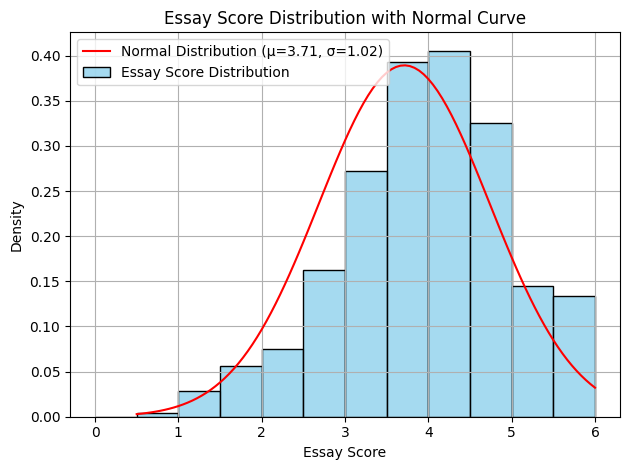

In [94]:
# Load scores 
scores = train_scores_df['score']
# Compute mean and standard deviation
mean = scores.mean()
std = scores.std()

# Create the histogram
sns.histplot(scores, bins=np.arange(0, 6.5, 0.5), kde=False, stat='density', color='skyblue', edgecolor='black', label='Essay Score Distribution')

# Overlay the normal distribution curve
x = np.linspace(scores.min(), scores.max(), 100)
plt.plot(x, norm.pdf(x, mean, std), color='red', label='Normal Distribution (μ=%.2f, σ=%.2f)' % (mean, std))

# Label and show
plt.title('Essay Score Distribution with Normal Curve')
plt.xlabel('Essay Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Data Cleaning**
This execution cell cleans the raw keystroke log data in `train_log_df` and `test_log_df` using `clean_data()`.

When `cfg.train` and `cfg.clean` and `cfg.preprocess` are enabled:

The following cleaning steps are applied to both datasets:
- Label Encoding: Encodes user IDs (id) as numeric values.
- Trimming Margins: Removes unwanted keystroke events at the start and end using configurable first_margin and last_margin.
- Timestamp Normalization: Resets and normalizes event timestamps for consistency across sessions.
- String Cleaning: Cleans key event columns (up_event, down_event, text_change) by fixing character encoding.

In [95]:
def clean_data(log_df):  
    """
    Cleans and preprocesses the raw keystroke log data.

    This function performs a series of standard data cleaning steps, including:
    1. label encoding of user IDs
    2. trimming of keystroke margins
    3. timestamp normalization,
    4. string cleaning for specific columns.

    Parameters
    log_df : pd.DataFrame
        Raw keystroke log dataframe containing columns 'id', 'up_event','down_event', 'text_change', and timestamps.

    Returns
    log_df : pd.DataFrame
        The cleaned keystroke log dataframe. 
    """
    log_df, _ = label_encode(log_df, test_df=None, col="id", replace=False)
    log_df = remove_margin(log_df, cfg.first_margin, cfg.last_margin) 
    log_df = reset_timestamps(log_df) 
    log_df = clean_str_columns(log_df, ['up_event', 'down_event', 'text_change'])
    return log_df

In [96]:
%%time 
if cfg.train: 
    if cfg.preprocess: 
        if cfg.clean: 
            train_log_df=clean_data(train_log_df)
            test_log_df=clean_data(test_log_df)

Remove Irrelevant Logs (per Essay):   0%|          | 0/2471 [00:00<?, ?it/s]

Reset Keystrokes Times to 0:   0%|          | 0/8399722 [00:00<?, ?it/s]

Cleaning string columns:   0%|          | 0/3 [00:00<?, ?it/s]

Remove Irrelevant Logs (per Essay):   0%|          | 0/20 [00:00<?, ?it/s]

Reset Keystrokes Times to 0:   0%|          | 0/60078 [00:00<?, ?it/s]

Cleaning string columns:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 28.5 s, sys: 4.75 s, total: 33.2 s
Wall time: 33.1 s


## **Feature Extraction**
This is the main execution cell that executes the full feature extraction pipeline, transforming the raw keystroke logs `train_log_df` and `test_log_df` into feature-rich datasets: `train_df` and `test_df`. 

When `cfg.train` and `cfg.preprocess` are enabled:
1. Main Dataset (`train_log_df`, `test_log_df`)
   
    `extract_writing_features()` generates all the writing features. 
2. External Dataset (if `cfg.preprocess_ext_train` is `True`)
    
    Loads TF-IDF-enhanced external data, Trains a LightGBM model for each essay_set (24 total) and appends model predictions as additional features to `train_df` and `test_df` as AI-derived score-based features.
3. Saves all process data (`train_df`, `test_df`, logs, and vectorizers) as pickle files for future reuse.

In [97]:
def extract_writing_features(log_df, score_df=None, preprocessors=None, preprocessors_event=None):
    """
    Extracts all keystroke-based and linguistic features from a writing log dataset.

    Parameters: 
    log_df : pd.DataFrame
        The keystroke log data for the main dataset. 
    score_df : pd.DataFrame, optional
        A dataframe containing target scores to be merged for learning tasks.
    preprocessors : dict or None
        Optional dictionary of pre-fitted TF-IDF vectorizers for text features. If None, new vectorizers will be fitted.
    preprocessors_event : dict or None
        Optional dictionary of pre-fitted TF-IDF vectorizers for event-level features. If None, new vectorizers will be fitted.

    Returns:
    df : pd.DataFrame
        A dataframe containing extracted features at the user level (one row per writing session).
    log_df : pd.DataFrame
        The updated log_df with additional reconstructed metadata, if needed downstream.
    preprocessors : dict
        The fitted TF-IDF vectorizers for global text features.
    preprocessors_event : dict
        The fitted TF-IDF vectorizers for event-level features.
    Notes
    - Infinite values are replaced with NaN and subsequently filled with 0 for model readiness.
    """
    res, len_text, sentence_count, paragraph_count = recon_writing(
        df=log_df, use_capslock=True, show_process=False, strict=False) 
    log_df['len_text'] = len_text
    log_df['sentence_count'] = sentence_count
    log_df['paragraph_count'] = paragraph_count

    df = log_df[['id_encode', 'id', 'event_id', 'word_count', 'sentence_count', 'paragraph_count']].sort_values(['id_encode', 'event_id']).drop_duplicates(
        'id_encode', keep='last').reset_index(drop=True)
    df = df.rename(columns={'event_id': 'keystroke_count'})
    df = add_score(df, score_df)
    df['reconstructed'] = res 
    df = add_initial_pause_time(df, log_df)
    df = add_total_time(df, log_df)
    df = add_product_related_features(df)
    df = add_verbosity_count_features(df, log_df)
    df, log_df, input_log_df = add_general_pause_features(df, log_df)
    df = add_pause_counts(df, input_log_df)
    df = add_keystroke_density_features(df, log_df)
    df = add_burst_types_features(df, log_df)
    df = add_deletion_features(df, log_df)
    df = add_edit_features(df, log_df)
    df = add_disruption_features(df, log_df)
    df = add_within_word_features(df, log_df)
    df = add_inter_word_features(df, log_df)
    df = add_inter_sentence_features(df, log_df)
    df = add_inter_paragraph_features(df, log_df)
    df = add_digraph_features(df, log_df)
    df = add_trigraph_features(df, log_df)
    df = add_location_based_revision_features(df, log_df)
    df = add_scale_based_revision_features(df, log_df)
    df = add_local_sentence_level_features(df, log_df)
    df = add_ratio_based_revision_features(df, log_df)
    df = add_window_based_verbosity_features(df, log_df)
    df = add_production_times_features(df, log_df)
    df = add_time_to_word_count_features(df, log_df)
    df = add_cursor_position_count_features(df, log_df)
    df = add_raw_summary_features(df, log_df)
    df, preprocessors = add_tfidf(df, preprocessors) 
    df, preprocessors_event = add_tfidf_act(df, log_df, preprocessors_event)
    
    df = df.replace([np.inf, -np.inf], np.nan) 
    df = df.fillna(0) 
    return df, log_df, preprocessors, preprocessors_event 

In [98]:
def extract_external_dataset_features(
    train_df,
    test_df,
    ext_df,
    preprocessors,
    cfg,
    params,
    ext_feats,
    preprocessors_event
):
    """
    Trains LightGBM models using TF-IDF features from an external dataset and 
    generates prediction-based features for the main training and test sets.

    For each essay set in the external dataset, a separate LightGBM model is trained 
    using TF-IDF features. These models are then used to generate prediction scores 
    for the main training and test sets, which are added as new features.
    
    Parameters:
    train_df : pd.DataFrame
        Main training dataset where new prediction-based features will be added.
    test_df : pd.DataFrame
        Main test dataset where new prediction-based features will be added.
    ext_df : pd.DataFrame
        External dataset with 'essay_set' and target scores.
    preprocessors : dict or None
        TF-IDF vectorizers for the main text features.
    cfg : dict-like
        Configuration object with flags, paths, and runtime options.
    params : dict
        LightGBM model parameters.
    ext_feats : list of str
        List of TF-IDF feature column names.
    preprocessors_event : dict or None
        TF-IDF vectorizers for event-level features.
    Returns
    train_df : pd.DataFrame
        Training set with appended score-based prediction features.
    test_df : pd.DataFrame
        Test set with appended score-based prediction features.
    preprocessors : dict
        Fitted TF-IDF vectorizers for main text features.
    preprocessors_event : dict
        TF-IDF vectorizers for event-level features (unchanged).
    """
    # Load external dataset 
    ext_df_path = f"{cfg.mydata_dir}ext_df.pickle"
    ext_df=pickle_load(ext_df_path)            
    # Compute TF-IDF features         
    ext_df, preprocessors=add_tfidf(ext_df, preprocessors)
    # Define external model directory
    ext_model_dir=f"{cfg.out_dir}ext_model/"
    rmdir_if_exist(ext_model_dir)  # Remove old models if retraining
    # Train model for each essay set (24 total)
    for essay_set in tqdm(range(24)):
        ext_df_=ext_df[ext_df.essay_set==essay_set].reset_index(drop=True) # Filter external dataframe for each essay_set
        # Enable data augmentation 
        cfg.augment=True 
        # Set mode to regression 
        cfg.is_classification=False 
        # Train a LightGBM (LGB) model
        ext_df_, metric = train_model(
            ext_df_, 
            ext_feats, 
            target_col='score', 
            mode='lgb', 
            nbags=cfg.nbags, 
            nfolds = cfg.nfolds, 
            show_fig=False, 
            model_dir=ext_model_dir, 
            params=params,cfg=cfg, 
            suffix=f"_ext_{essay_set}")
        # Perform inference on training and test data 
        train_df=infer_model(train_df, ext_feats, target_col='score', mode='lgb', nbags=cfg.nbags, nfolds = cfg.nfolds, model_dir=ext_model_dir, cfg=cfg, suffix=f"_ext_{essay_set}")
        test_df=infer_model(test_df, ext_feats, target_col='score', mode='lgb', nbags=cfg.nbags, nfolds = cfg.nfolds, model_dir=ext_model_dir, cfg=cfg, suffix=f"_ext_{essay_set}")
        # Display Scatter Plot of score vs predicted score on training set 
        scatter_col([train_df], col1=f"score_lgb_pred_ext_{essay_set}", col2='score', is_cudf=False, alpha=0.3)
    return train_df, test_df, preprocessors, preprocessors_event

Reconstruct Text from Keystrokes (per Essay):   0%|          | 0/8399722 [00:00<?, ?it/s]

Initial Pause Time (per Essay):   0%|          | 0/1 [00:00<?, ?it/s]

Total Time (per Essay):   0%|          | 0/1 [00:00<?, ?it/s]

Product Features (per Essay):   0%|          | 0/2471 [00:00<?, ?it/s]

Raw Verbosity Features:   0%|          | 0/4 [00:00<?, ?it/s]

General Pause Features (4 Latencies):   0%|          | 0/4 [00:00<?, ?it/s]

Count Pauses for Essay (per Bin):   0%|          | 0/11 [00:00<?, ?it/s]

Structural Keystroke Density Features:   0%|          | 0/6 [00:00<?, ?it/s]

Get All Burst Types (per Essay):   0%|          | 0/2471 [00:00<?, ?it/s]

Burst Metrics (for All Burst):   0%|          | 0/4 [00:00<?, ?it/s]

Burst Metrics (per Burst Type):   0%|          | 0/11 [00:00<?, ?it/s]

Deletion Features:   0%|          | 0/3 [00:00<?, ?it/s]

Edit Features:   0%|          | 0/3 [00:00<?, ?it/s]

Disruption Features:   0%|          | 0/3 [00:00<?, ?it/s]

Within-Word Pause Features:   0%|          | 0/2 [00:00<?, ?it/s]

Inter-word Features:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Word Boundaries:   0%|          | 0/6 [00:00<?, ?it/s]

Inter-sentence Features:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Sentence Boundaries:   0%|          | 0/8 [00:00<?, ?it/s]

Inter-Paragraph Features:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Paragraph Boundaries:   0%|          | 0/10 [00:00<?, ?it/s]

Digraph Features:   0%|          | 0/2 [00:00<?, ?it/s]

Trigraph Features:   0%|          | 0/2 [00:00<?, ?it/s]

Location-Based Revision Features:   0%|          | 0/4 [00:00<?, ?it/s]

Scale-Based Revision Features:   0%|          | 0/7 [00:00<?, ?it/s]

Local Sentence-Level Features:   0%|          | 0/3 [00:00<?, ?it/s]

Ratio-based Revision Features:   0%|          | 0/3 [00:00<?, ?it/s]

Window-Based Verbosity Features (per Essay):   0%|          | 0/2471 [00:00<?, ?it/s]

Production Times:   0%|          | 0/2 [00:00<?, ?it/s]

Counting Cursor Position Frequencies (per Essay):   0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Reconstruct Text from Keystrokes (per Essay):   0%|          | 0/60078 [00:00<?, ?it/s]

Initial Pause Time (per Essay):   0%|          | 0/1 [00:00<?, ?it/s]

Total Time (per Essay):   0%|          | 0/1 [00:00<?, ?it/s]

Product Features (per Essay):   0%|          | 0/20 [00:00<?, ?it/s]

Raw Verbosity Features:   0%|          | 0/4 [00:00<?, ?it/s]

General Pause Features (4 Latencies):   0%|          | 0/4 [00:00<?, ?it/s]

Count Pauses for Essay (per Bin):   0%|          | 0/11 [00:00<?, ?it/s]

Structural Keystroke Density Features:   0%|          | 0/6 [00:00<?, ?it/s]

Get All Burst Types (per Essay):   0%|          | 0/20 [00:00<?, ?it/s]

Burst Metrics (for All Burst):   0%|          | 0/4 [00:00<?, ?it/s]

Burst Metrics (per Burst Type):   0%|          | 0/11 [00:00<?, ?it/s]

Deletion Features:   0%|          | 0/3 [00:00<?, ?it/s]

Edit Features:   0%|          | 0/3 [00:00<?, ?it/s]

Disruption Features:   0%|          | 0/3 [00:00<?, ?it/s]

Within-Word Pause Features:   0%|          | 0/2 [00:00<?, ?it/s]

Inter-word Features:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Word Boundaries:   0%|          | 0/6 [00:00<?, ?it/s]

Inter-sentence Features:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Sentence Boundaries:   0%|          | 0/8 [00:00<?, ?it/s]

Inter-Paragraph Features:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Paragraph Boundaries:   0%|          | 0/10 [00:00<?, ?it/s]

Digraph Features:   0%|          | 0/2 [00:00<?, ?it/s]

Trigraph Features:   0%|          | 0/2 [00:00<?, ?it/s]

Location-Based Revision Features:   0%|          | 0/4 [00:00<?, ?it/s]

Scale-Based Revision Features:   0%|          | 0/7 [00:00<?, ?it/s]

Local Sentence-Level Features:   0%|          | 0/3 [00:00<?, ?it/s]

Ratio-based Revision Features:   0%|          | 0/3 [00:00<?, ?it/s]

Window-Based Verbosity Features (per Essay):   0%|          | 0/20 [00:00<?, ?it/s]

Production Times:   0%|          | 0/2 [00:00<?, ?it/s]

Counting Cursor Position Frequencies (per Essay):   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

val_metric: 0.4606715175558955, 2 minutes
oof_metric: 0.45811573088802
oof_metric_round: 0.4828170996450933


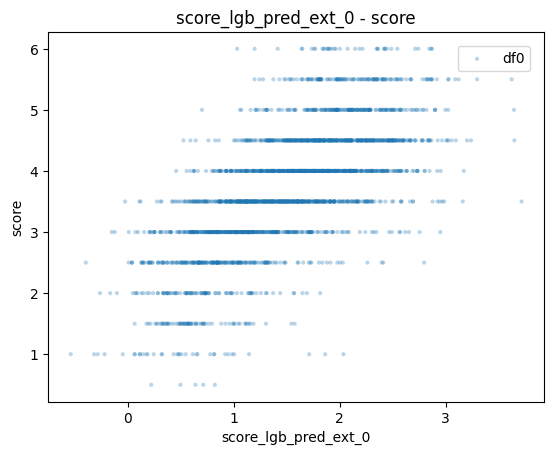

val_metric: 0.865878535032825, 48 seconds
oof_metric: 0.859599000635822
oof_metric_round: 0.867077142249367


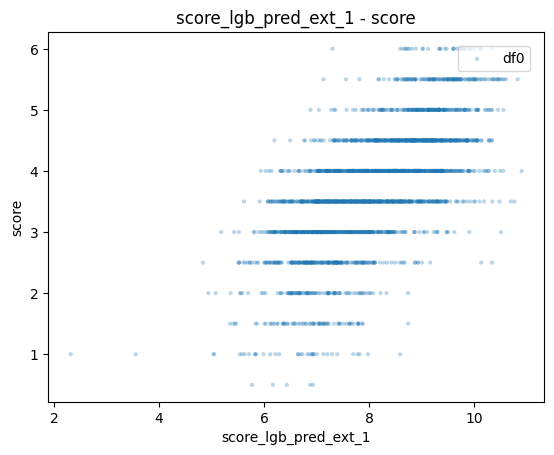

val_metric: 0.5159695519445611, 35 seconds
oof_metric: 0.5137482009119376
oof_metric_round: 0.5367080729368207


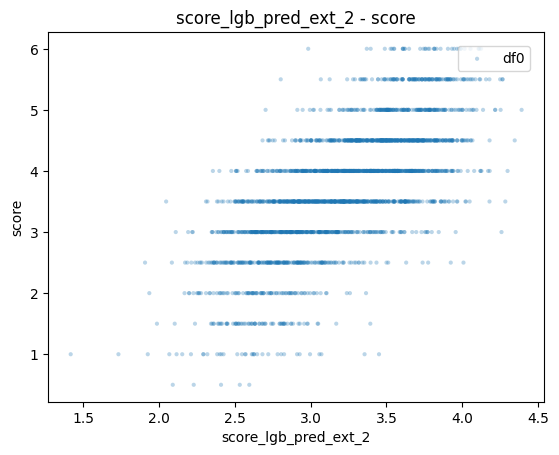

val_metric: 0.5953764364543137, 38 seconds
oof_metric: 0.5922816839455715
oof_metric_round: 0.6139079461908699


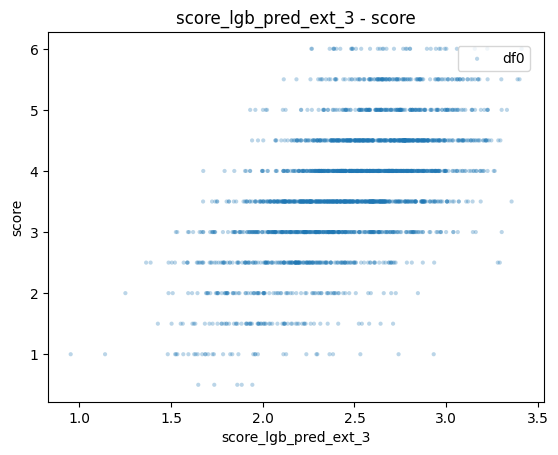

val_metric: 0.6346205352182868, 41 seconds
oof_metric: 0.6309159107612834
oof_metric_round: 0.6471716687488481


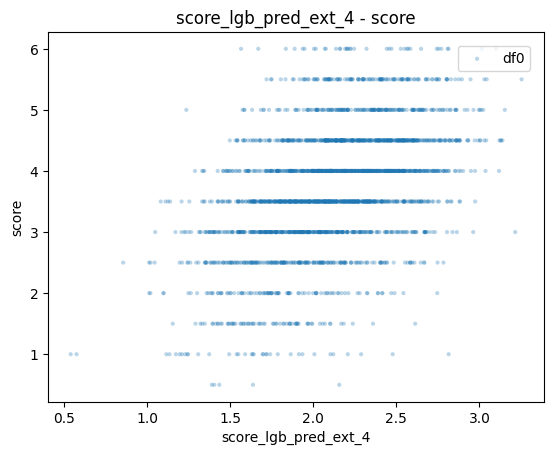

val_metric: 0.576689218959921, 53 seconds
oof_metric: 0.5723912063433086
oof_metric_round: 0.5879680018429028


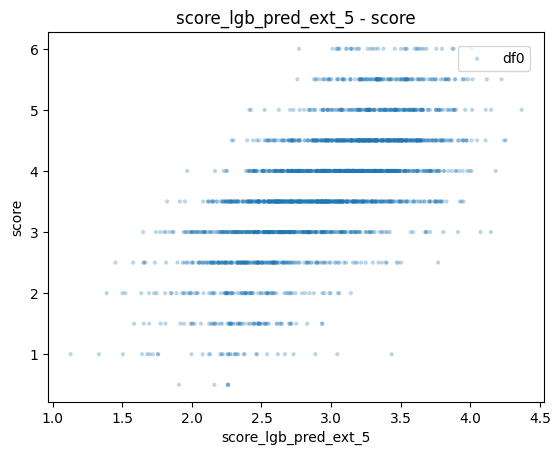

val_metric: 0.6675749193587082, 53 seconds
oof_metric: 0.6626665354887268
oof_metric_round: 0.6775158874725948


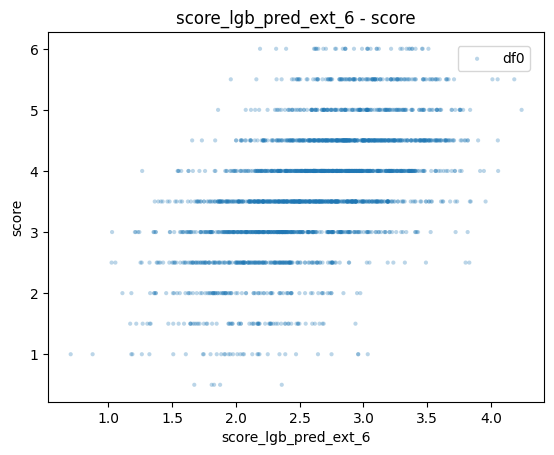

val_metric: 2.9318849023281888, 37 seconds
oof_metric: 2.9139137842442024
oof_metric_round: 2.9144920419058784


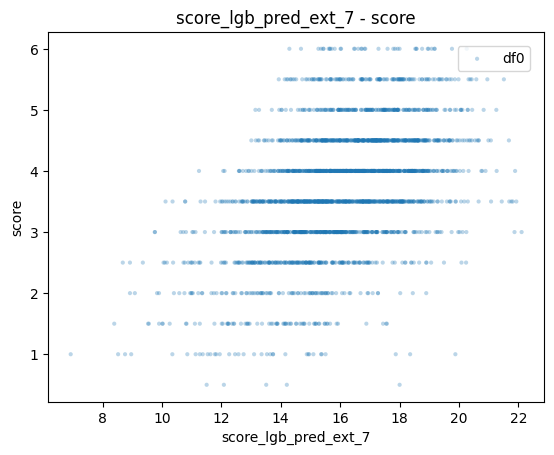

val_metric: 3.9952565471617025, 28 seconds
oof_metric: 3.9712833373283876
oof_metric_round: 3.9653146922502103


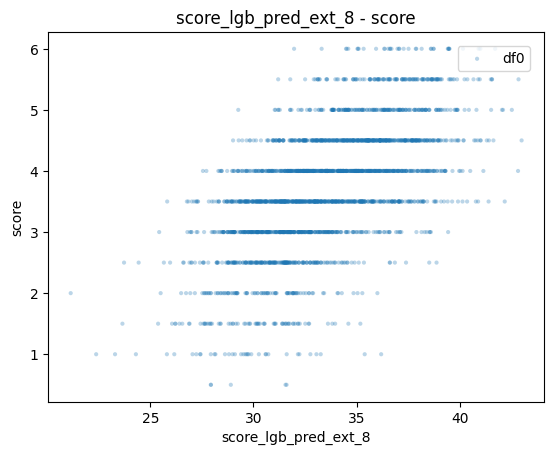

val_metric: 0.929977529924397, 38 seconds
oof_metric: 0.9249083001017745
oof_metric_round: 0.9338945823320162


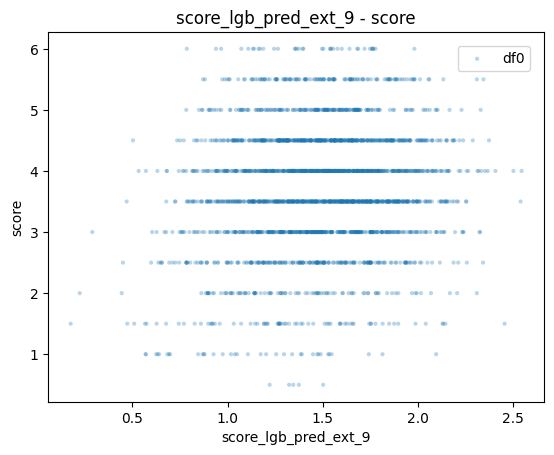

val_metric: 0.8719116664558704, 33 seconds
oof_metric: 0.866773716668621
oof_metric_round: 0.8798073839561985


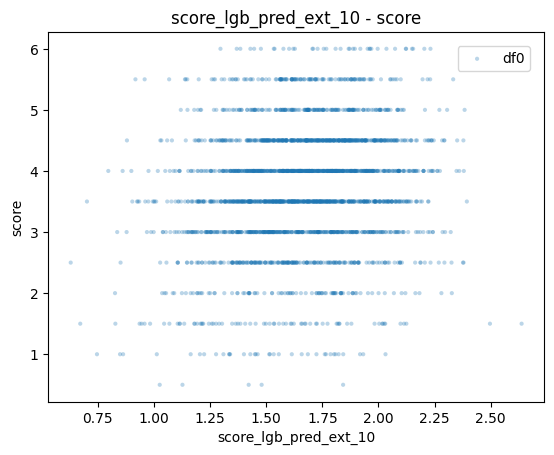

val_metric: 0.5827781930142483, 37 seconds
oof_metric: 0.579811817794709
oof_metric_round: 0.594731664040506


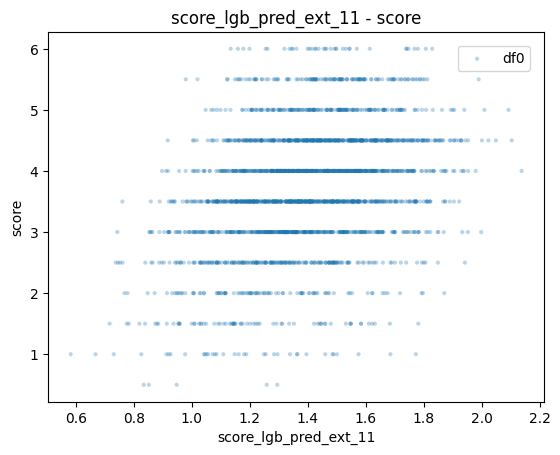

val_metric: 0.5140451813797193, 50 seconds
oof_metric: 0.5103667362191416
oof_metric_round: 0.5325834599596301


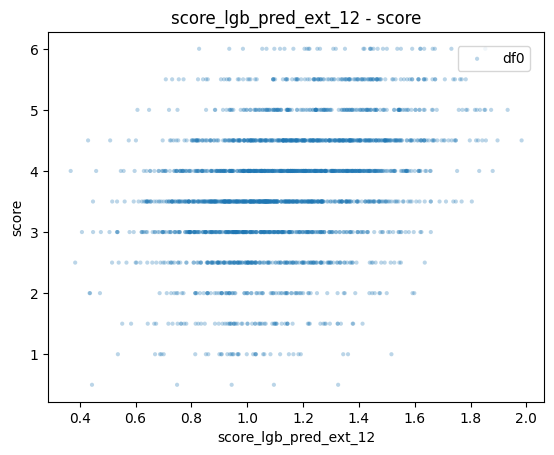

val_metric: 0.4754307192511519, 46 seconds
oof_metric: 0.47232281373479984
oof_metric_round: 0.4915724301046563


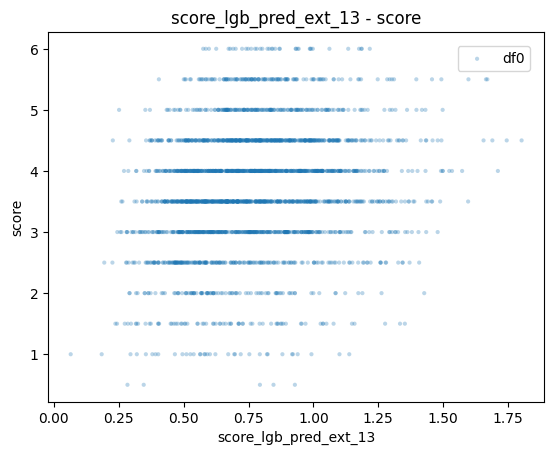

val_metric: 0.5232538971493159, 45 seconds
oof_metric: 0.519297648607889
oof_metric_round: 0.5284083259483641


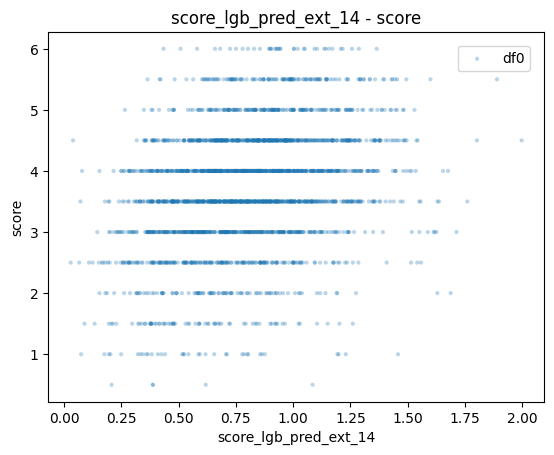

val_metric: 0.7717861477272978, 31 seconds
oof_metric: 0.7686428317285839
oof_metric_round: 0.780174008896647


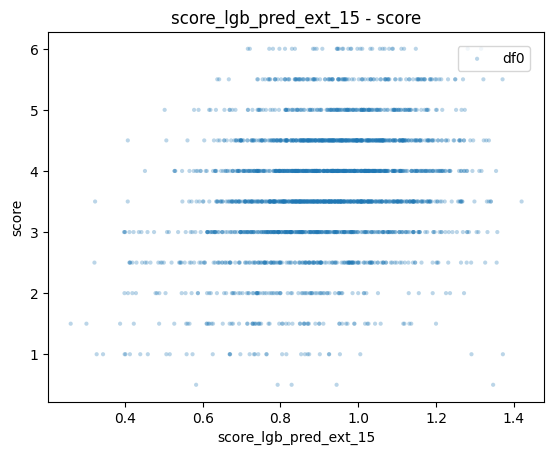

val_metric: 0.7306939994841646, 26 seconds
oof_metric: 0.728535110828029
oof_metric_round: 0.7381639708115912


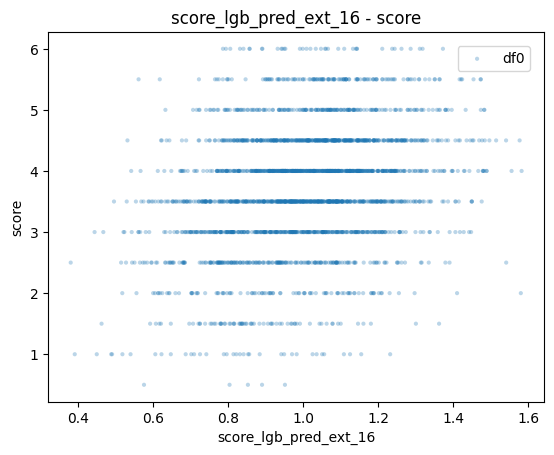

val_metric: 0.5627018471487385, 40 seconds
oof_metric: 0.5599141861752958
oof_metric_round: 0.588875363339635


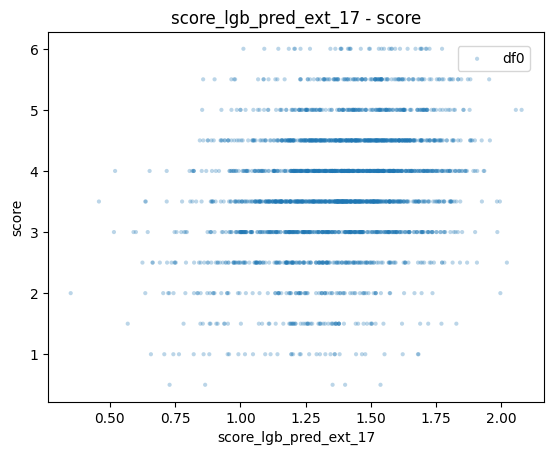

val_metric: 0.5574298099752042, 33 seconds
oof_metric: 0.5548765770141744
oof_metric_round: 0.5793709793451145


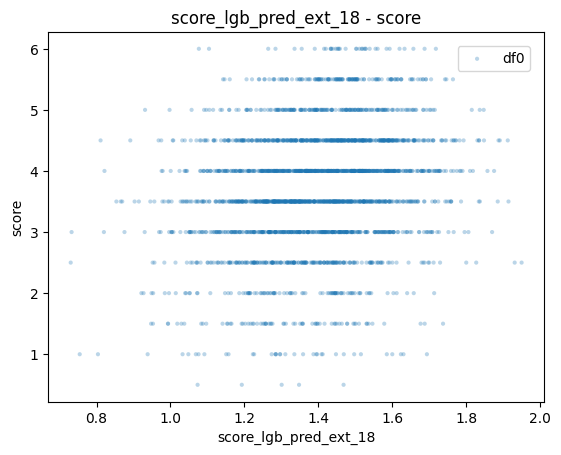

val_metric: 1.5478609030488382, a minute
oof_metric: 1.5073320752427866
oof_metric_round: 1.5165225894562897


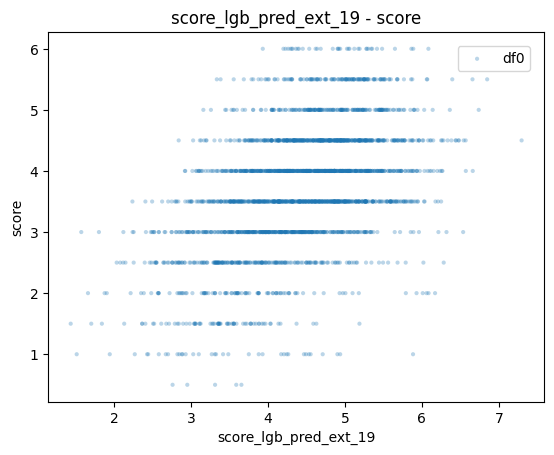

val_metric: 1.552082331366026, a minute
oof_metric: 1.5140446480351126
oof_metric_round: 1.5175197666054359


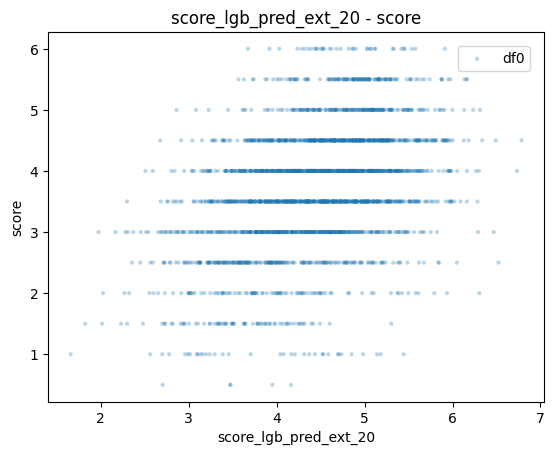

val_metric: 2.7007642368213443, 59 seconds
oof_metric: 2.6909901403124787
oof_metric_round: 2.6912882551881028


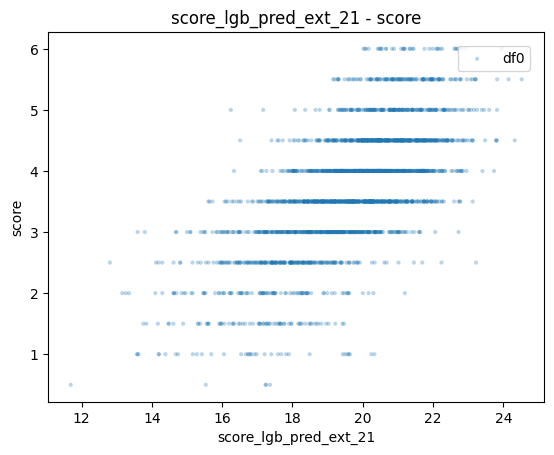

val_metric: 0.8777490923844778, 56 seconds
oof_metric: 0.8663900733045595
oof_metric_round: 0.8788058099306947


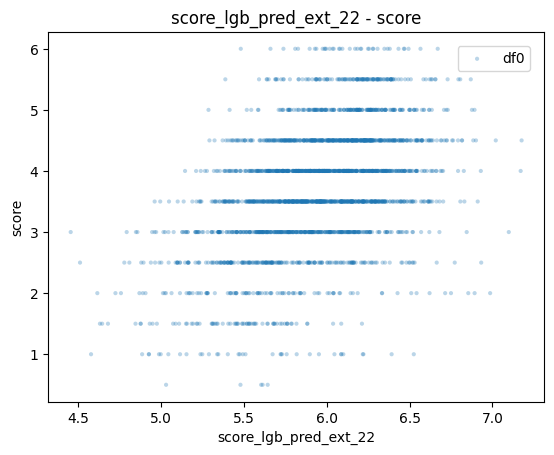

val_metric: 0.6606136643238575, 14 minutes
oof_metric: 0.6578819488644246
oof_metric_round: 0.6729187652040765


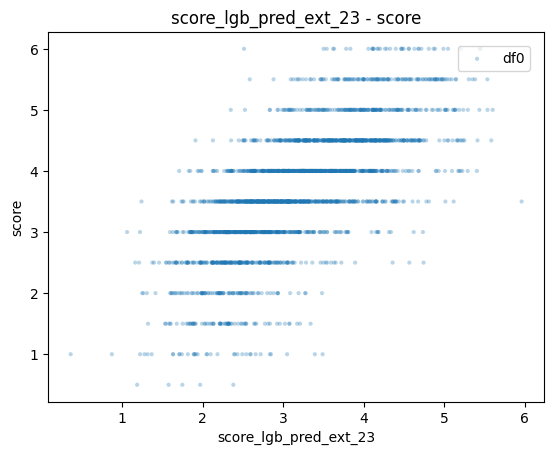

Save Preprocessed Data
CPU times: user 2h 19min 52s, sys: 3min 5s, total: 2h 22min 58s
Wall time: 1h 38min 28s


In [ ]:
%%time
warnings.filterwarnings('ignore', message='.*which has poor performance', ) # Suppresses performance warnings 
if cfg.train:
    if cfg.preprocess:
        # Extract writing features from the training and test datasets 
        train_df, train_log_df, preprocessors, preprocessors_event= extract_writing_features(train_log_df, score_df=train_scores_df, preprocessors=None, preprocessors_event=None)
        test_df, test_log_df, _, _= extract_writing_features(test_log_df, score_df=None, preprocessors=preprocessors, preprocessors_event=preprocessors_event)

        # Extract score features from the external dataset 
        if cfg.preprocess_ext_train: 
            ext_feats=[f'tfidf_{n}' for n in range(64)] # # Define 64 TF-IDF (text-based features)
            ext_df_path = f"{cfg.mydata_dir}ext_df.pickle"
            ext_df = pickle_load(ext_df_path)
            train_df, test_df, preprocessors, preprocessors_event = extract_external_dataset_features(
                train_df,
                test_df,
                ext_df,
                preprocessors,
                cfg,
                params,
                ext_feats,
                preprocessors_event
            )
            # Save the main dataset, feature set and preprocessors to file
            print('Save Preprocessed Data')
            train_log_df_path = f"{cfg.out_dir}train_log_df_preprocessed.pickle"
            pickle_dump(train_log_df, train_log_df_path)
            test_log_df_path = f"{cfg.out_dir}test_log_df_preprocessed.pickle"
            pickle_dump(test_log_df, test_log_df_path)
            train_df_path = f"{cfg.out_dir}train_df_preprocessed.pickle"
            pickle_dump(train_df, train_df_path)
            test_df_path = f"{cfg.out_dir}test_df_preprocessed.pickle"
            pickle_dump(test_df, test_df_path)
            preprocessors_path = f"{cfg.out_dir}preprocessors.pickle"
            pickle_dump(preprocessors, preprocessors_path)
            preprocessors_event_path = f"{cfg.out_dir}preprocessors_event.pickle"
            pickle_dump(preprocessors_event, preprocessors_event_path)

# Load results directly if training is disabled 
else:
    # Extract writing features on test data
    test_df,test_log_df,_,_=extract_writing_features(test_log_df, score_df=None,preprocessors=preprocessors,preprocessors_event=preprocessors_event) 
    # Extract score features on test datasets
    for essay_set in tqdm(range(24)):
        ext_model_dir=f"{cfg.mydata_dir}ext_model/"
        test_df=infer_model(test_df, ext_feats, target_col='score', mode='lgb', nbags=cfg.nbags, nfolds = cfg.nfolds, model_dir=ext_model_dir, cfg=cfg, suffix=f"_ext_{essay_set}")

In [100]:
display(train_df.describe())
display(train_df.head())
display(test_df.describe())
display(test_df.head())

id_encode  keystroke_count  word_count  sentence_count  \
count 2,471.00000      2,471.00000 2,471.00000     2,471.00000   
mean  1,235.00000      3,398.32092   386.11210        21.44233   
std     713.46058      1,576.27341   171.77339         9.73224   
min       0.00000        261.00000    35.00000         1.00000   
25%     617.50000      2,192.50000   250.00000        15.00000   
50%   1,235.00000      3,080.00000   346.00000        20.00000   
75%   1,852.50000      4,292.00000   477.00000        26.00000   
max   2,470.00000     12,875.00000 1,326.00000        76.00000   

       paragraph_count  score_0.5_order  score_1.0_order  score_1.5_order  \
count      2,471.00000      2,471.00000      2,471.00000      2,471.00000   
mean           4.50911          0.99798          0.98381          0.95589   
std            1.90923          0.04495          0.12622          0.20538   
min            1.00000          0.00000          0.00000          0.00000   
25%            3.00000          1.00000          1.00000          1.00000   
50%            4.00000          1.00000          1.00000          1.00000   
75%            5.00000          1.00000          1.00000          1.00000   
max           23.00000          1.00000          1.00000          1.00000   

       score_2.0_order  score_2.5_order  ...  score_lgb_pred_ext_14  \
count      2,471.00000      2,471.00000  ...            2,471.00000   
mean           0.91866          0.83731  ...                0.80260   
std            0.27342          0.36915  ...                0.29349   
min            0.00000          0.00000  ...                0.02939   
25%            1.00000          1.00000  ...                0.59549   
50%            1.00000          1.00000  ...                0.79574   
75%            1.00000          1.00000  ...                0.99163   
max            1.00000          1.00000  ...                1.99725   

       score_lgb_pred_ext_15  score_lgb_pred_ext_16  score_lgb_pred_ext_17  \
count            2,471.00000            2,471.00000            2,471.00000   
mean                 0.91279                1.00090                1.37158   
std                  0.17580                0.18890                0.24637   
min                  0.26073                0.37941                0.34975   
25%                  0.80012                0.87513                1.21378   
50%                  0.91928                1.00733                1.38763   
75%                  1.03011                1.12320                1.54078   
max                  1.41975                1.58164                2.07723   

       score_lgb_pred_ext_18  score_lgb_pred_ext_19  score_lgb_pred_ext_20  \
count            2,471.00000            2,471.00000            2,471.00000   
mean                 1.39335                4.41584                4.43116   
std                  0.17829                0.83691                0.75851   
min                  0.73018                1.43905                1.65793   
25%                  1.27764                3.87292                3.92291   
50%                  1.39992                4.46503                4.49090   
75%                  1.51283                4.99215                4.97224   
max                  1.94944                7.29444                6.78537   

       score_lgb_pred_ext_21  score_lgb_pred_ext_22  score_lgb_pred_ext_23  
count            2,471.00000            2,471.00000            2,471.00000  
mean                19.63783                5.93748                3.19806  
std                  1.80298                0.38485                0.83523  
min                 11.68566                4.45315                0.35975  
25%                 18.53094                5.69556                2.57847  
50%                 19.87442                5.95786                3.13605  
75%                 20.89207                6.20963                3.79252  
max                 24.52254                7.17648      

id_encode        id  keystroke_count  word_count  sentence_count  \
0          0  001519c8             2556         255              14   
1          1  0022f953             2453         320              15   
2          2  0042269b             4135         404              19   
3          3  0059420b             1555         206              13   
4          4  0075873a             2530         252              16   

   paragraph_count  score_0.5_order  score_1.0_order  score_1.5_order  \
0                3                1                1                1   
1                6                1                1                1   
2                6                1                1                1   
3                3                1                1                1   
4                5                1                1                1   

   score_2.0_order  ...  score_lgb_pred_ext_14  score_lgb_pred_ext_15  \
0                1  ...                0.62980                1.00933   
1                1  ...                0.45368                0.84899   
2                1  ...                1.17162                1.00532   
3                0  ...                1.68754                1.01500   
4                1  ...                0.35980                0.92024   

   score_lgb_pred_ext_16  score_lgb_pred_ext_17  score_lgb_pred_ext_18  \
0                0.74014                1.58645                1.45669   
1                0.83033                1.07605                1.65493   
2                1.21010                1.49259                1.51128   
3                1.18170                1.25445                1.35615   
4                1.09571                1.54179                1.44998   

   score_lgb_pred_ext_19  score_lgb_pred_ext_20  score_lgb_pred_ext_21  \
0                4.65730                4.83134               20.78201   
1                5.25373                4.95516               17.73322   
2                5.35423                5.03544               20.50200   
3                3.17258                3.32014               17.66940   
4                4.36070                4.00584               19.17556   

   score_lgb_pred_ext_22  score_lgb_pred_ext_23  
0                6.08965                2.83342  
1                6.11319                2.01969  
2                6.30635                3.53956  
3                5.51554                2.46514  
4                5.69490                3.10656  

[5 rows x 1254 columns]

id_encode  keystroke_count  word_count  sentence_count  \
count   20.00000         20.00000    20.00000        20.00000   
mean     9.50000      3,002.90000   346.10000        19.40000   
std      5.91608      1,421.23741   142.90332         6.09054   
min      0.00000      1,555.00000   206.00000        10.00000   
25%      4.75000      2,186.50000   249.25000        15.00000   
50%      9.50000      2,543.00000   287.00000        20.00000   
75%     14.25000      3,513.75000   404.50000        22.00000   
max     19.00000      7,825.00000   739.00000        38.00000   

       paragraph_count  score_0.5_order  score_1.0_order  score_1.5_order  \
count         20.00000         20.00000         20.00000         20.00000   
mean           5.10000          0.00000          0.00000          0.00000   
std            3.53777          0.00000          0.00000          0.00000   
min            3.00000          0.00000          0.00000          0.00000   
25%            3.00000          0.00000          0.00000          0.00000   
50%            4.00000          0.00000          0.00000          0.00000   
75%            5.25000          0.00000          0.00000          0.00000   
max           19.00000          0.00000          0.00000          0.00000   

       score_2.0_order  score_2.5_order  ...  score_lgb_pred_ext_14  \
count         20.00000         20.00000  ...               20.00000   
mean           0.00000          0.00000  ...                0.75193   
std            0.00000          0.00000  ...                0.36591   
min            0.00000          0.00000  ...                0.19211   
25%            0.00000          0.00000  ...                0.44711   
50%            0.00000          0.00000  ...                0.70021   
75%            0.00000          0.00000  ...                0.95931   
max            0.00000          0.00000  ...                1.68754   

       score_lgb_pred_ext_15  score_lgb_pred_ext_16  score_lgb_pred_ext_17  \
count               20.00000               20.00000               20.00000   
mean                 0.93612                0.95094                1.30342   
std                  0.21077                0.20613                0.24886   
min                  0.48595                0.54074                0.69123   
25%                  0.84319                0.81399                1.14898   
50%                  0.98524                0.96025                1.30631   
75%                  1.02617                1.11292                1.45073   
max                  1.26383                1.23067                1.74769   

       score_lgb_pred_ext_18  score_lgb_pred_ext_19  score_lgb_pred_ext_20  \
count               20.00000               20.00000               20.00000   
mean                 1.42365                4.55213                4.45307   
std                  0.12461                0.87731                0.55976   
min                  1.22409                3.17258                3.32014   
25%                  1.34333                4.06664                3.99311   
50%                  1.39267                4.49785                4.59861   
75%                  1.49650                5.27886                4.86229   
max                  1.70389                6.23538                5.15203   

       score_lgb_pred_ext_21  score_lgb_pred_ext_22  score_lgb_pred_ext_23  
count               20.00000               20.00000               20.00000  
mean                19.51796                5.94386                3.04808  
std                  1.19942                0.26689                0.75038  
min                 17.66940                5.49105                2.01969  
25%                 18.20776                5.74606                2.46205  
50%                 20.12548                5.91810                2.82990  
75%                 20.50386                6.16048                3.62812  
max                 20.86520                6.35789              

id_encode        id  keystroke_count  word_count  sentence_count  \
0          0  001519c8             2556         255              14   
1          1  0022f953             2453         320              15   
2          2  0042269b             4135         404              19   
3          3  0059420b             1555         206              13   
4          4  0075873a             2530         252              16   

   paragraph_count  score_0.5_order  score_1.0_order  score_1.5_order  \
0                3                0                0                0   
1                6                0                0                0   
2                6                0                0                0   
3                3                0                0                0   
4                5                0                0                0   

   score_2.0_order  ...  score_lgb_pred_ext_14  score_lgb_pred_ext_15  \
0                0  ...                0.62980                1.00933   
1                0  ...                0.45368                0.84899   
2                0  ...                1.17162                1.00532   
3                0  ...                1.68754                1.01500   
4                0  ...                0.35980                0.92024   

   score_lgb_pred_ext_16  score_lgb_pred_ext_17  score_lgb_pred_ext_18  \
0                0.74014                1.58645                1.45669   
1                0.83033                1.07605                1.65493   
2                1.21010                1.49259                1.51128   
3                1.18170                1.25445                1.35615   
4                1.09571                1.54179                1.44998   

   score_lgb_pred_ext_19  score_lgb_pred_ext_20  score_lgb_pred_ext_21  \
0                4.65730                4.83134               20.78201   
1                5.25373                4.95516               17.73322   
2                5.35423                5.03544               20.50200   
3                3.17258                3.32014               17.66940   
4                4.36070                4.00584               19.17556   

   score_lgb_pred_ext_22  score_lgb_pred_ext_23  
0                6.08965                2.83342  
1                6.11319                2.01969  
2                6.30635                3.53956  
3                5.51554                2.46514  
4                5.69490                3.10656  

[5 rows x 1253 columns]

## **Feature Reduction**
This execution cell applies unsupervised and supervised feature filtering to reduce dimensionality and remove redundancy from the feature space in `train_df`.

When executed, the `reduce_features()` function performs the following steps:

### Unsupervised Filtering
1. Removes non-feature columns such as metadata (`id`, scores, etc.).
2. Eliminates constant features with zero variance.
3. Filters near-constant features where one value dominates across samples.
4. Drops low-variance features below a configurable threshold.

### Supervised Filtering (based on score correlation)
5. Removes perfectly correlated features (correlation = 1.0), retaining the top `n` most predictive features based on correlation with the target score.
6. Removes highly correlated features (e.g., correlation > 0.999), again using score correlation to keep only the most informative ones.

All filtering decisions are logged, and correlation matrices are saved to disk for inspection.


In [ ]:
%%time 
features, features_removed = reduce_features(
                                train_df, 
                                corr_threshold_strict=cfg.corr_strict_threshold, 
                                corr_threshold_soft=cfg.corr_soft_threshold, 
                                variance_thresh=cfg.feature_variance_thresh,
                                near_constant_buffer=cfg.near_constant_buffer,
                                save_path=f'{cfg.out_dir}{cfg.run_name}/',
                                top_n_keep=cfg.high_corr_feat_keep_top_n)

## **Feature Scaling & Normalization**

This section does the following with `scale_features()`:
- Scaling numerical features with appropriate strategies  
- Clipping extreme values to reduce outlier effects

In [102]:
def scale_features(train_df, test_df, feats, clip_value=10):
    """
    Applies appropriate scaling or clipping to numeric features based on distribution, outliers, and test set size.

    Parameters:
        train_df (pd.DataFrame): Training dataset.
        test_df (pd.DataFrame): Test dataset.
        feats (list): List of selected feature names (excluding TF-IDF).
        clip_value (float): Threshold to clip extreme values (default: 10).

    Returns:
        train_df (pd.DataFrame): Scaled training dataset.
        test_df (pd.DataFrame): Scaled test dataset.
        encoders (dict): Dictionary of fitted scalers used per feature.
    """

    # Decide whether to include test set in scaler fitting (depends on size)
    concat_test = len(test_df) >= 30

    encoders = {}  # Dictionary to hold fitted scalers

    for col in [f for f in feats if 'tfidf' not in f]:  # Skip TF-IDF features
        n_unique = len(train_df[col].unique())

        # Case 1: Continuous feature → use Uniform Scaling
        if n_unique > 50:
            train_df, test_df, encoder = scale_col(
                train_df,
                test_df,
                col=col,
                mode='quantile_uniform',
                with_centering=True,
                with_scaling=True,
                replace=True,
                rm_zero=False,
                fit_unique=False,
                concat_test=concat_test,
            )
            encoders[col] = encoder

        # Case 2: Training set has extreme values → use Robust Scaling + Clipping
        elif (train_df[col].min() < -clip_value) or (train_df[col].max() > clip_value):
            train_df, test_df, encoder = scale_col(
                train_df,
                test_df,
                col=col,
                mode='robust',
                with_centering=True,
                with_scaling=True,
                replace=True,
                rm_zero=False,
                fit_unique=False,
                concat_test=concat_test,
            )
            encoders[col] = encoder
            # Clip outliers after scaling
            train_df[col] = np.clip(train_df[col], -clip_value, clip_value)
            test_df[col] = np.clip(test_df[col], -clip_value, clip_value)

        # Case 3: Test set only has extreme values → just clip
        elif (test_df[col].min() < -clip_value) or (test_df[col].max() > clip_value):
            test_df[col] = np.clip(test_df[col], -clip_value, clip_value)

    return train_df, test_df, encoders


In [103]:
%%time
if cfg.scale_feats: 
    train_df, test_df, encoders = scale_features(
                                    train_df, 
                                    test_df, 
                                    features, 
                                    cfg.clip_value)

CPU times: user 9.45 s, sys: 5.95 ms, total: 9.46 s
Wall time: 9.45 s


## **Model Training**

In [104]:
mode = "lgb" # Model type (LightGBM)

Training Model :
Best model → Bag 5, Fold 4 with RMSE: 0.5637
LightGBM SHAP Summary Bar (Top 30)


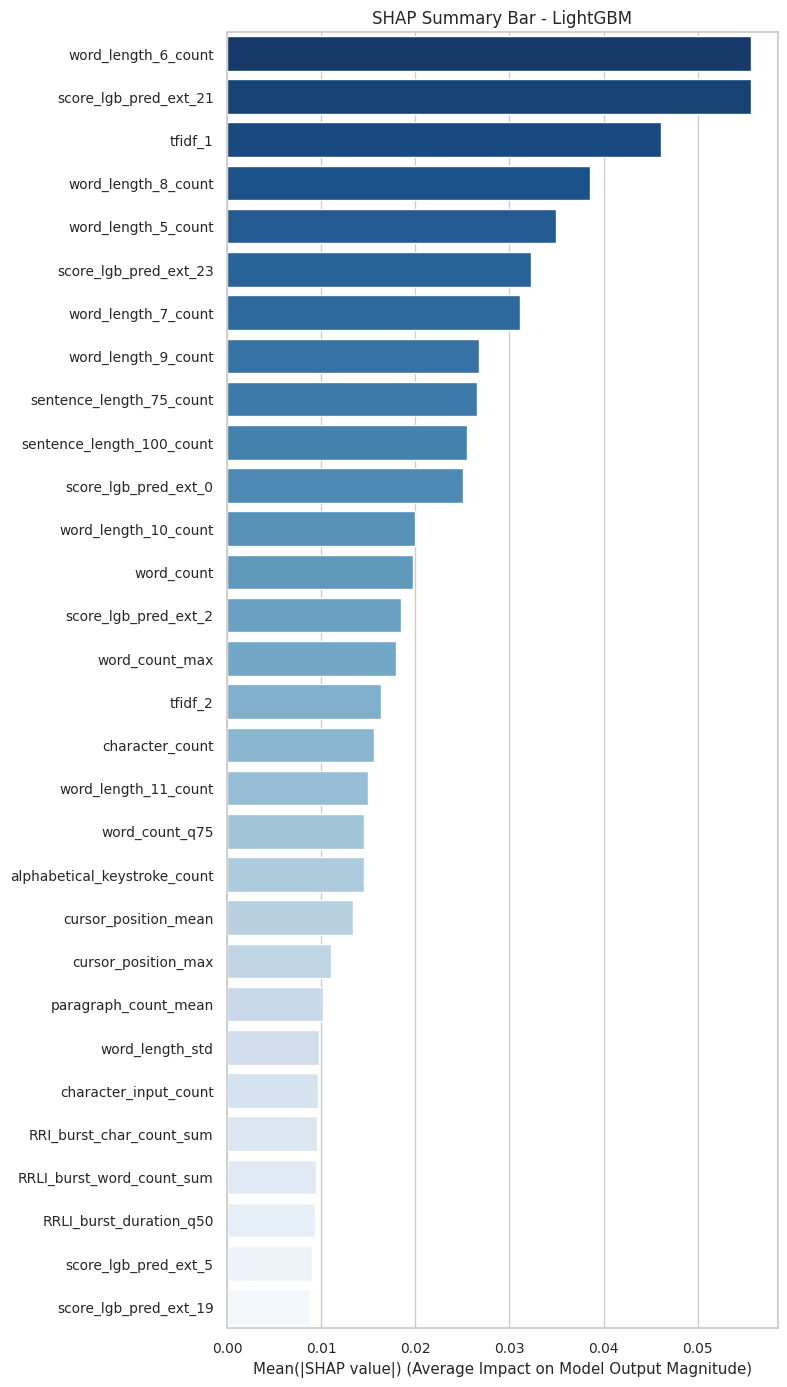

LightGBM SHAP Beeswarm Plot (Top 30)


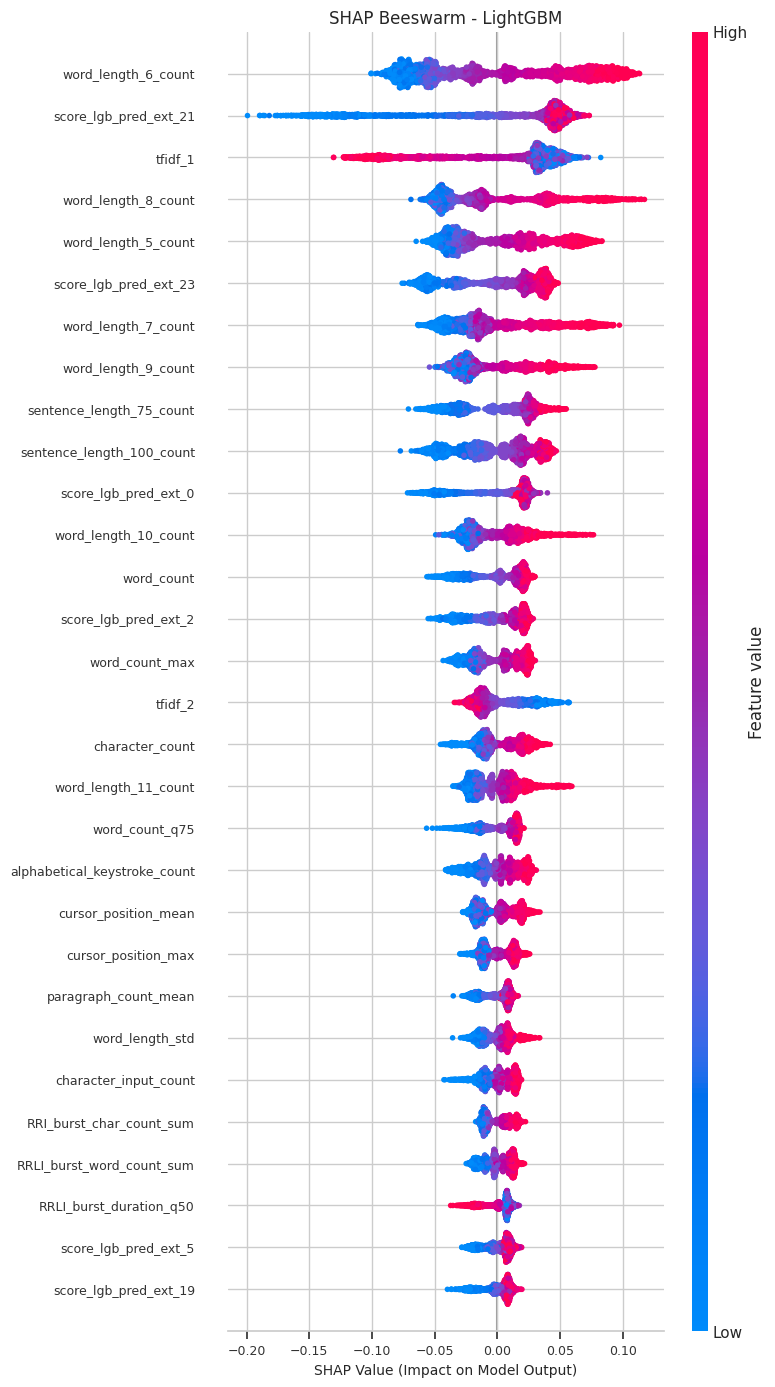

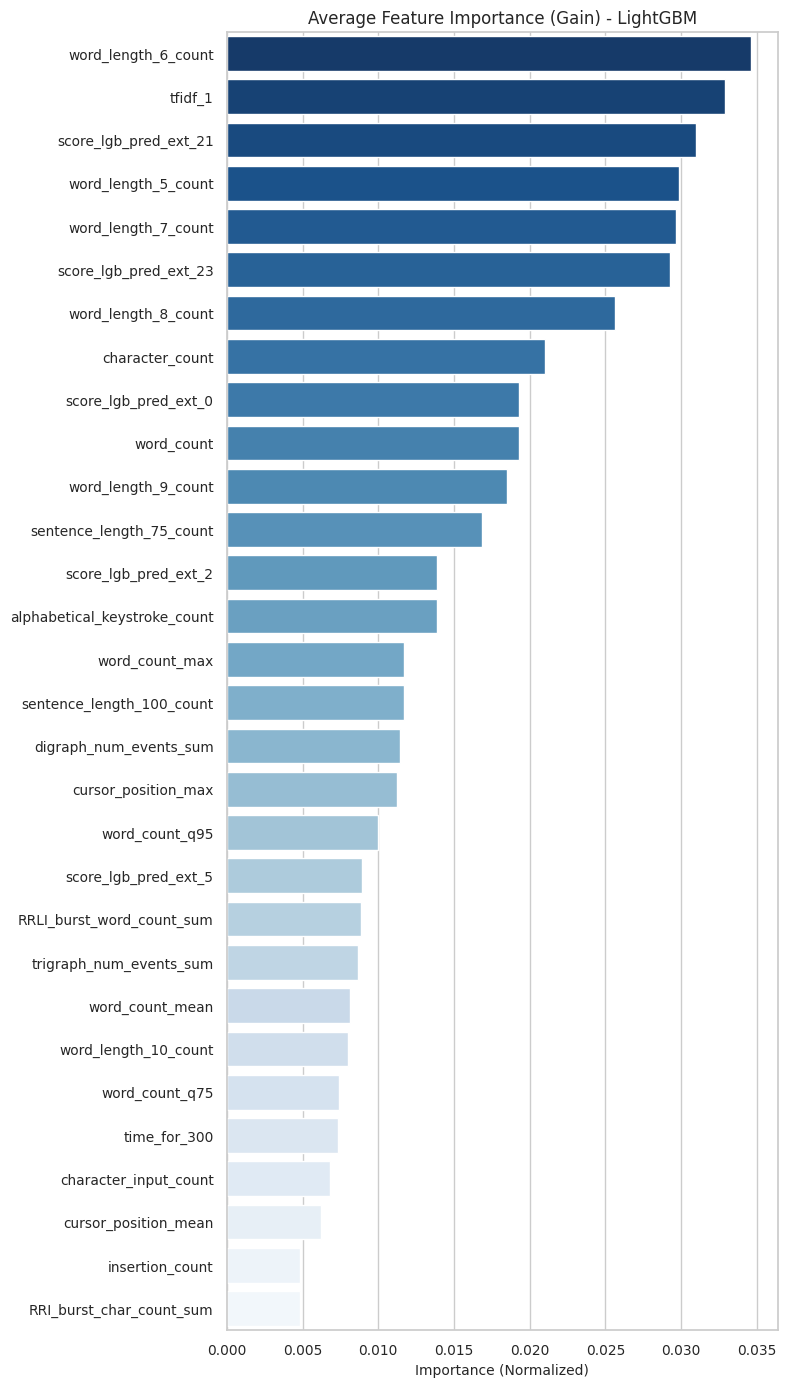

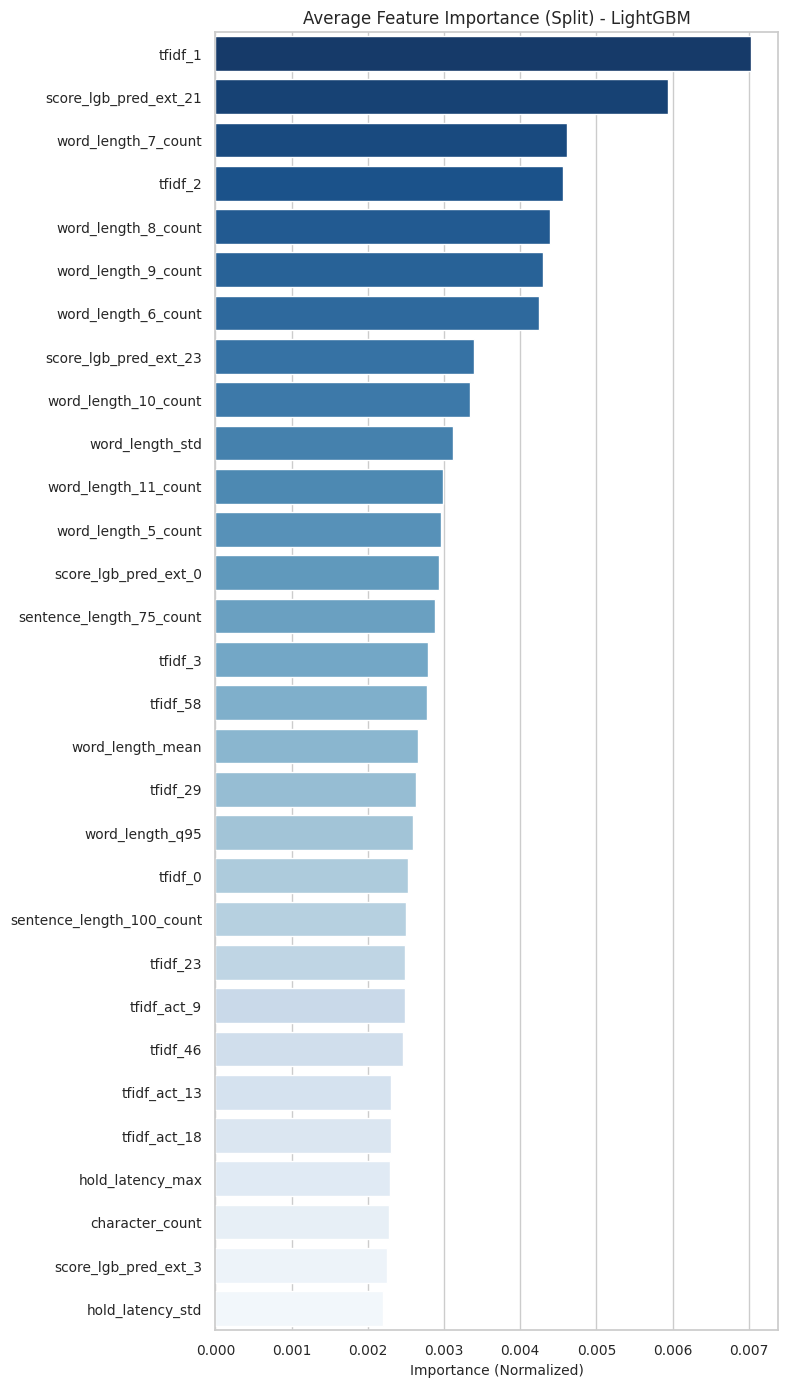

val_metric: 0.5893415672694826, 3 minutes
oof_metric: 0.5856831561701947
oof_metric_round: 0.6059365023837767


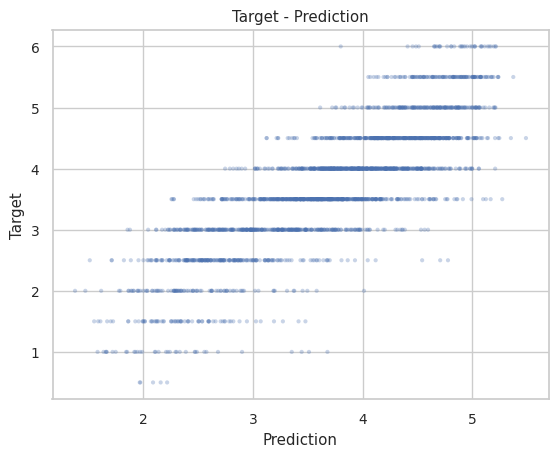

CPU times: user 6min 44s, sys: 4.11 s, total: 6min 48s
Wall time: 3min 34s


In [105]:
%%time
if cfg.train:
    print("Training Model :")
    cfg.augment = False
    train_df, metric = train_model(
        train_df, 
        features, 
        target_col=cfg.target_col,
        mode=mode,
        params=params,
        nbags=cfg.nbags, 
        nfolds=cfg.nfolds, 
        model_dir=f"{cfg.out_dir}{cfg.run_name}/initial",
        cfg=cfg, 
        log_importance=True, 
        log_shap=True,
        show_fig=True,
        importance_dir=f"{cfg.out_dir}{cfg.run_name}/initial/feature-importance",
        shap_dir=f"{cfg.out_dir}{cfg.run_name}/initial/shap",
    )
    # Save the training DataFrame with predictions to a file 
    model_dir = os.path.join(cfg.out_dir, cfg.run_name, "initial")
    mkdir_if_not_exist(model_dir)
    train_df_pred_path = os.path.join(model_dir, "train_df_initial.pickle")
    pickle_dump(train_df, train_df_pred_path)
    

## **Model Evaluation**

In [106]:
if cfg.train:
    cfg.is_classification = False # Force regression mode (use RMSE)
    y_true = train_df[cfg.target_col].values # True essay scores
    # Get all prediction columns from different models
    pred_col = f"{cfg.target_col}_{mode}_pred"

    print(f"\nEvaluating model: {pred_col}")
    y_pred = train_df[pred_col].values
    # RMSE
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"RMSE: {rmse:.4f}")
    # Rounded RMSE (to 0.5)
    y_pred_round = np.round(y_pred * 2) / 2
    rmse_round = mean_squared_error(y_true, y_pred_round, squared=False)
    print(f"RMSE (rounded to 0.5): {rmse_round:.4f}")


Evaluating model: score_lgb_pred
RMSE: 0.5857
RMSE (rounded to 0.5): 0.6059


Identifies best and worst predictions from the model based on RMSE. 

In [107]:
if cfg.train:
    # Calculate absolute error between predictions and true values
    train_df['pred_error'] = np.abs(y_pred-train_df[cfg.target_col].values)
    
    # Worst predictions: Rows with the largest prediction errors
    fail_df = train_df.sort_values('pred_error').tail()
    print('Worst Predictions (fail_df)')
    display(fail_df)
    
    # Best predictions: Rows with the smallest prediction errors
    good_df = train_df.sort_values('pred_error').head()
    print('Best Predictions (good_df)')
    display(good_df)

Worst Predictions (fail_df)


id_encode        id  keystroke_count  word_count  sentence_count  \
453         453  2f935a5c          0.67036     0.85586         0.65365   
1005       1005  69916fc0          0.44545     0.38789         0.20370   
378         378  2717fdef          0.15231     0.17718         0.20370   
998         998  68df1430          0.29730     0.41542         0.61461   
1614       1614  aac5ac07          0.48060     0.59660         0.20370   

      paragraph_count  score_0.5_order  score_1.0_order  score_1.5_order  \
453           0.20000                1                1                1   
1005          0.00000                1                0                0   
378          -0.20000                1                0                0   
998          -0.20000                1                0                0   
1614         -0.20000                1                0                0   

      score_2.0_order  ...  score_lgb_pred_ext_17  score_lgb_pred_ext_18  \
453                 1  ...                0.85878                0.99283   
1005                0  ...                0.89579                0.88665   
378                 0  ...                0.48741                0.46821   
998                 0  ...                0.76664                0.91092   
1614                0  ...                0.23273                0.36678   

      score_lgb_pred_ext_19  score_lgb_pred_ext_20  score_lgb_pred_ext_21  \
453                 0.53676                0.57855                0.95144   
1005                0.72270                0.84516                0.44544   
378                 0.70448                0.52473                0.62191   
998                 0.25361                0.55603                0.40636   
1614                0.54299                0.30082                0.44003   

      score_lgb_pred_ext_22  score_lgb_pred_ext_23  score_lgb_pred  fold  \
453                 0.67296                0.94162         4.77678     0   
1005                0.76445                0.17615         3.35414     2   
378                 0.62181                0.45868         3.44448     3   
998                 0.63307                0.60709         3.51087     3   
1614                0.36206                0.63872         3.67904     0   

      pred_error  
453      2.27678  
1005     2.35414  
378      2.44448  
998      2.51087  
1614     2.67904  

[5 rows x 1257 columns]

Best Predictions (good_df)


id_encode        id  keystroke_count  word_count  sentence_count  \
2333       2333  f28baf86          0.56562     0.82583         0.68669   
981         981  678869e4          0.14114     0.12613         0.20370   
655         655  460a3b3d          0.22222     0.19269         0.20370   
236         236  18546086          0.91294     0.95464         0.88338   
1163       1163  7a5402f9          0.09109     0.04505         0.31031   

      paragraph_count  score_0.5_order  score_1.0_order  score_1.5_order  \
2333          0.40000                1                1                1   
981           0.00000                1                1                1   
655           0.00000                1                1                1   
236           0.20000                1                1                1   
1163         -0.20000                1                1                1   

      score_2.0_order  ...  score_lgb_pred_ext_17  score_lgb_pred_ext_18  \
2333                1  ...                0.99262                0.60468   
981                 1  ...                0.00446                0.00201   
655                 1  ...                0.65844                0.52616   
236                 1  ...                0.94300                0.86368   
1163                1  ...                0.16640                0.02794   

      score_lgb_pred_ext_19  score_lgb_pred_ext_20  score_lgb_pred_ext_21  \
2333                0.40677                0.61207                0.56378   
981                 0.21346                0.18967                0.02390   
655                 0.74710                0.36154                0.60866   
236                 0.70602                0.66955                0.92873   
1163                0.47494                0.92169                0.57069   

      score_lgb_pred_ext_22  score_lgb_pred_ext_23  score_lgb_pred  fold  \
2333                0.40846                0.51896         4.00002     3   
981                 0.13399                0.15622         3.00019     0   
655                 0.37514                0.44315         3.50037     4   
236                 0.68293                0.98702         5.00064     1   
1163                0.79643                0.27327         2.99905     2   

      pred_error  
2333     0.00002  
981      0.00019  
655      0.00037  
236      0.00064  
1163     0.00095  

[5 rows x 1257 columns]

## Ablation Studies

In [108]:
# Load metadata
meta_df = pd.read_csv(cfg.mydata_dir + "features_summary.csv")

# Sync filtered features with metadata 
cleaned_meta_df, features = sync_features_with_metadata(
    meta_df=meta_df,
    final_feats=features,
    feature_col="Variable Name", 
    verbose=True
)

# Generate ablation sets from metadata
source_ablation_sets, category_ablation_sets = generate_ablation_sets(
    source_dict=cleaned_meta_df.groupby('Source')['Variable Name'].apply(list).to_dict(),
    category_dict=cleaned_meta_df.groupby('Category')['Variable Name'].apply(list).to_dict(),
    all_feats=features
)

Aligned features: 1196
Missing from filtered features (only in metadata): 30
  All: ['PRLI_burst_word_count_min', 'RRLI_burst_char_count_min', 'RRLI_burst_typing_speed_min', 'RRLI_burst_word_count_min', 'RRLI_burst_word_count_q05', 'RRLI_burst_word_count_q25', 'RRL_burst_char_count_min', 'RRL_burst_typing_speed_min', 'RRL_burst_word_count_min', 'RRL_burst_word_count_q05', 'all_burst_char_count_min', 'all_burst_char_count_q05', 'all_burst_typing_speed_min', 'all_burst_typing_speed_q05', 'all_burst_word_count_min', 'all_burst_word_count_q05', 'all_burst_word_count_q25', 'deletion_action_time_max', 'digraph_num_events_q05', 'entropy_ks_count_per_30s', 'entropy_ks_count_per_60s', 'inter_key_latency_kurtosis', 'inter_key_latency_max', 'inter_key_latency_std', 'keystrokes_per_second', 'press_latency_std', 'release_latency_kurtosis', 'release_latency_max', 'release_latency_skew', 'trigraph_num_events_q05']
Missing from metadata (only in filtered features): 0


### **1️⃣ Source-Based Ablation**

We categorize all features based on their origin:
- Baseline: Features replicated from the [Kaggle 1st Place Solution](https://www.kaggle.com/code/tomooinubushi/1st-place-solution-training-and-inference-code) by Tomoo Inubushi (e.g., TF-IDF). 
- Previous Research: Features inspired by prior work in keystroke logging and cognitive writing research.
- Novel: Features newly proposed in this project. 

We evaluate models trained on:
- Only one source (e.g., only novel features)
- Pairwise combinations (e.g., baseline + novel)
- All features combined

Running Ablation: baseline (297 features)


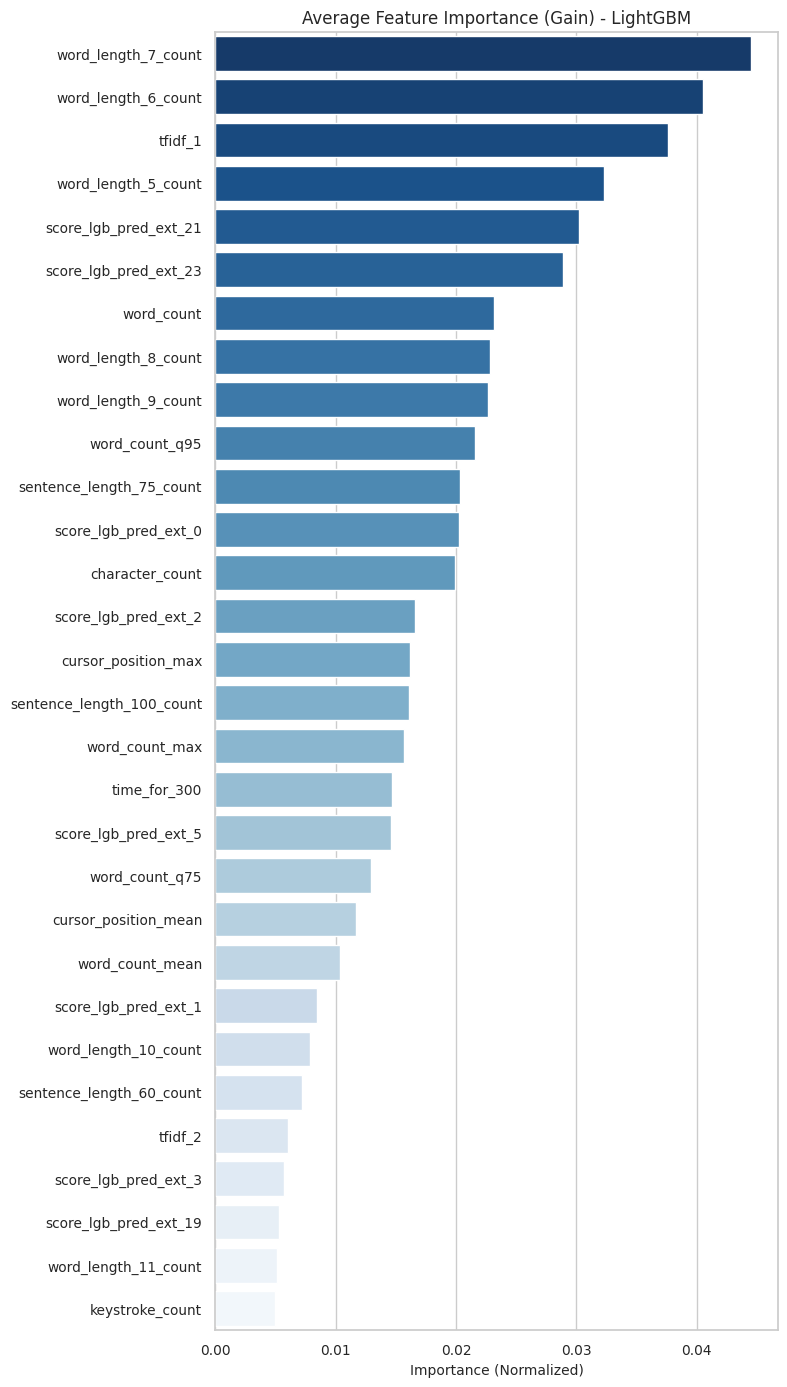

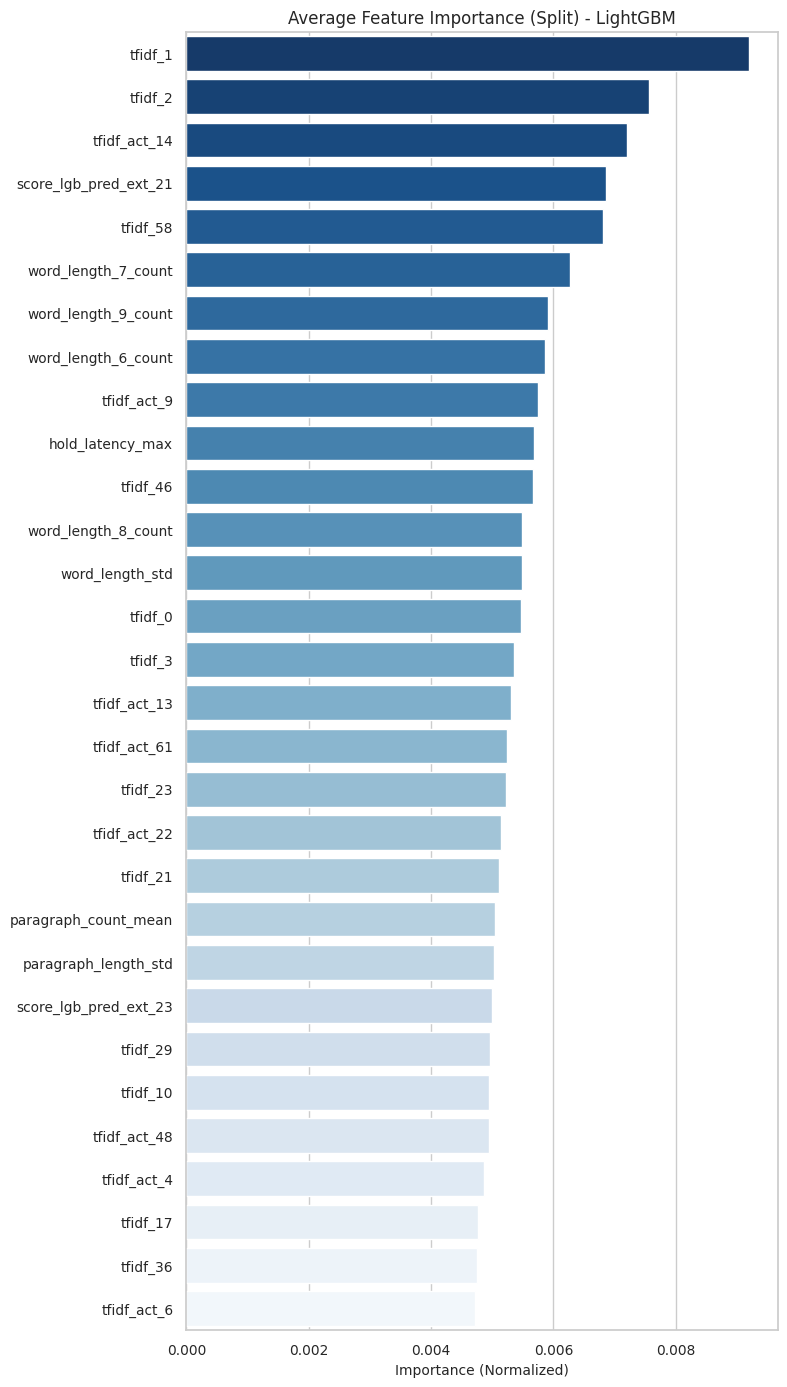

  val_metric: 0.5824 | oof_metric: 0.5791 | oof_round: 0.5957
Running Ablation: existing (76 features)


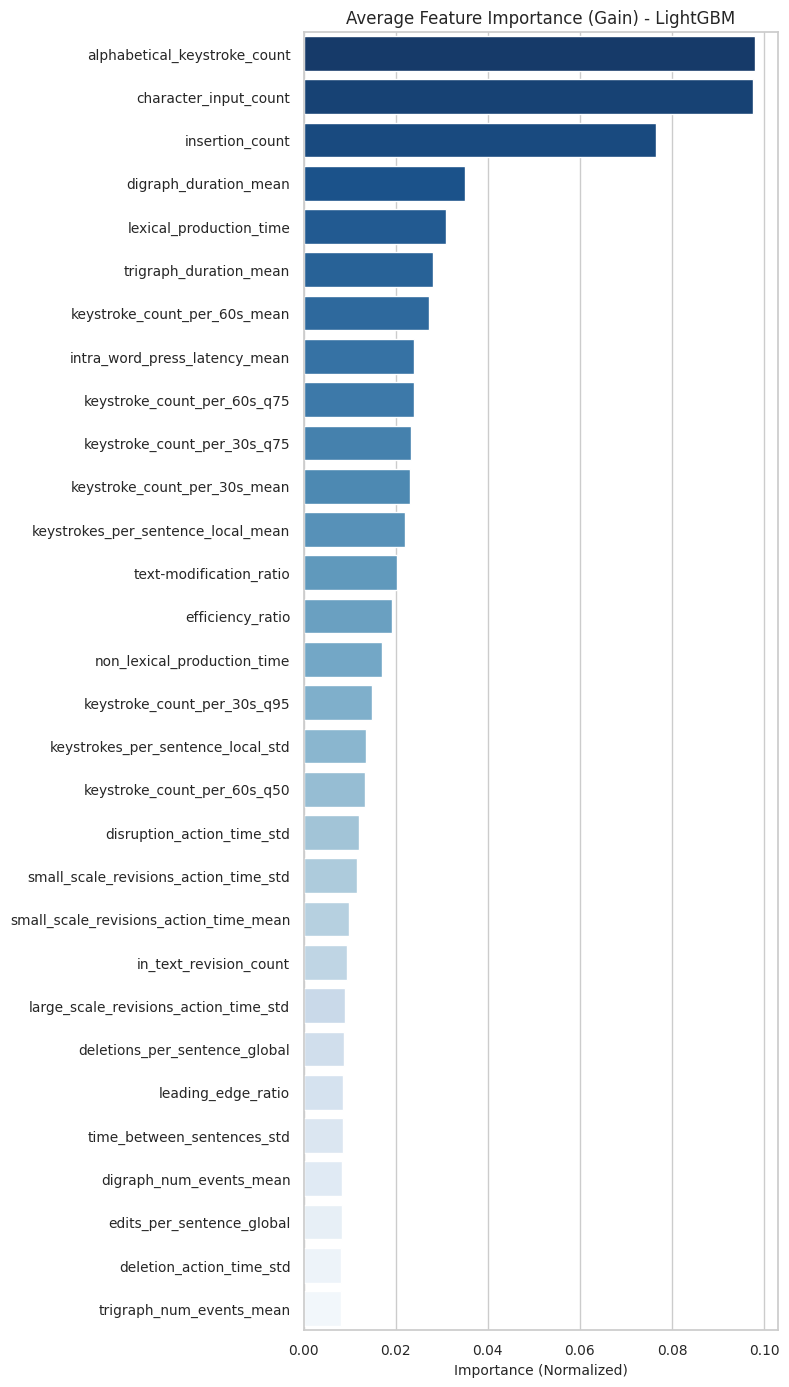

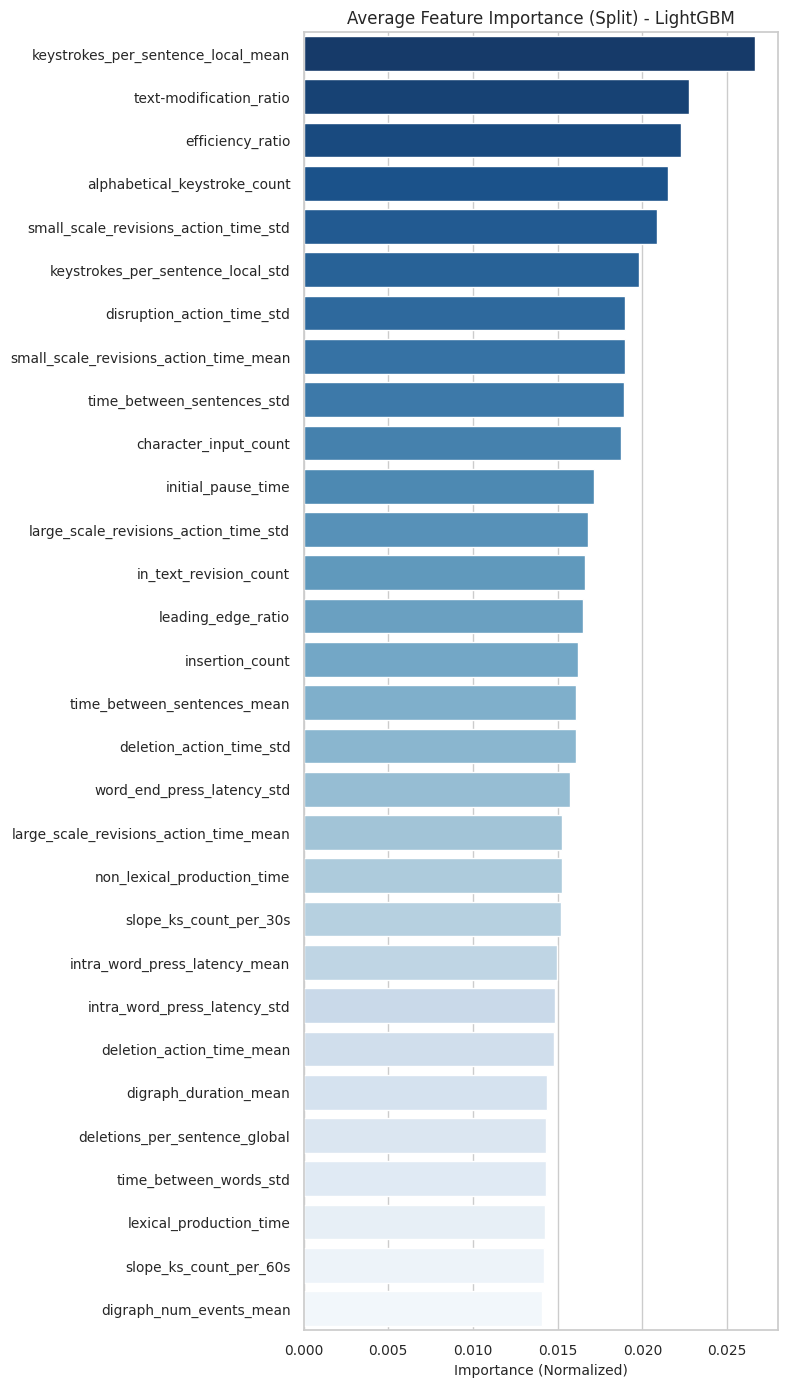

  val_metric: 0.6623 | oof_metric: 0.6593 | oof_round: 0.6733
Running Ablation: novel (823 features)


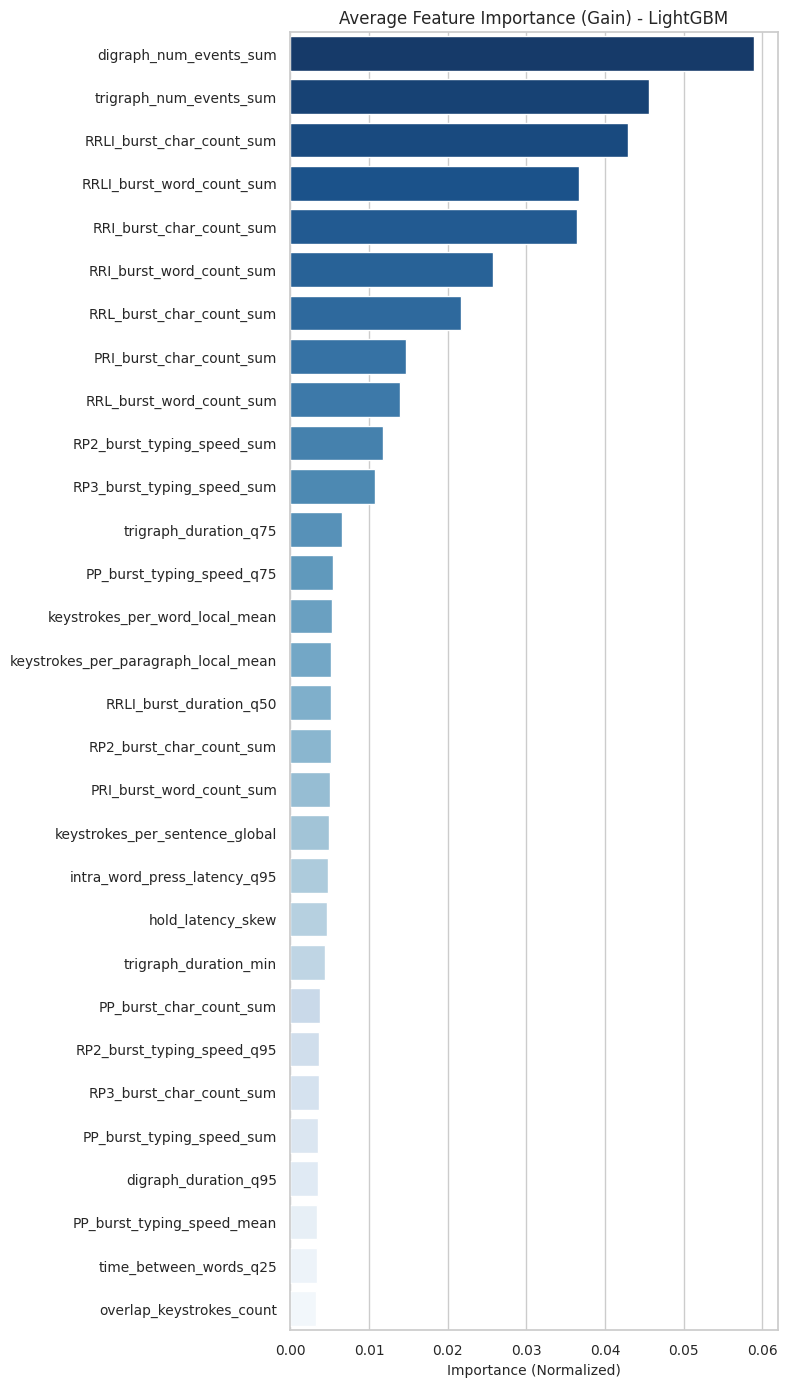

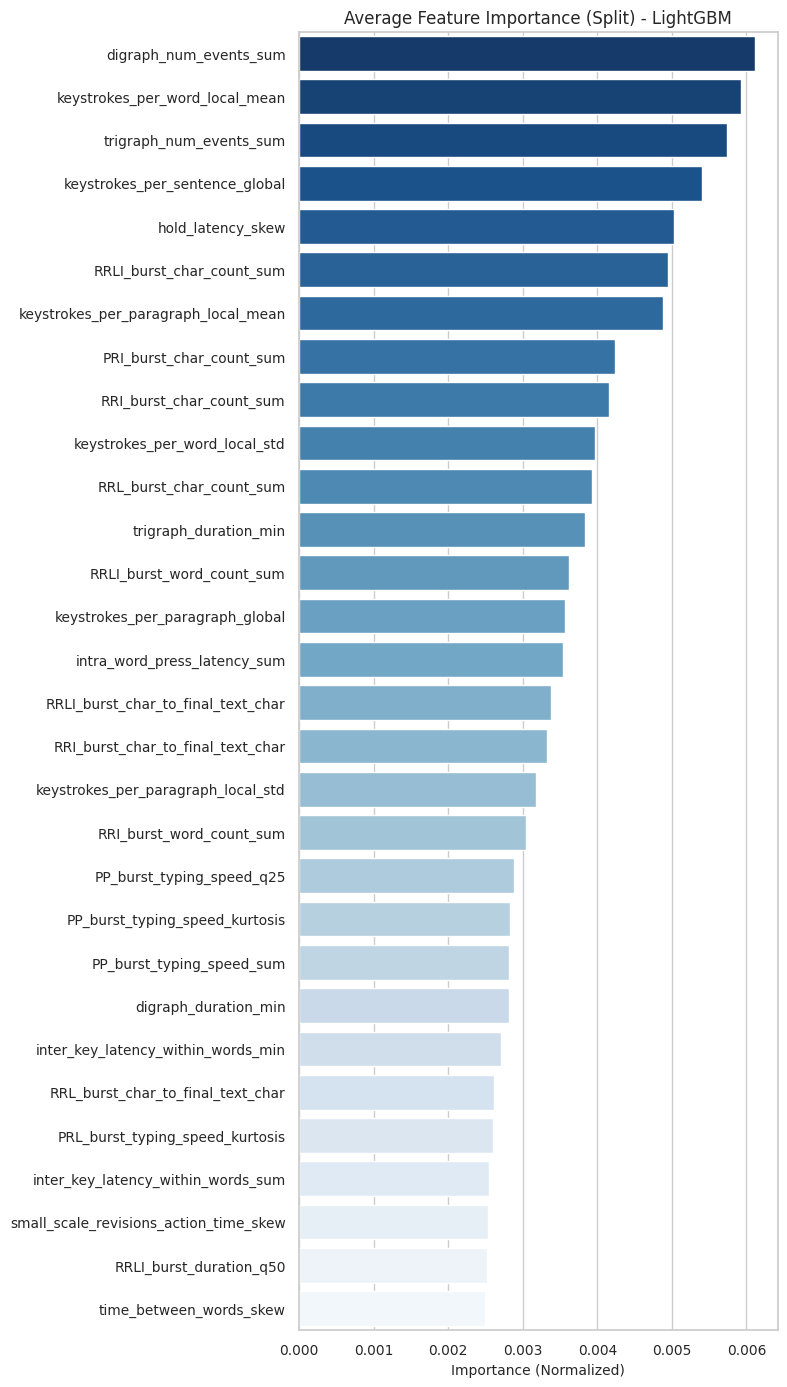

  val_metric: 0.6484 | oof_metric: 0.6441 | oof_round: 0.6640
Running Ablation: baseline_existing (373 features)


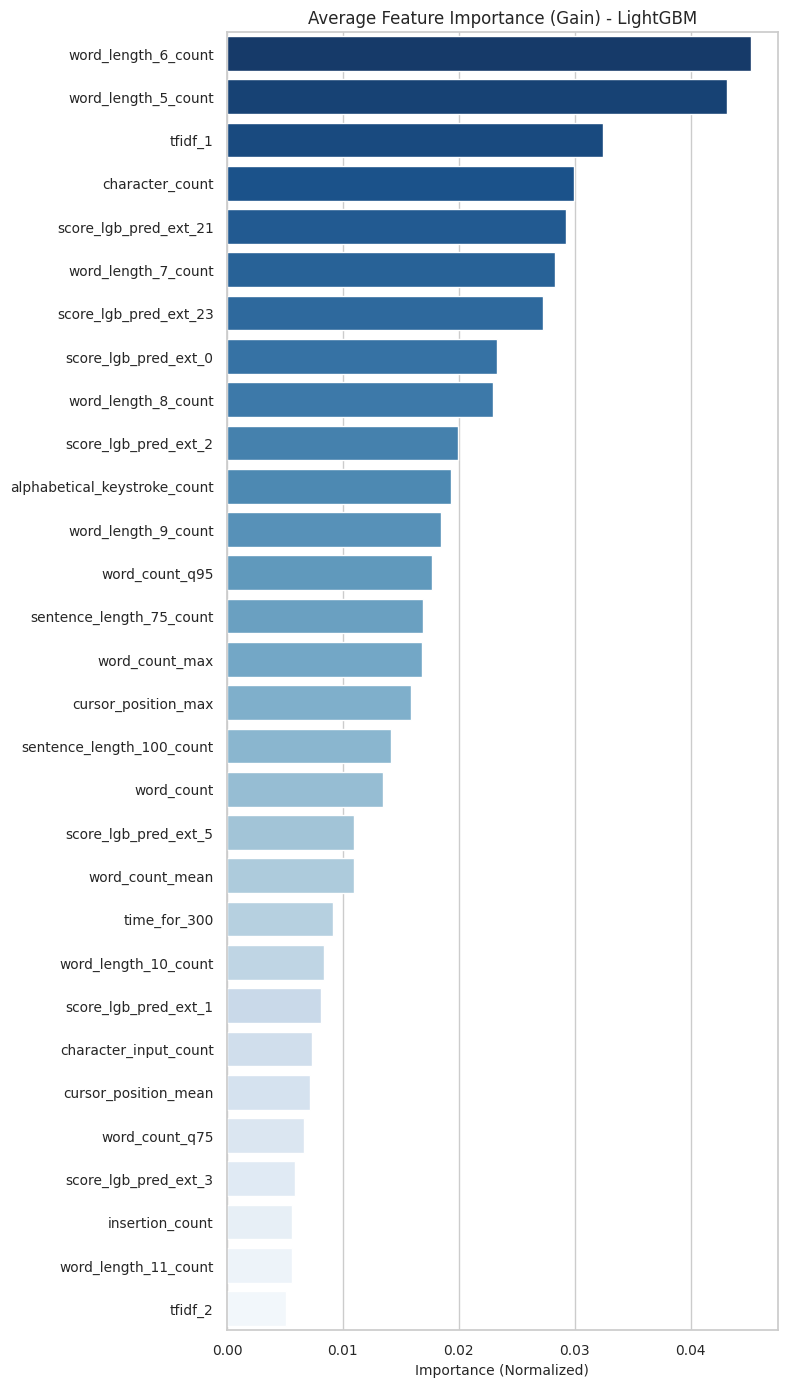

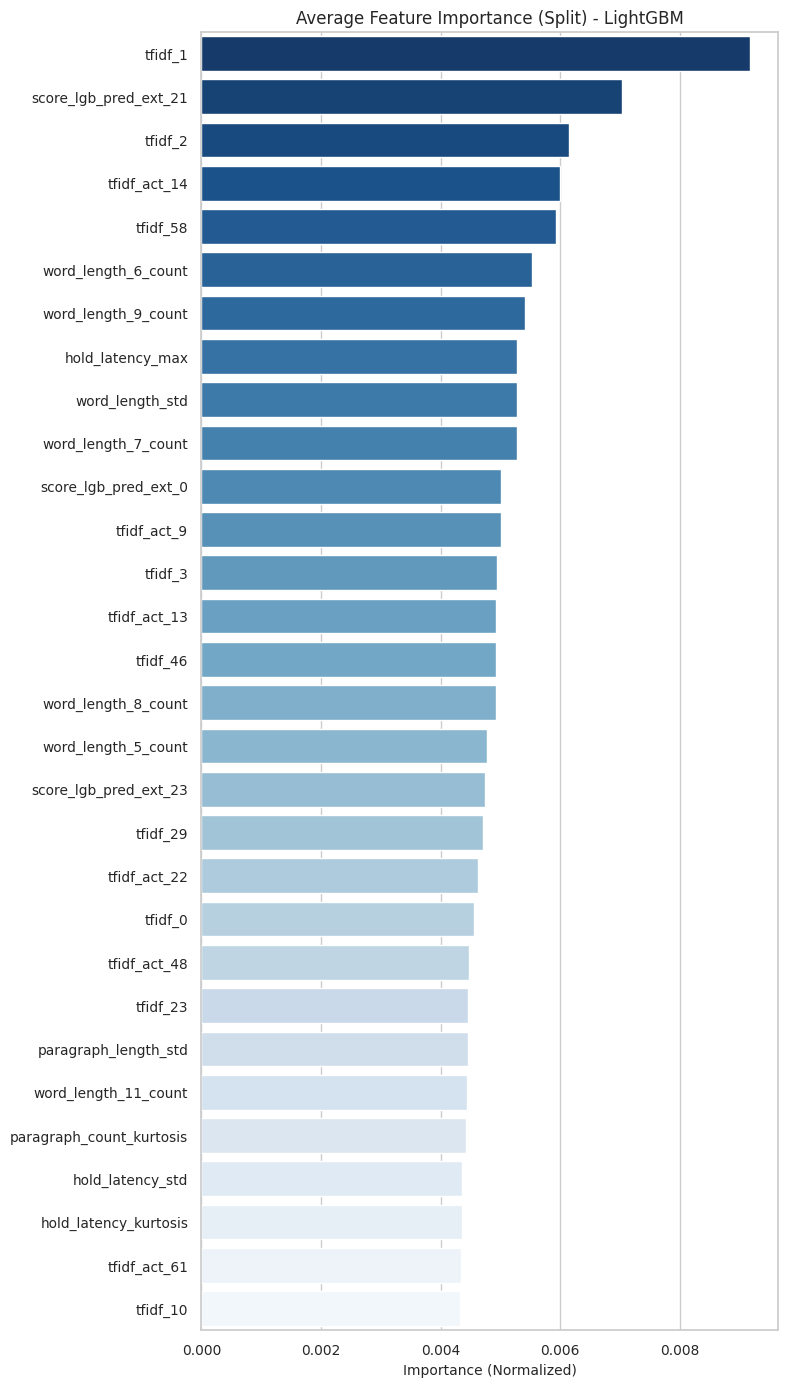

  val_metric: 0.5834 | oof_metric: 0.5802 | oof_round: 0.5962
Running Ablation: existing_novel (899 features)


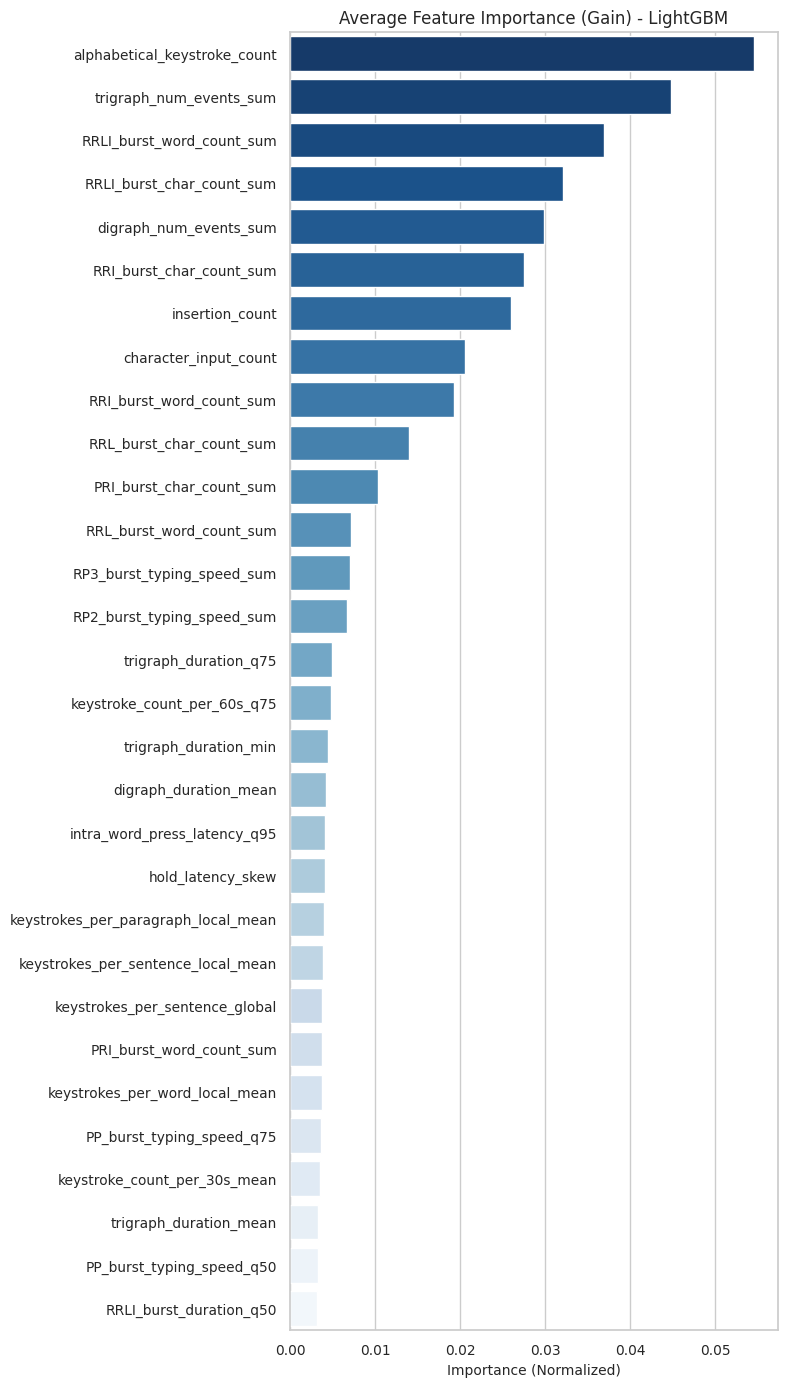

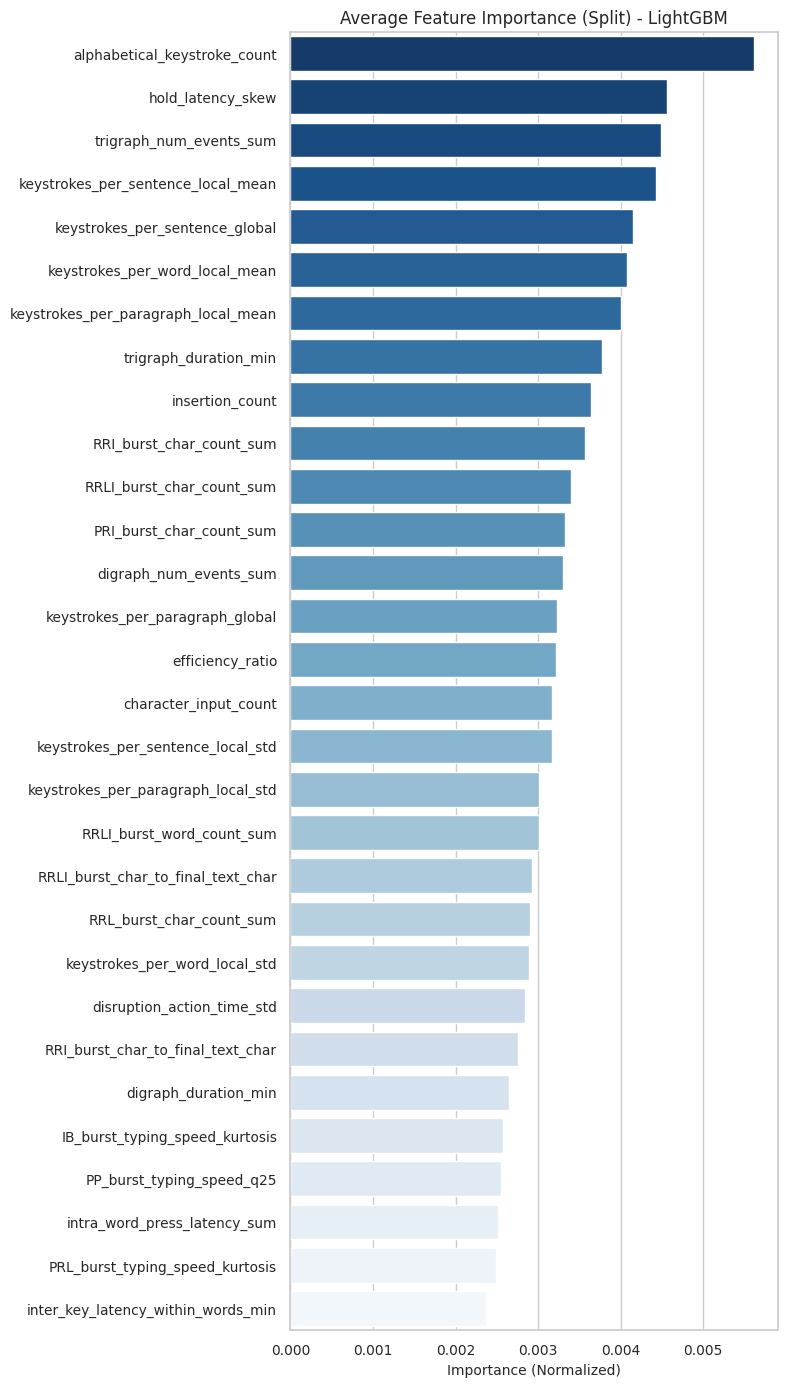

  val_metric: 0.6464 | oof_metric: 0.6420 | oof_round: 0.6598
Running Ablation: baseline_novel (1120 features)


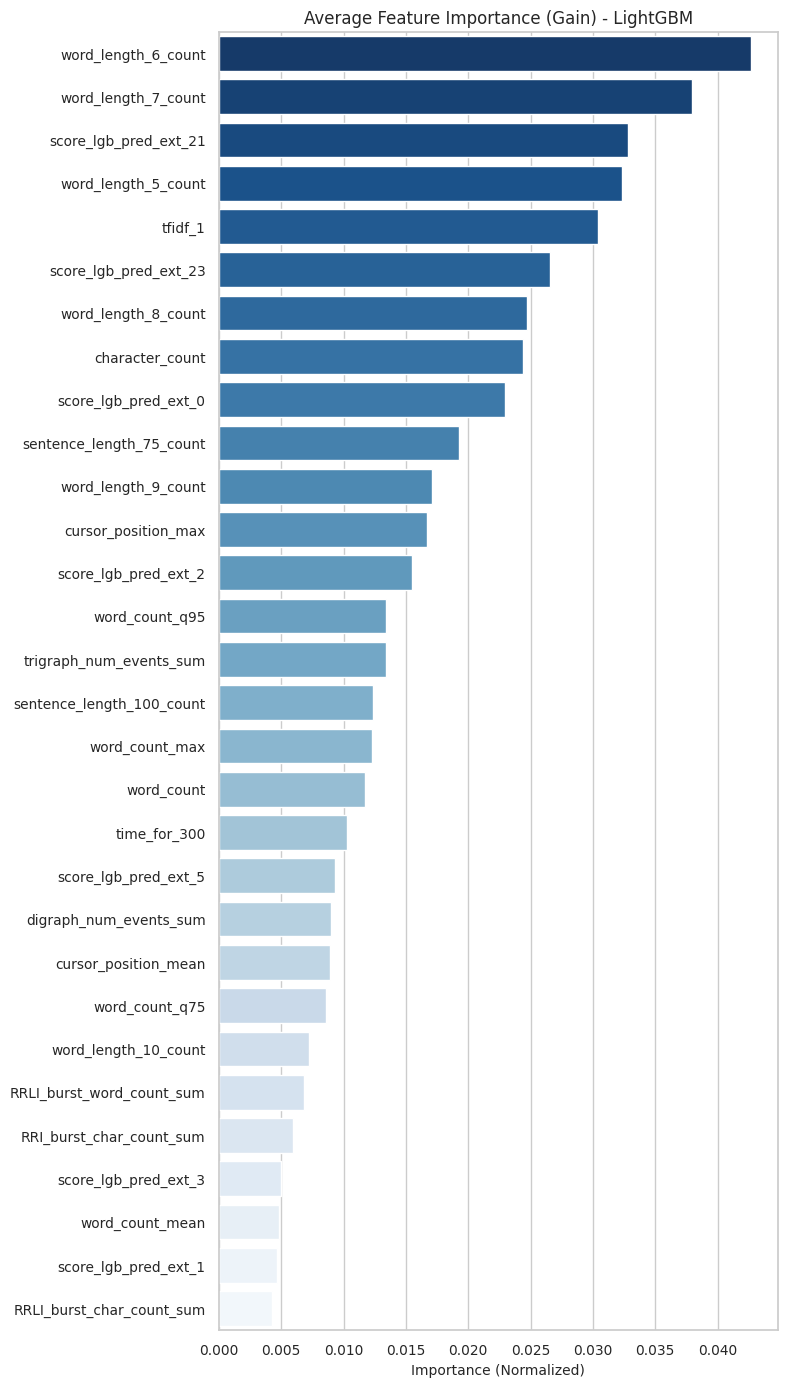

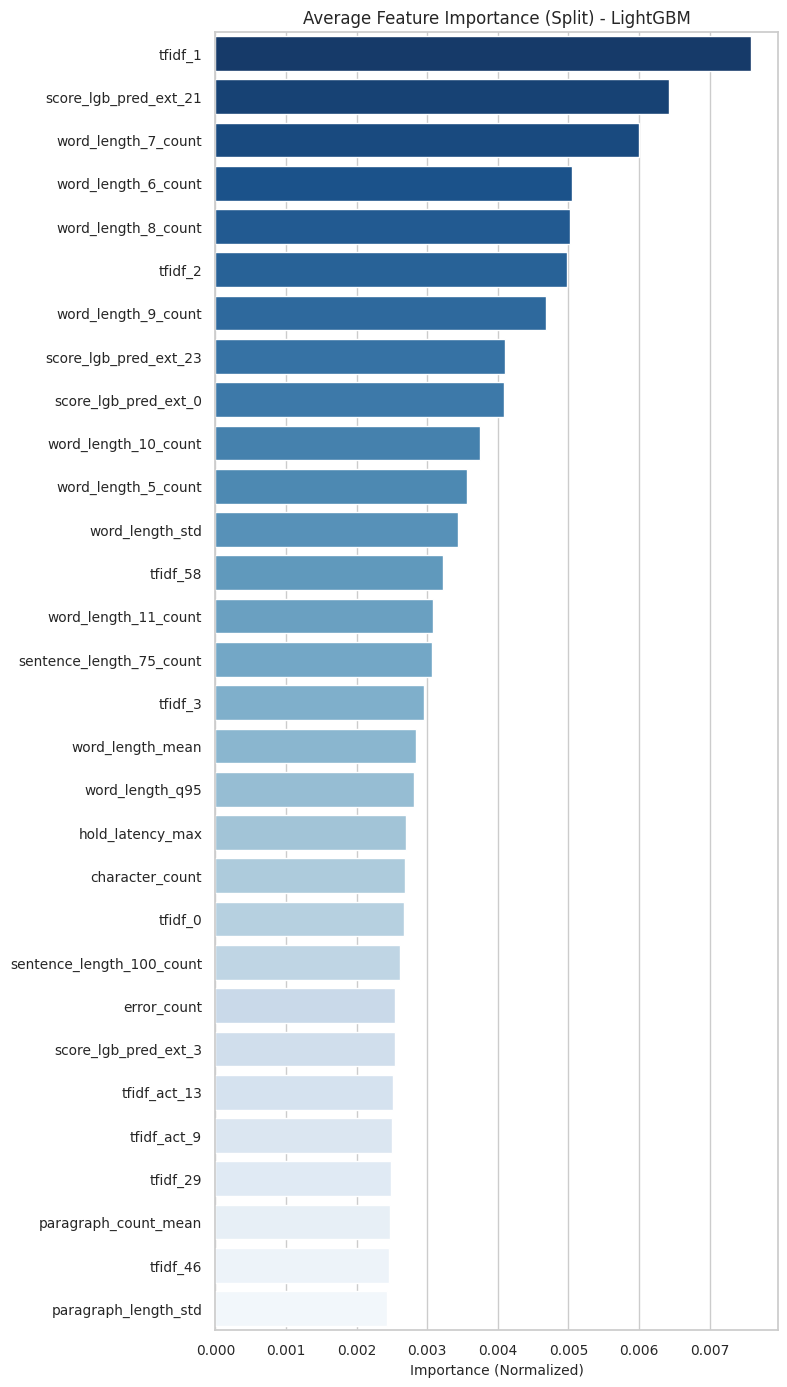

  val_metric: 0.5893 | oof_metric: 0.5859 | oof_round: 0.6054
Running Ablation: all (1196 features)


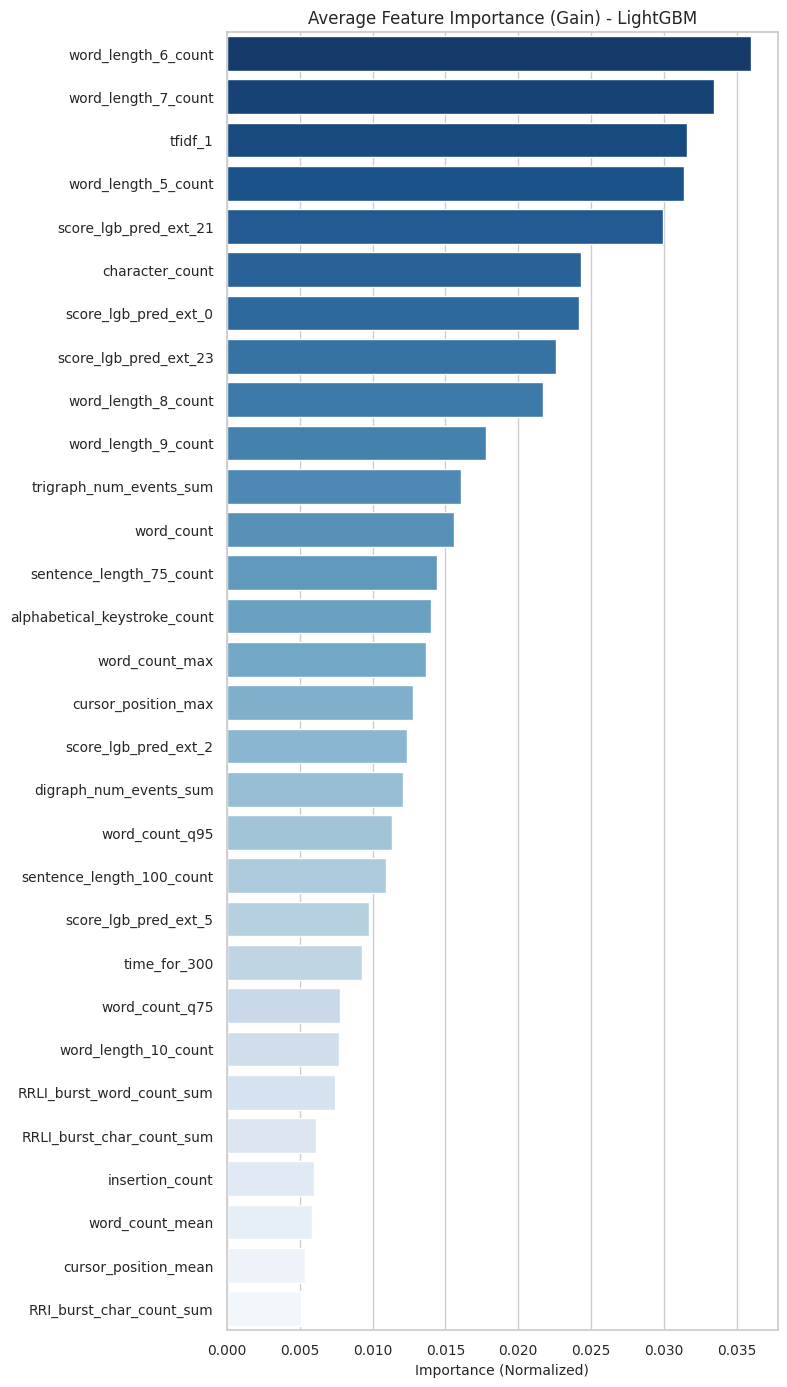

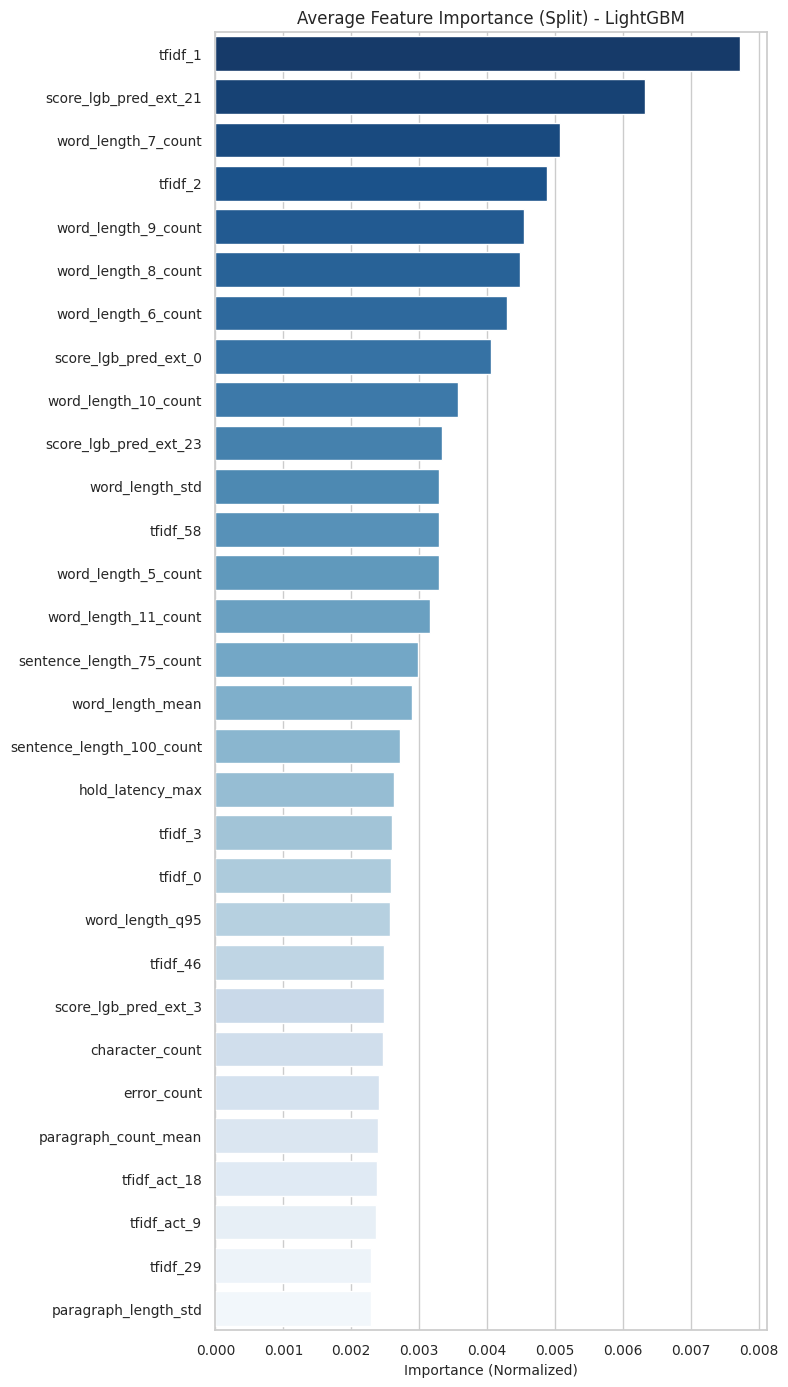

  val_metric: 0.5897 | oof_metric: 0.5863 | oof_round: 0.6025
source Ablation results saved to: output/exp_16/ablation-results/ablation_results_source.csv
CPU times: user 27min 4s, sys: 22.3 s, total: 27min 26s
Wall time: 14min 7s


In [109]:
%%time
# Run source-based ablation experiments 
source_ablation_results_df = run_ablation_experiments(
    train_df=train_df,
    feature_sets=source_ablation_sets,
    cfg=cfg,
    params=params,
    target_col='score',
    mode='lgb',
    log_dir=f"{cfg.out_dir}{cfg.run_name}/ablation-results/",
    log_importance=True,
    log_shap=False,
    show_fig=False,
    save_csv=True, 
    ablation_type="source"
)

### **2️⃣ Category-Based Ablation**
Features are also grouped by linguistic or cognitive writing categories:

- Pause Dynamics
- Revision
- Fluency
- Product-Related
- Verbosity
- Other Events

We evaluate:
- Models trained on only one category
- Models trained on all features minus one category

Running Ablation: all (1196 features)


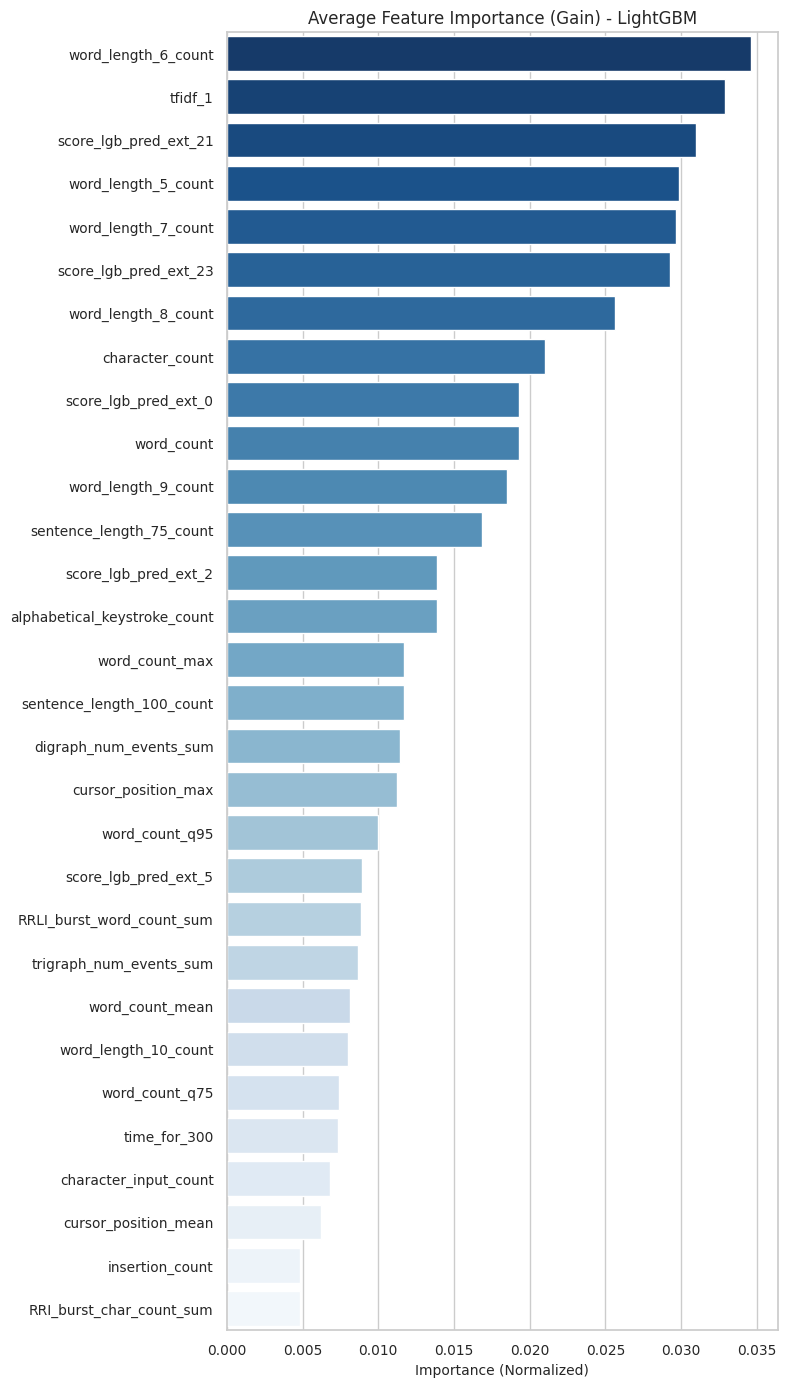

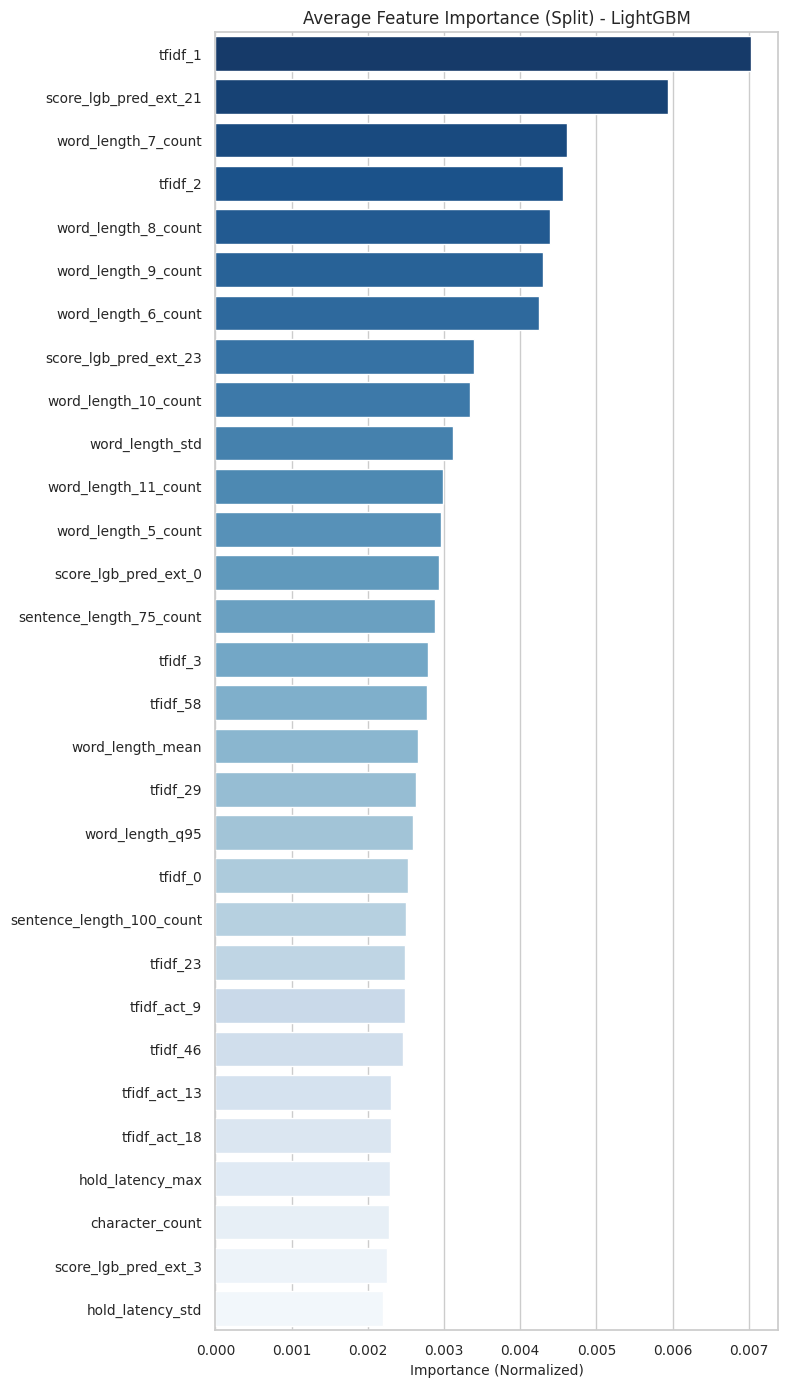

  val_metric: 0.5893 | oof_metric: 0.5857 | oof_round: 0.6059
Running Ablation: fluency (605 features)


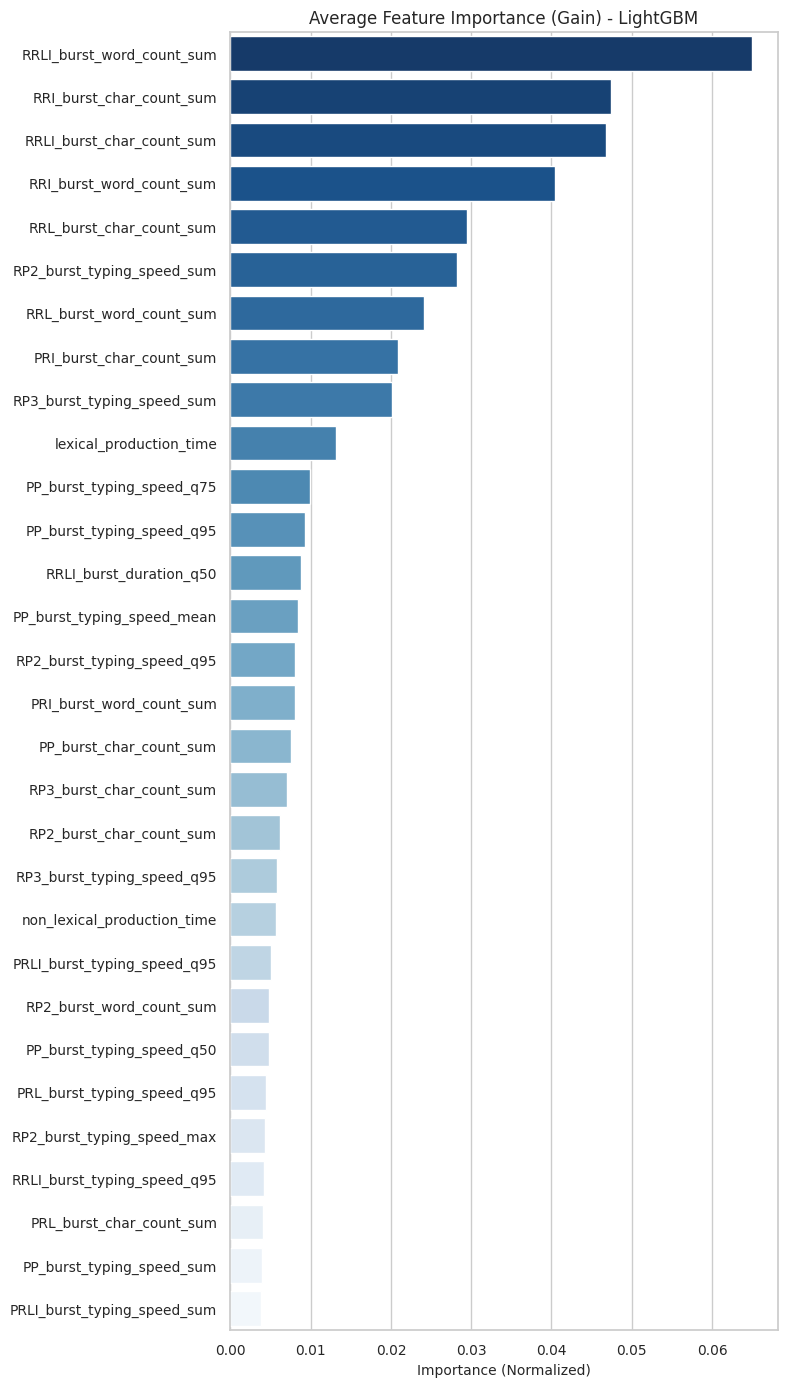

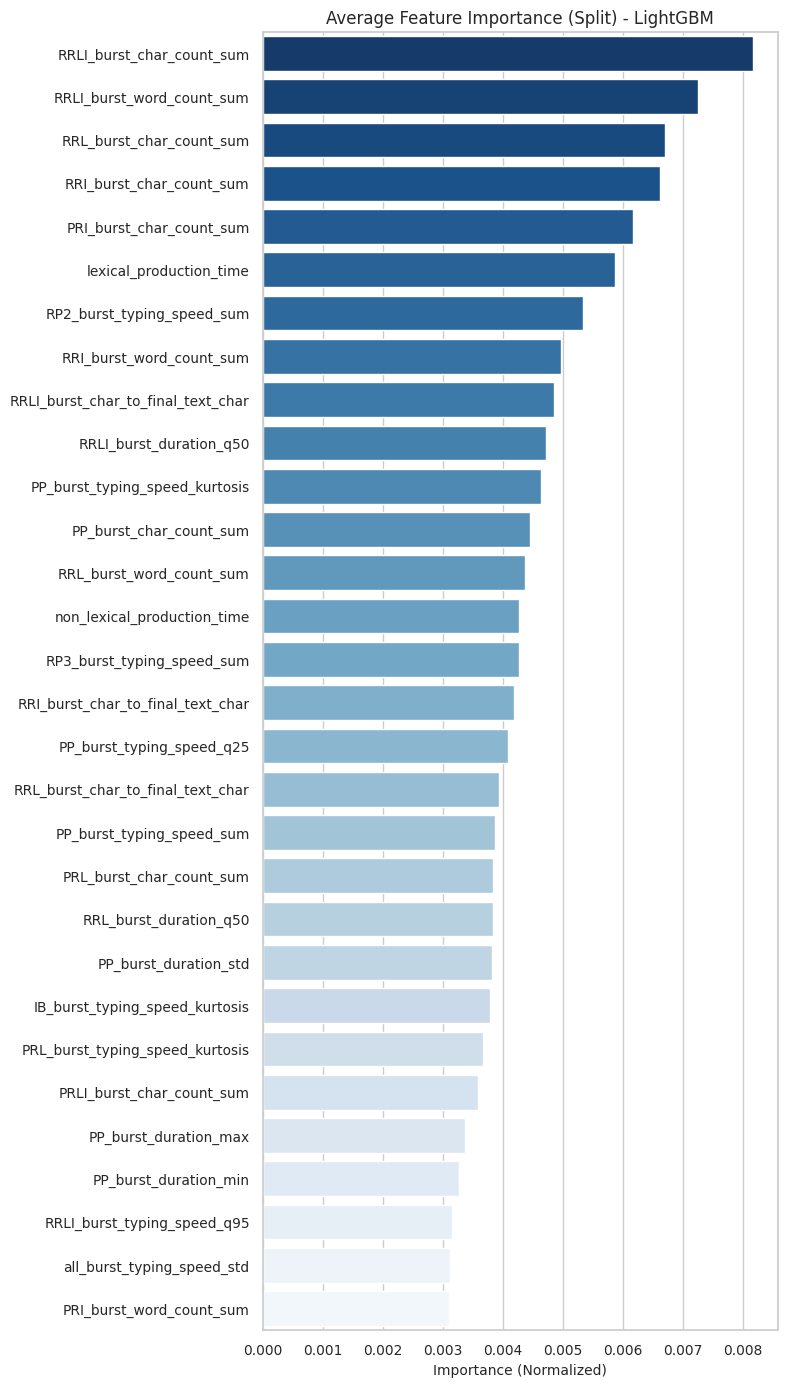

  val_metric: 0.6709 | oof_metric: 0.6674 | oof_round: 0.6888
Running Ablation: minus_fluency (591 features)


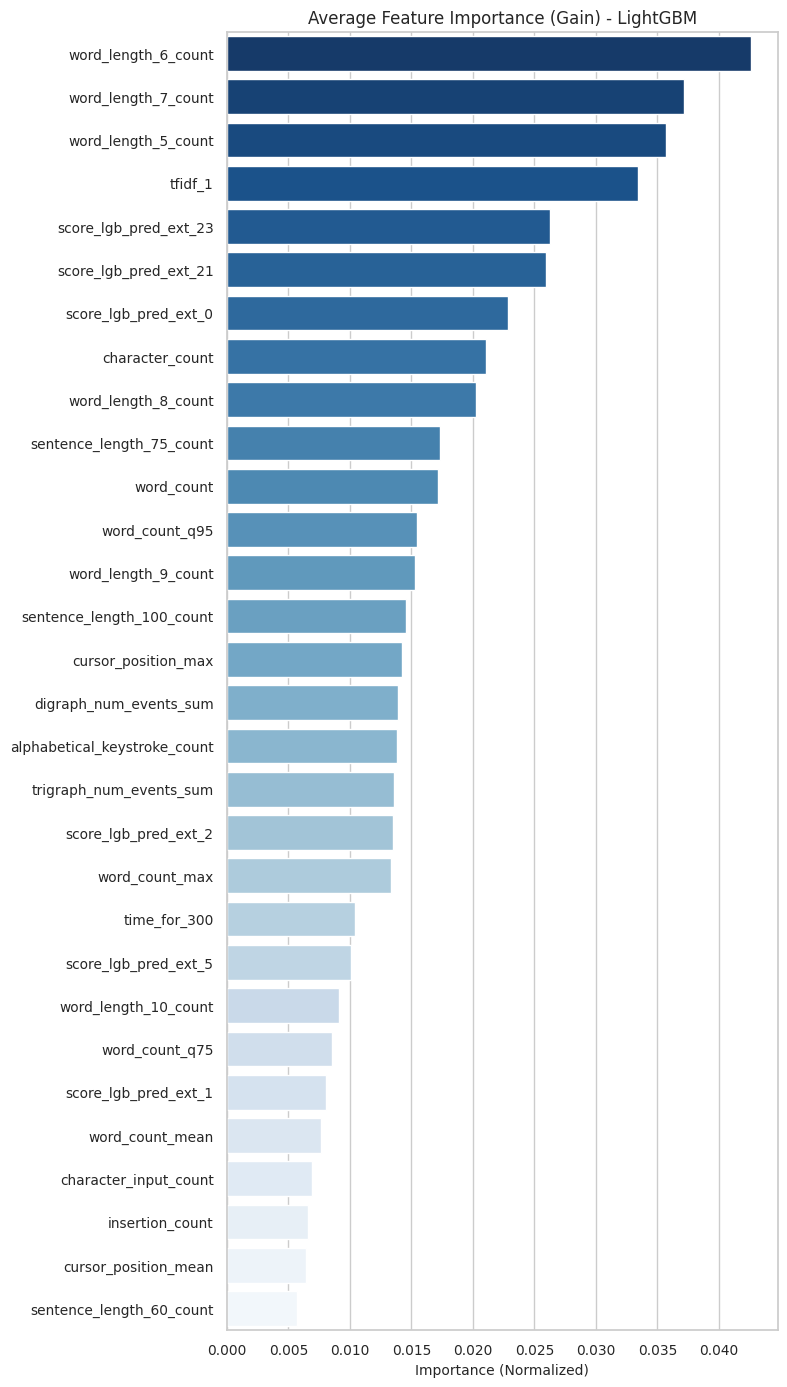

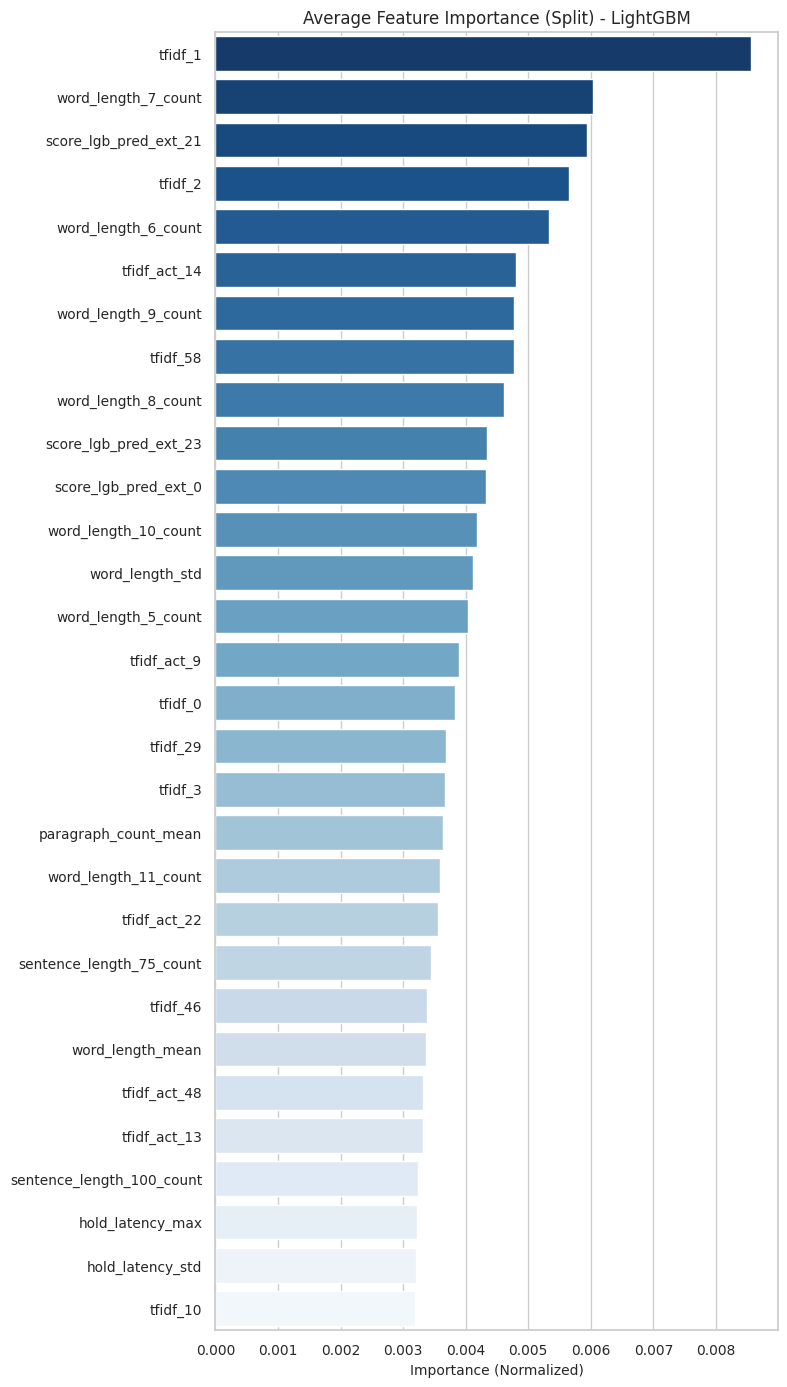

  val_metric: 0.5872 | oof_metric: 0.5837 | oof_round: 0.6001
Running Ablation: other_events (104 features)


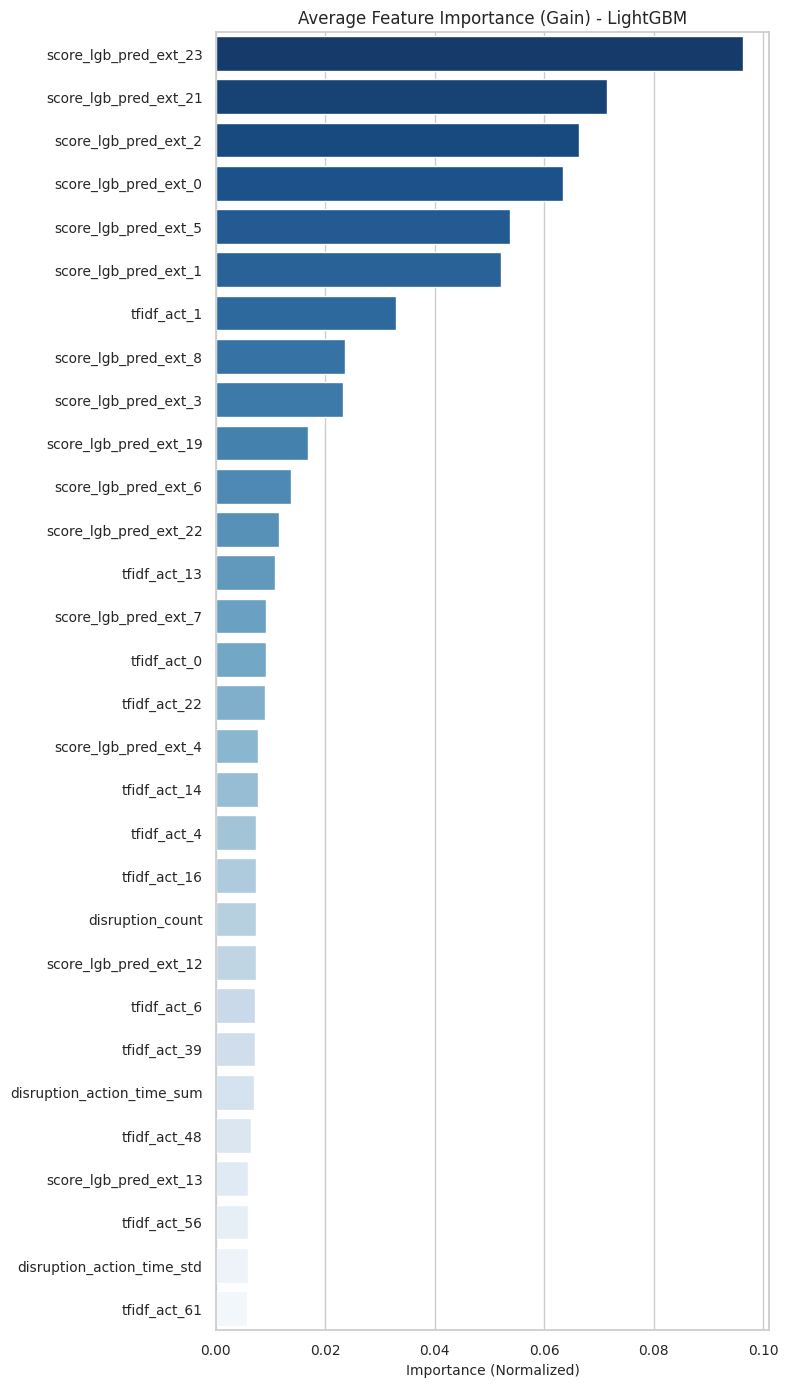

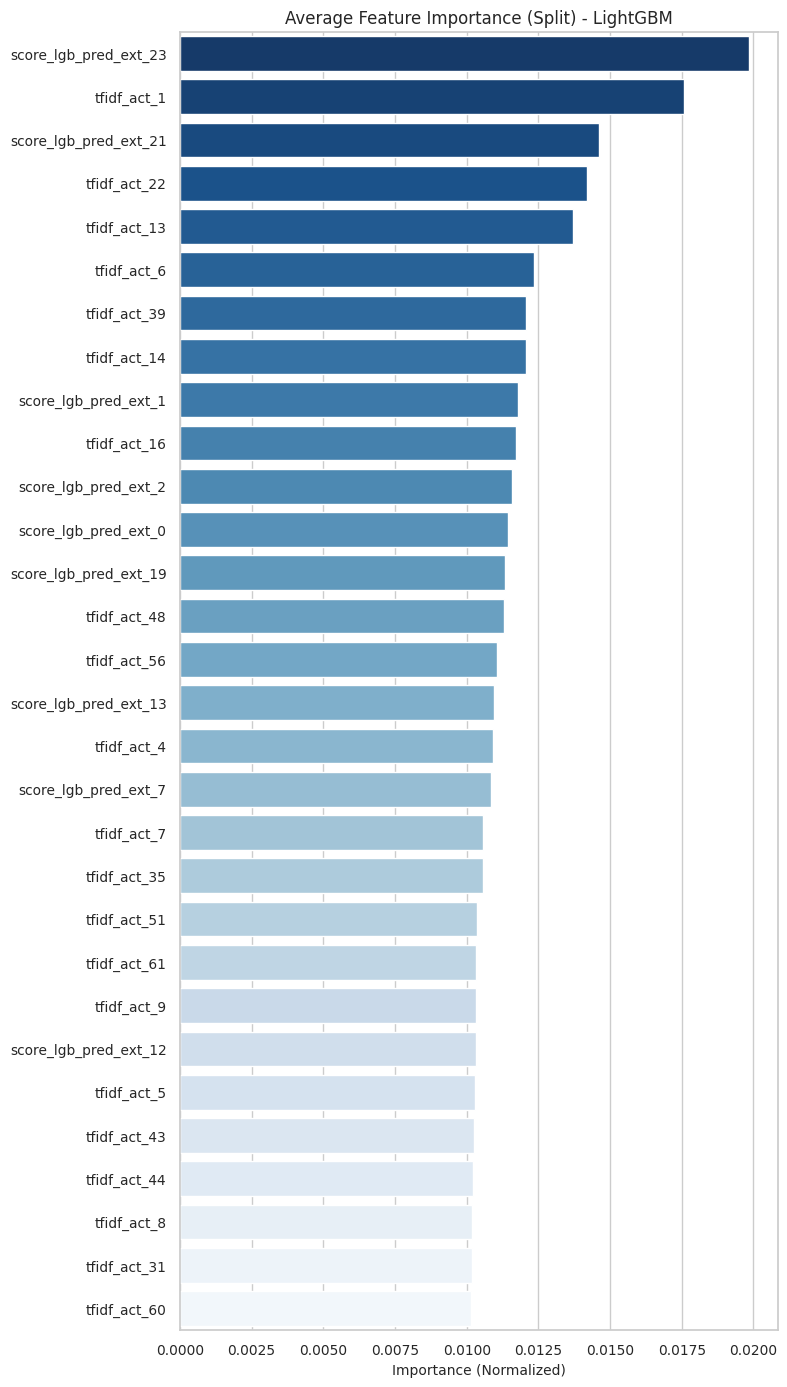

  val_metric: 0.6364 | oof_metric: 0.6328 | oof_round: 0.6472
Running Ablation: minus_other_events (1092 features)


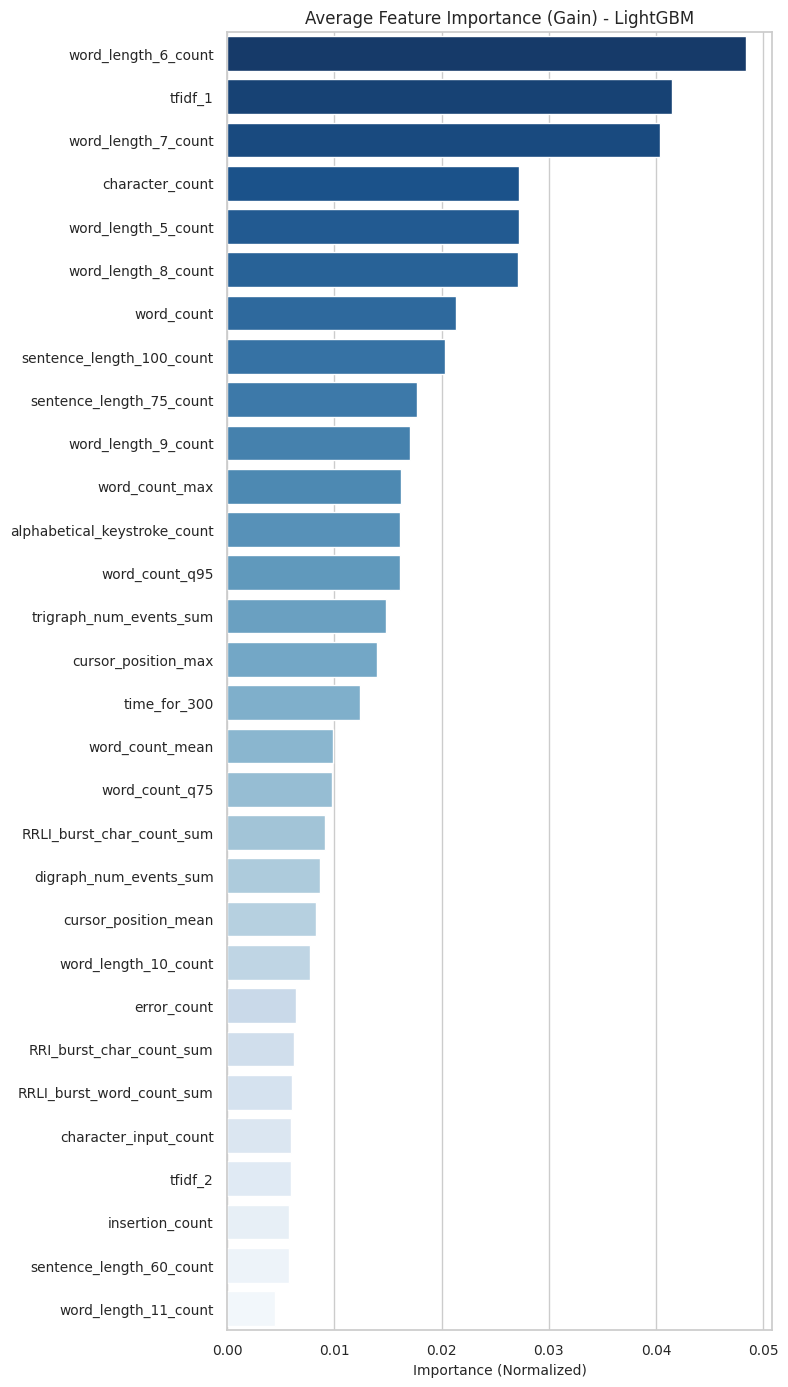

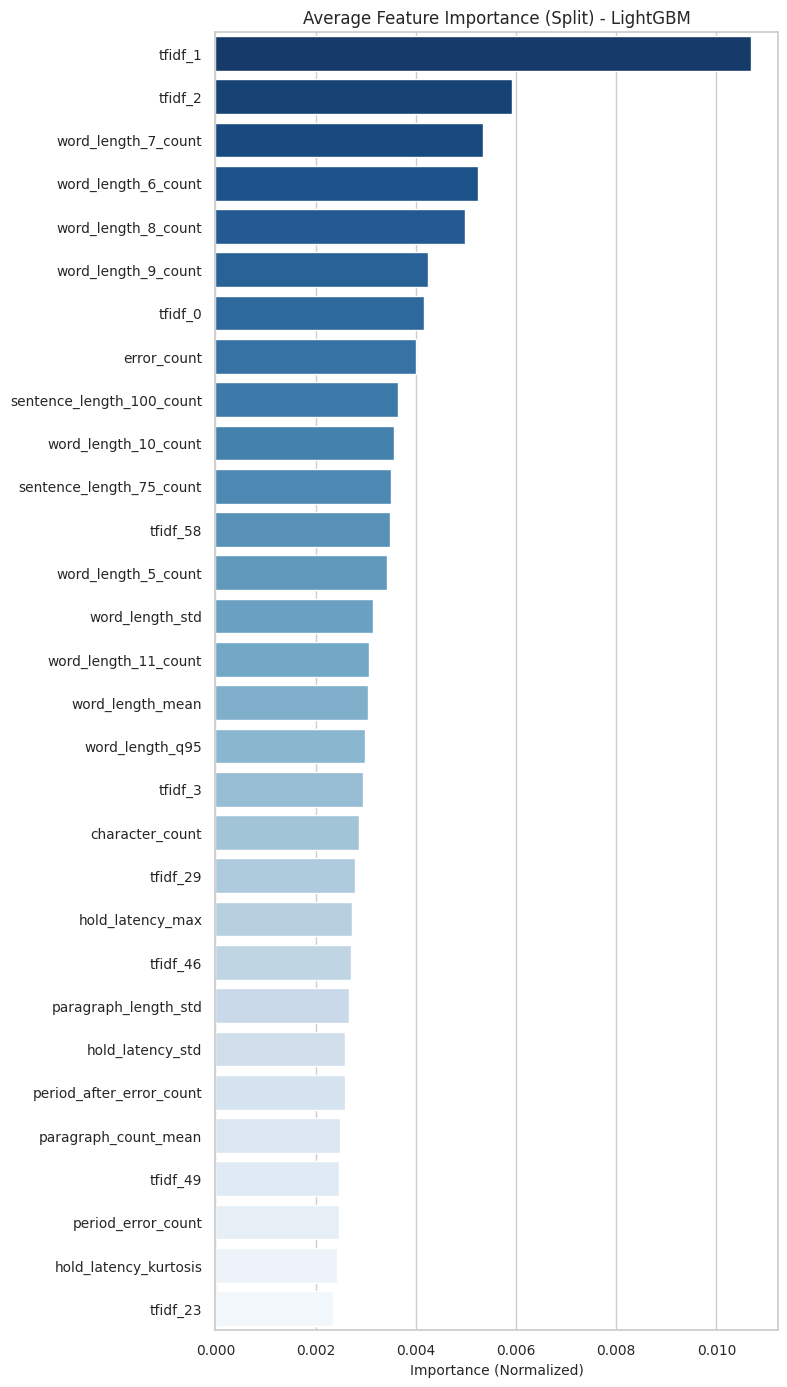

  val_metric: 0.5921 | oof_metric: 0.5884 | oof_round: 0.6078
Running Ablation: pause_dynamics (226 features)


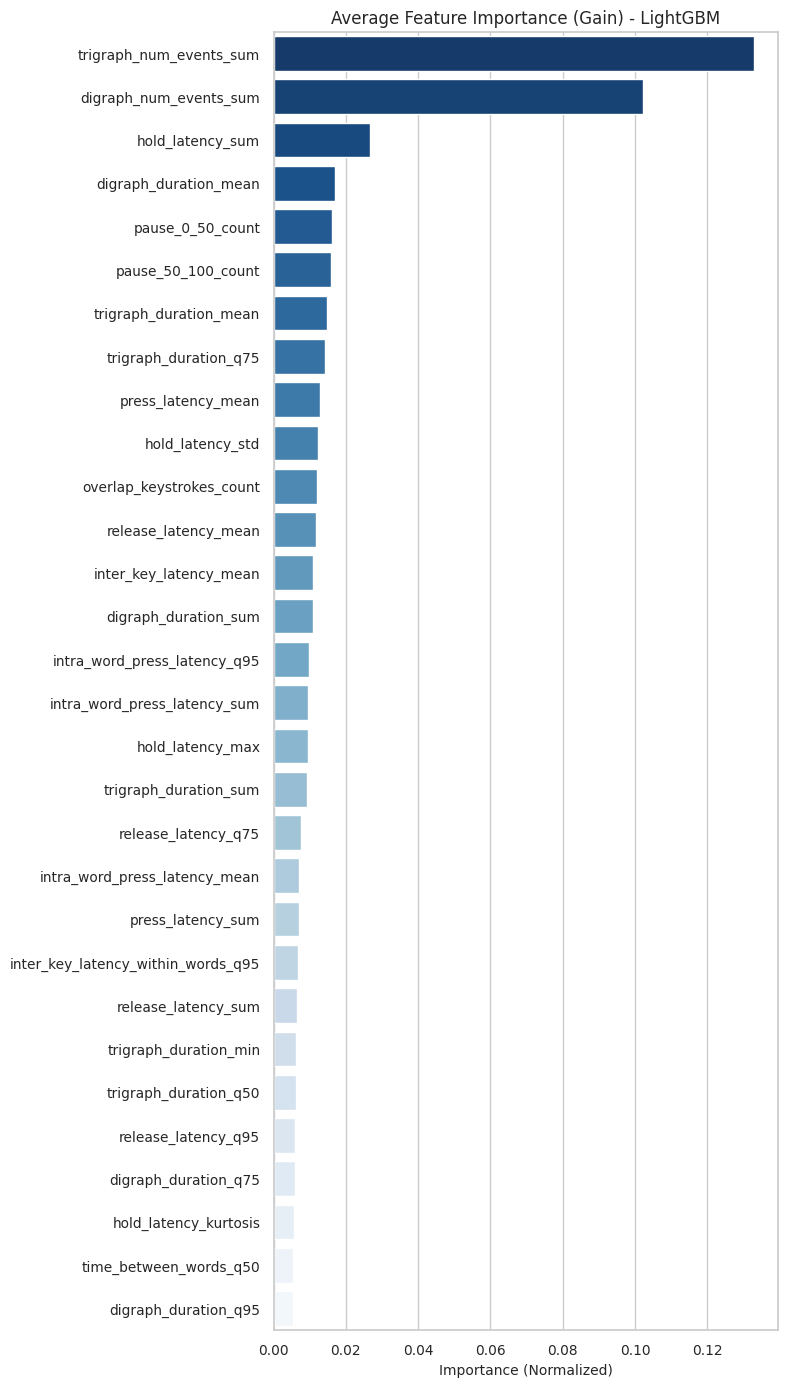

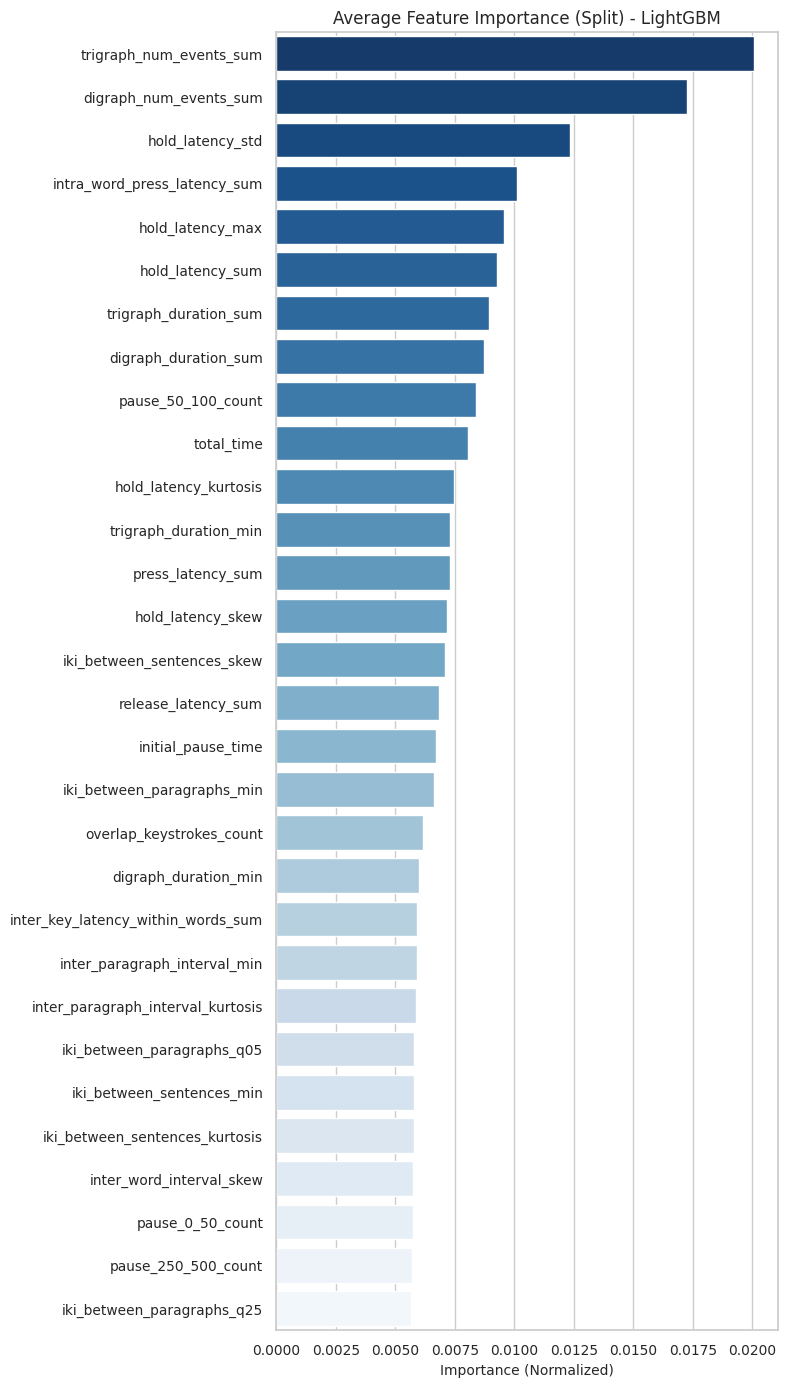

  val_metric: 0.6702 | oof_metric: 0.6670 | oof_round: 0.6805
Running Ablation: minus_pause_dynamics (970 features)


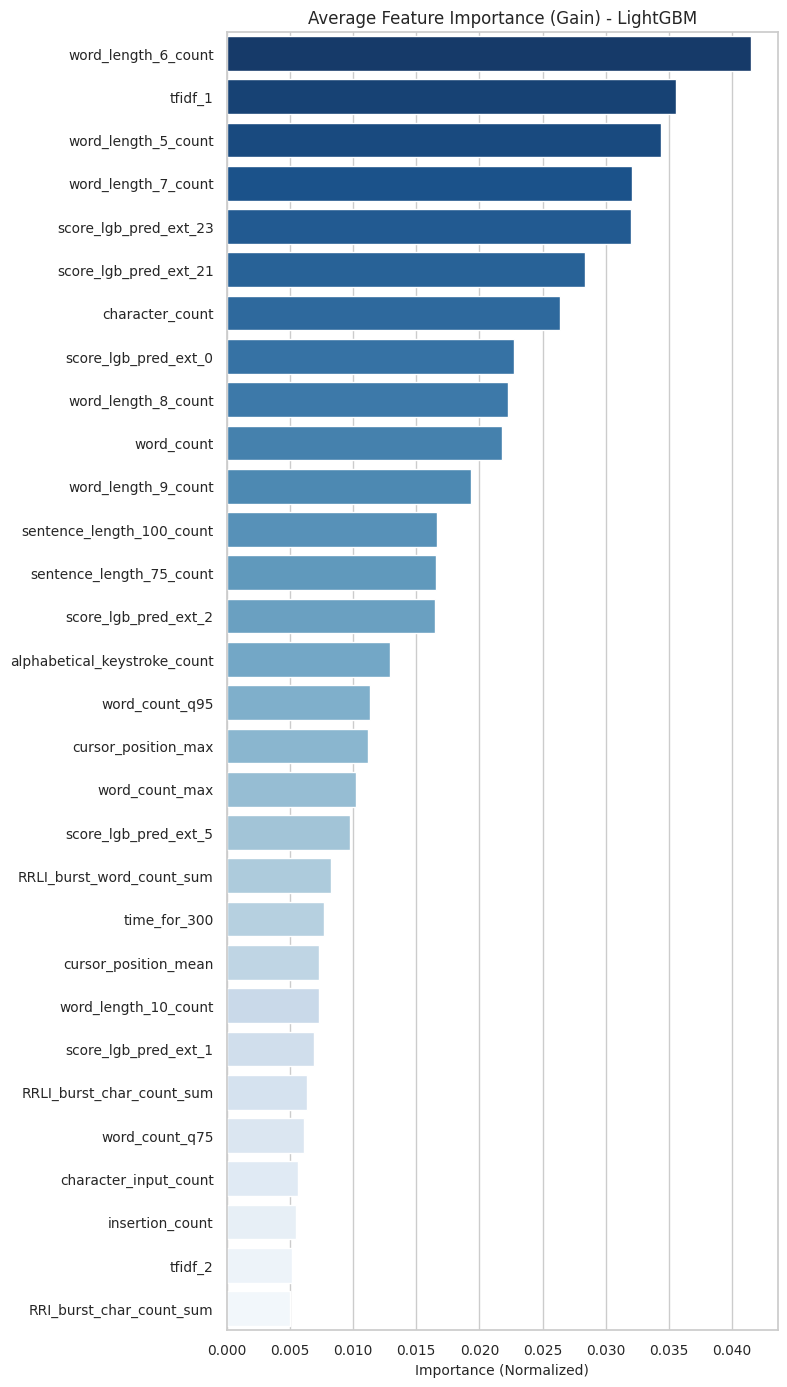

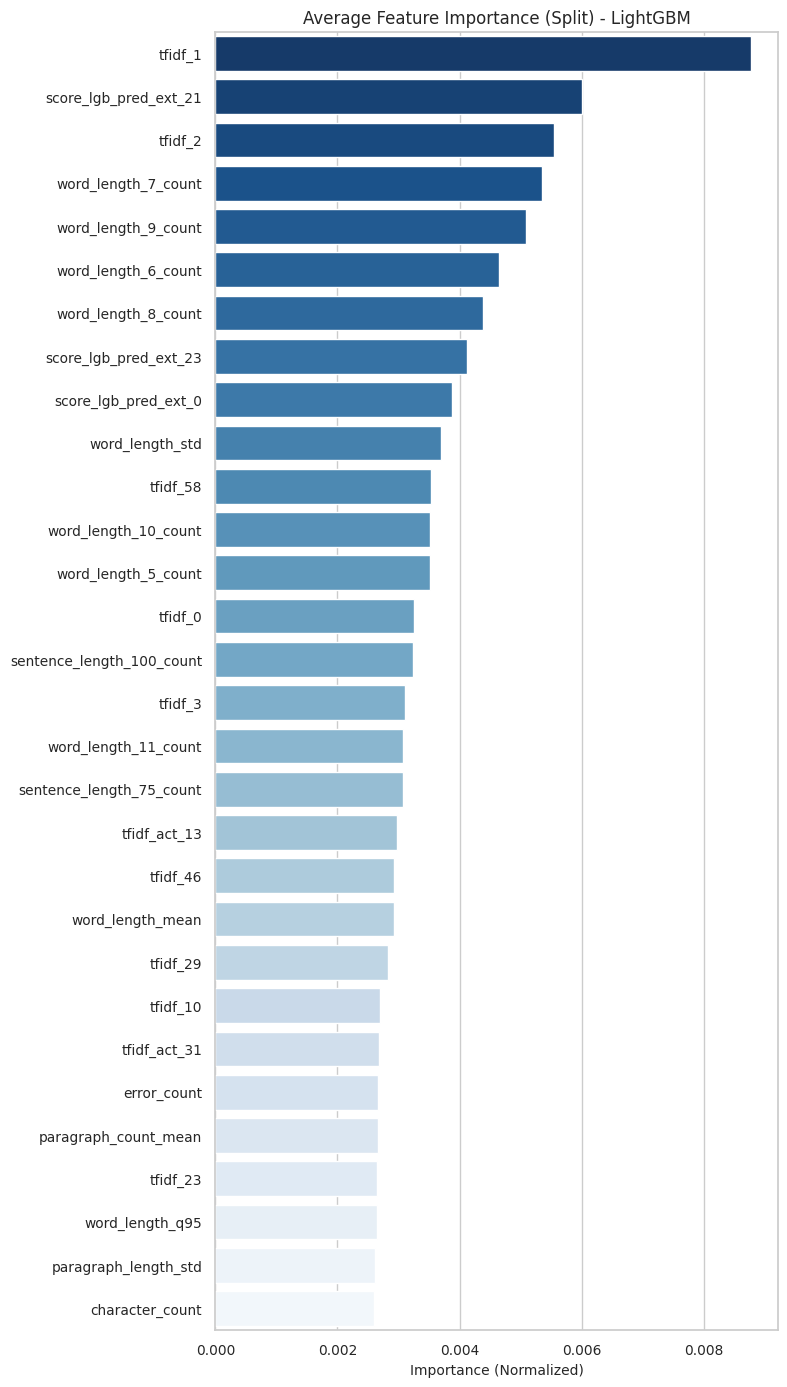

  val_metric: 0.5903 | oof_metric: 0.5868 | oof_round: 0.6073
Running Ablation: product-related (117 features)


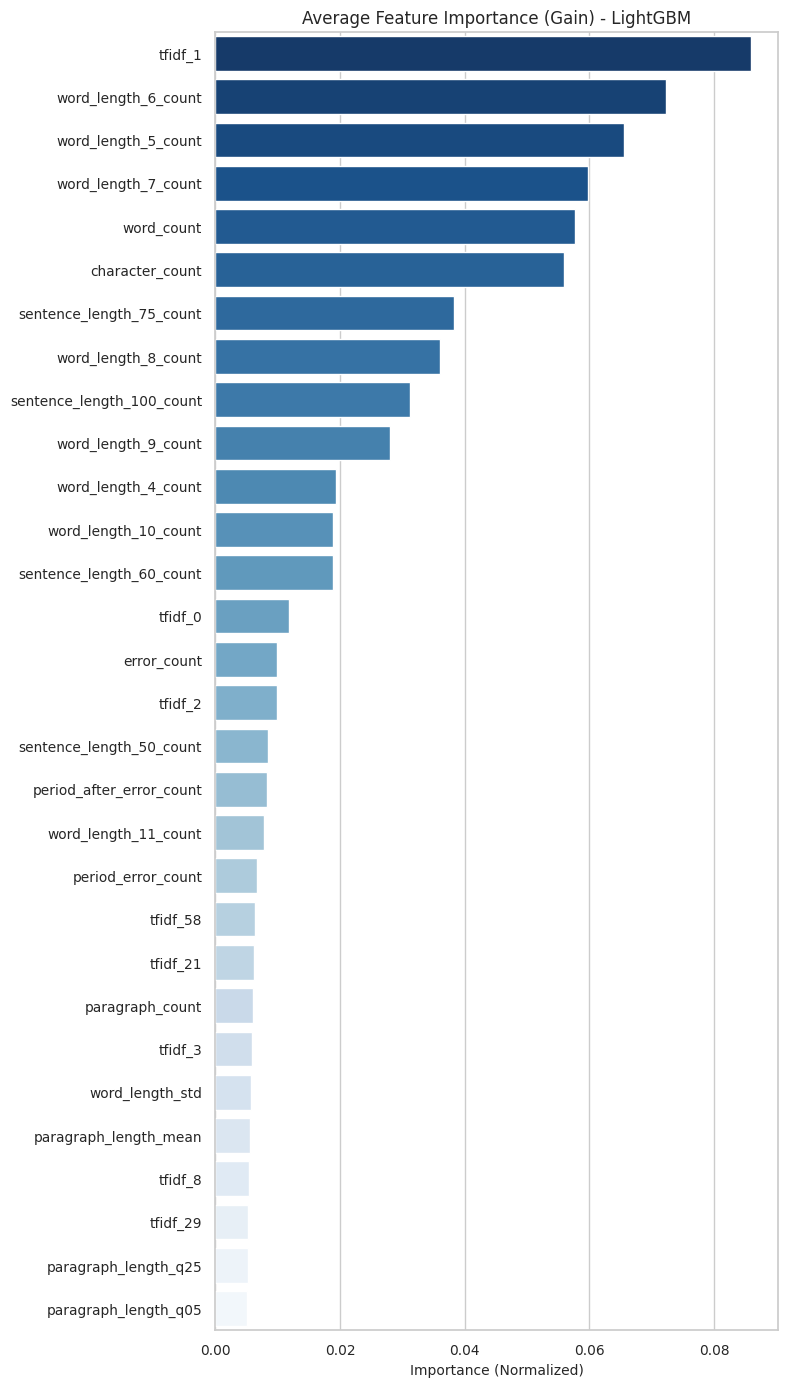

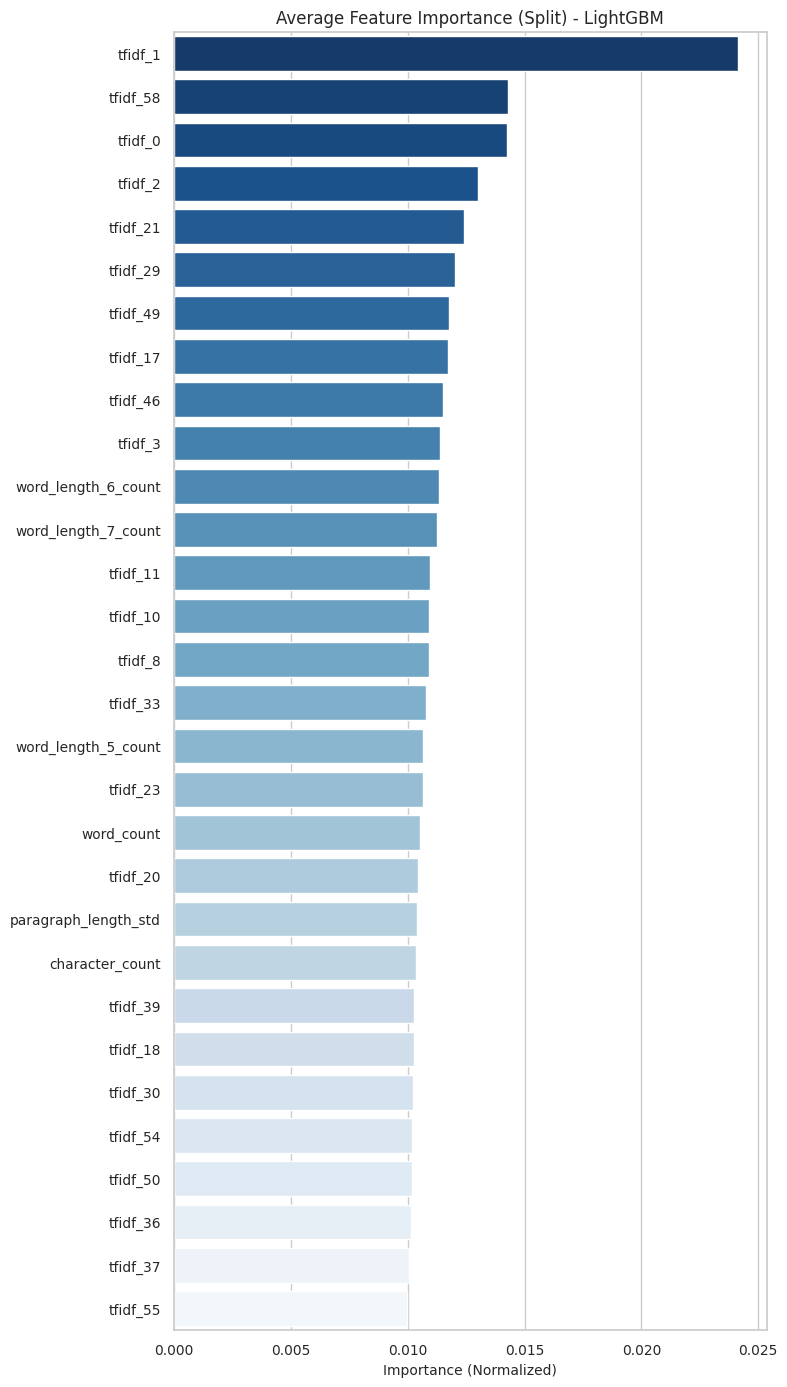

  val_metric: 0.5883 | oof_metric: 0.5855 | oof_round: 0.5996
Running Ablation: minus_product-related (1079 features)


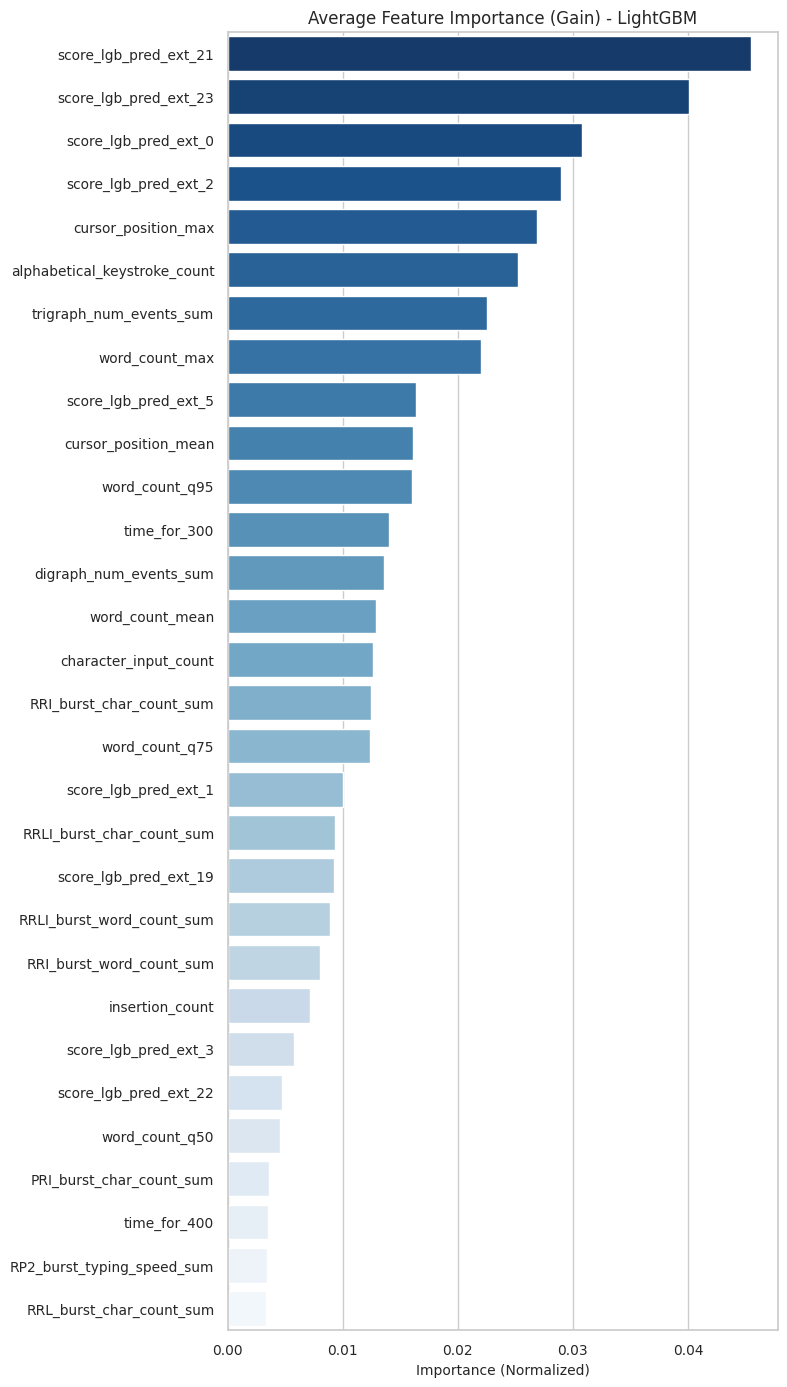

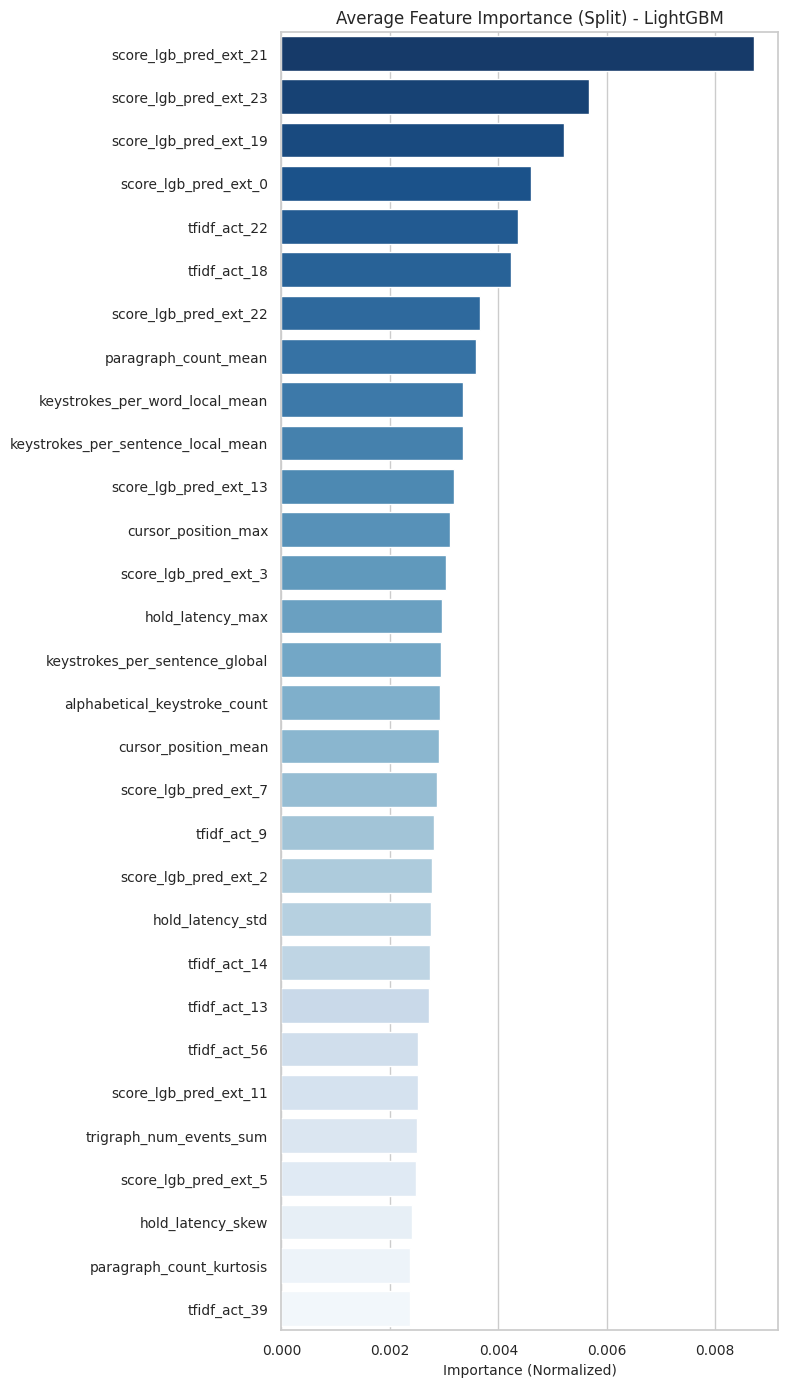

  val_metric: 0.6126 | oof_metric: 0.6088 | oof_round: 0.6273
Running Ablation: revision (74 features)


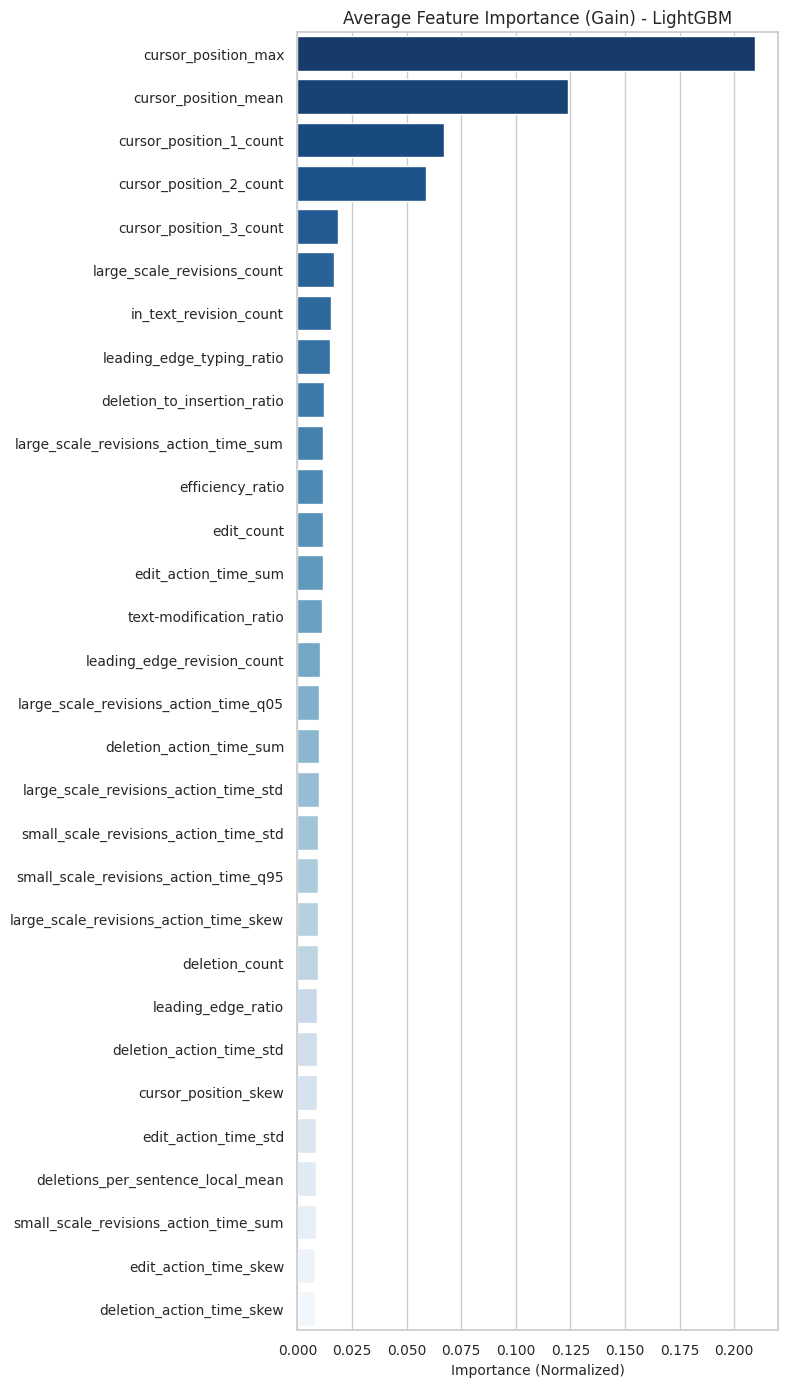

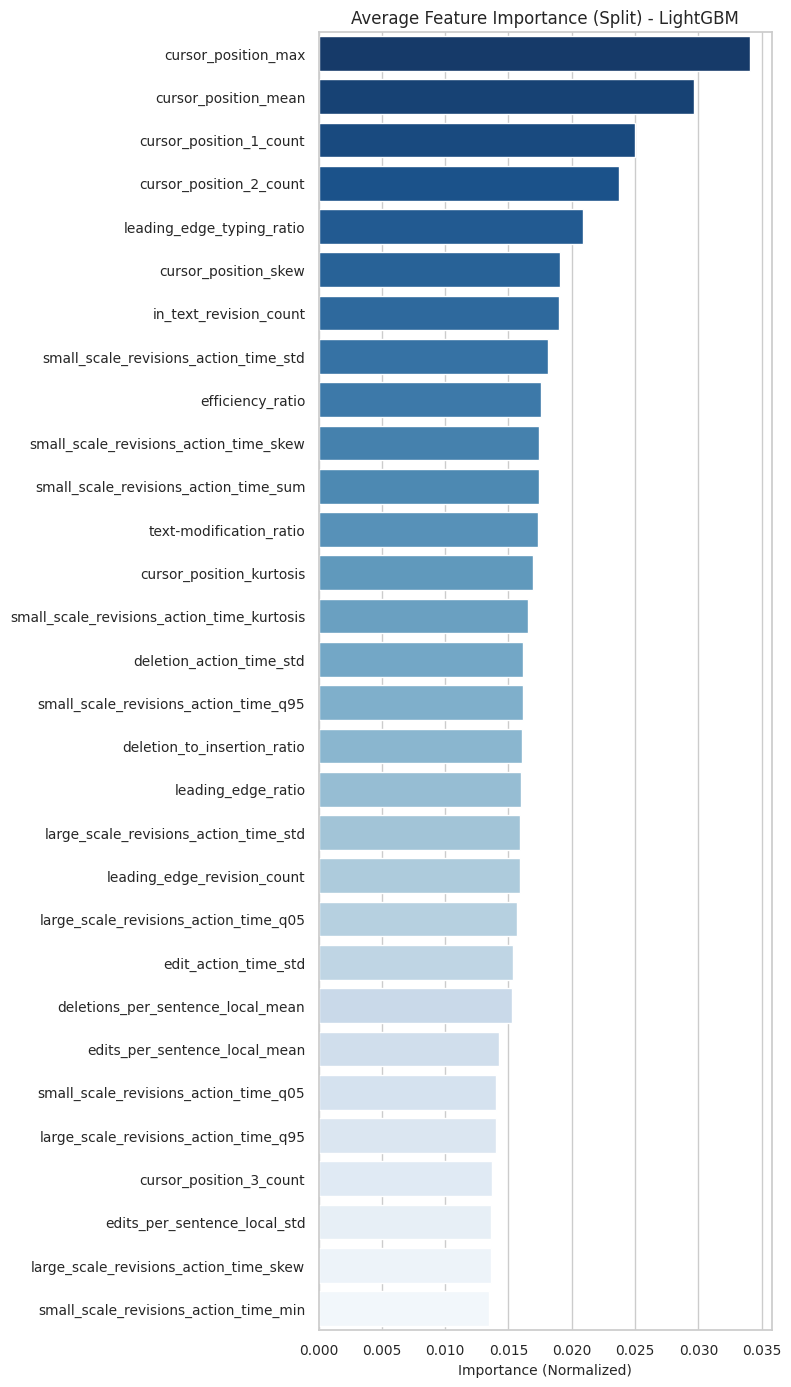

  val_metric: 0.6810 | oof_metric: 0.6783 | oof_round: 0.6912
Running Ablation: minus_revision (1122 features)


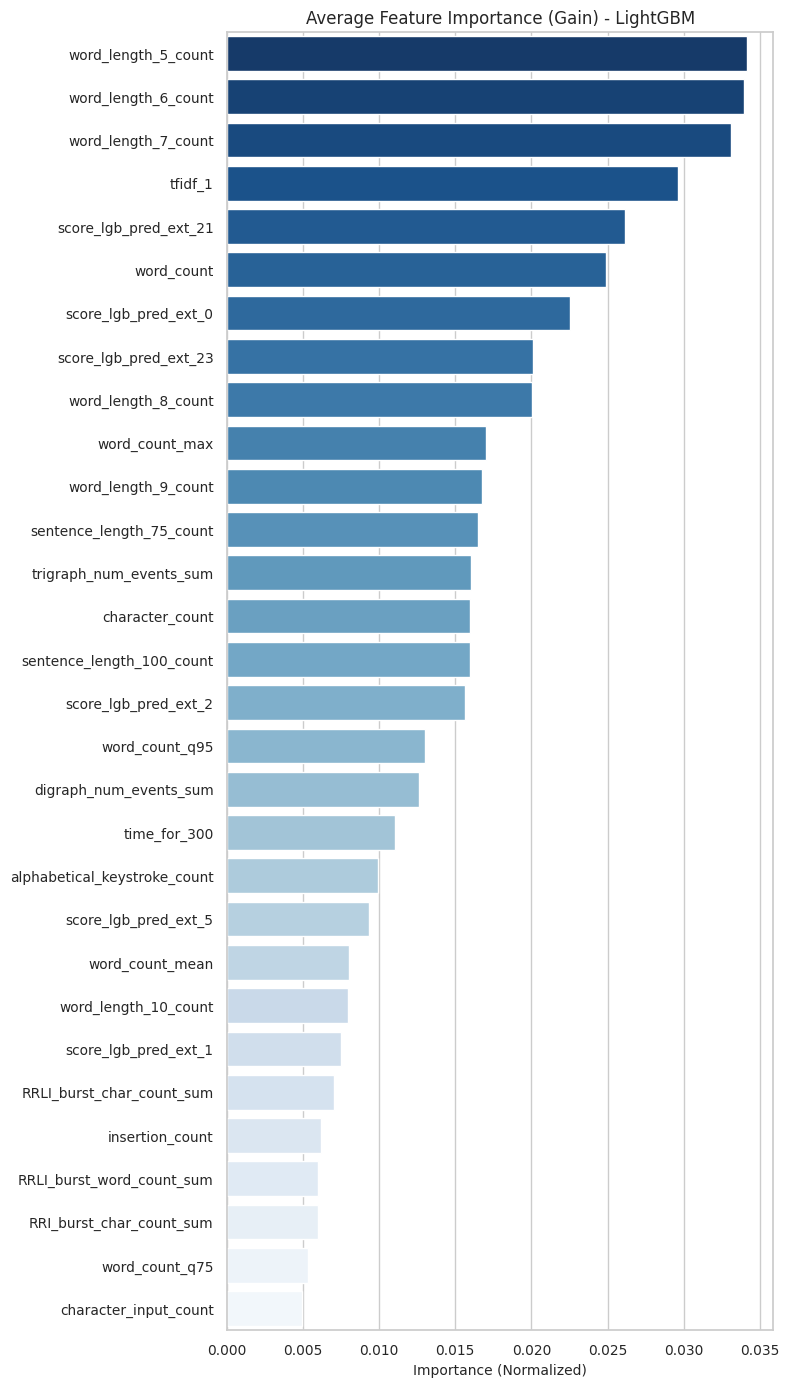

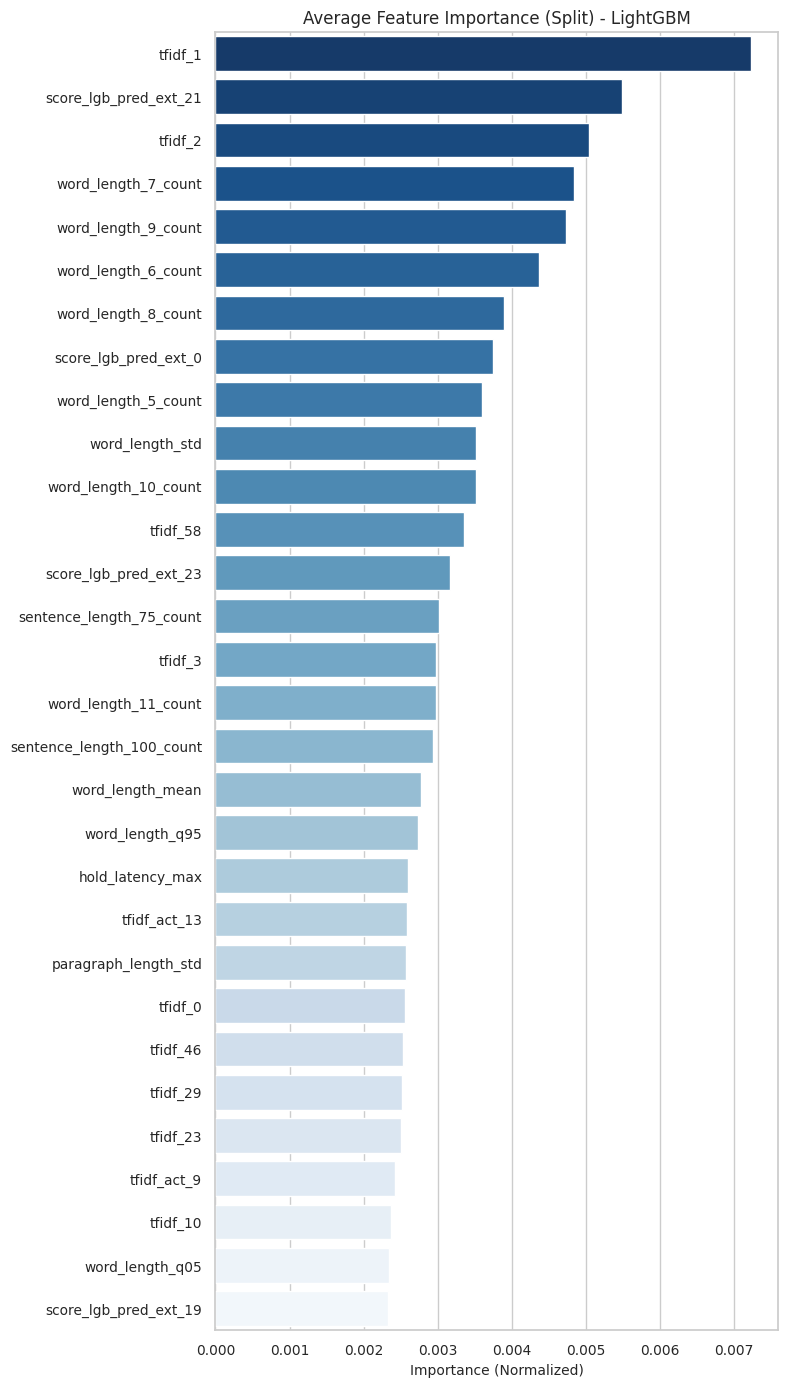

  val_metric: 0.5888 | oof_metric: 0.5853 | oof_round: 0.6029
Running Ablation: verbosity (70 features)


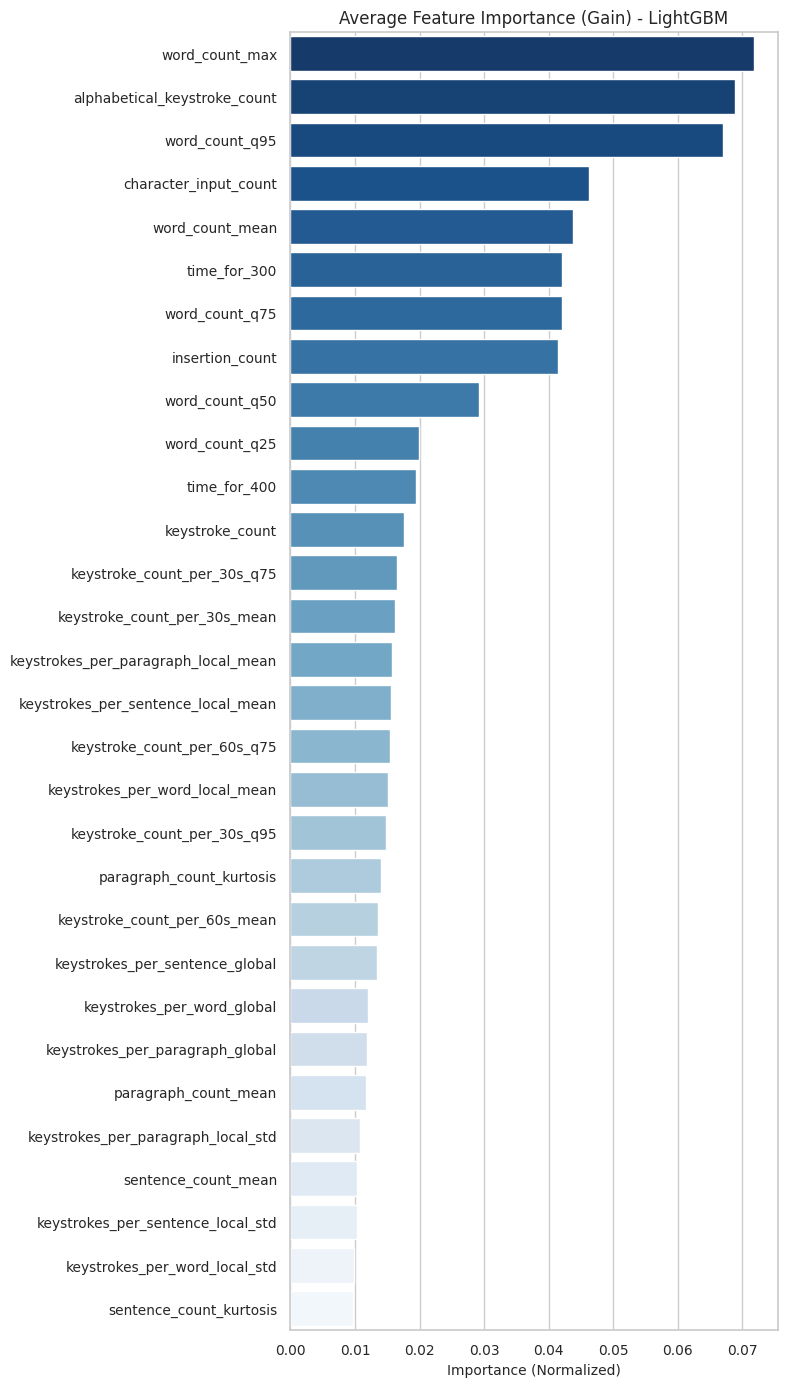

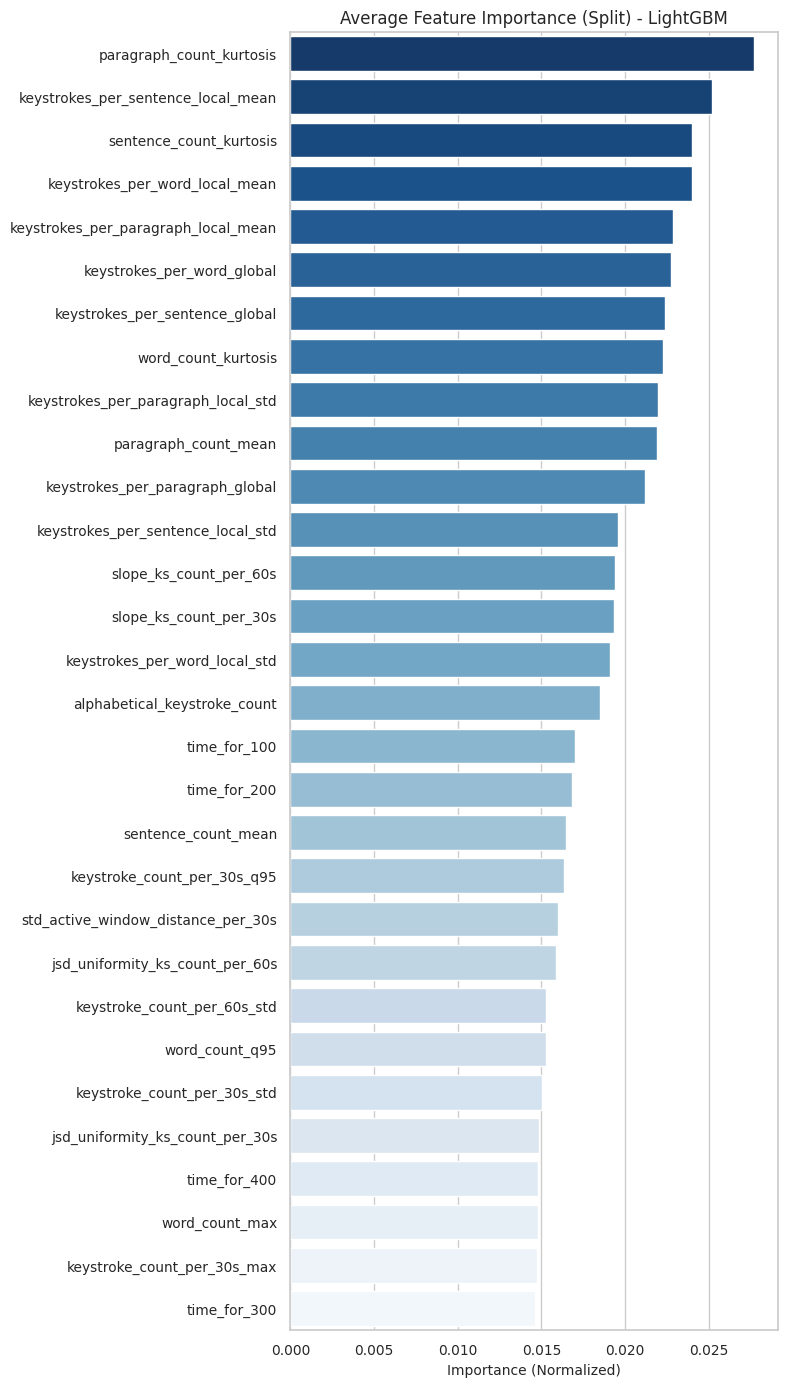

  val_metric: 0.6602 | oof_metric: 0.6572 | oof_round: 0.6724
Running Ablation: minus_verbosity (1126 features)


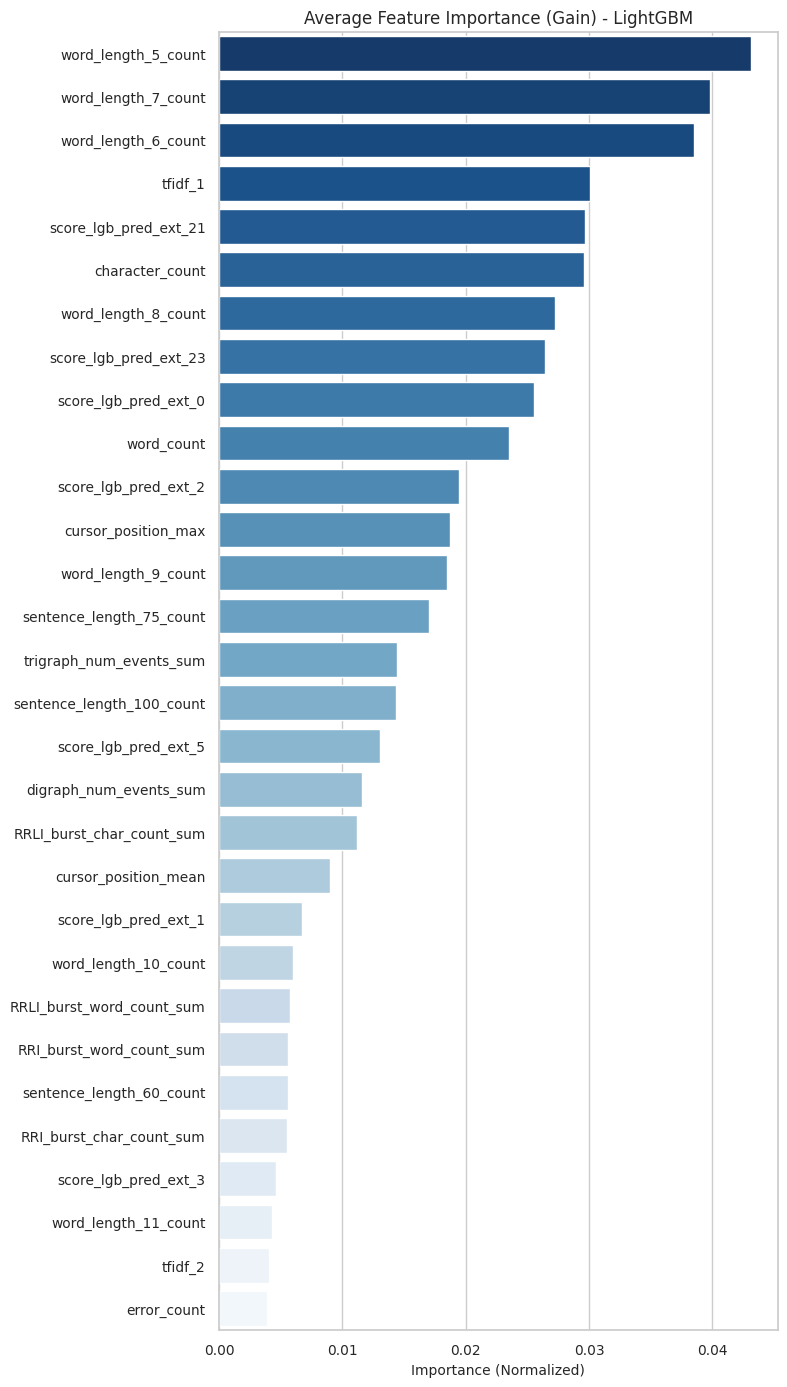

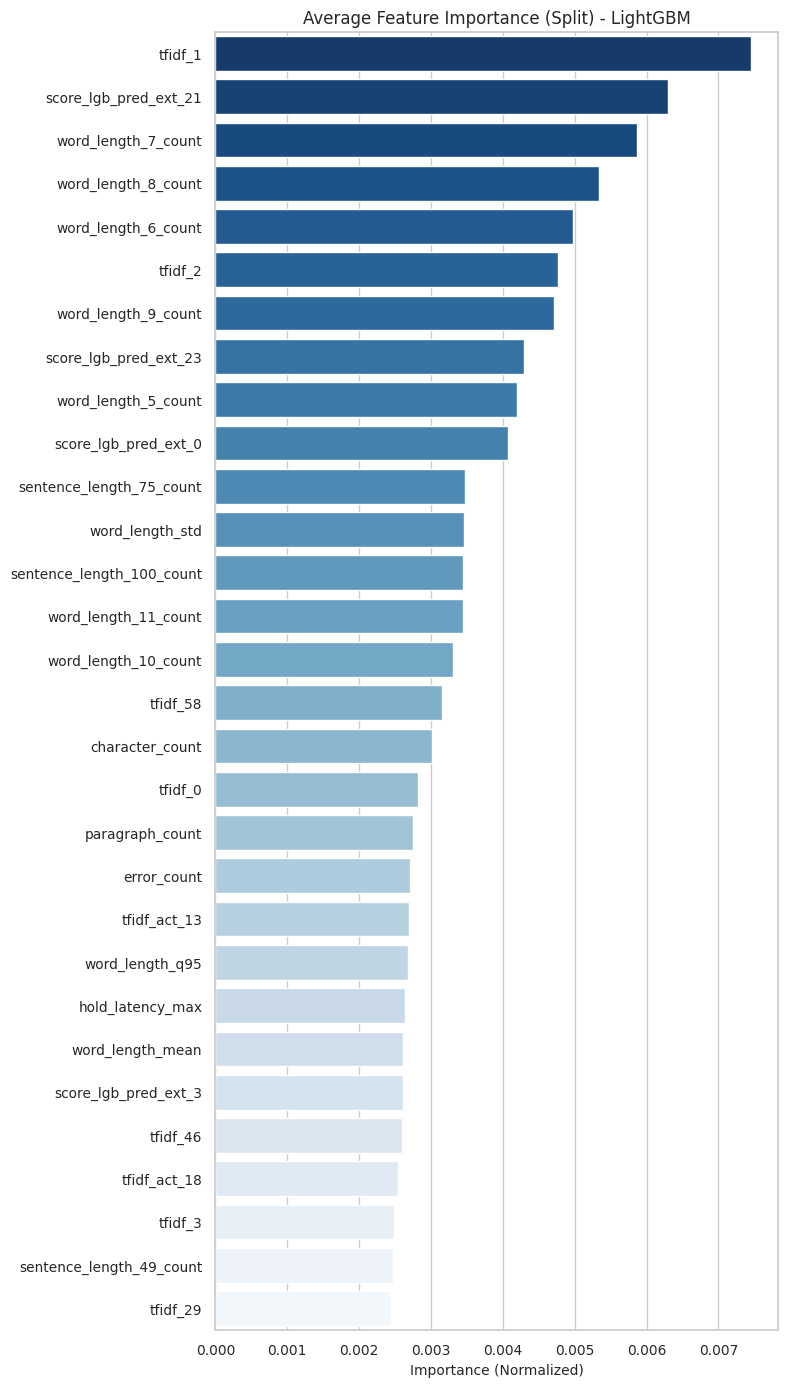

  val_metric: 0.5911 | oof_metric: 0.5877 | oof_round: 0.6074
category Ablation results saved to: output/exp_16/ablation-results/ablation_results_category.csv
CPU times: user 46min 4s, sys: 38.7 s, total: 46min 43s
Wall time: 24min 6s


In [110]:
%%time
# Run category-based ablation experiments
category_ablation_results_df  = run_ablation_experiments(
    train_df=train_df,
    feature_sets=category_ablation_sets,
    cfg=cfg,
    params=params,
    target_col='score',
    mode='lgb',
    log_dir=f"{cfg.out_dir}{cfg.run_name}/ablation-results/",
    log_importance=True,
    log_shap=False,
    show_fig=False,
    save_csv=True,
    ablation_type="category"
)

### 3️⃣ Individual Feature Ablation 
We test the contribution of each top feature from the Existing + Novel group:
- Load the top N features ranked by LightGBM gain scores.
- Add each feature individually to the Kaggle baseline feature set.
- Train one model per feature to assess its standalone impact.

In [111]:
# Load feature importance for existing literature + novel features
importance_path = f"{cfg.out_dir}{cfg.run_name}/ablation-results/source/ablation_existing_novel/feature-importance/avg_gain_lgb_feature_importance.csv"
importance_df = pd.read_csv(importance_path)
importance_df['feature'] = importance_df['feature'].str.strip()
top_features = importance_df.sort_values("importance", ascending=False)["feature"].head(cfg.ablation_top_n_features).tolist()

# Generate individual ablation sets
baseline_features = source_ablation_sets["baseline"]
individual_ablation_sets = {
    f"{feat}": baseline_features + [feat] for feat in top_features
}

In [112]:
%%time
# Run individual feature ablation experiments
individual_ablation_results_df = run_ablation_experiments(
    train_df=train_df,
    feature_sets=individual_ablation_sets,
    cfg=cfg,
    params=params,
    target_col='score',
    mode='lgb',
    log_dir=f"{cfg.out_dir}{cfg.run_name}/ablation-results/",
    log_importance=False,
    log_shap=False,
    show_fig=False,
    save_csv=True,
    ablation_type="individual"
)

Running Ablation: alphabetical_keystroke_count (298 features)
  val_metric: 0.5833 | oof_metric: 0.5799 | oof_round: 0.5979
Running Ablation: trigraph_num_events_sum (298 features)
  val_metric: 0.5830 | oof_metric: 0.5797 | oof_round: 0.5986
Running Ablation: RRLI_burst_word_count_sum (298 features)
  val_metric: 0.5832 | oof_metric: 0.5800 | oof_round: 0.5946
Running Ablation: RRLI_burst_char_count_sum (298 features)
  val_metric: 0.5824 | oof_metric: 0.5792 | oof_round: 0.5954
Running Ablation: digraph_num_events_sum (298 features)
  val_metric: 0.5822 | oof_metric: 0.5789 | oof_round: 0.5963
Running Ablation: RRI_burst_char_count_sum (298 features)
  val_metric: 0.5832 | oof_metric: 0.5801 | oof_round: 0.5963
Running Ablation: insertion_count (298 features)
  val_metric: 0.5829 | oof_metric: 0.5797 | oof_round: 0.5946
Running Ablation: character_input_count (298 features)
  val_metric: 0.5820 | oof_metric: 0.5789 | oof_round: 0.5957
Running Ablation: RRI_burst_word_count_sum (298 f